In [1]:
# This notebook contains the basic plots in the GBO drone paper

In [2]:
## First import general packages for running python analysis:
import os, h5py, datetime,pytz, yaml
import numpy as np
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar
import pickle, glob

from scipy.interpolate import griddata
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import least_squares
from matplotlib import cm
from scipy.stats import binned_statistic_2d


from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

import csv
import math
from math import *
import pandas as pd


## Then import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals.sites import site
from beamcals import beammap as bp
import beamcals.beam_autoprocessing as ba
gbosite=site.site('../beamcals/beamcals/sites/GBO_config.npz')

# various gridding attempts
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging


In [3]:
# Defining anything I want to keep the same 

freqs = 800.0*np.ones(1024) + (-400/1024.)*np.arange(1024)


#basedir = '/hirax/GBO_Analysis_Outputs/2023_SpringSummer_products/'
basedir = '/hirax/GBO_Analysis_Outputs/'
fitdir=basedir+'main_beam_fits/'
ymldir = basedir+'concat_config_files/'
pckldir = basedir+'flight_pickles/'
ampdir = basedir+'amplitude_corrections/'
beamdir = basedir+'beam_pickles/'
polbeamdir = '/hirax/GBO_Analysis_Outputs/beam_pickles/beam_pickles_polar/'

dronedir='/hirax/all_drone_data/datcon_csv/'
fltyaml = '/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml'





In [4]:
# Plotting standards
fsz = 16 # fontsize for labels and legends
ccm = cm.magma # use magma for color maps
ccm_r = cm.magma_r
ccm.set_bad('grey',0.5)
ccm_r.set_bad('grey',0.5)

logmi = -30
logma = 0 

print(gbosite.keystrings)

dlab = ['Dish 0, E Pol','Dish 0, N pol',
        'Dish 7, E Pol','Dish 7, N pol',
        'Dish 2, E Pol','Dish 2, N pol',
        'Dish 3, E Pol','Dish 3, N pol',
        'Dish 4, E Pol','Dish 4, N pol',
        'Dish 5, E Pol','Dish 5, N pol',
        'Dish 6, E Pol','Dish 6, N pol',
        'Dish 8, E Pol','Dish 8, N pol',]

['Dish_0_X' 'Dish_0_Y' 'Dish_7_X' 'Dish_7_Y' 'Dish_2_X' 'Dish_2_Y'
 'Dish_3_X' 'Dish_3_Y' 'Dish_4_X' 'Dish_4_Y' 'Dish_5_X' 'Dish_5_Y'
 'Dish_6_X' 'Dish_6_Y' 'Dish_8_X' 'Dish_8_Y']


<ipython-input-4-727b5fd84aec>:5: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("magma"))
  ccm.set_bad('grey',0.5)
<ipython-input-4-727b5fd84aec>:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("magma_r"))
  ccm_r.set_bad('grey',0.5)


In [5]:
## Useful functions
def get_flightinfo(fly):
    with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
        documents = yaml.safe_load(fff)
    flights = documents["flight_info"]["flights"]
    
    for fi in range(0,len(documents["flight_info"]["flights"])):
        if fly == flights[fi]: f = fi
    
    if polarn[f]=='N':
        pols = N_pols
        cpols = E_pols
    else:
        pols = E_pols
        cpols = N_pols
    return polarn[f], pols, cpols, attns[f], f


def m_to_FWHM(d):
    h = 177.0 # meters
    sig = np.degrees(np.arctan(d/h))
    fwhm = 2.355*sig
    return fwhm

def convert_to_angle(d):
    h = 177.0 # meters
    aa = np.arctan(d/h)
    return np.degrees(aa)

def get_polar_slice(theta,phi,val=0.0): # assume val in angle
    
    tol = abs(theta[1,0] - theta[0,0])/1.5
    N = len(theta[:,0]) #figure out the importance of this 
    #ok = True
    #while(ok):
    sliceIndex1 = np.where(
            (theta[:,0] < (val + tol)) & 
            (theta[:,0] > (val - tol)))[0][0]
    sliceIndex2 = np.where(
            (theta[:,0] < (np.pi + val + tol)) & 
            (theta[:,0] > (np.pi + val - tol)))[0][0]
    return sliceIndex1, sliceIndex2


# if you notice something breaks with get_polar_slice, its probabyl that I
# moved to this one later, which can cut in both theta and phi
# default if you want a 'slice' through the beam and not an annulus is 
# to use the 'theta' direction (direction='t')

def get_polar_slice(theta,phi,val=0.0,direction='t'): # assume val in angle
    
    if direction=='p':
        tol = abs(phi[0,1] - phi[0,0])
        N = len(phi[0,:]) #figure out the importance of this 
        #ok = True
        #while(ok):
        sliceIndex1 = np.where(
            (phi[0,:] < (val + tol)) & 
            (phi[0,:] > (val - tol)))[0][0]
        sliceIndex2 = np.where(
            (phi[0,:] < (val + tol)) & 
            (phi[0,:] > (val - tol)))[0][0]

        
    if direction=='t': 
        tol = abs(theta[1,0] - theta[0,0])/1.5
        N = len(theta[:,0]) #figure out the importance of this 
        #ok = True
        #while(ok):
        sliceIndex1 = np.where(
            (theta[:,0] < (val + tol)) & 
            (theta[:,0] > (val - tol)))[0][0]
        sliceIndex2 = np.where(
            (theta[:,0] < (np.pi + val + tol)) & 
            (theta[:,0] > (np.pi + val - tol)))[0][0]
        
    return sliceIndex1, sliceIndex2

def get_slice_xy(xes,yes,val,tol=1.5,ax='x'):
    if ax=='x':
        col = np.where((xes < val+tol) & (xes > val-tol))[0]
    if ax=='y':
        col = np.where((yes < val+tol) & (yes > val-tol))[0]
    return col

## Include theory lines:
def get_diffrac(fs):
    D = 6.0
    lam = 3E8 / (fs*1E6) # lambda in meters
    return np.degrees(np.arcsin(1.03 * lam / D)) 

def get_newpointing(x,y,xc,yx,theta):
    xp = x - xc
    yp = y - yc
    xpp = np.cos(theta)*xp - np.sin(theta)*yp
    ypp = np.sin(theta)*xp + np.cos(theta)*yp
    return xpp, ypp

In [6]:
with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
    documents = yaml.safe_load(fff)
flights = documents["flight_info"]["flights"]
N_pols = documents["flag_info"]["N_pols"]
E_pols = documents["flag_info"]["E_pols"]
polarn = documents["flight_info"]["pols"]
attns = documents["flight_info"]["attns"]
masks = documents["flight_info"]["masks"]
good_freqs = documents["freq_info"]["good_freqs"]

pcklarr=np.sort(os.listdir(pckldir))
gfitarr=np.sort(os.listdir(fitdir))
amparr=np.sort(os.listdir(ampdir))
print(gfitarr,amparr)

Npolflights = ['618','619','625','646','647','533']
Epolflights = ['620','648','649','535']
NF = len(Npolflights)
NE = len(Epolflights)
F = NF+NE
fi_i =650

find=900
sz=80


['FLY533_20210826T182904Z_2dGauss_and_Airy_Params.npz'
 'FLY534_20210826T185621Z_2dGauss_and_Airy_Params.npz'
 'FLY535_20210826T192056Z_2dGauss_and_Airy_Params.npz'
 'FLY618_20211021T183430Z_2dGauss_and_Airy_Params.npz'
 'FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz'
 'FLY620_20211021T192212Z_2dGauss_and_Airy_Params.npz'
 'FLY623_20211021T203206Z_2dGauss_and_Airy_Params.npz'
 'FLY625_20211021T214028Z_2dGauss_and_Airy_Params.npz'
 'FLY646_20211022T183659Z_2dGauss_and_Airy_Params.npz'
 'FLY647_20211022T185749Z_2dGauss_and_Airy_Params.npz'
 'FLY648_20211022T191922Z_2dGauss_and_Airy_Params.npz'
 'FLY649_20211022T194308Z_2dGauss_and_Airy_Params.npz'] ['FLY533_Corrected_amplitudes.pkl' 'FLY534_Corrected_amplitudes.pkl'
 'FLY535_Corrected_amplitudes.pkl' 'FLY618_Corrected_amplitudes.pkl'
 'FLY619_Corrected_amplitudes.pkl' 'FLY620_Corrected_amplitudes.pkl'
 'FLY623_Corrected_amplitudes.pkl' 'FLY625_Corrected_amplitudes.pkl'
 'FLY646_Corrected_amplitudes.pkl' 'FLY647_Corrected_amplitudes

In [7]:
print(flights)

['533', '534', '535', '618', '619', '620', '623', '625', '646', '647', '648', '649']


In [1]:
####################################################################################
############################# SECTION 2 ##########################################
############################# SECTION 2 ##########################################
############################# SECTION 2 ##########################################
############################# SECTION 2 ##########################################
####################################################################################

In [2]:
####################################################################################
############################# SECTION 2.1 ##########################################
############################# SECTION 2.1 ##########################################
####################################################################################


######################################################################
######################################################################
########## Comparing Gaussian centroids between flights ##########
######################################################################
######################################################################

print('Finding the median pointing per flight, and the average difference from the median')

############ Npol
pols = N_pols
flies = Npolflights
allfits = np.zeros([len(pols),1024,2,len(flies)]) # dish, freq, x/y, flight

#fig = plt.figure(figsize=(15,10))
for f,fly in enumerate(flies):
    fits = np.load(glob.glob(fitdir+'*'+fly+'*')[0])
    for p,pol in enumerate(pols):
        allfits[p,:,0,f] = fits['G_popt'][pol,:,1]
        allfits[p,:,1,f] = fits['G_popt'][pol,:,3]        

        
# First, generate the median value per flight, we need this to do some differencing
xmeds = np.nanmedian(allfits[:,fi_i:-1,0,:],axis=-1)
ymeds = np.nanmedian(allfits[:,fi_i:-1,1,:],axis=-1)

meddif_pppf = np.zeros([len(pols),NF,3])
meddif_pf = np.zeros([F,3])

for f,fly in enumerate(flies):
    for p,pol in enumerate(pols):
        meddif_pppf[p,f,0] = np.nanmean(allfits[p,fi_i:-1,0,f] - xmeds[p,:]) #x
        meddif_pppf[p,f,1] = np.nanmean(allfits[p,fi_i:-1,1,f] - ymeds[p,:]) #y
        meddif_pppf[p,f,2] = np.nanmean(np.sqrt((allfits[p,fi_i:-1,0,f] - xmeds[p,:])**2 + 
                                           (allfits[p,fi_i:-1,1,f] - ymeds[p,:])**2)) #r

meddif_pf[0:NF,:] = np.nanmean(meddif_pppf[:,:,:],axis=0)

print('per flight X   perflight Y   perflight R')
for f, fly in enumerate(flies):
    print(fly, meddif_pf[f,:])

    
############ Epol
pols = E_pols
flies = Epolflights
allfits = np.zeros([len(pols),1024,2,len(flies)]) # dish, freq, x/y, flight

#fig = plt.figure(figsize=(15,10))
for f,fly in enumerate(flies):
    fits = np.load(glob.glob(fitdir+'*'+fly+'*')[0])
    for p,pol in enumerate(pols):
        allfits[p,:,0,f] = fits['G_popt'][pol,:,1]
        allfits[p,:,1,f] = fits['G_popt'][pol,:,3]        

        
# First, generate the median value per flight, we need this to do some differencing
xmeds = np.nanmedian(allfits[:,fi_i:-1,0,:],axis=-1)
ymeds = np.nanmedian(allfits[:,fi_i:-1,1,:],axis=-1)

meddif_pppf = np.zeros([len(pols),len(flies),3])
for f,fly in enumerate(flies):
    for p,pol in enumerate(pols):
        meddif_pppf[p,f,0] = np.nanmedian(allfits[p,fi_i:-1,0,f] - xmeds[p,:])
        meddif_pppf[p,f,1] = np.nanmedian(allfits[p,fi_i:-1,1,f] - ymeds[p,:])
        meddif_pppf[p,f,2] = np.nanmedian(np.sqrt((allfits[p,fi_i:-1,0,f] - xmeds[p,:])**2 + 
                                           (allfits[p,fi_i:-1,1,f] - ymeds[p,:])**2))   

meddif_pf[NF:F,:] = np.nanmedian(meddif_pppf[:,:,:],axis=0)

for f, fly in enumerate(flies):
    print(fly, meddif_pf[NF+f,:])    

print('AVG X   AVG Y   AVG R')
print(np.nanmedian(meddif_pf[:,0]),np.nanmedian(meddif_pf[:,1]),np.nanmedian(meddif_pf[:,2]))

augs = [5,9]
print('AUG:: AVG X   AVG Y   AVG R')
print(np.nanmedian(meddif_pf[augs,0]),np.nanmedian(meddif_pf[augs,1]),np.nanmedian(meddif_pf[augs,2]))

octs = [0,1,2,3,4,6,7,8]
print('OCT:: AVG X   AVG Y   AVG R')
print(np.nanmedian(meddif_pf[octs,0]),np.nanmedian(meddif_pf[octs,1]),np.nanmedian(meddif_pf[octs,2]))

######################################################################
######################################################################
########## Comparing Gaussian centroids  to ref flight ##########
######################################################################
######################################################################

print('Finding the median pointing per flight compared to a reference flight (618, 620)')

###### Npols 
pols = N_pols
flies = Npolflights
allfits = np.zeros([len(pols),1024,2,len(flies)]) # dish, freq, x/y, flight

#fig = plt.figure(figsize=(15,10))
for f,fly in enumerate(flies):
    fits = np.load(glob.glob(fitdir+'*'+fly+'*')[0])
    for p,pol in enumerate(pols):
        allfits[p,:,0,f] = fits['G_popt'][pol,:,1]
        allfits[p,:,1,f] = fits['G_popt'][pol,:,3]        

refdif_pppf = np.zeros([len(pols),NF-1,3]) # average and std of differences [pol,flights, med/std]
refdif_pf = np.zeros([F,3])

# Find difference between flight 618 and the rest, per input
for f in np.arange(1,NF):
    for p,pol in enumerate(pols):
        refdif_pppf[p,f-1,0] = np.nanmedian(allfits[p,fi_i:-1,0,f] - allfits[p,fi_i:-1,0,0]) # x
        refdif_pppf[p,f-1,1] = np.nanmedian(allfits[p,fi_i:-1,1,f] - allfits[p,fi_i:-1,1,0]) # y
        refdif_pppf[p,f-1,2] = np.nanmedian(np.sqrt((allfits[p,fi_i:-1,0,f] - allfits[p,fi_i:-1,0,0])**2 +
                                       (allfits[p,fi_i:-1,1,f] - allfits[p,fi_i:-1,1,0])**2))

refdif_pf[1:NF,:] = np.nanmean(refdif_pppf[:,:,:],axis=0)

###### Epols
pols = E_pols
flies = Epolflights
allfits = np.zeros([len(pols),1024,2,len(flies)]) # dish, freq, x/y, flight

#fig = plt.figure(figsize=(15,10))
for f,fly in enumerate(flies):
    fits = np.load(glob.glob(fitdir+'*'+fly+'*')[0])
    for p,pol in enumerate(pols):
        allfits[p,:,0,f] = fits['G_popt'][pol,:,1]
        allfits[p,:,1,f] = fits['G_popt'][pol,:,3]        
        
refdif_pppf = np.zeros([len(pols),NE-1,3]) # average and std of differences [pol,flights, med/std]

# Find difference between flight 618 and the rest, per input
for f in np.arange(1,NE):
    for p,pol in enumerate(pols):
        refdif_pppf[p,f-1,0] = np.nanmedian(allfits[p,fi_i:-1,0,f] - allfits[p,fi_i:-1,0,0]) # x
        refdif_pppf[p,f-1,1] = np.nanmedian(allfits[p,fi_i:-1,1,f] - allfits[p,fi_i:-1,1,0]) # y
        refdif_pppf[p,f-1,2] = np.nanmedian(np.sqrt((allfits[p,fi_i:-1,0,f] - allfits[p,fi_i:-1,0,0])**2 +
                                       (allfits[p,fi_i:-1,1,f] - allfits[p,fi_i:-1,1,0])**2))

        

refdif_pf[NF+1:F,:] = np.nanmedian(refdif_pppf[:,:,:],axis=0)


nonzero = [1,2,3,4,5,7,8,9]    
print('AVG X   AVG Y   AVG R')
print(np.nanmedian(refdif_pf[nonzero,0]),np.nanmedian(refdif_pf[nonzero,1]),np.nanmedian(refdif_pf[nonzero,2]))
        
######################################################################
######################################################################
########## Comparing Return to points between flights ##########
######################################################################
######################################################################

print('Comparing the return to point *between* flights')


# This cell reads in all of the drone data for all of the flights, so it will take a few minutes 

#Npolflight order
tlbsa = [0,0,0,0,0,0,0]
tubsa = [1000,350,600,1000,100,400,350]
tlba = [6000,5400,6570,6480,5640,6200,5850]
tuba = [-1,-1,-1,-1,-1,-1,-1]

Nrtp = np.zeros([len(Npolflights),4,2]) # flight, startX/endY/startY/endY, med/std

for f,fly in enumerate(Npolflights):
    dronedir='/hirax/all_drone_data/datcon_csv/'
    dronedat=drone.Drone_Data(Drone_Directory=dronedir,FLYTAG='FLY'+fly+'.csv',site_class=gbosite)

    
    Nrtp[f,0,0] = np.nanmedian(dronedat.coords_xyz_LC[tlbsa[f]:tubsa[f],0]) # start X
    Nrtp[f,1,0] = np.nanmedian(dronedat.coords_xyz_LC[tlba[f]:tuba[f],0])  # end X
    Nrtp[f,2,0] = np.nanmedian(dronedat.coords_xyz_LC[tlbsa[f]:tubsa[f],1]) # start Y
    Nrtp[f,3,0] = np.nanmedian(dronedat.coords_xyz_LC[tlba[f]:tuba[f],1]) #end Y

    Nrtp[f,0,1] = np.nanstd(dronedat.coords_xyz_LC[tlbsa[f]:tubsa[f],0])
    Nrtp[f,1,1] = np.nanstd(dronedat.coords_xyz_LC[tlba[f]:tuba[f],0])
    Nrtp[f,2,1] = np.nanstd(dronedat.coords_xyz_LC[tlbsa[f]:tubsa[f],1])
    Nrtp[f,3,1] = np.nanstd(dronedat.coords_xyz_LC[tlba[f]:tuba[f],1])

    
print('Flight  delX    delY  delR ---- Npolflights')
for f in np.arange(len(Npolflights)):
    print(Npolflights[f],(Nrtp[f,0,0]-Nrtp[f,1,0]),Nrtp[f,2,0]-Nrtp[f,3,0],
          np.sqrt((Nrtp[f,0,0]-Nrtp[f,1,0])**2 + (Nrtp[f,2,0]-Nrtp[f,3,0])**2))
    
print('Npol flights - average return to points -- ', 
      np.median(np.sqrt((Nrtp[:,0,0]-Nrtp[:,1,0])**2 + (Nrtp[:,2,0]-Nrtp[:,3,0])**2)))

r2pdif_pf = np.zeros([F,4])
print('Flight  X-Flight 618   Y - Flight 618')
for f in np.arange(1,NF):
    r2pdif_pf[f,0] = 0.5*(Nrtp[f,0,0]+Nrtp[f,1,0]) - 0.5*(Nrtp[0,0,0]+Nrtp[0,1,0]) # x
    r2pdif_pf[f,1] = 0.5*(Nrtp[f,2,0]+Nrtp[f,3,0]) - 0.5*(Nrtp[0,2,0]+Nrtp[0,3,0]) # y
    r2pdif_pf[f,2] = np.sqrt( r2pdif_pf[f,0]**2 + r2pdif_pf[f,1]**2 ) # r
    r2pdif_pf[f,3] = np.sqrt(Nrtp[f,0,1]**2 + Nrtp[f,1,1]**2 + Nrtp[f,2,1]**2 + Nrtp[f,3,1]**2) # std
    
print('Flight  avgR stdR relative to flight 618 ---- Npolflights')
for f in np.arange(0,len(Npolflights)):
    print(Npolflights[f],r2pdif_pf[f,2],r2pdif_pf[f,3])
    
#Epolflight order
tlbsa = [0,0,0,0]
tubsa = [100,200,100,500]
tlba = [4930,5370,5300,5810]
tuba = [-1,-1,-1,-1]

Nrtp = np.zeros([len(Epolflights),4,2]) # flight, startX/endY/startY/endY, med/std

for f,fly in enumerate(Epolflights):
    dronedir='/hirax/all_drone_data/datcon_csv/'
    dronedat=drone.Drone_Data(Drone_Directory=dronedir,FLYTAG='FLY'+fly+'.csv',site_class=gbosite)
    
    Nrtp[f,0,0] = np.median(dronedat.coords_xyz_LC[tlbsa[f]:tubsa[f],0]) # start X
    Nrtp[f,1,0] = np.median(dronedat.coords_xyz_LC[tlba[f]:tuba[f],0])  # end X
    Nrtp[f,2,0] = np.median(dronedat.coords_xyz_LC[tlbsa[f]:tubsa[f],1]) # start Y
    Nrtp[f,3,0] = np.median(dronedat.coords_xyz_LC[tlba[f]:tuba[f],1]) #end Y

    Nrtp[f,0,1] = np.std(dronedat.coords_xyz_LC[tlbsa[f]:tubsa[f],0])
    Nrtp[f,1,1] = np.std(dronedat.coords_xyz_LC[tlba[f]:tuba[f],0])
    Nrtp[f,2,1] = np.std(dronedat.coords_xyz_LC[tlbsa[f]:tubsa[f],1])
    Nrtp[f,3,1] = np.std(dronedat.coords_xyz_LC[tlba[f]:tuba[f],1])

print('Flight  delX    delY  delR relative to flight 620 --- Epolflights')
for f in np.arange(len(Epolflights)):
    print(Epolflights[f],(Nrtp[f,0,0]-Nrtp[f,1,0]),Nrtp[f,2,0]-Nrtp[f,3,0],
          np.sqrt((Nrtp[f,0,0]-Nrtp[f,1,0])**2 + (Nrtp[f,2,0]-Nrtp[f,3,0])**2))

print('Epol flights - average return to points -- ', 
      np.median(np.sqrt((Nrtp[:,0,0]-Nrtp[:,1,0])**2 + (Nrtp[:,2,0]-Nrtp[:,3,0])**2)))
    
for f in np.arange(1,NE):
    r2pdif_pf[NF+f,0] = 0.5*(Nrtp[f,0,0]+Nrtp[f,1,0]) - 0.5*(Nrtp[0,0,0]+Nrtp[0,1,0]) # x
    r2pdif_pf[NF+f,1] = 0.5*(Nrtp[f,2,0]+Nrtp[f,3,0]) - 0.5*(Nrtp[0,2,0]+Nrtp[0,3,0]) # y
    r2pdif_pf[NF+f,2] = np.sqrt( r2pdif_pf[f,0]**2 + r2pdif_pf[f,1]**2 ) # r
    r2pdif_pf[NF+f,3] = np.sqrt(Nrtp[f,0,1]**2 + Nrtp[f,1,1]**2 + Nrtp[f,2,1]**2 + Nrtp[f,3,1]**2) # std
    
print('avgR stdR relative to ref flight -- all flights')
print(np.nanmedian(r2pdif_pf[nonzero,2]),np.nanmedian(r2pdif_pf[nonzero,3]))
    
plt.plot(refdif_pf[:,0],r2pdif_pf[:,0],'b.')
plt.plot(np.arange(-5,5),np.arange(-5,5),color='black')
plt.xlabel('Gaussian fit offsets from control flight')
plt.ylabel('return-to-point offsets from control flight')
plt.xlim(-3,3)
plt.ylim(-8,3)

plt.title('X offset')
plt.show()
plt.plot(refdif_pf[:,1],r2pdif_pf[:,1],'b.')
plt.plot(np.arange(-5,5),np.arange(-5,5),color='black')
plt.xlabel('Gaussian fit offsets from control flight')
plt.ylabel('return-to-point offsets from control flight')
plt.title('Y offset')
plt.xlim(-2,3)
plt.ylim(-5,4)
plt.show()

# Streamlining above, just the return to point measurements between flights

print('Comparing the return to point *between* flights')


# This cell reads in all of the drone data for all of the flights, so it will take a few minutes 

#Npolflight order
tlbsa = [0,0,0,0,0,0,0]
tubsa = [1000,350,600,1000,100,400,350]
tlba = [6000,5400,6570,6480,5640,6200,5850]
tuba = [-1,-1,-1,-1,-1,-1,-1]

rtp = np.zeros([len(Npolflights+Epolflights),4,2]) # flight, startX/endY/startY/endY, med/std

for f,fly in enumerate(Npolflights):
    dronedir='/hirax/all_drone_data/datcon_csv/'
    dronedat=drone.Drone_Data(Drone_Directory=dronedir,FLYTAG='FLY'+fly+'.csv',site_class=gbosite)

    
    rtp[f,0,0] = np.nanmedian(dronedat.coords_xyz_LC[tlbsa[f]:tubsa[f],0]) # start X
    rtp[f,1,0] = np.nanmedian(dronedat.coords_xyz_LC[tlba[f]:tuba[f],0])  # end X
    rtp[f,2,0] = np.nanmedian(dronedat.coords_xyz_LC[tlbsa[f]:tubsa[f],1]) # start Y
    rtp[f,3,0] = np.nanmedian(dronedat.coords_xyz_LC[tlba[f]:tuba[f],1]) #end Y

    rtp[f,0,1] = np.nanstd(dronedat.coords_xyz_LC[tlbsa[f]:tubsa[f],0])
    rtp[f,1,1] = np.nanstd(dronedat.coords_xyz_LC[tlba[f]:tuba[f],0])
    rtp[f,2,1] = np.nanstd(dronedat.coords_xyz_LC[tlbsa[f]:tubsa[f],1])
    rtp[f,3,1] = np.nanstd(dronedat.coords_xyz_LC[tlba[f]:tuba[f],1])


tlbsa = [0,0,0,0]
tubsa = [100,200,100,500]
tlba = [4930,5370,5300,5810]
tuba = [-1,-1,-1,-1]

for f,fly in enumerate(Epolflights):
    dronedir='/hirax/all_drone_data/datcon_csv/'
    dronedat=drone.Drone_Data(Drone_Directory=dronedir,FLYTAG='FLY'+fly+'.csv',site_class=gbosite)

    
    rtp[NF+f,0,0] = np.nanmedian(dronedat.coords_xyz_LC[tlbsa[f]:tubsa[f],0]) # start X
    rtp[NF+f,1,0] = np.nanmedian(dronedat.coords_xyz_LC[tlba[f]:tuba[f],0])  # end X
    rtp[NF+f,2,0] = np.nanmedian(dronedat.coords_xyz_LC[tlbsa[f]:tubsa[f],1]) # start Y
    rtp[NF+f,3,0] = np.nanmedian(dronedat.coords_xyz_LC[tlba[f]:tuba[f],1]) #end Y

    rtp[NF+f,0,1] = np.nanstd(dronedat.coords_xyz_LC[tlbsa[f]:tubsa[f],0])
    rtp[NF+f,1,1] = np.nanstd(dronedat.coords_xyz_LC[tlba[f]:tuba[f],0])
    rtp[NF+f,2,1] = np.nanstd(dronedat.coords_xyz_LC[tlbsa[f]:tubsa[f],1])
    rtp[NF+f,3,1] = np.nanstd(dronedat.coords_xyz_LC[tlba[f]:tuba[f],1])

allflights = ['618','619','625','646','647','533','620','648','649','535']
rtk = [5,9]
nortk = [0,1,2,3,4,6,7,8]
print('Flight  delX    delY  delR ')

xdiff = np.zeros([F])
ydiff = np.zeros([F])
rdiff = np.zeros([F])
xerr = np.zeros([F])
yerr = np.zeros([F])
rerr = np.zeros([F])
 
print('Flight Xdiff Xerr Ydiff Yerr Rdiff Rerr')
for i in np.arange(0,F):
    xdiff[i] = rtp[i,1,0] - rtp[i,0,0]
    xerr[i] = np.sqrt(rtp[i,1,1]**2 + rtp[i,0,1]**2)
    ydiff[i] = rtp[i,3,0] - rtp[i,2,0]
    yerr[i] = np.sqrt(rtp[i,3,1]**2 + rtp[i,2,1]**2)
    rdiff[i] = np.sqrt(xdiff[i]**2+ydiff[i]**2)
    rerr[i] = np.sqrt(((xdiff[i]*xerr[i])**2 + (ydiff[i]*yerr[i])**2)/(xdiff[i]**2 + ydiff[i]**2))
    print(allflights[i],xdiff[i],xerr[i],ydiff[i],yerr[i],rdiff[i],rerr[i])
print('---------------------------------------')
print('RTK - avgR stdR  avgR/stdR')
print(np.mean(rdiff[rtk]),np.mean(rerr[rtk]),np.mean(rdiff[rtk])/np.mean(rerr[rtk])  )
print('No RTK - avgR stdR  avgR/stdR')
print(np.mean(rdiff[nortk]),np.mean(rerr[nortk]),np.mean(rdiff[nortk])/np.mean(rerr[nortk])  )
#print(np.nanmedian(r2pdif_pf[nonzero,2]),np.nanmedian(r2pdif_pf[nonzero,3]))




Finding the median pointing per flight, and the average difference from the median


NameError: name 'N_pols' is not defined

In [ ]:
######################################################################
######################################################################
#### Avg Height; Angle errors for left-right moving directions #######
######################################################################
######################################################################

def get_droneavgs(datas):
    dstat = [np.median(datas),np.std(datas),np.max(datas),np.min(datas)] # med/std/max/min
    return dstat

def get_unwrap(angles):
    highs = np.where(angles >180)
    angles[highs] = angles[highs]-360
    return angles


with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
    documents = yaml.safe_load(fff)
flights = documents["flight_info"]["flights"]

NSflights = ['618','625','646'] # NS flights oriented N
NSflights = ['620','648'] # NS flights oriented E
EWflights = ['619','647','533'] # EW flights oriented N
EWflights = ['646','535'] # EW flights oriented E
coflights = ['625','646','646','535']
cxflights = ['620','648','619','647','533'] 
useflights = coflights


ddat = np.zeros([4,4,len(useflights),2]) # height/yaw/pitch/roll; med/std/max/min


for fl,fly in enumerate(useflights):
    
    for fi in range(0,len(documents["flight_info"]["flights"])):
        if fly == flights[fi]: f = fi
    print(f, 'FLIGHT: ', documents["flight_info"]["flights"][f])

    tub = documents["flight_info"]["tubs"][f]
    tlb = documents["flight_info"]["tlbs"][f]
    cdat = documents["flight_info"]["cdats"][f]
    tclb = documents["flight_info"]["tclbs"][f]
    tcub = documents["flight_info"]["tcubs"][f]
    fmax = documents["flight_info"]["fmaxes"][f]
    pol = documents["flight_info"]["pols"][f]


    if int(fly) < 537:
        mdir='/hirax/GBO_Aug_2021/TONE_ACQ/'+cdat+'_yale_drone/corr/' # August 2021
        gaindir='/hirax/GBO_Aug_2021/TONE_ACQ/digital_gains/'+cdat+'_yale_drone_yale_digitalgain/' # August 2021
    else:
        mdir='/hirax/GBO_Oct_2021/TONE_ACQ/'+cdat+'_yale_drone/corr/' # Oct 2021
        gaindir='/hirax/GBO_Oct_2021/TONE_ACQ/digital_gains/'+cdat+'_yale_drone_yale_digitalgain/' # Oct 2021

    sdir = os.listdir(mdir)[0]
    datadir=mdir+sdir+'/'
    print(sdir, datadir,gaindir)
    
    dronetest0825=drone.Drone_Data(Drone_Directory=dronedir,FLYTAG='FLY'+fly+'.csv',site_class=gbosite,tlb=tlb,tub=tub)

    print('DONE reading in drone data')
    print(dronetest0825.t_arr_datetime[0], dronetest0825.t_arr_datetime[-1])
    

    # find region with steady velocity:
    #grid_in = np.where((np.abs(dronetest0825.velocity)<6.2) & (np.abs(dronetest0825.velocity)>5.2))
    grid_in = np.where((np.abs(dronetest0825.roll)<5.0) & (dronetest0825.velocity>4.0))
    pmov = np.where((np.abs(dronetest0825.roll)<5.0) 
                       & (dronetest0825.velocity>4.0) & (dronetest0825.pitch>1.0))
    nmov = np.where((np.abs(dronetest0825.roll)<5.0) 
                       & (dronetest0825.velocity>4.0) & (dronetest0825.pitch<=1.0))
    
    fig,axs = plt.subplots(4,1,figsize=(20,10))
    axs[0].plot(dronetest0825.t_arr_datetime,dronetest0825.velocity,color='blue')
    axs[0].plot(dronetest0825.t_arr_datetime[pmov],dronetest0825.velocity[pmov],color='orange')
    axs[0].plot(dronetest0825.t_arr_datetime[nmov],dronetest0825.velocity[nmov],color='green')
    axs[0].set_ylabel('Velocity [?]')
    axs[1].plot(dronetest0825.t_arr_datetime,dronetest0825.roll,color='blue')
    axs[1].set_ylabel('Roll')
    axs[1].plot(dronetest0825.t_arr_datetime[pmov],dronetest0825.roll[pmov],color='orange')
    axs[1].plot(dronetest0825.t_arr_datetime[nmov],dronetest0825.roll[nmov],color='green')
    axs[2].plot(dronetest0825.t_arr_datetime,dronetest0825.pitch,color='blue')
    axs[2].set_ylabel('Pitch')
    axs[2].plot(dronetest0825.t_arr_datetime[pmov],dronetest0825.pitch[pmov],color='orange')
    axs[2].plot(dronetest0825.t_arr_datetime[nmov],dronetest0825.pitch[nmov],color='green')
    axs[3].plot(dronetest0825.t_arr_datetime,dronetest0825.yaw,color='blue')
    axs[3].set_ylabel('Yaw')
    axs[3].plot(dronetest0825.t_arr_datetime[grid_in],dronetest0825.yaw[grid_in],color='orange')
    plt.show()
  
    if pol=='N' and fly!='623':
        yaws = dronetest0825.yaw
        yaw_uw = get_unwrap(yaws) 
    
        ddat[0,:,fl,0] = get_droneavgs(dronetest0825.coords_xyz_LC[pmov,2])#height
        ddat[1,:,fl,0] = get_droneavgs(yaw_uw[pmov])#yaw
        ddat[2,:,fl,0] = get_droneavgs(dronetest0825.pitch[pmov])#pitch
        ddat[3,:,fl,0] = get_droneavgs(dronetest0825.roll[pmov])#roll
        ddat[0,:,fl,1] = get_droneavgs(dronetest0825.coords_xyz_LC[nmov,2])#height
        ddat[1,:,fl,1] = get_droneavgs(yaw_uw[nmov])#yaw
        ddat[2,:,fl,1] = get_droneavgs(dronetest0825.pitch[nmov])#pitch
        ddat[3,:,fl,1] = get_droneavgs(dronetest0825.roll[nmov])#roll
    else: 
        ddat[0,:,fl,0] = get_droneavgs(dronetest0825.coords_xyz_LC[pmov,2])#height
        ddat[1,:,fl,0] = get_droneavgs(dronetest0825.yaw[pmov])#yaw
        ddat[2,:,fl,0] = get_droneavgs(dronetest0825.pitch[pmov])#pitch
        ddat[3,:,fl,0] = get_droneavgs(dronetest0825.roll[pmov])#roll
        ddat[0,:,fl,1] = get_droneavgs(dronetest0825.coords_xyz_LC[nmov,2])#height
        ddat[1,:,fl,1] = get_droneavgs(dronetest0825.yaw[nmov])#yaw
        ddat[2,:,fl,1] = get_droneavgs(dronetest0825.pitch[nmov])#pitch
        ddat[3,:,fl,1] = get_droneavgs(dronetest0825.roll[nmov])#roll
    print('avg yaw : ', fly, ddat[1,0,fl])
        
        
## Heights
plt.errorbar(np.arange(0,len(useflights)),ddat[0,0,:,0],yerr=ddat[0,1,:,0],color='orange')
plt.errorbar(np.arange(0,len(useflights)),ddat[0,0,:,1],yerr=ddat[0,1,:,1],color='green')
plt.ylabel('Height')
plt.show()
print('Average height, and average std of height: ',np.mean(ddat[0,0,:]),np.mean(ddat[0,1,:]))

# Yaw
plt.errorbar(np.arange(0,len(useflights)),ddat[1,0,:,0],yerr=ddat[1,1,:,0],color='orange')
plt.errorbar(np.arange(0,len(useflights)),ddat[1,0,:,1],yerr=ddat[1,1,:,1],color='green')
plt.ylabel('Yaw')
plt.show()
print('Average yaw, and average std of yaw, pmov: ',np.mean(ddat[1,0,:,0]),np.mean(ddat[1,1,:,0]))
print('Average yaw, and average std of yaw, nmov: ',np.mean(ddat[1,0,:,1]),np.mean(ddat[1,1,:,1]))

# Pitch
plt.errorbar(np.arange(0,len(useflights)),ddat[2,0,:,0],yerr=ddat[2,1,:,0],color='orange')
plt.errorbar(np.arange(0,len(useflights)),ddat[2,0,:,1],yerr=ddat[2,1,:,1],color='green')
plt.ylabel('Pitch')
plt.show()
print('Average pitch, and average std of pitch, pmov: ',np.mean(ddat[2,0,:,0]),np.mean(ddat[2,1,:,0]))
print('Average pitch, and average std of pitch, nmov: ',np.mean(ddat[2,0,:,1]),np.mean(ddat[2,1,:,1]))

# Roll
plt.errorbar(np.arange(0,len(useflights)),ddat[3,0,:,0],yerr=ddat[3,1,:,0],color='orange')
plt.errorbar(np.arange(0,len(useflights)),ddat[3,0,:,1],yerr=ddat[3,1,:,1],color='green')
plt.ylabel('Roll')
plt.show()
print('Average roll, and average std of roll, pmov: ',np.mean(abs(ddat[3,0,:,0])),np.mean(ddat[3,1,:,0]))
print('Average roll, and average std of roll, nmov: ',np.mean(abs(ddat[3,0,:,1])),np.mean(ddat[3,1,:,1]))




In [ ]:
######## Some checks regarding height --- ########

## Estimate the impact of the height on intensity during flight:
A = 1.0
S1 = A / (177 - 2.2)**2
S2 = A / (177 + 2.2)**2

print(S1/S2) # 5\% correction


## Estimate the impact of the yaw angle on intensity during flight:
print(A*np.cos(np.radians(0.6))) # not worth correcting

# How off in angles am I if I don't correct for this height?

xes = np.arange(-100,100)
heights = 174*np.ones(len(xes))
langles = np.degrees(np.arctan2(xes,heights))

plt.plot(xes,np.abs(langles),'b.',label='angle if height 174m')

heights = 177*np.ones(len(xes))
uangles = np.degrees(np.arctan2(xes,heights))
plt.plot(xes,np.abs(uangles),'r.',label='angle if height is 180m')
plt.xlabel('Distance from dish [m]')
plt.ylabel('Angle [degrees]')
plt.legend()
plt.show()

plt.plot(xes,np.abs(uangles-langles))
plt.xlabel('Distance from dish [m]')
plt.ylabel('180m angles - 174m angles [degrees]')
plt.show()

# back out how different that would have to make the xes themselves, to compare

xesnew = 174*np.tan(np.radians(uangles))
plt.plot(xes,xesnew-xes,'b.')
plt.title('Translate that into an distance on the ground')
plt.xlabel('Actual Distance from dish [m]')
plt.ylabel('Distance I would say from angle [m]')
plt.ylim(-4,4)
plt.show()


# print avg flight height, for some chosen flights (in this case, 618 and 620)

with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
    documents = yaml.safe_load(fff)
flights = documents["flight_info"]["flights"]
 
useflights = ['618','620']

ddat = np.zeros([4,4,len(useflights),2]) # height/yaw/pitch/roll; med/std/max/min


for fl,fly in enumerate(useflights):
    
    for fi in range(0,len(documents["flight_info"]["flights"])):
        if fly == flights[fi]: f = fi
    print(f, 'FLIGHT: ', documents["flight_info"]["flights"][f])

    tub = documents["flight_info"]["tubs"][f]
    tlb = documents["flight_info"]["tlbs"][f]
    cdat = documents["flight_info"]["cdats"][f]
    tclb = documents["flight_info"]["tclbs"][f]
    tcub = documents["flight_info"]["tcubs"][f]
    fmax = documents["flight_info"]["fmaxes"][f]
    pol = documents["flight_info"]["pols"][f]


    if int(fly) < 537:
        mdir='/hirax/GBO_Aug_2021/TONE_ACQ/'+cdat+'_yale_drone/corr/' # August 2021
        gaindir='/hirax/GBO_Aug_2021/TONE_ACQ/digital_gains/'+cdat+'_yale_drone_yale_digitalgain/' # August 2021
    else:
        mdir='/hirax/GBO_Oct_2021/TONE_ACQ/'+cdat+'_yale_drone/corr/' # Oct 2021
        gaindir='/hirax/GBO_Oct_2021/TONE_ACQ/digital_gains/'+cdat+'_yale_drone_yale_digitalgain/' # Oct 2021

    sdir = os.listdir(mdir)[0]
    datadir=mdir+sdir+'/'
    print(sdir, datadir,gaindir)
    
    dronetest0825=drone.Drone_Data(Drone_Directory=dronedir,FLYTAG='FLY'+fly+'.csv',site_class=gbosite,tlb=tlb,tub=tub)

    print('DONE reading in drone data')
    print(dronetest0825.t_arr_datetime[0], dronetest0825.t_arr_datetime[-1])
    

    # find region with steady velocity:
    #grid_in = np.where((np.abs(dronetest0825.velocity)<6.2) & (np.abs(dronetest0825.velocity)>5.2))
    grid_in = np.where((np.abs(dronetest0825.roll)<5.0) & (dronetest0825.velocity>4.0))
    pmov = np.where((np.abs(dronetest0825.roll)<5.0) 
                       & (dronetest0825.velocity>4.0) & (dronetest0825.pitch>1.0))
    nmov = np.where((np.abs(dronetest0825.roll)<5.0) 
                       & (dronetest0825.velocity>4.0) & (dronetest0825.pitch<=1.0))
    
    fig,axs = plt.subplots(4,1,figsize=(20,10))
    axs[0].plot(dronetest0825.t_arr_datetime,dronetest0825.velocity,color='blue')
    axs[0].plot(dronetest0825.t_arr_datetime[pmov],dronetest0825.velocity[pmov],color='orange')
    axs[0].plot(dronetest0825.t_arr_datetime[nmov],dronetest0825.velocity[nmov],color='green')
    axs[0].set_ylabel('Velocity [?]')
    axs[1].plot(dronetest0825.t_arr_datetime,dronetest0825.roll,color='blue')
    axs[1].set_ylabel('Roll')
    axs[1].plot(dronetest0825.t_arr_datetime[pmov],dronetest0825.roll[pmov],color='orange')
    axs[1].plot(dronetest0825.t_arr_datetime[nmov],dronetest0825.roll[nmov],color='green')
    axs[2].plot(dronetest0825.t_arr_datetime,dronetest0825.pitch,color='blue')
    axs[2].set_ylabel('Pitch')
    axs[2].plot(dronetest0825.t_arr_datetime[pmov],dronetest0825.pitch[pmov],color='orange')
    axs[2].plot(dronetest0825.t_arr_datetime[nmov],dronetest0825.pitch[nmov],color='green')
    axs[3].plot(dronetest0825.t_arr_datetime,dronetest0825.yaw,color='blue')
    axs[3].set_ylabel('Yaw')
    axs[3].plot(dronetest0825.t_arr_datetime[grid_in],dronetest0825.yaw[grid_in],color='orange')
    plt.show()
  
    if pol=='N' and fly!='623':
        yaws = dronetest0825.yaw
        yaw_uw = get_unwrap(yaws) 
    
        ddat[0,:,fl,0] = get_droneavgs(dronetest0825.coords_xyz_LC[pmov,2])#height
        ddat[1,:,fl,0] = get_droneavgs(yaw_uw[pmov])#yaw
        ddat[2,:,fl,0] = get_droneavgs(dronetest0825.pitch[pmov])#pitch
        ddat[3,:,fl,0] = get_droneavgs(dronetest0825.roll[pmov])#roll
        ddat[0,:,fl,1] = get_droneavgs(dronetest0825.coords_xyz_LC[nmov,2])#height
        ddat[1,:,fl,1] = get_droneavgs(yaw_uw[nmov])#yaw
        ddat[2,:,fl,1] = get_droneavgs(dronetest0825.pitch[nmov])#pitch
        ddat[3,:,fl,1] = get_droneavgs(dronetest0825.roll[nmov])#roll
    else: 
        ddat[0,:,fl,0] = get_droneavgs(dronetest0825.coords_xyz_LC[pmov,2])#height
        ddat[1,:,fl,0] = get_droneavgs(dronetest0825.yaw[pmov])#yaw
        ddat[2,:,fl,0] = get_droneavgs(dronetest0825.pitch[pmov])#pitch
        ddat[3,:,fl,0] = get_droneavgs(dronetest0825.roll[pmov])#roll
        ddat[0,:,fl,1] = get_droneavgs(dronetest0825.coords_xyz_LC[nmov,2])#height
        ddat[1,:,fl,1] = get_droneavgs(dronetest0825.yaw[nmov])#yaw
        ddat[2,:,fl,1] = get_droneavgs(dronetest0825.pitch[nmov])#pitch
        ddat[3,:,fl,1] = get_droneavgs(dronetest0825.roll[nmov])#roll
    print('avg height : ', fly, ddat[0,0,fl,0])
        
        
## Heights
plt.errorbar(np.arange(0,len(useflights)),ddat[0,0,:,0],yerr=ddat[0,1,:,0],color='orange')
plt.errorbar(np.arange(0,len(useflights)),ddat[0,0,:,1],yerr=ddat[0,1,:,1],color='green')
plt.ylabel('Height')
plt.show()







In [ ]:
####################################################################################
############################# SECTION 2.2 ##########################################
############################# SECTION 2.2 ##########################################
####################################################################################

######### How bright is the source

def enr2t(enr,h):
    t = 290*(1 + 10**(enr/10.))
    return (3**2 / (2 * h**2))*t


def enr2dbmpH(enr):
    return -174 + enr # returns dBm/Hz

def enr2Jy(enr,h):
    dd = enr2dbmpH(enr) # dbm/Hz
    wph = 1E-3 * 10**(dd/10.) # w/hz
    ww = wph/(2*np.pi*(h**2)) # watts/hz/m^2
    jy = 1E26 * ww # jy
    return jy
 
cables = -3
filters = -0.5
aaron = -0.5
swit = -1
base = 95+cables+filters+aaron+swit
h = 177

# Signal ON cases

# brightest signal
att = 36
ee = base-att
print('Brightest: ',ee, enr2Jy(ee,h), enr2t(ee,h))

# dimmest signal
att = 46
ee = base-att
print('Dimmest: ',ee, enr2Jy(ee,h), enr2t(ee,h))

# Signal OFF cases

# brighest off 
ee = base-36-40

print('Brightest off: ',ee, enr2Jy(ee,h),enr2t(ee,h))

# dimmest off
ee = base-46-40
print('Dimmest off: ', ee, enr2Jy(ee,h),enr2t(ee,h))


# SEFD for TONE dishes from autocorrelations (https://arxiv.org/pdf/2304.10534.pdf)
# Approx 20kJy in our region of interest


######### How much did the levels change between flights

##################################################
############# Spec an measurements ###############
##################################################


print('46dB flights')
fl46 = np.zeros([5,575])
diffs = np.zeros([5,575])
#mdif = np.zeros([2,5])
mdif = np.zeros([2,8])

# 46dB attenuated flights
sdire = '/hirax/GBO_Oct_2021/spec_an_data/FSH4/gbo-1020/'
mess = ['ns-015.csv','ns-016.csv','ns-017.csv','ns-018.csv','ns-019.csv']
for m,ms in enumerate(mess):
    dat = np.loadtxt(sdire+ms,skiprows=100,delimiter=',',usecols=(0,1))
    fl46[m,:] = 10**(dat[:,1]/10.)
for m,ms in enumerate(mess):
    diffs[m,:] = fl46[m,:] - np.median(fl46,axis=0)
    mdif[1,m] = np.mean(diffs[m,:])
    mdif[0,m] = np.mean(fl46[m,:])
    print(ms, np.mean(diffs[m,:]))
    
print('difference from mean / mean, per flight [%]: ',100*mdif[1,:]/mdif[0,:])
print('average difference from mean / mean [%]',np.mean(100*abs(mdif[1,:]/mdif[0,:])))
    
 
print('36dB flights')
fl46 = np.zeros([3,575])
diffs = np.zeros([3,575])
#mdif = np.zeros([2,3])

sdire = '/hirax/GBO_Oct_2021/spec_an_data/FSH4/gbo-1020/'
mess = ['ns-027.csv','ns-028.csv','ns-029.csv']
for m,ms in enumerate(mess):
    dat = np.loadtxt(sdire+ms,skiprows=100,delimiter=',',usecols=(0,1))
    fl46[m,:] = 10**(dat[:,1]/10.)
for m,ms in enumerate(mess):
    diffs[m,:] = fl46[m,:] - np.median(fl46,axis=0)
    mdif[1,5+m] = np.mean(diffs[m,:])
    mdif[0,5+m] = np.mean(fl46[m,:])
    print(ms, np.mean(diffs[m,:]))
    
print('difference from mean / mean, per flight [%]: ',100*abs(mdif[1,:]/mdif[0,:]))
print('average difference from mean / mean [%]',np.mean(100*abs(mdif[1,:]/mdif[0,:])))


In [ ]:
####################################################################################
############################# SECTION 2.3 ##########################################
############################# SECTION 2.3 ##########################################
####################################################################################

## Timing correction for table ##

ymlfiles = os.listdir(ymldir)
flytags = []
toffs = []
for ymlfile in ymlfiles:
    with open(ymldir+ymlfile, 'r') as fff:
        documents = yaml.safe_load(fff)
        print(documents["file_info"]["FLYTAG"],documents["timing_params"]["t_delta_dji"])
        flytags.append(documents["file_info"]["FLYTAG"])
        toffs.append(documents["timing_params"]["t_delta_dji"])
labels = flytags
x = np.arange(0,len(toffs))
# Plot both separately

plt.plot(toffs,'k.')
plt.xticks(x, labels, rotation='vertical')
plt.ylabel('Timing offset (s)')
plt.show()





In [ ]:
## Use grid spec to plot all flights for 'flight info' plot


colorz = pu.cm_to_discrete(ccm, 11)
ccm.set_bad(colorz[10],0.15)
fc = colorz[10]

labx = -60
laby = 60
pd = 7.0 # padding for text box

fig = plt.figure(constrained_layout=True,figsize=(18,6))

gs = GridSpec(3, 8, height_ratios=[0.25,0.25,0.02], width_ratios=[0.02,0.25,0.25,0.25,0.25,0.25,0.25,0.03],figure=fig)
axs0 = fig.add_subplot(gs[0, 1]) # flight 
axs1 = fig.add_subplot(gs[0, 2],sharey=axs0,sharex=axs0) # flight
axs2 = fig.add_subplot(gs[0, 3],sharey=axs0,sharex=axs0) # flight
axs3 = fig.add_subplot(gs[0, 4],sharey=axs0,sharex=axs0) # flight
axs4 = fig.add_subplot(gs[0, 5],sharey=axs0,sharex=axs0) # flight
axs5 = fig.add_subplot(gs[0, 6],sharey=axs0,sharex=axs0) # flight
axs6 = fig.add_subplot(gs[1, 1],sharey=axs0,sharex=axs0) # flight
axs7 = fig.add_subplot(gs[1, 2],sharey=axs0,sharex=axs0) # flight
axs8 = fig.add_subplot(gs[1, 3],sharey=axs0,sharex=axs0) # flight
axs9 = fig.add_subplot(gs[1, 4],sharey=axs0,sharex=axs0) # flight
axs10 = fig.add_subplot(gs[1, 5],sharey=axs0,sharex=axs0) # flight
axs11 = fig.add_subplot(gs[1, 6]) # arrows
axs12 = fig.add_subplot(gs[2,1:7]) # xlabel
axs13 = fig.add_subplot(gs[0:2,0]) # ylabel
cbax = fig.add_subplot(gs[0:2,7]) # colorbar



Npolflights = ['618','619','623','625','646','647','533']
Epolflights = ['620','648','649','535']
find = 900

# Flight 1, axs0
chind = N_pols[0]
fly = Npolflights[0]
pol, pols, cpols, attn, fi = get_flightinfo(fly)
concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile: concattest1=pickle.load(pfile)
beam=bp.Beammap(concatlist=pcklarr[[fi]],gfitlist=gfitarr[[fi]],coordsys='cartesian',
                 normalization='Gauss',operation='coadd',d0args=[-80,80,2.5],
                 d1args=[-80,80,2.5],Fargs=[find,find+1,1],f_index_cc=find,vplot=False)
pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
with open(pklfile, 'rb') as inp:
    amps = pickle.load(inp)
    normbeam = beam.V_LC_mean[:,:,0,chind,0]*amps[0,find,chind]
plt0=axs0.pcolormesh(beam.d0_centers_grid[:,:,0],beam.d1_centers_grid[:,:,0],
               np.abs(normbeam),cmap=ccm,vmin=1E-3,vmax=1.0,norm=LogNorm())#,edgecolors='k')
axs0.set_xlim(-80,80)
axs0.set_ylim(-80,80)
axs0.text(labx,laby,'Flight '+str(fly)+' (N-pol)',color='black',fontsize=fsz,
    bbox=dict(facecolor=fc, pad=pd))

# Flight 2, axs1
fly = Npolflights[1]
pol, pols, cpols, attn, fi = get_flightinfo(fly)
concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile: concattest1=pickle.load(pfile)
beam=bp.Beammap(concatlist=pcklarr[[fi]],gfitlist=gfitarr[[fi]],coordsys='cartesian',
                 normalization='Gauss',operation='coadd',d0args=[-80,80,2.5],
                 d1args=[-80,80,2.5],Fargs=[find,find+1,1],f_index_cc=find,vplot=False)
pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
with open(pklfile, 'rb') as inp:
    amps = pickle.load(inp)
    normbeam = beam.V_LC_mean[:,:,0,chind,0]*amps[0,find,chind]
axs1.pcolormesh(beam.d0_centers_grid[:,:,0],beam.d1_centers_grid[:,:,0],
               np.abs(normbeam),cmap=ccm,vmin=1E-3,vmax=1.0,norm=LogNorm())#,edgecolors='k')
axs1.text(labx,laby,'Flight '+str(fly)+' (N-pol)',color='black',fontsize=fsz,
    bbox=dict(facecolor=fc, pad=pd))

# Flight 3, axs2
fly = Npolflights[2]
pol, pols, cpols, attn, fi = get_flightinfo(fly)
concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile: concattest1=pickle.load(pfile)
beam=bp.Beammap(concatlist=pcklarr[[fi]],gfitlist=gfitarr[[fi]],coordsys='cartesian',
                 normalization='Gauss',operation='coadd',d0args=[-80,80,2.5],
                 d1args=[-80,80,2.5],Fargs=[find,find+1,1],f_index_cc=find,vplot=False)
pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
with open(pklfile, 'rb') as inp:
    amps = pickle.load(inp)
    normbeam = beam.V_LC_mean[:,:,0,chind,0]*amps[0,find,chind]
axs2.pcolormesh(beam.d0_centers_grid[:,:,0],beam.d1_centers_grid[:,:,0],
               np.abs(normbeam),cmap=ccm,vmin=1E-3,vmax=1.0,norm=LogNorm())#,edgecolors='k')
axs2.text(labx,laby,'Flight '+str(fly)+' (N-pol)',color='black',fontsize=fsz,
         bbox=dict(facecolor=fc, pad=pd))

# Flight 4, axs3
fly = Npolflights[3]
pol, pols, cpols, attn, fi = get_flightinfo(fly)
concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile: concattest1=pickle.load(pfile)
beam=bp.Beammap(concatlist=pcklarr[[fi]],gfitlist=gfitarr[[fi]],coordsys='cartesian',
                 normalization='Gauss',operation='coadd',d0args=[-80,80,2.5],
                 d1args=[-80,80,2.5],Fargs=[find,find+1,1],f_index_cc=find,vplot=False)
pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
with open(pklfile, 'rb') as inp:
    amps = pickle.load(inp)
    normbeam = beam.V_LC_mean[:,:,0,chind,0]*amps[0,find,chind]
axs3.pcolormesh(beam.d0_centers_grid[:,:,0],beam.d1_centers_grid[:,:,0],
               np.abs(normbeam),cmap=ccm,vmin=1E-3,vmax=1.0,norm=LogNorm())#,edgecolors='k')
axs3.text(labx,laby,'Flight '+str(fly)+' (N-pol)',color='black',fontsize=fsz,
          bbox=dict(facecolor=fc, pad=pd))



# Flight 5, axs4
fly = Npolflights[4]
pol, pols, cpols, attn, fi = get_flightinfo(fly)
concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile: concattest1=pickle.load(pfile)
beam=bp.Beammap(concatlist=pcklarr[[fi]],gfitlist=gfitarr[[fi]],coordsys='cartesian',
                 normalization='Gauss',operation='coadd',d0args=[-80,80,2.5],
                 d1args=[-80,80,2.5],Fargs=[find,find+1,1],f_index_cc=find,vplot=False)
pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
with open(pklfile, 'rb') as inp:
    amps = pickle.load(inp)
    normbeam = beam.V_LC_mean[:,:,0,chind,0]*amps[0,find,chind]
axs4.pcolormesh(beam.d0_centers_grid[:,:,0],beam.d1_centers_grid[:,:,0],
               np.abs(normbeam),cmap=ccm,vmin=1E-3,vmax=1.0,norm=LogNorm())#,edgecolors='k')
axs4.text(labx,laby,'Flight '+str(fly)+' (N-pol)',color='black',fontsize=fsz,
         bbox=dict(facecolor=fc, pad=pd))

# Flight 6, axs5
fly = Npolflights[5]
pol, pols, cpols, attn, fi = get_flightinfo(fly)
concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile: concattest1=pickle.load(pfile)
beam=bp.Beammap(concatlist=pcklarr[[fi]],gfitlist=gfitarr[[fi]],coordsys='cartesian',
                 normalization='Gauss',operation='coadd',d0args=[-80,80,2.5],
                 d1args=[-80,80,2.5],Fargs=[find,find+1,1],f_index_cc=find,vplot=False)
pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
with open(pklfile, 'rb') as inp:
    amps = pickle.load(inp)
    normbeam = beam.V_LC_mean[:,:,0,chind,0]*amps[0,find,chind]
axs5.pcolormesh(beam.d0_centers_grid[:,:,0],beam.d1_centers_grid[:,:,0],
               np.abs(normbeam),cmap=ccm,vmin=1E-3,vmax=1.0,norm=LogNorm())#,edgecolors='k')
axs5.text(labx,laby,'Flight '+str(fly)+' (N-pol)',color='black',fontsize=fsz,
          bbox=dict(facecolor=fc, pad=pd))


# Flight 7, axs6
fly = Npolflights[6]
pol, pols, cpols, attn, fi = get_flightinfo(fly)
concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile: concattest1=pickle.load(pfile)
beam=bp.Beammap(concatlist=pcklarr[[fi]],gfitlist=gfitarr[[fi]],coordsys='cartesian',
                 normalization='Gauss',operation='coadd',d0args=[-80,80,2.5],
                 d1args=[-80,80,2.5],Fargs=[find,find+1,1],f_index_cc=find,vplot=False)
pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
with open(pklfile, 'rb') as inp:
    amps = pickle.load(inp)
    normbeam = beam.V_LC_mean[:,:,0,chind,0]*amps[0,find,chind]
axs6.pcolormesh(beam.d0_centers_grid[:,:,0],beam.d1_centers_grid[:,:,0],
               np.abs(normbeam),cmap=ccm,vmin=1E-3,vmax=1.0,norm=LogNorm())#,edgecolors='k')
axs6.text(labx,laby,'Flight '+str(fly)+' (N-pol)',color='black',fontsize=fsz,
         bbox=dict(facecolor=fc, pad=pd))

# Flight 8, axs7
chind = E_pols[0]
fly = Epolflights[0]
pol, pols, cpols, attn, fi = get_flightinfo(fly)
concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile: concattest1=pickle.load(pfile)
beam=bp.Beammap(concatlist=pcklarr[[fi]],gfitlist=gfitarr[[fi]],coordsys='cartesian',
                 normalization='Gauss',operation='coadd',d0args=[-80,80,2.5],
                 d1args=[-80,80,2.5],Fargs=[find,find+1,1],f_index_cc=find,vplot=False)
pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
with open(pklfile, 'rb') as inp:
    amps = pickle.load(inp)
    normbeam = beam.V_LC_mean[:,:,0,chind,0]*amps[0,find,chind]
axs7.pcolormesh(beam.d0_centers_grid[:,:,0],beam.d1_centers_grid[:,:,0],
               np.abs(normbeam),cmap=ccm,vmin=1E-3,vmax=1.0,norm=LogNorm())#,edgecolors='k')
axs7.text(labx,laby,'Flight '+str(fly)+' (E-pol)',color='black',fontsize=fsz,
          bbox=dict(facecolor=fc, pad=pd))


# Flight 9, axs8
fly = Epolflights[1]
pol, pols, cpols, attn, fi = get_flightinfo(fly)
concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile: concattest1=pickle.load(pfile)
beam=bp.Beammap(concatlist=pcklarr[[fi]],gfitlist=gfitarr[[fi]],coordsys='cartesian',
                 normalization='Gauss',operation='coadd',d0args=[-80,80,2.5],
                 d1args=[-80,80,2.5],Fargs=[find,find+1,1],f_index_cc=find,vplot=False)
pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
with open(pklfile, 'rb') as inp:
    amps = pickle.load(inp)
    normbeam = beam.V_LC_mean[:,:,0,chind,0]*amps[0,find,chind]
axs8.pcolormesh(beam.d0_centers_grid[:,:,0],beam.d1_centers_grid[:,:,0],
               np.abs(normbeam),cmap=ccm,vmin=1E-3,vmax=1.0,norm=LogNorm())#,edgecolors='k')
axs8.text(labx,laby,'Flight '+str(fly)+' (E-pol)',color='black',fontsize=fsz,
          bbox=dict(facecolor=fc, pad=pd))

# Flight 10, axs9
fly = Epolflights[2]
pol, pols, cpols, attn, fi = get_flightinfo(fly)
concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile: concattest1=pickle.load(pfile)
beam=bp.Beammap(concatlist=pcklarr[[fi]],gfitlist=gfitarr[[fi]],coordsys='cartesian',
                 normalization='Gauss',operation='coadd',d0args=[-80,80,2.5],
                 d1args=[-80,80,2.5],Fargs=[find,find+1,1],f_index_cc=find,vplot=False)
pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
with open(pklfile, 'rb') as inp:
    amps = pickle.load(inp)
    normbeam = beam.V_LC_mean[:,:,0,chind,0]*amps[0,find,chind]
axs9.pcolormesh(beam.d0_centers_grid[:,:,0],beam.d1_centers_grid[:,:,0],
               np.abs(normbeam),cmap=ccm,vmin=1E-3,vmax=1.0,norm=LogNorm())#,edgecolors='k')
axs9.text(labx,laby,'Flight '+str(fly)+' (E-pol)',color='black',fontsize=fsz,
          bbox=dict(facecolor=fc, pad=pd))

# Flight 11, axs10
fly = Epolflights[3]
pol, pols, cpols, attn, fi = get_flightinfo(fly)
concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile: concattest1=pickle.load(pfile)
beam=bp.Beammap(concatlist=pcklarr[[fi]],gfitlist=gfitarr[[fi]],coordsys='cartesian',
                 normalization='Gauss',operation='coadd',d0args=[-80,80,2.5],
                 d1args=[-80,80,2.5],Fargs=[find,find+1,1],f_index_cc=find,vplot=False)
pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
with open(pklfile, 'rb') as inp:
    amps = pickle.load(inp)
    normbeam = beam.V_LC_mean[:,:,0,chind,0]*amps[0,find,chind]
axs10.pcolormesh(beam.d0_centers_grid[:,:,0],beam.d1_centers_grid[:,:,0],
               np.abs(normbeam),cmap=ccm,vmin=1E-3,vmax=1.0,norm=LogNorm())#,edgecolors='k')
axs10.text(labx,laby,'Flight '+str(fly)+' (E-pol)',color='black',fontsize=fsz,
          bbox=dict(facecolor=fc, pad=pd))


# Special corner for arrows
axs11.arrow(-50,-50,80,0,width=1,head_width=3,color='black')
axs11.text(-60,50,'North',fontsize=fsz)
axs11.arrow(-50,-50,0,80,width=2,head_width=3,color='black')
axs11.text(50,-52,'East',fontsize=fsz)
axs11.set_xlim(-80,80)
axs11.set_ylim(-80,80)
axs11.set_xticks([])
axs11.set_yticks([])
axs11.set_frame_on(False)

# x axis label
axs12.set_xticks([])
axs12.set_yticks([])
axs12.set_frame_on(False)
axs12.set_xlabel("Distance (East-West) [m]",fontsize=fsz,labelpad=-1)

# y axis label
axs13.set_xticks([])
axs13.set_yticks([])
axs13.set_frame_on(False)
axs13.set_ylabel("Distance (North-South) [m]",fontsize=fsz,labelpad=-1)


plt.setp(axs1.get_yticklabels(), visible=False)
plt.setp(axs2.get_yticklabels(), visible=False)
plt.setp(axs3.get_yticklabels(), visible=False)
plt.setp(axs4.get_yticklabels(), visible=False)
plt.setp(axs5.get_yticklabels(), visible=False)
plt.setp(axs7.get_yticklabels(), visible=False)
plt.setp(axs8.get_yticklabels(), visible=False)
plt.setp(axs9.get_yticklabels(), visible=False)
plt.setp(axs10.get_yticklabels(), visible=False)
plt.setp(axs11.get_yticklabels(), visible=False)

plt.setp(axs0.get_xticklabels(), visible=False)
plt.setp(axs1.get_xticklabels(), visible=False)
plt.setp(axs2.get_xticklabels(), visible=False)
plt.setp(axs3.get_xticklabels(), visible=False)
plt.setp(axs4.get_xticklabels(), visible=False)
plt.setp(axs5.get_xticklabels(), visible=False)

cb = Colorbar(ax = cbax, mappable = plt0, orientation = 'vertical', ticklocation = 'right')
cb.set_label('Beam Power [dB, norm.]', labelpad=2,fontsize=fsz)

plt.show()
fig.clf()

In [ ]:
####################################################################################
#############################   Appendix  ##########################################
#############################   Appendix  ##########################################
####################################################################################

# Plot dish centroids, official locations, and some circles 

freq_t = good_freqs[4]
markers = ['s','v','p','^','o','>','P','x','+']
F = len(Npolflights)+len(Epolflights)
colorz=pu.cm_to_discrete(ccm,F)

## North-polarized flights:
#pols = N_pols
#fig = plt.figure(figsize=(8,8))
#for f,fly in enumerate(Npolflights):
#    ffile = glob.glob(fitdir+'*'+fly+'*')[0] #looping through flights and finding files with data for them
#    fits = np.load(ffile) #actually loads file
#    for p,pol in enumerate(pols):
#        plt.plot(fits['G_popt'][pol,freq_t,1],fits['G_popt'][pol,freq_t,3],
#                 marker=markers[p],color=colorz[f],linestyle='None',label=fly) #plotting x centroid (1) at certain frequency and y centroid (3) at certain frequency 
#plt.xlabel('X centroid [m]')
#plt.ylabel('Y centroid [m]')
#plt.title('North Polarized Flights')
#plt.show()

## East-polarized flights:
#pols = E_pols
#fig = plt.figure(figsize=(8,8))
#for f,fly in enumerate(Epolflights):
#    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
#    fits = np.load(ffile)
#    for p,pol in enumerate(pols):
#        try:
#            plt.plot(fits['G_popt'][pol,freq_t,1],fits['G_popt'][pol,freq_t,3],
#                     color=colorz[f+len(Npolflights)],marker=markers[p],linestyle='None',label=fly)
#        except:''
#plt.xlabel('X centroid [m]')
#plt.ylabel('Y centroid [m]')
#plt.title('East Polarized Flight')
#plt.show()

## ## Take a median over lower half of frequencies ## ##
# East and North flights together
#Red X where Wills code thinks dish was

cms = np.zeros([F,len(N_pols),2]) # flight, pol (0-7), X,Y

pols = N_pols
for f,fly in enumerate(Npolflights):
    fits = np.load(glob.glob(fitdir+'*'+fly+'*')[0])
    for p,pol in enumerate(pols):
        cms[f,p,0] = np.nanmedian(fits['G_popt'][pol,650:-1,1]) # less than 550 MHz
        cms[f,p,1] = np.nanmedian(fits['G_popt'][pol,650:-1,3]) # less than 550 MHz
        
hf = f
pols = E_pols
for f,fly in enumerate(Epolflights):
    fits = np.load(glob.glob(fitdir+'*'+fly+'*')[0])
    for p,pol in enumerate(pols):
        try:
            cms[f+hf+1,p,0] = np.nanmedian(fits['G_popt'][pol,650:-1,1]) # less than 550 MHz
            cms[f+hf+1,p,1] = np.nanmedian(fits['G_popt'][pol,650:-1,3]) # less than 550 MHz
        except:''



fig = plt.figure(figsize=(10,10))

# plot the median values
for f in range(0,F):
    for p in range(0,len(pols)):
        plt.scatter(cms[f,p,0],cms[f,p,1],c=colorz[f],s=100)
        
# plot the median center and a circle
for p in range(0,len(cms[0,:,0])):
    plt.plot(np.nanmedian(cms[:,p,0]),np.nanmedian(cms[:,p,1]),color='black',marker='P',markersize=15)
    
    #plt.text(np.median(cms[:,p,0])-3,np.median(cms[:,p,1])-4,'inputs: '+str(E_pols[p])+'+'+str(N_pols[p]),
    #         fontsize=15)

    R = 3
    theta=np.arange(0,2*np.pi,0.001)
    circx,circy = [R*np.cos(theta),R*np.sin(theta)]
    plt.plot(np.median(cms[:,p,0]) + circx, np.median(cms[:,p,1])+circy,color='black')

# label the dish
dishes = ['Dish 0','Dish 7','Dish 2','Dish 3','Dish 4','Dish 5','Dish 6','Dish 8']
for d in range(0,len(gbosite.coords[:,0]),2):
    plt.plot(gbosite.coords[d,0],gbosite.coords[d,1],color='grey',marker='X',markersize=10)
    #plt.text(gbosite.coords[d,0]-1.5,gbosite.coords[d,1]+0.5, dishes[int(d/2)], color='grey',fontsize=15,alpha=0.8)
    plt.text(gbosite.coords[d,0]-1.0,gbosite.coords[d,1]-1.2, dishes[int(d/2)], color='grey',fontsize=15,alpha=0.8)

    
# label the flight colors
for f in range(0,F):
    if f < len(Npolflights):
        plt.text(-32,17-1.5*f,'Flight '+str(Npolflights[f]),color=colorz[f],fontsize=20)
    else:
        plt.text(-32,17-1.5*f,'Flight '+str(Epolflights[f-len(Npolflights)]),color=colorz[f],fontsize=20)
        
plt.text(-5,-12,'+ median',color='black',fontsize=20)
plt.text(-5,-14,'x nominal',color='grey',fontsize=20)

plt.xlabel('East-West centroid [m]',fontsize=16)
plt.ylabel('North-South centroid [m]',fontsize=16)
plt.grid()
plt.show()



In [ ]:
############################# SECTION 3 ############################################
############################# SECTION 3 ############################################
############################# SECTION 3 ############################################
############################# SECTION 3 ############################################
####################################################################################




In [ ]:
####################################################################################
############################# SECTION 3.2 ##########################################
############################# SECTION 3.2 ##########################################
####################################################################################

fly = '625'

f = -1
with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
    documents = yaml.safe_load(fff)
flights = documents["flight_info"]["flights"]

for fi in range(0,len(documents["flight_info"]["flights"])):
    if fly == flights[fi]: f = fi
print(f, 'FLIGHT: ', documents["flight_info"]["flights"][f])

fly = flights[f]
tub = documents["flight_info"]["tubs"][f]
tlb = documents["flight_info"]["tlbs"][f]
cdat = documents["flight_info"]["cdats"][f]
tclb = documents["flight_info"]["tclbs"][f]
tcub = documents["flight_info"]["tcubs"][f]
fmax = documents["flight_info"]["fmaxes"][f]

if int(fly) < 537:
    mdir='/hirax/GBO_Aug_2021/TONE_ACQ/'+cdat+'_yale_drone/corr/' # August 2021
    gaindir='/hirax/GBO_Aug_2021/TONE_ACQ/digital_gains/'+cdat+'_yale_drone_yale_digitalgain/' # August 2021
else:
    mdir='/hirax/GBO_Oct_2021/TONE_ACQ/'+cdat+'_yale_drone/corr/' # Oct 2021
    gaindir='/hirax/GBO_Oct_2021/TONE_ACQ/digital_gains/'+cdat+'_yale_drone_yale_digitalgain/' # Oct 2021

sdir = os.listdir(mdir)[0]
datadir=mdir+sdir+'/'
print(sdir, datadir,gaindir)
    
dronedir='/hirax/all_drone_data/datcon_csv/'
dronetest0825=drone.Drone_Data(Drone_Directory=dronedir,FLYTAG='FLY'+fly+'.csv',site_class=gbosite,tlb=tlb,tub=tub)

print('DONE reading in drone data')
print(dronetest0825.t_arr_datetime[0], dronetest0825.t_arr_datetime[-1])

## Combine drone and correlator data

if str(fmax) != 'None':# 
    corrtest0825=corr.Corr_Data(Data_Directory=datadir,
                            Gain_Directory=gaindir,site_class=gbosite,
                            crossmap=[],Data_File_Index=np.arange(0,int(fmax)))
else:
    corrtest0825=corr.Corr_Data(Data_Directory=datadir,
                            Gain_Directory=gaindir,site_class=gbosite,
                            crossmap=[])

#config_directory="/hirax/GBO_Analysis_Outputs/concat_config_files/"

concattest0825=concat.CONCAT(CORRDATCLASS=corrtest0825,DRONEDATCLASS=dronetest0825,\
                             load_yaml=False,traceback=False,save_traceback=False)

concattest0825.Extract_Source_Pulses(Period=0.4e6,Dutycycle=0.2e6,t_bounds=[tclb+2500,tcub-2500])


chind = 1
fsz = 16 # fontsize for labels and legends

colorz = pu.cm_to_discrete(ccm, 5)

ffile = glob.glob(fitdir+'*625*')[0]
print(ffile)
fits = np.load(ffile)

GNORM = fits['G_popt'][chind,find,0]

# aside to look at the span, on, and off indices in more detail

t_cut = concattest0825.inds_on
t_span = concattest0825.inds_span
t_off = concattest0825.inds_off
N = len(t_cut)
N2 = int(N/2)
print(len(t_cut),len(t_span),len(t_off))

Ns = np.arange(0,len(concattest0825.t_arr_datetime))


colorz = pu.cm_to_discrete(ccm, 10)

cc = 0.93
plt.figure(1,figsize=(15,7))

plt.plot(Ns[t_cut],10*np.log10(cc*(1./GNORM)*concattest0825.V[t_cut,find,chind]),
         color=colorz[0],linestyle='None',marker='o',label='Source On')
plt.plot(Ns[t_span],10*np.log10(cc*(1./GNORM)*concattest0825.V[t_span,find,chind]),
         color=colorz[7],linestyle='None',marker='x',label='Source Part On/Off')
plt.plot(Ns[t_off],10*np.log10(cc*(1./GNORM)*concattest0825.V[t_off,find,chind]),
         color=colorz[4],linestyle='None',marker='o',alpha=0.4,label='Source Off (background)')
plt.plot(Ns[t_cut],10*np.log10(cc*(1./GNORM)*concattest0825.V[t_cut,find,chind]),
         color=colorz[0],linestyle='None',marker='o')
plt.xlim(16700,17600)
plt.legend(fontsize=fsz)
plt.xlabel('Sample Number during flight',fontsize=fsz)
plt.ylabel('Beam Power [dB, norm]',fontsize=fsz)
plt.ylim(-12,0.0)
plt.show()

# Cross pol, just to see what it looks like

chind = 0

ffile = glob.glob(fitdir+'*620*')[0]
print(ffile)
fits = np.load(ffile)

GNORM = fits['G_popt'][chind,find,0]

# aside to look at the span, on, and off indices in more detail

t_cut = concattest0825.inds_on
t_span = concattest0825.inds_span
t_off = concattest0825.inds_off
N = len(t_cut)
N2 = int(N/2)
print(len(t_cut),len(t_span),len(t_off))

Ns = np.arange(0,len(concattest0825.t_arr_datetime))

plt.figure(1,figsize=(15,7))

plt.plot(Ns[t_cut],10*np.log10(cc*(1./GNORM)*concattest0825.V[t_cut,find,chind]),
         color=colorz[0],linestyle='None',marker='o',label='Source On')
plt.plot(Ns[t_span],10*np.log10(cc*(1./GNORM)*concattest0825.V[t_span,find,chind]),
         color=colorz[7],linestyle='None',marker='x',label='Source Part On/Off')
plt.plot(Ns[t_off],10*np.log10(cc*(1./GNORM)*concattest0825.V[t_off,find,chind]),
         color=colorz[4],linestyle='None',marker='o',alpha=0.4,label='Source Off (background)')
plt.plot(Ns[t_cut],10*np.log10(cc*(1./GNORM)*concattest0825.V[t_cut,find,chind]),
         color=colorz[0],linestyle='None',marker='o')
plt.xlim(16700,17600)
plt.legend(fontsize=fsz)
plt.xlabel('Sample Number during flight',fontsize=fsz)
plt.ylabel('Beam Power [dB, norm]',fontsize=fsz)
plt.ylim(-20,0.0)
plt.show()


In [12]:
####################################################################################
############################# SECTION 3.4 ##########################################
############################# SECTION 3.4 ##########################################
####################################################################################

# 1/r^{2} effect

h = 177
theta = 35#12 # degrees
r = h / np.cos(np.radians(theta))

ratio = r**2 / h**2
print(ratio)

1.4902905965657023


In [ ]:
####################################################################################
############################# SECTION 3.5 ##########################################
############################# SECTION 3.5 ##########################################
####################################################################################


#### Make a nice plot that shows the slices through the beam after normalization ####


Npolflights = ['618','619','623','625','646','647','533']
Epolflights = ['620','648','649','535']

pflights=Npolflights
find=900

flightarr = np.zeros([64,64,16,len(pflights)]) # pixel, pixel, freq, dish, Nflights
normarr = np.zeros([64,64,16,len(pflights)])

for i, fly in enumerate(pflights):

    pol, pols, cpols, attn, fi = get_flightinfo(fly)
    print(fly,pol,pols,cpols, attn)
    concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
    print(concytest[fi])

    with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
        print(pfile)
        concattest1=pickle.load(pfile)
    t_cut=concattest1.inds_on

    beam=bp.Beammap(concatlist=pcklarr[[fi]],gfitlist=gfitarr[[fi]],
                 coordsys='cartesian',normalization='Gauss',operation='coadd',d0args=[-1*sz,sz,2.5],
                 d1args=[-1*sz,sz,2.5],Fargs=[find,find+1,1],f_index_cc=find,vplot=False)


    if fly in Npolflights:
        pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
        with open(pklfile, 'rb') as inp:
            amps = pickle.load(inp)
        normarr[:,:,:,i] = amps[0,find,:]
    elif fly in Epolflights:
        pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
        with open(pklfile, 'rb') as inp:
            amps = pickle.load(inp)
        normarr[:,:,:,i] = amps[0,find,:]
    flightarr[:,:,:,i] = beam.V_LC_mean[:,:,0,:,0]*normarr[:,:,:,i]
    
colors=pu.cm_to_discrete(ccm,8)
xx = 0
chind = pols[0]
colx = pu.get_slice(beam.d0_centers_grid[:,:,0],beam.d1_centers_grid[:,:,0],beam.V_LC_mean[:,:,0,chind,0],xx,'v')
coly = pu.get_slice(beam.d0_centers_grid[:,:,0],beam.d1_centers_grid[:,:,0],beam.V_LC_mean[:,:,0,chind,0],xx,'h')
fig = plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
angls = np.degrees(np.arctan(beam.d1_centers_grid[colx,:,0]/177.0))
for i,p in enumerate(pflights):
    plt.semilogy(angls,flightarr[colx,:,chind,i],'o',
             color=colors[i],label='Flight '+str(p))
#plt.semilogy(beam_coad.y_centers_grid[colx,:,chind],beam_coad.V_LC_operation[colx,:,0,chind],
#             label='Co-add',color='black')

plt.ylim(0.0001,1)
plt.xlim(-25,25)
plt.text(-24,0.3,'North-South slice @ origin',fontsize=fsz)
plt.legend(loc='lower center')
plt.text(15,0.3,'448.4 MHz',fontsize=fsz)
plt.text(15,0.1,'Dish 0, N pol',fontsize=fsz)

plt.subplot(2,1,2)
angls = np.degrees(np.arctan(beam.d0_centers_grid[:,coly,0]/177.0))
for i,p in enumerate(pflights):
    plt.semilogy(angls,flightarr[:,coly,chind,i],'o',
             color=colors[i],label='Flight '+str(p))
    plt.ylim(0.0001,1)
    plt.xlim(-25,25)
#plt.semilogy(beam_coad.x_centers_grid[:,coly,0],beam_coad.V_LC_operation[:,coly,0,chind],
#             label='Co-add',color='black')
plt.text(-24,0.3,'East-West slice @ origin',fontsize=fsz)
plt.text(15,0.1,'Dish 0, N pol',fontsize=fsz)
plt.legend(loc='lower center')
plt.xlabel('Angle [degrees]',fontsize=fsz)

fig,axs = plt.subplots(1,2, sharex=True,sharey=True,figsize=(16,4),squeeze=True)

angls = np.degrees(np.arctan(beam.d1_centers_grid[colx,:,0]/177.0))
for i,p in enumerate(pflights):
    axs[0].semilogy(angls,flightarr[colx,:,chind,i],'o',
             color=colors[i],label='Flight '+str(p))
#plt.semilogy(beam_coad.y_centers_grid[colx,:,chind],beam_coad.V_LC_operation[colx,:,0,chind],
#             label='Co-add',color='black')

axs[0].set_ylim(0.0001,1)
axs[0].set_xlim(-25,25)
axs[0].text(-24,0.3,'North-South slice',fontsize=fsz)
axs[0].legend(loc='lower center')
axs[0].text(13,0.3,'448.4 MHz',fontsize=fsz)
axs[0].text(13,0.1,'Dish 0, N pol',fontsize=fsz)
axs[0].set_xlabel('Angle [degrees]',fontsize=fsz)
axs[0].set_ylabel('Beam Power [dB, norm]',fontsize=fsz)


angls = np.degrees(np.arctan(beam.d0_centers_grid[:,coly,0]/177.0))
for i,p in enumerate(pflights):
    axs[1].semilogy(angls,flightarr[:,coly,chind,i],'o',
             color=colors[i],label='Flight '+str(p))
#plt.semilogy(beam_coad.x_centers_grid[:,coly,0],beam_coad.V_LC_operation[:,coly,0,chind],
#             label='Co-add',color='black')
axs[1].text(-24,0.3,'East-West slice',fontsize=fsz)
axs[1].text(13,0.3,'448.4 MHz',fontsize=fsz)
axs[1].text(13,0.1,'Dish 0, N pol',fontsize=fsz)
axs[1].legend(loc='lower center')
axs[1].set_xlabel('Angle [degrees]',fontsize=fsz)
fig.tight_layout()
plt.show()

[-0.05235988 -0.05235988 -0.05235988 -0.05235988 -0.05235988 -0.05235988
 -0.05235988 -0.05235988 -0.05235988 -0.05235988 -0.05235988 -0.05235988
 -0.05235988 -0.05235988 -0.05235988 -0.05235988 -0.05235988 -0.05235988
 -0.05235988 -0.05235988 -0.05235988 -0.05235988 -0.05235988 -0.05235988
 -0.05235988 -0.05235988 -0.05235988 -0.05235988 -0.05235988 -0.05235988
 -0.05235988 -0.05235988 -0.05235988 -0.05235988 -0.05235988 -0.05235988
 -0.05235988]
(61, 37, 16)
(60, 36, 1, 16)


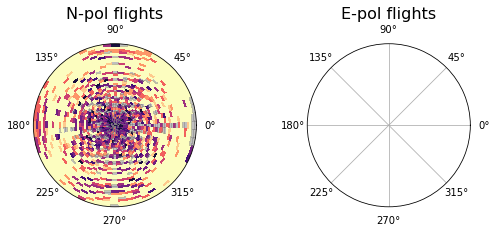

In [25]:
fig, axs = plt.subplots(1,2, subplot_kw=dict(projection="polar"),figsize=(9,3))

print(ptest.d0_edges_grid[0,:,chind])
print(ptest.d0_edges_grid.shape)
thingyd0 = np.ones([62,37,16])
thingyd1 = np.ones([62,37,16])
thingyd0[0:61,:,:] = ptest.d0_edges_grid
thingyd1[0:61,:,:] = ptest.d1_edges_grid

print(ptest.V_LC_operation_count.shape)
thingyV = np.ones([61,36])
thingyV[0:60,:] = ptest.V_LC_operation_count[:,:,0,chind]
thingyV[-1,:] = thingyV[0,:]

thingyd0[-1,:,:] = thingyd0[0,:,:]
thingyd1[-1,:,:] = thingyd1[0,:,:]

count_masked = np.ma.masked_less_equal(thingyV[:,:],leq).filled(fill_value=np.nan)

axs[0].pcolormesh(thingyd0[:,:,chind],thingyd1[:,:,chind],
            count_masked,cmap=ccm,vmin=vmi, vmax = vma)

axs[0].set_facecolor=['grey']
axs[0].set_yticks([])
axs[0].set_title('N-pol flights',fontsize=fsz)

axs[1].set_title('E-pol flights',fontsize=fsz)
axs[1].set_facecolor=['grey']
axs[1].set_yticks([])
#cbar=fig.colorbar(im,ax=axs,aspect=50)
#cbar.set_label('Counts',fontsize=fsz)

fig.show()

<ipython-input-8-ee5b55923819>:8: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("magma"))
  ccm.set_bad('grey',0.5)


(60, 36, 1, 16)


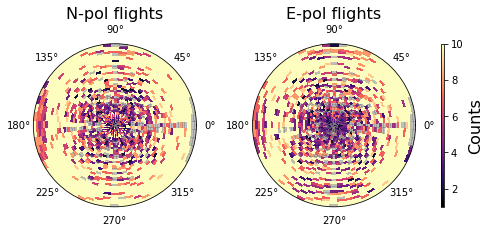

In [8]:
####################################################################################
############################# SECTION 3.6 ##########################################
############################# SECTION 3.6 ##########################################
####################################################################################


##### Total count plot at freq ind 900, inputs 0,1 ###
ccm.set_bad('grey',0.5)


find = 900
vmi = 1 # 0
vma = 10
leq = 1.0 # 5.0

fig, axs = plt.subplots(1,2, subplot_kw=dict(projection="polar"),figsize=(9,3))

# N pols first
copoldir = 'N'
pols = N_pols
chind = pols[0]

picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)
print(ptest.V_LC_operation_count.shape)


count_masked = np.ma.masked_less_equal(ptest.V_LC_operation_count[:,:,0,chind],leq).filled(fill_value=np.nan)

axs[0].pcolormesh(ptest.d0_edges_grid[:,:,chind],ptest.d1_edges_grid[:,:,chind],
            count_masked,cmap=ccm,vmin=vmi, vmax = vma)

axs[0].set_facecolor=['grey']
axs[0].set_yticks([])
axs[0].set_title('N-pol flights',fontsize=fsz)



copoldir = 'E'
pols = E_pols
chind = pols[0]

picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)

count_masked = np.ma.masked_less_equal(ptest.V_LC_operation_count[:,:,0,chind],leq).filled(fill_value=np.nan)
im = axs[1].pcolormesh(ptest.d0_edges_grid[:,:,chind],ptest.d1_edges_grid[:,:,chind],
            count_masked,cmap=ccm,vmin=vmi, vmax = vma)
axs[1].set_title('E-pol flights',fontsize=fsz)
axs[1].set_facecolor=['grey']
axs[1].set_yticks([])
cbar=fig.colorbar(im,ax=axs,aspect=50)
cbar.set_label('Counts',fontsize=fsz)

fig.show()



In [ ]:
## some plottting of the corrected amplitudes per flight -- not used in paper
''''
fig,axs = plt.subplots(5,1, sharex=True,sharey=True,figsize=(20,40))
for fly in ['618','619','625','646','647','533']:
    pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
    with open(pklfile, 'rb') as inp:
        pamps = pickle.load(inp) 
    mm = np.nanmedian(np.nanmedian(pamps[0,512:1024,N_pols],axis=-1),axis=-1)
    print('Median correction for flight '+fly+': ',str(mm))

    for j, chind in enumerate(N_pols):
        axs[j].plot(freqs,pamps[0,:,chind],label='flight '+str(fly))
        axs[j].set_xlim(400,600)
        axs[j].set_ylim(0.1,1.2)
        axs[j].set_xlabel('Frequency [MHz]')
        axs[j].set_ylabel('Median value')
        axs[j].legend()
        axs[j].set_title('Input: '+str(chind))
plt.show()

fig,axs = plt.subplots(5,1, sharex=True,sharey=True,figsize=(20,40))
for fly in ['620','648','649','535']:
    pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
    with open(pklfile, 'rb') as inp:
        pamps = pickle.load(inp) 
    mm = np.median(np.median(pamps[0,512:1024,E_pols],axis=-1),axis=-1)
    print('Median correction for flight '+fly+': ',str(mm)) 

    for j, chind in enumerate(E_pols):
        axs[j].plot(freqs,pamps[0,:,chind],label='flight '+str(fly))
        axs[j].set_xlim(400,600)
        axs[j].set_ylim(0.1,1.2)
        axs[j].set_xlabel('Frequency [MHz]')
        axs[j].set_ylabel('Median value')
        axs[j].legend()
        axs[j].set_title('Input: '+str(chind))
plt.show()
''''

In [ ]:
############################# SECTION 4 ############################################
############################# SECTION 4 ############################################
############################# SECTION 4 ############################################
############################# SECTION 4 ############################################
####################################################################################

In [ ]:
####################################################################################
############################# SECTION 4.1 ##########################################
############################# SECTION 4.1 ##########################################
####################################################################################

## Section 4.1 has a lot of plots, let's go in order ##

In [60]:
# Understand effect of not including the bicolog FWHM on the sidelobe brightness levels

fwhm = 50
sig = fwhm/2.355

pG = [1.,0.,fwhm/2.355,0.,fwhm/2.355,0.]
xes = np.arange(-40,40) # degrees
yes = np.zeros(len(xes))
fitd = fu.Gauss_2d_LC_func(pG,xes,yes)

plt.plot(xes,fitd,color='black',linestyle='-.')

xint = [12,24] # interesting x regions
for x in xint:
    x_use = int(x - xes[0])
    print('angle, suppression (lin), suppression (dB): ',x,1 - fitd[x_use],10*np.log10(fitd[x_use]))
    plt.axvline(xes[x_use])
plt.show()

0.33161255787892263

<ipython-input-61-d48bf741da81>:5: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("magma"))
  ccm.set_bad('grey',0.5)
<ipython-input-61-d48bf741da81>:34: RuntimeWarning: invalid value encountered in log10
  10*np.log10(ptest.V_LC_operation[:,:,0,chind]),cmap=ccm,vmin=-40,vmax=0)
<ipython-input-61-d48bf741da81>:55: RuntimeWarning: invalid value encountered in log10
  10*np.log10(ptest.V_LC_operation[:,:,0,chind]),cmap=ccm,vmin=-40,vmax=0)


[ 4.58366236 12.0321137  18.90760724 24.63718519 30.93972094]


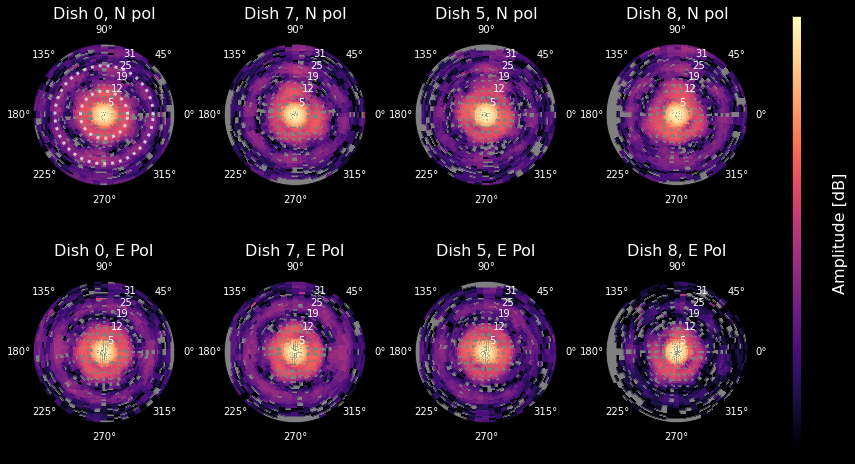

<ipython-input-61-d48bf741da81>:96: RuntimeWarning: invalid value encountered in log10
  10*np.log10(ptest.V_LC_operation[:,:,0,chind]),cmap=ccm,vmin=vmi,vmax=vma)
<ipython-input-61-d48bf741da81>:116: RuntimeWarning: invalid value encountered in log10
  10*np.log10(ptest.V_LC_operation[:,:,0,chind]),cmap=ccm,vmin=vmi,vmax=vma)


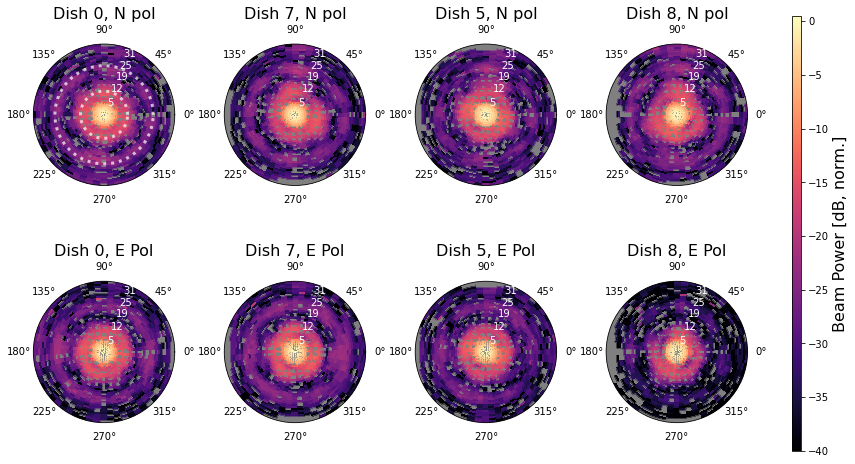

In [61]:
## ###################################
### Polar beam maps at freqind 900 ###
## ###################################

ccm.set_bad('grey',0.5)
find = 900


thetas = np.arange(0,2*np.pi,0.01)
phis1 = np.radians(12)*np.ones(len(thetas))
phis2 = np.radians(25)*np.ones(len(thetas))


vmi = -40
vma = 0.5
##### black background ########

fig, axs = plt.subplots(2, 4, subplot_kw=dict(projection="polar"),figsize=(16,8),facecolor='black')

r = (0.08,0.21,0.33,0.43,0.54)
rt = ('5','12','19','25','31')
print(np.degrees(r))

# N pols first
copoldir = 'N'
pols = N_pols

picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)

for i,chind in enumerate(N_pols):
    axs[0, i].pcolormesh(ptest.d0_edges_grid[:,:,chind],ptest.d1_edges_grid[:,:,chind],
                10*np.log10(ptest.V_LC_operation[:,:,0,chind]),cmap=ccm,vmin=-40,vmax=0)
    axs[0, i].set_title(dlab[chind],fontsize=fsz,color='white')
    axs[0,i].set_yticks([])
    axs[0,i].xaxis.label.set_color('white')   
    axs[0,i].tick_params(axis='x', colors='white')
    axs[0,i].tick_params(axis='y', colors='white')
    axs[0,i].set_facecolor('grey')
    for ri in np.arange(len(r)): 
        axs[0,i].text(np.pi/2.5,r[ri],rt[ri],color='white')
axs[0,0].plot(thetas,phis1,color='white',alpha=0.7,linestyle=':',linewidth=3)
axs[0,0].plot(thetas,phis2,color='white',alpha=0.7,linestyle=':',linewidth=3)

copoldir = 'E'
pols = E_pols

picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)

for i,chind in enumerate(E_pols):
    im = axs[1, i].pcolormesh(ptest.d0_edges_grid[:,:,chind],ptest.d1_edges_grid[:,:,chind],
                10*np.log10(ptest.V_LC_operation[:,:,0,chind]),cmap=ccm,vmin=-40,vmax=0)
    #axs[1, i].set_title('Input: '+str(chind),fontsize=fsz)
    axs[1, i].set_title(dlab[chind],fontsize=fsz,color='white')
    #axs[1,i].plot(thetas,phis1,color='white',alpha=0.6,linestyle='-.')
    #axs[1,i].plot(thetas,phis2,color='white',alpha=0.6,linestyle='-.')
    axs[1,i].set_yticks([])
    axs[1,i].xaxis.label.set_color('white')   
    axs[1,i].tick_params(axis='x', colors='white')
    axs[1,i].tick_params(axis='y', colors='white')
    axs[1, i].set_facecolor('grey')
    for ri in np.arange(len(r)): 
        axs[1,i].text(np.pi/2.5,r[ri],rt[ri],color='white')



#axs[1,0].plot((np.pi/4.0)*np.ones(len(r)),r,color='grey',marker=',',alpha=0.0)
#axs[1,0].set_rgrids(r, angle = 90)

#plt.tight_layout()
plt.subplots_adjust(wspace=0.35)
cbar=fig.colorbar(im,ax=axs,aspect=50)
cbar.set_label('Amplitude [dB]',fontsize=fsz,color='white')
plt.show()



##### white background ########


fig, axs = plt.subplots(2, 4, subplot_kw=dict(projection="polar"),figsize=(16,8))

# N pols first
copoldir = 'N'
pols = N_pols

picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)

for i,chind in enumerate(N_pols):
    axs[0,i].pcolormesh(ptest.d0_edges_grid[:,:,chind],ptest.d1_edges_grid[:,:,chind],
                10*np.log10(ptest.V_LC_operation[:,:,0,chind]),cmap=ccm,vmin=vmi,vmax=vma)
    axs[0,i].set_title(dlab[chind],fontsize=fsz)
    axs[0,i].set_yticks([])
    axs[0,i].xaxis.label.set_color('white')   
    axs[0,i].tick_params(axis='y', colors='white')
    axs[0,i].set_facecolor('grey')
    for ri in np.arange(len(r)): 
        axs[0,i].text(np.pi/2.5,r[ri],rt[ri],color='white')
axs[0,0].plot(thetas,phis1,color='white',alpha=0.7,linestyle=':',linewidth=3)
axs[0,0].plot(thetas,phis2,color='white',alpha=0.7,linestyle=':',linewidth=3)

copoldir = 'E'
pols = E_pols

picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)

for i,chind in enumerate(E_pols):
    im = axs[1,i].pcolormesh(ptest.d0_edges_grid[:,:,chind],ptest.d1_edges_grid[:,:,chind],
                10*np.log10(ptest.V_LC_operation[:,:,0,chind]),cmap=ccm,vmin=vmi,vmax=vma)
    axs[1,i].set_title(dlab[chind],fontsize=fsz)
    #axs[1,i].plot(thetas,phis1,color='white',alpha=0.6,linestyle='-.')
    #axs[1,i].plot(thetas,phis2,color='white',alpha=0.6,linestyle='-.')
    axs[1,i].set_yticks([])
    axs[1,i].xaxis.label.set_color('white')   
    axs[1,i].tick_params(axis='y', colors='white')
    axs[1,i].set_facecolor('grey')
    for ri in np.arange(len(r)): 
        axs[1,i].text(np.pi/2.5,r[ri],rt[ri],color='white')


#plt.tight_layout()
plt.subplots_adjust(wspace=0.35)
cbar=fig.colorbar(im,ax=axs,aspect=50)
cbar.set_label('Beam Power [dB, norm.]',fontsize=fsz)
plt.show()



# Checking if things are nan --- they are, not sure what the difference between
# facecolor and ccm.set is...

#chind = E_pols[0]
#plt.scatter(ptest.d0_centers_grid[:,:,chind],ptest.d1_centers_grid[:,:,chind],
#            c=10*np.log10(ptest.V_LC_operation[:,:,0,chind]))
#print('first ring')
#print(ptest.V_LC_operation[:,0,0,chind])
#print(np.isnan(ptest.V_LC_operation[:,0,0,chind]))
#print(10*np.log10(ptest.V_LC_operation[:,0,0,chind]))

#print('last ring')
#print(ptest.V_LC_operation[:,-1,0,chind])
#print(np.isnan(ptest.V_LC_operation[:,-1,0,chind]))
#print(10*np.log10(ptest.V_LC_operation[:,-1,0,chind]))

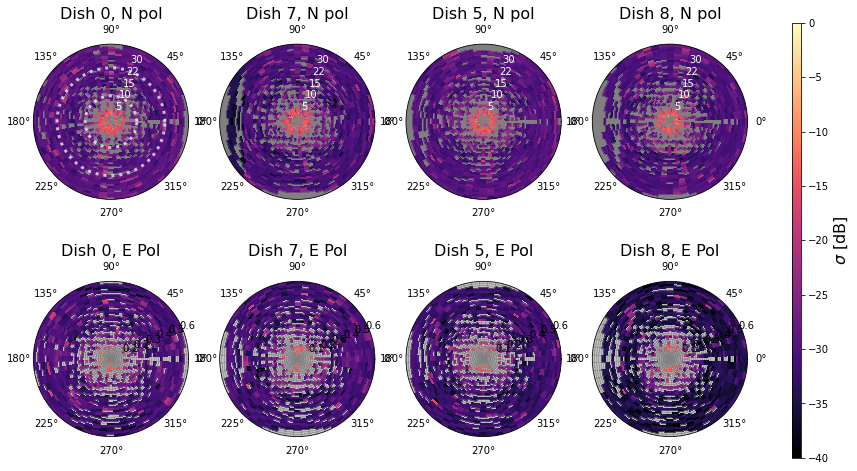

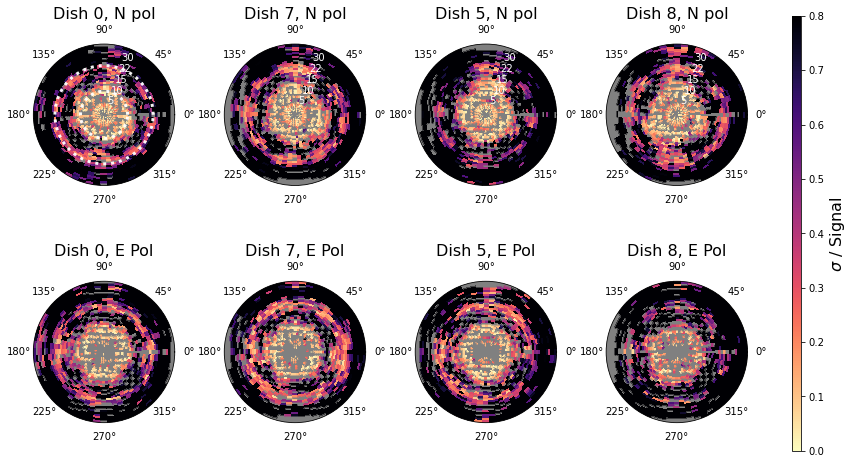

In [103]:
### Polar beam map - errors at freqind 900 ###

fig, axs = plt.subplots(2, 4, subplot_kw=dict(projection="polar"),figsize=(16,8))

# mask data with fewer than 5 points
leq = 5.0


# N pols first
copoldir = 'N'
pols = N_pols
find = 900

picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)

for i,chind in enumerate(N_pols):
    count_mask = np.ma.masked_less_equal(ptest.V_LC_operation_count[:,:,0,chind],leq).mask
    ptest_masked = np.ma.masked_where(count_mask,ptest.V_LC_operation_err[:,:,0,chind]).filled(np.nan)
    axs[0, i].pcolormesh(ptest.d0_edges_grid[:,:,chind],ptest.d1_edges_grid[:,:,chind],
                10*np.log10(ptest_masked),cmap=ccm,vmin=-40,vmax=0)
    
    axs[0,i].set_title(dlab[chind],fontsize=fsz)
    axs[0,i].set_yticks([])
    axs[0,i].xaxis.label.set_color('white')   
    axs[0,i].tick_params(axis='y', colors='white')
    axs[0,i].set_facecolor('grey')
    for ri in np.arange(len(r)): 
        axs[0,i].text(np.pi/2.5,r[ri],rt[ri],color='white')
axs[0,0].plot(thetas,phis1,color='white',alpha=0.7,linestyle=':',linewidth=3)
axs[0,0].plot(thetas,phis2,color='white',alpha=0.7,linestyle=':',linewidth=3)

copoldir = 'E'
pols = E_pols

picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)

for i,chind in enumerate(E_pols):
    count_mask = np.ma.masked_less_equal(ptest.V_LC_operation_count[:,:,0,chind],leq).mask
    ptest_masked = np.ma.masked_where(count_mask,ptest.V_LC_operation_err[:,:,0,chind]).filled(np.nan)
    im = axs[1, i].pcolormesh(ptest.d0_edges_grid[:,:,chind],ptest.d1_edges_grid[:,:,chind],
                10*np.log10(ptest_masked),cmap=ccm,vmin=-40,vmax=0)
    axs[1, i].set_title(dlab[chind],fontsize=fsz)
    #axs[1, i].colorbar()


cbar=fig.colorbar(im,ax=axs,aspect=50)
cbar.set_label(r'$\sigma$ [dB]',fontsize=fsz)
plt.show()




### Polar beam map - errors/signal at freqind 900 ###

vmi = 0
vma = 0.8

fig, axs = plt.subplots(2, 4, subplot_kw=dict(projection="polar"),figsize=(16,8))

# N pols first
copoldir = 'N'
pols = N_pols
find = 900

picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)


for i,chind in enumerate(N_pols):
    count_mask = np.ma.masked_less_equal(ptest.V_LC_operation_count[:,:,0,chind],leq).mask
    ratio = ptest.V_LC_operation_err[:,:,0,chind]/ptest.V_LC_operation[:,:,0,chind]
    ptest_masked = np.ma.masked_where(count_mask,ratio).filled(np.nan)
    axs[0, i].pcolormesh(ptest.d0_edges_grid[:,:,chind],ptest.d1_edges_grid[:,:,chind],
                np.abs(ptest_masked),cmap=ccm_r,
                        vmin=vmi,vmax=vma)
    axs[0, i].set_title(dlab[chind],fontsize=fsz)
    axs[0,i].set_facecolor('grey')
    axs[0,i].set_yticks([])
    axs[0,i].xaxis.label.set_color('white')   
    axs[0,i].tick_params(axis='y', colors='white')
    for ri in np.arange(len(r)): 
        axs[0,i].text(np.pi/2.5,r[ri],rt[ri],color='white')
axs[0,0].plot(thetas,phis1,color='white',alpha=0.95,linestyle=':',linewidth=3)
axs[0,0].plot(thetas,phis2,color='white',alpha=0.95,linestyle=':',linewidth=3)

copoldir = 'E'
pols = E_pols

picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)


for i,chind in enumerate(E_pols):
    count_mask = np.ma.masked_less_equal(ptest.V_LC_operation_count[:,:,0,chind],leq).mask
    ratio = ptest.V_LC_operation_err[:,:,0,chind]/ptest.V_LC_operation[:,:,0,chind]
    ptest_masked = np.ma.masked_where(count_mask,ratio).filled(np.nan)
    im = axs[1, i].pcolormesh(ptest.d0_edges_grid[:,:,chind],ptest.d1_edges_grid[:,:,chind],
                np.abs(ptest_masked),
                              vmin=vmi,vmax=vma,cmap=ccm_r)
    axs[1, i].set_title(dlab[chind],fontsize=fsz)
    axs[1,i].set_facecolor('grey')
    axs[1,i].set_yticks([])
    #axs[1, i].colorbar()

plt.subplots_adjust(wspace=0.35)
cbar=fig.colorbar(im,ax=axs,aspect=50)
cbar.set_label(r'$\sigma$ / Signal ',fontsize=fsz)
plt.show()





In [107]:
## print average sigma/signal, per input and then total average:

#### First, Main beam region ######

# What angle to use for main beam? 
coadded = np.load('/hirax/GBO_Analysis_Outputs/Coadded_2dGauss_and_Airy_Param_w_errs.npz')
tt=[]
for p, i in enumerate(N_pols):
    print(i,m_to_FWHM(coadded['G_popt'][i,find,2,0])+m_to_FWHM(coadded['G_popt'][i,find,4,0]))
    tt.append(0.5*(m_to_FWHM(coadded['G_popt'][i,find,2,0])+m_to_FWHM(coadded['G_popt'][i,find,4,0])))
print('FHWM angle: ',tt,np.mean(tt)/2)

# We'll use 7 degree FWHM, or 3.5 degree radius

# N pols first
copoldir = 'N'
find = 900
# region to compute stddev
mskin = 3.5

picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)

# get inner region, polar:
maskin = np.radians(mskin)
thingyr = np.ma.masked_inside(ptest.d1_centers_grid[:,:,0], 0, maskin, copy=True).mask
outermask = np.logical_not(thingyr)


rat = np.NAN*np.ones(16)
for i,chind in enumerate(N_pols):
    count_mask = np.ma.masked_less_equal(ptest.V_LC_operation_count[:,:,0,chind],leq).mask
    arrmask = np.logical_or(outermask,count_mask)
    err_wmask = np.ma.masked_where(arrmask, ptest.V_LC_operation_err[:,:,0,chind]).filled(np.nan)
    mean_wmask = np.ma.masked_where(arrmask, ptest.V_LC_operation[:,:,0,chind]).filled(np.nan)
    count_wmask = np.ma.masked_where(arrmask, ptest.V_LC_operation_count[:,:,0,chind]).filled(np.nan)
    rat[chind] = 100*np.nanmean(err_wmask/mean_wmask)
    #print(err_wmask[~np.isnan(err_wmask)],mean_wmask[~np.isnan(mean_wmask)])
    print('num non-zero pixels: ',chind,np.count_nonzero(~np.isnan(err_wmask/mean_wmask)),rat[chind])
    print('avg num of counts: ',chind,np.nanmean(count_wmask))

# E pols next
copoldir = 'E'

picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)

for i,chind in enumerate(E_pols):
    count_mask = np.ma.masked_less_equal(ptest.V_LC_operation_count[:,:,0,chind],leq).mask
    arrmask = np.logical_or(outermask,count_mask)
    err_wmask = np.ma.masked_where(arrmask, ptest.V_LC_operation_err[:,:,0,chind]).filled(np.nan)
    mean_wmask = np.ma.masked_where(arrmask, ptest.V_LC_operation[:,:,0,chind]).filled(np.nan)
    rat[chind] = 100*np.nanmean(err_wmask/mean_wmask)
    print(chind,np.count_nonzero(~np.isnan(err_wmask/mean_wmask)),rat[chind])
print('---- MAIN BEAM ----')
print('AVERAGE std/signal within FWHM: ',np.nanmean(rat))
print('AVERAGE std/signal within FWHM, E pols only: ',np.nanmean(rat[E_pols]))
print('AVERAGE std/signal within FWHM, N pols only: ',np.nanmean(rat[N_pols]))

#### Second, first sidelobe region (9-11 deg) ######


# N pols first
copoldir = 'N'
find = 900
# region to compute stddev
mskin = 9#4.5
mskout = 13#11#5.5

picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)

# get inner region, polar:
maskin = np.radians(mskin)
innermask = np.ma.masked_inside(ptest.d1_centers_grid[:,:,0], 0, maskin, copy=True).mask

maskout = np.radians(mskout)
thingy = np.ma.masked_inside(ptest.d1_centers_grid[:,:,0], 0, maskout, copy=True).mask
outermask = np.logical_not(thingy)

ann_mask = np.logical_or(innermask,outermask)

rat = np.NAN*np.ones(16)
for i,chind in enumerate(N_pols):
    count_mask = np.ma.masked_less_equal(ptest.V_LC_operation_count[:,:,0,chind],leq).mask
    arrmask = np.logical_or(ann_mask,count_mask)
    err_wmask = np.ma.masked_where(arrmask, ptest.V_LC_operation_err[:,:,0,chind]).filled(np.nan)
    mean_wmask = np.ma.masked_where(arrmask, ptest.V_LC_operation[:,:,0,chind]).filled(np.nan)
    rat[chind] = 100*np.nanmedian(err_wmask/mean_wmask)
    print(chind,np.count_nonzero(~np.isnan(err_wmask/mean_wmask)),rat[chind])


# E pols next
copoldir = 'E'

picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)

for i,chind in enumerate(E_pols):
    count_mask = np.ma.masked_less_equal(ptest.V_LC_operation_count[:,:,0,chind],leq).mask
    arrmask = np.logical_or(ann_mask,count_mask)
    err_wmask = np.ma.masked_where(arrmask, ptest.V_LC_operation_err[:,:,0,chind]).filled(np.nan)
    mean_wmask = np.ma.masked_where(arrmask, ptest.V_LC_operation[:,:,0,chind]).filled(np.nan)
    rat[chind] = 100*np.nanmean(err_wmask/mean_wmask)
    print(chind,np.count_nonzero(~np.isnan(err_wmask/mean_wmask)),rat[chind])
print('---- FIRST SIDELOBE ----')
print('AVERAGE std/signal: ',np.nanmean(rat))
print('AVERAGE std/signal, E pols only: ',np.nanmean(rat[E_pols]))
print('AVERAGE std/signal, N pols only: ',np.nanmean(rat[N_pols]))

#### Third, second sidelobe region (22-26 deg) ######


# N pols first
copoldir = 'N'
find = 900
# region to compute stddev
mskin = 22#11
mskout = 26#13

picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)

# get inner region, polar:
maskin = np.radians(mskin)
innermask = np.ma.masked_inside(ptest.d1_centers_grid[:,:,0], 0, maskin, copy=True).mask

maskout = np.radians(mskout)
thingy = np.ma.masked_inside(ptest.d1_centers_grid[:,:,0], 0, maskout, copy=True).mask
outermask = np.logical_not(thingy)

ann_mask = np.logical_or(innermask,outermask)

rat = np.NAN*np.ones(16)
for i,chind in enumerate(N_pols):
    count_mask = np.ma.masked_less_equal(ptest.V_LC_operation_count[:,:,0,chind],leq).mask
    arrmask = np.logical_or(ann_mask,count_mask)
    err_wmask = np.ma.masked_where(arrmask, ptest.V_LC_operation_err[:,:,0,chind]).filled(np.nan)
    mean_wmask = np.ma.masked_where(arrmask, ptest.V_LC_operation[:,:,0,chind]).filled(np.nan)
    rat[chind] = 100*np.nanmedian(err_wmask/mean_wmask)
    print(chind,np.count_nonzero(~np.isnan(err_wmask/mean_wmask)),rat[chind])


# E pols next
copoldir = 'E'

picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)

for i,chind in enumerate(E_pols):
    count_mask = np.ma.masked_less_equal(ptest.V_LC_operation_count[:,:,0,chind],leq).mask
    arrmask = np.logical_or(ann_mask,count_mask)
    err_wmask = np.ma.masked_where(arrmask, ptest.V_LC_operation_err[:,:,0,chind]).filled(np.nan)
    mean_wmask = np.ma.masked_where(arrmask, ptest.V_LC_operation[:,:,0,chind]).filled(np.nan)
    rat[chind] = 100*np.nanmean(err_wmask/mean_wmask)
    print(chind,np.count_nonzero(~np.isnan(err_wmask/mean_wmask)),rat[chind])
print('---- SECOND SIDELOBE ----')
print('AVERAGE std/signal: ',np.nanmean(rat))
print('AVERAGE std/signal, E pols only: ',np.nanmean(rat[E_pols]))
print('AVERAGE std/signal, N pols only: ',np.nanmean(rat[N_pols]))



1 14.665428935977577
3 14.611207563963305
11 15.608648664664585
15 14.174707076467172
FHWM angle:  [7.332714467988788, 7.305603781981652, 7.804324332332293, 7.087353538233586] 3.6912495150670397
num non-zero pixels:  1 53 7.296652094432472
avg num of counts:  1 7.509433962264151
num non-zero pixels:  3 50 6.811113526649732
avg num of counts:  3 7.6
num non-zero pixels:  11 43 6.546158573777666
avg num of counts:  11 7.744186046511628
num non-zero pixels:  15 46 8.34323155066816
avg num of counts:  15 7.304347826086956
0 4 9.631096062442031
2 8 9.444138706885955
10 3 11.993953646085
14 2 6.522115362592153
---- MAIN BEAM ----
AVERAGE std/signal within FWHM:  8.323557440441645
AVERAGE std/signal within FWHM, E pols only:  9.397825944501285
AVERAGE std/signal within FWHM, N pols only:  7.249288936382008
1 102 8.409799014654956
3 96 8.195473843631765
11 102 7.864451262707817
15 97 8.72391980859997
0 83 8.746605616590664
2 90 8.969728804042541
10 90 8.766241370238205
14 81 15.80430705725267


In [ ]:
## Slice plots of co-added beams, including error bars  --- Polar plots directly ####
## Exclude points with fewer than 5 counts inside from the error bars

colorz = pu.cm_to_discrete(ccm, 16)

aoff = 0.0#np.radians(6)
leq = 5.0



# set which pol:
copoldir = 'N'
pols = N_pols
chind = pols[0]

picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)

chind = pols[0]
col1,col2 = get_polar_slice(ptest.d0_centers_grid[:,:,chind],
                          ptest.d1_centers_grid[:,:,chind],0.0+aoff)

col1_90,col2_90 = get_polar_slice(ptest.d0_centers_grid[:,:,chind],
                          ptest.d1_centers_grid[:,:,chind],np.pi/2. + aoff)


fig,axs = plt.subplots(1,2, sharex=True,sharey=True,figsize=(16,4),squeeze=True)

for i,chind in enumerate(N_pols):  
    count_mask = np.ma.masked_less_equal(ptest.V_LC_operation_count[:,:,0,chind],leq).mask
    ratio = ptest.V_LC_operation_err[:,:,0,chind]
    ptest_masked = np.ma.masked_where(count_mask,ratio).filled(np.nan)
    
    axs[0].plot(np.degrees(ptest.d1_centers_grid[col1,:,chind]),
                    10*np.log10(ptest.V_LC_operation[col1,:,0,chind]),
                    marker='o',linestyle='None',
                 color=colorz[chind],label=dlab[chind])
    axs[0].plot(-1.0*np.degrees(ptest.d1_centers_grid[col2,:,chind]),
                    10*np.log10(ptest.V_LC_operation[col2,:,0,chind]),
                    marker='o',linestyle='None',
                     color=colorz[chind])
    if chind==N_pols[-1]:
        axs[0].plot(np.degrees(ptest.d1_centers_grid[col1,:,chind]),
                    10*np.log10(ptest_masked[col1,:]),marker='o',fillstyle='none',
                    linestyle='None',color=colorz[chind],label=r'$1 \sigma$')
        axs[0].plot(-1.0*np.degrees(ptest.d1_centers_grid[col2,:,chind]),
                    10*np.log10(ptest_masked[col2,:]),marker='o',fillstyle='none',
                    linestyle='None',color=colorz[chind])     
    else: 
        axs[0].plot(np.degrees(ptest.d1_centers_grid[col1,:,chind]),
                    10*np.log10(ptest_masked[col1,:]),marker='o',fillstyle='none',
                    linestyle='None',color=colorz[chind])
        axs[0].plot(-1.0*np.degrees(ptest.d1_centers_grid[col2,:,chind]),
                    10*np.log10(ptest_masked[col2,:]),marker='o',fillstyle='none',
                    linestyle='None',color=colorz[chind])
    

copoldir = 'E'
pols = E_pols
chind = pols[0]
picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)
    
for i,chind in enumerate(E_pols):
    
    count_mask = np.ma.masked_less_equal(ptest.V_LC_operation_count[:,:,0,chind],leq).mask
    ratio = ptest.V_LC_operation_err[:,:,0,chind]
    ptest_masked = np.ma.masked_where(count_mask,ratio).filled(np.nan)
    
    axs[1].plot(np.degrees(ptest.d1_centers_grid[col1,:,chind]),
                    10*np.log10(ptest.V_LC_operation[col1,:,0,chind]),
                    marker='o',linestyle='None',
                    color=colorz[chind],label=dlab[chind])
    axs[1].plot(-1.0*np.degrees(ptest.d1_centers_grid[col2,:,chind]),
                    10*np.log10(ptest.V_LC_operation[col2,:,0,chind]),
                    marker='o',linestyle='None',
                     color=colorz[chind])
    if chind == E_pols[-1]:
        axs[1].plot(np.degrees(ptest.d1_centers_grid[col1,:,chind]),
                    10*np.log10(ptest_masked[col1,:]), marker='o',fillstyle='none',
                    linestyle='None',color=colorz[chind],label=r'$1 \sigma$')
        axs[1].plot(-1.0*np.degrees(ptest.d1_centers_grid[col2,:,chind]),
                    10*np.log10(ptest_masked[col2,:]),marker='o',fillstyle='none',
                     linestyle='None',color=colorz[chind])
    else:
        axs[1].plot(np.degrees(ptest.d1_centers_grid[col1,:,chind]),
                    10*np.log10(ptest_masked[col1,:]), marker='o',fillstyle='none',
                    linestyle='None',color=colorz[chind])
        axs[1].plot(-1.0*np.degrees(ptest.d1_centers_grid[col2,:,chind]),
                    10*np.log10(ptest_masked[col2,:]),marker='o',fillstyle='none',
                     linestyle='None',color=colorz[chind])
    
axs[0].set_xlabel(r'$\Phi$ [degrees]',fontsize=fsz)
axs[1].set_xlabel(r'$\Phi$ [degrees]',fontsize=fsz)
axs[0].set_ylabel('Beam Power [dB, norm]',fontsize=fsz)
#axs[1].set_ylabel('Amplitude',fontsize=fsz)
axs[0].legend(loc='upper left',borderpad=0.01,frameon=False,fontsize=fsz)
axs[1].legend(loc='upper left',borderpad=0.01,frameon=False,fontsize=fsz)
axs[0].text(25,-4,'N pols',fontsize=fsz)
axs[0].text(25,-7,r'$\theta=0$',fontsize=fsz)
axs[1].text(25,-4,'E pols',fontsize=fsz)
axs[1].text(25,-7,r'$\theta=0$',fontsize=fsz)
axs[0].set_xlim(-35,35)
axs[0].set_ylim(-40,0)
plt.tight_layout()
plt.show()



#### Other slice

# set which pol:
copoldir = 'N'
pols = N_pols
chind = pols[0]

picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)

chind = pols[0]
col1,col2 = get_polar_slice(ptest.d0_centers_grid[:,:,chind],
                          ptest.d1_centers_grid[:,:,chind],0.0+aoff)

col1_90,col2_90 = get_polar_slice(ptest.d0_centers_grid[:,:,chind],
                          ptest.d1_centers_grid[:,:,chind],np.pi/2. + aoff)


fig,axs = plt.subplots(1,2, sharex=True,sharey=True,figsize=(16,4),squeeze=True)

for i,chind in enumerate(N_pols):  
    count_mask = np.ma.masked_less_equal(ptest.V_LC_operation_count[:,:,0,chind],leq).mask
    ratio = ptest.V_LC_operation_err[:,:,0,chind]
    ptest_masked = np.ma.masked_where(count_mask,ratio).filled(np.nan)
    
    axs[0].plot(np.degrees(ptest.d1_centers_grid[col1_90,:,chind]),
                    10*np.log10(ptest.V_LC_operation[col1_90,:,0,chind]),
                    marker='o',linestyle='None',
                 color=colorz[chind],label=dlab[chind])
    axs[0].plot(-1.0*np.degrees(ptest.d1_centers_grid[col2_90,:,chind]),
                    10*np.log10(ptest.V_LC_operation[col2_90,:,0,chind]),
                    marker='o',linestyle='None',
                     color=colorz[chind])
    axs[0].plot(np.degrees(ptest.d1_centers_grid[col1_90,:,chind]),
                    10*np.log10(ptest_masked[col1_90,:]), marker='o',fillstyle='none',
                    linestyle='None',color=colorz[chind])
    axs[0].plot(-1.0*np.degrees(ptest.d1_centers_grid[col2_90,:,chind]),
                    10*np.log10(ptest_masked[col2_90,:]),marker='o',fillstyle='none',
                     linestyle='None',color=colorz[chind])
        
axs[0].plot(np.degrees(ptest.d1_centers_grid[col1_90,:,0]),
                    10*np.log10(ptest_masked[col1_90,:]), marker='o',fillstyle='none',
                    linestyle='None',color=colorz[0],label=r'$1 \sigma$')

    

copoldir = 'E'
pols = E_pols
chind = pols[0]
picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)
    
for i,chind in enumerate(E_pols):
    
    count_mask = np.ma.masked_less_equal(ptest.V_LC_operation_count[:,:,0,chind],leq).mask
    ratio = ptest.V_LC_operation_err[:,:,0,chind]
    ptest_masked = np.ma.masked_where(count_mask,ratio).filled(np.nan)
    
    axs[1].plot(np.degrees(ptest.d1_centers_grid[col1_90,:,chind]),
                    10*np.log10(ptest.V_LC_operation[col1_90,:,0,chind]),
                    marker='o',linestyle='None',
                    color=colorz[chind],label=dlab[chind])
    axs[1].plot(-1.0*np.degrees(ptest.d1_centers_grid[col2_90,:,chind]),
                    10*np.log10(ptest.V_LC_operation[col2_90,:,0,chind]),
                    marker='o',linestyle='None',
                     color=colorz[chind])
    axs[1].plot(np.degrees(ptest.d1_centers_grid[col1_90,:,chind]),
                    10*np.log10(ptest_masked[col1_90,:]), marker='o',fillstyle='none',
                    linestyle='None',color=colorz[chind])
    axs[1].plot(-1.0*np.degrees(ptest.d1_centers_grid[col2_90,:,chind]),
                    10*np.log10(ptest_masked[col2_90,:]),marker='o',fillstyle='none',
                     linestyle='None',color=colorz[chind])
        
axs[1].plot(np.degrees(ptest.d1_centers_grid[col1_90,:,0]),
                    10*np.log10(ptest_masked[col1_90,:]), marker='o',fillstyle='none',
                    linestyle='None',color=colorz[0],label=r'$1 \sigma$')

    
axs[0].set_xlabel(r'$\Phi$ [degrees]',fontsize=fsz)
axs[1].set_xlabel(r'$\Phi$ [degrees]',fontsize=fsz)
axs[0].set_ylabel('Beam power [dB, norm.]',fontsize=fsz)
#axs[1].set_ylabel('Amplitude',fontsize=fsz)
axs[0].legend(loc='upper left',bbox_to_anchor=(-0.01, 1.0),borderpad=0.01,frameon=False,handletextpad=0.1,fontsize=fsz)
axs[1].legend(loc='upper left',bbox_to_anchor=(-0.01, 1.0),borderpad=0.01,frameon=False,handletextpad=0.1,fontsize=fsz)
#axs[0].text(25,-4,'N pols',fontsize=fsz)
axs[0].text(27,-3,r'$\theta=90$',fontsize=fsz)
#axs[1].text(25,-4,'E pols',fontsize=fsz)
axs[1].text(27,-3,r'$\theta=90$',fontsize=fsz)
axs[0].set_xlim(-35,35)
axs[0].set_ylim(-40,0)

# add regions for computations
ht='/'
ci = 4
cl = 4

axs[0].grid()
axs[0].axvspan(-3.5,3.5,color=colorz[ci],alpha=0.1,hatch=ht)
axs[0].axvspan(-13,-9,color=colorz[ci],alpha=0.1,hatch=ht)
axs[0].axvspan(9,13,color=colorz[ci],alpha=0.1,hatch=ht)
axs[0].axvspan(-26,-22,color=colorz[ci],alpha=0.1,hatch=ht)
axs[0].axvspan(22,26,color=colorz[ci],alpha=0.1,hatch=ht)
axs[0].axvline(-12,color=colorz[cl],linestyle='--')
axs[0].axvline(12,color=colorz[cl],linestyle='--')
axs[0].axvline(-25,color=colorz[cl],linestyle='--')
axs[0].axvline(25,color=colorz[cl],linestyle='--')


axs[1].grid()
axs[1].axvspan(-3.5,3.5,color=colorz[ci],alpha=0.1,hatch=ht)
axs[1].axvspan(-13,-9,color=colorz[ci],alpha=0.1,hatch=ht)
axs[1].axvspan(9,13,color=colorz[ci],alpha=0.1,hatch=ht)
axs[1].axvspan(-26,-22,color=colorz[ci],alpha=0.1,hatch=ht)
axs[1].axvspan(22,26,color=colorz[ci],alpha=0.1,hatch=ht)
axs[1].axvline(-12,color=colorz[cl],linestyle='--')
axs[1].axvline(12,color=colorz[cl],linestyle='--')
axs[1].axvline(-25,color=colorz[cl],linestyle='--')
axs[1].axvline(25,color=colorz[cl],linestyle='--')


plt.tight_layout()
plt.show()






In [ ]:
### slice vs frequency (this takes a little while since I read in all pickles) ### 

fig, axs = plt.subplots(2, 3,figsize=(16,8),sharex=True,sharey=True)
whichang = [0.0, np.pi/4.0, np.pi/2.0]
vm = -35 
# set which pol:
copoldir = 'N'
pols = N_pols
chind = pols[0]

for find in good_freqs:
    picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
    with open(picklefile, 'rb') as inp:
        ptest = pickle.load(inp)
    f = freqs[find]
    for a,arad in enumerate(whichang):
        col1,col2 = get_polar_slice(ptest.d0_centers_grid[:,:,chind],
                          ptest.d1_centers_grid[:,:,chind],arad)
        axs[0,a].scatter(np.degrees(ptest.d1_centers_grid[col1,:,chind]),
                f*np.ones(len(ptest.d1_centers_grid[col1,:,chind])),
                c=10*np.log10(abs(ptest.V_LC_operation[col1,:,0,chind])),vmin=vm,vmax=0,cmap=ccm)
        axs[0,a].scatter(np.degrees(-1.0*ptest.d1_centers_grid[col2,:,chind]),
                f*np.ones(len(ptest.d1_centers_grid[col1,:,chind])),
                c=10*np.log10(abs(ptest.V_LC_operation[col2,:,0,chind])),vmin=vm,vmax=0,cmap=ccm)
        axs[0,a].set_title('$\Theta = $'+str(np.round(np.degrees(arad)))+'$^{\circ}$',fontsize=fsz)
        
        
copoldir = 'E'
pols = E_pols
chind = pols[0]

for find in good_freqs:
    picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
    with open(picklefile, 'rb') as inp:
        ptest = pickle.load(inp)
    f = freqs[find]
    for a,arad in enumerate(whichang):
        col1,col2 = get_polar_slice(ptest.d0_centers_grid[:,:,chind],
                          ptest.d1_centers_grid[:,:,chind],arad)
        axs[1,a].scatter(np.degrees(ptest.d1_centers_grid[col1,:,chind]),
                f*np.ones(len(ptest.d1_centers_grid[col1,:,chind])),
                c=10*np.log10(abs(ptest.V_LC_operation[col1,:,0,chind])),vmin=vm,vmax=0,cmap=ccm)
        im = axs[1,a].scatter(np.degrees(-1.0*ptest.d1_centers_grid[col2,:,chind]),
                f*np.ones(len(ptest.d1_centers_grid[col1,:,chind])),
                c=10*np.log10(abs(ptest.V_LC_operation[col2,:,0,chind])),vmin=vm,vmax=0,cmap=ccm)
        axs[1,a].set_xlabel('$\phi$ [Degrees]',fontsize=fsz)
        
axs[0,0].set_ylabel('Frequency [MHz]',fontsize=fsz)
axs[1,0].set_ylabel('Frequency [MHz]',fontsize=fsz)
axs[0,0].text(-33,577,'Input 0',color='white',fontsize=20,fontweight='bold')
axs[1,0].text(-33,577,'Input 1',color='white',fontsize=20,fontweight='bold')

cbar=fig.colorbar(im,ax=axs,aspect=50)
cbar.set_label('Beam Power [dB, norm.]',fontsize=fsz)
plt.show()
 

##### PCOLORMESH version #######


### slice vs frequency (this takes a little while since I read in all pickles) ### 

#fig, axs = plt.subplots(2, 3,figsize=(16,8),sharex=True,sharey=True)
whichang = [0.0, np.pi/4.0, np.pi/2.0]
vm = -35 



# Need to make an array for pcolormesh (X, Y, V)
# X[gridf,gridd]
# Y[gridf,gridd]
# V[gridf,gridd]

V_0  = np.zeros([1024,2*36,3])
V_1  = np.zeros([1024,2*36,3])
Xes = np.zeros([2*36,3])


# set which pol:
copoldir = 'N'
pols = N_pols
chind = pols[0]

for find in good_freqs:
    picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
    with open(picklefile, 'rb') as inp:
        ptest = pickle.load(inp)
    f = freqs[find]
    
    for a,arad in enumerate(whichang):
        col1,col2 = get_polar_slice(ptest.d0_centers_grid[:,:,chind],
                          ptest.d1_centers_grid[:,:,chind],arad)
        V_0[find,0:36,a] = ptest.V_LC_operation[col2,:,0,chind][::-1]
        V_0[find,36:72,a] = ptest.V_LC_operation[col1,:,0,chind]
        Xes[0:36,a] = np.degrees(-1.0*ptest.d1_centers_grid[col2,:,chind])[::-1]
        Xes[36:72,a] = np.degrees(ptest.d1_centers_grid[col1,:,chind])
        
copoldir = 'E'
pols = E_pols
chind = pols[0]

for find in good_freqs:
    picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
    with open(picklefile, 'rb') as inp:
        ptest = pickle.load(inp)
    f = freqs[find]
    
    for a,arad in enumerate(whichang):
        col1,col2 = get_polar_slice(ptest.d0_centers_grid[:,:,chind],
                          ptest.d1_centers_grid[:,:,chind],arad)
        V_1[find,0:36,a] = ptest.V_LC_operation[col2,:,0,chind][::-1]
        V_1[find,36:72,a] = ptest.V_LC_operation[col1,:,0,chind]
        

X, Y = np.meshgrid(Xes[:,0],freqs)
plt.pcolormesh(X,Y,10*np.log10(np.abs(V_0[:,:,0])),vmin=1,vmax=-40)
plt.ylim(400,600)
plt.colorbar()
plt.show()

# 2, 5, 6
vm = -40
colorz = pu.cm_to_discrete(ccm, 11)
ccm.set_bad(colorz[2],0.15)
fig, axs = plt.subplots(2, 3,figsize=(16,8),sharex=True,sharey=True)

for a,arad in enumerate(whichang):
    axs[0,a].pcolormesh(X,Y,10*np.log10(np.abs(V_0[:,:,a])),vmin=vm,vmax=0,cmap=ccm,
                       )
    axs[0,a].set_title('$\Theta = $'+str(np.round(np.degrees(arad)))+'$^{\circ}$',fontsize=fsz)
for a,arad in enumerate(whichang):
    im = axs[1,a].pcolormesh(X,Y,10*np.log10(np.abs(V_1[:,:,a])),vmin=vm,vmax=0,cmap=ccm)
    axs[1,a].set_xlabel('$\phi$ [Degrees]',fontsize=fsz)
        
axs[0,0].set_ylabel('Frequency [MHz]',fontsize=fsz)
axs[1,0].set_ylabel('Frequency [MHz]',fontsize=fsz)
axs[0,0].text(-33,557,'Dish 0, N pol',color='white',fontsize=20,fontweight='bold')
axs[1,0].text(-33,557,'Dish 0, E pol',color='white',fontsize=20,fontweight='bold')
axs[0,0].set_ylim(430,600)

cbar=fig.colorbar(im,ax=axs,aspect=50)
cbar.set_label('Beam Power [dB, norm]',fontsize=fsz)
plt.show()




In [ ]:
####### LEAST SQUARES FITTING OF ALL COADDED MAPS #####
####### Only need to run this once!!!! ####
###
###
###print(good_freqs)
#pG=np.array([1.0,0.0,9.0,0.0,9.0,1E-4])
#fittingParamsWErrors = np.zeros([16, 1024,6,2])
#restr = 18 # 30 #39 # 50 was default
##
### set which pol:
#copoldir = 'N'
#pols = N_pols
##
#for f,find in enumerate(good_freqs):#
#
#    picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
#    with open(picklefile, 'rb') as inp:
#        ptest = pickle.load(inp)#
#       
#    for j, chind in enumerate(pols):        
#        mbx = ptest.d0_centers_grid[:,:,chind].flatten()
#        mby = ptest.d1_centers_grid[:,:,chind].flatten()
#        mbV = ptest.V_LC_operation[:,:,0,chind].flatten()
#
##        gi = np.where((np.isfinite(mbV)) & (np.abs(mbx) < restr) & (np.abs(mby) < restr))[0]
#        gi = np.where(np.isfinite(mbV))[0]
#        input_data=np.array([mbx[gi],mby[gi],mbV[gi]])
#        G_popt = least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data)
#        fitParams = G_popt.x
#        J = G_popt.jac    
#        errmat = np.linalg.inv(J.T @ J) * (G_popt.fun.T @ G_popt.fun / (G_popt.fun.size - G_popt.x.size))
#        param_errors = 1.95*np.sqrt(np.diag(errmat)) # This gives 95% confidence level
#        fittingParamsWErrors[chind, find, :, 0] = fitParams
#        fittingParamsWErrors[chind, find, :, 1] = param_errors

#copoldir = 'E'
#pols = E_pols

#for f,find in enumerate(good_freqs):#

#    picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
#    with open(picklefile, 'rb') as inp:
#        ptest = pickle.load(inp)#

#    for j, chind in enumerate(pols): 
#        mbx = ptest.d0_centers_grid[:,:,chind].flatten()
#        mby = ptest.d1_centers_grid[:,:,chind].flatten()
#        mbV = ptest.V_LC_operation[:,:,0,chind].flatten()
#
##        gi = np.where((np.isfinite(mbV)) & (np.abs(mbx) < restr) & (np.abs(mby) < restr))[0]
#        gi = np.where(np.isfinite(mbV))[0]
#        input_data=np.array([mbx[gi],mby[gi],mbV[gi]])
#        G_popt = least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data)
#        fitParams = G_popt.x
#        J = G_popt.jac    
#        errmat = np.linalg.inv(J.T @ J) * (G_popt.fun.T @ G_popt.fun / (G_popt.fun.size - G_popt.x.size))
#        param_errors = 1.95*np.sqrt(np.diag(errmat)) # This gives 95% confidence level
#        fittingParamsWErrors[chind, find, :, 0] = fitParams
#        fittingParamsWErrors[chind, find, :, 1] = param_errors
        
#tmpfitpath='/hirax/GBO_Analysis_Outputs/Coadded_2dGauss_and_Airy_Param_w_errs.npz'
#np.savez(tmpfitpath,G_popt = fittingParamsWErrors)

#############################################################################
####### LEAST SQUARES FITTING OF ALL COADDED MAPS - WITH THETA TERM #####
####### Only need to run this once!!!! ####
###
###

#pG=np.array([1.0,0.0,9.0,0.0,9.0,1E-4,0.0])
#bnds = ((-np.inf, -np.inf,0, -np.inf,0, -np.inf,-np.pi/4.),
#                        (np.inf, np.inf,np.inf, np.inf,np.inf, np.inf,np.pi/4.))
#fittingParamsWErrors = np.zeros([16, 1024,7,2])
#restr = 18 # 30 #39 # 50 was default
##
### set which pol:
#copoldir = 'N'
#pols = N_pols
##
#for f,find in enumerate(good_freqs):
#    picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
#    with open(picklefile, 'rb') as inp:
#        ptest = pickle.load(inp)#
#       
#    for j, chind in enumerate(pols):        
#        mbx = ptest.d0_centers_grid[:,:,chind].flatten()
#        mby = ptest.d1_centers_grid[:,:,chind].flatten()
#        mbV = ptest.V_LC_operation[:,:,0,chind].flatten()
#
##        gi = np.where((np.isfinite(mbV)) & (np.abs(mbx) < restr) & (np.abs(mby) < restr))[0]
#        gi = np.where(np.isfinite(mbV))[0]
#        input_data=np.array([mbx[gi],mby[gi],mbV[gi]])
#        G_popt = least_squares(fu.Gauss_2d_LC_opt_wtheta,x0=pG,bounds=bnds,method='trf',args=input_data)
#        fitParams = G_popt.x
#        J = G_popt.jac    
#        errmat = np.linalg.inv(J.T @ J) * (G_popt.fun.T @ G_popt.fun / (G_popt.fun.size - G_popt.x.size))
#        param_errors = 1.95*np.sqrt(np.diag(errmat)) # This gives 95% confidence level
#        fittingParamsWErrors[chind, find, :, 0] = fitParams
#        fittingParamsWErrors[chind, find, :, 1] = param_errors
#
#copoldir = 'E'
#pols = E_pols
#
#for f,find in enumerate(good_freqs):#
#    picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
#    with open(picklefile, 'rb') as inp:
#        ptest = pickle.load(inp)#

#    for j, chind in enumerate(pols): 
#        mbx = ptest.d0_centers_grid[:,:,chind].flatten()
#        mby = ptest.d1_centers_grid[:,:,chind].flatten()
#        mbV = ptest.V_LC_operation[:,:,0,chind].flatten()

##        gi = np.where((np.isfinite(mbV)) & (np.abs(mbx) < restr) & (np.abs(mby) < restr))[0]
#        gi = np.where(np.isfinite(mbV))[0]
#        input_data=np.array([mbx[gi],mby[gi],mbV[gi]])
#        G_popt = least_squares(fu.Gauss_2d_LC_opt_wtheta,x0=pG,bounds=bnds,method='trf',args=input_data)
#        fitParams = G_popt.x
#        J = G_popt.jac    
#        errmat = np.linalg.inv(J.T @ J) * (G_popt.fun.T @ G_popt.fun / (G_popt.fun.size - G_popt.x.size))
#        param_errors = 1.95*np.sqrt(np.diag(errmat)) # This gives 95% confidence level
#        fittingParamsWErrors[chind, find, :, 0] = fitParams
#        fittingParamsWErrors[chind, find, :, 1] = param_errors
        
#tmpfitpath='/hirax/GBO_Analysis_Outputs/Coadded_2dGauss_and_Airy_Param_w_errs_wtheta.npz'
#np.savez(tmpfitpath,G_popt = fittingParamsWErrors)

9.934230864343544 0.03610279538000313


IndexError: list index out of range

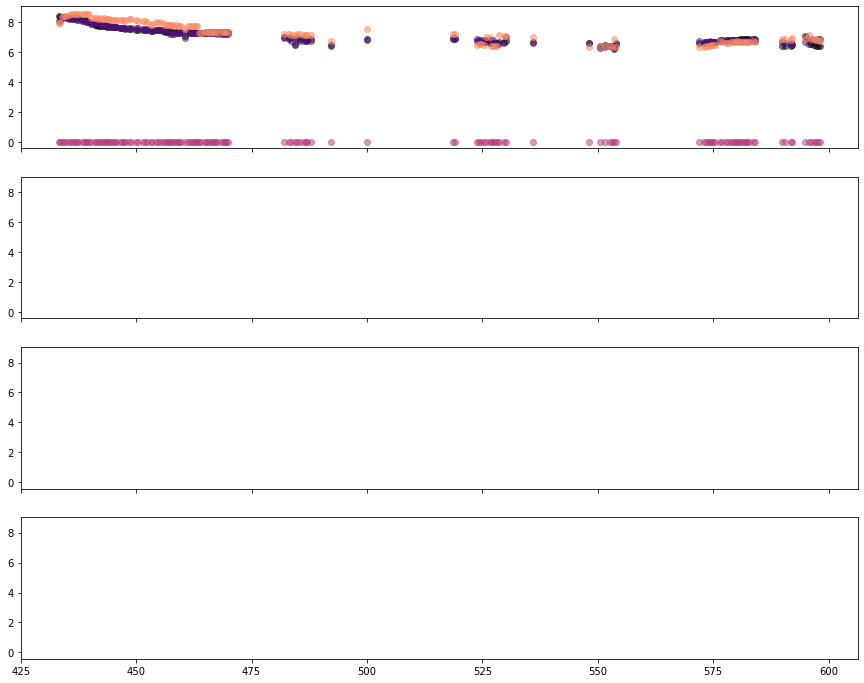

In [55]:
####### Investigate errors from not including theta terms #####

# concluded it was about +/- 0.2 degrees, use this as error bar in final plot

coadded_wt = np.load('/hirax/GBO_Analysis_Outputs/Coadded_2dGauss_and_Airy_Param_w_errs_wtheta.npz')
print(coadded['G_popt'][1,900,2,0],coadded['G_popt'][1,900,2,1])

## Plot just the gaussian FWHM and errors, each pol and direction gets a panel ##
colorz=pu.cm_to_discrete(ccm, 4)
fig,axes = plt.subplots(4, 1, sharex=True,sharey=True,figsize=(15,12))
for p, i in enumerate(N_pols):
    ys = m_to_FWHM(coadded_wt['G_popt'][i,good_freqs,2,0])
    yerrs = m_to_FWHM(coadded_wt['G_popt'][i,good_freqs,2,1])
    axes[0].errorbar(freqs[good_freqs],ys,yerr=yerrs,color=colorz[p],
                linestyle='None',marker='o',alpha = 0.5,label='Input '+str(i))
for p,i in enumerate(E_pols):
    ys = m_to_FWHM(coadded_wt['G_popt'][i,good_freqs,2,0])
    yerrs = m_to_FWHM(coadded_wt['G_popt'][i,good_freqs,2,1])
    axes[2].errorbar(freqs[good_freqs],ys,yerr=yerrs,color=colorz[p],
                linestyle='None',marker='o',alpha = 0.5,label='Input '+str(i))

    
for p,i in enumerate(N_pols):
    ys = m_to_FWHM(coadded_wt['G_popt'][i,good_freqs,4,0])
    yerrs = m_to_FWHM(coadded_wt['G_popt'][i,good_freqs,4,1])
    axes[1].errorbar(freqs[good_freqs],ys,yerr=yerrs,color=colorz[p],
                    linestyle='None',marker='o',alpha = 0.5,label='Input '+str(i))
for p,i in enumerate(E_pols):
    ys = m_to_FWHM(coadded_wt['G_popt'][i,good_freqs,4,0])
    yerrs = m_to_FWHM(coadded_wt['G_popt'][i,good_freqs,4,1])
    axes[3].errorbar(freqs[good_freqs],ys,yerr=yerrs,color=colorz[p],
                    linestyle='None',marker='o',alpha = 0.5,label='Input '+str(i))

ff = np.arange(400,600)
dl = get_diffrac(ff)
axes[0].plot(ff,dl,linestyle='-.',color='black',label='Diffraction limit')
axes[1].plot(ff,dl,linestyle='-.',color='black',label='Diffraction limit')
axes[2].plot(ff,dl,linestyle='-.',color='black',label='Diffraction limit')
axes[3].plot(ff,dl,linestyle='-.',color='black',label='Diffraction limit')
axes[0].set_ylabel('FWHM [deg]', fontsize=fsz)
axes[0].text(402,8,'E/W (N pols)', fontsize=fsz)
axes[0].set_ylim(4.5,8.5)
axes[0].set_xlim(400,600)
axes[0].legend(fontsize = 12, ncol=8, markerscale=1,loc='lower left')
axes[2].set_ylabel('FWHM [deg]', fontsize=fsz)
axes[2].text(402,8,'E/W (E pols)',fontsize=fsz)
axes[2].legend(fontsize = 12, ncol=8, markerscale=1,loc='lower left')
axes[1].set_ylabel('FWHM [deg]', fontsize=fsz)
axes[1].text(402,8,'N/S (N pols)', fontsize=fsz)
axes[3].set_ylabel('FWHM [deg]', fontsize=fsz)
axes[3].set_xlabel('Frequency [MHz]', fontsize=fsz)
axes[3].text(402,8,'N/S (E pols)',fontsize=fsz)
axes[1].legend(fontsize = 12, ncol=8, markerscale=1,loc='lower left')
axes[3].legend(fontsize = 12, ncol=8, markerscale=1,loc='lower left')
plt.show()


## Plot just the theta angles ##
colorz=pu.cm_to_discrete(ccm, 4)
fig,axes = plt.subplots(2, 1, sharex=True,sharey=True,figsize=(15,12))
for p, i in enumerate(N_pols):
    ys = np.degrees(coadded_wt['G_popt'][i,good_freqs,6,0])
    yerrs = np.degrees(coadded_wt['G_popt'][i,good_freqs,6,1])
    #axes[0].plot(freqs[good_freqs],ys,color=colorz[i],
    #            linestyle='None',marker='o',alpha = 0.3,label='Input '+str(i))
    axes[0].errorbar(freqs[good_freqs],ys,yerr=yerrs,color=colorz[p],
                linestyle='None',marker='o',alpha = 0.5,label='Input '+str(i))
for p,i in enumerate(E_pols):
    ys = np.degrees(coadded_wt['G_popt'][i,good_freqs,6,0])
    yerrs = np.degrees(coadded_wt['G_popt'][i,good_freqs,6,1])
    #axes[2].plot(freqs[good_freqs],ys,color=colorz[i],
    #            linestyle='None',marker='o',alpha = 0.3,label='Input '+str(i))
    axes[1].errorbar(freqs[good_freqs],ys,yerr=yerrs,color=colorz[p],
                linestyle='None',marker='o',alpha = 0.5,label='Input '+str(i))

axes[0].set_ylim(-50,50)
axes[0].set_ylabel('Theta [deg]')
axes[1].set_ylabel('Theta [deg]')
plt.show()



## plot differences in FWHM between including theta and not ####

colorz=pu.cm_to_discrete(ccm, 4)
fig,axes = plt.subplots(4, 1, sharex=True,sharey=True,figsize=(15,12))
for p, i in enumerate(N_pols):
    ys = m_to_FWHM(coadded_wt['G_popt'][i,good_freqs,2,0])-m_to_FWHM(coadded['G_popt'][i,good_freqs,2,0])
    yerrs = m_to_FWHM(coadded_wt['G_popt'][i,good_freqs,2,1])
    axes[0].errorbar(freqs[good_freqs],ys,yerr=yerrs,color=colorz[p],
                linestyle='None',marker='o',alpha = 0.5,label='Input '+str(i))
for p,i in enumerate(E_pols):
    ys = m_to_FWHM(coadded_wt['G_popt'][i,good_freqs,2,0])-m_to_FWHM(coadded['G_popt'][i,good_freqs,2,0])
    yerrs = m_to_FWHM(coadded_wt['G_popt'][i,good_freqs,2,1])
    axes[2].errorbar(freqs[good_freqs],ys,yerr=yerrs,color=colorz[p],
                linestyle='None',marker='o',alpha = 0.5,label='Input '+str(i))

    
for p,i in enumerate(N_pols):
    ys = m_to_FWHM(coadded_wt['G_popt'][i,good_freqs,4,0])-m_to_FWHM(coadded['G_popt'][i,good_freqs,4,0])
    yerrs = m_to_FWHM(coadded_wt['G_popt'][i,good_freqs,4,1])
    axes[1].errorbar(freqs[good_freqs],ys,yerr=yerrs,color=colorz[p],
                    linestyle='None',marker='o',alpha = 0.5,label='Input '+str(i))
for p,i in enumerate(E_pols):
    ys = m_to_FWHM(coadded_wt['G_popt'][i,good_freqs,4,0])-m_to_FWHM(coadded['G_popt'][i,good_freqs,4,0])
    yerrs = m_to_FWHM(coadded_wt['G_popt'][i,good_freqs,4,1])
    axes[3].errorbar(freqs[good_freqs],ys,yerr=yerrs,color=colorz[p],
                    linestyle='None',marker='o',alpha = 0.5,label='Input '+str(i))
    
axes[0].set_ylim(-0.5,0.5)
axes[0].set_xlim(400,600)

axes[1].legend(fontsize = 12, ncol=8, markerscale=1,loc='lower left')
axes[3].legend(fontsize = 12, ncol=8, markerscale=1,loc='lower left')
axes[2].set_ylabel('diff (with theta - no theta) FWHM [deg]', fontsize=fsz)
plt.show()


## Plot theta vs difference ##
colorz=pu.cm_to_discrete(ccm, 4)
fig,axes = plt.subplots(4, 1, sharex=True,sharey=True,figsize=(15,12))
for p, i in enumerate(N_pols):
    ys = m_to_FWHM(coadded_wt['G_popt'][i,good_freqs,2,0])-m_to_FWHM(coadded['G_popt'][i,good_freqs,2,0])
    ths = np.degrees(coadded_wt['G_popt'][i,good_freqs,6,0])
    yerrs = m_to_FWHM(coadded_wt['G_popt'][i,good_freqs,2,1])
    axes[0].errorbar(ths,ys,yerr=yerrs,color=colorz[p],
                linestyle='None',marker='o',alpha = 0.5,label='Input '+str(i))
for p,i in enumerate(E_pols):
    ys = m_to_FWHM(coadded_wt['G_popt'][i,good_freqs,2,0])-m_to_FWHM(coadded['G_popt'][i,good_freqs,2,0])
    ths = np.degrees(coadded_wt['G_popt'][i,good_freqs,6,0])
    yerrs = m_to_FWHM(coadded_wt['G_popt'][i,good_freqs,2,1])
    axes[2].errorbar(ths,ys,yerr=yerrs,color=colorz[p],
                linestyle='None',marker='o',alpha = 0.5,label='Input '+str(i))

    
for p,i in enumerate(N_pols):
    ys = m_to_FWHM(coadded_wt['G_popt'][i,good_freqs,4,0])-m_to_FWHM(coadded['G_popt'][i,good_freqs,4,0])
    ths = np.degrees(coadded_wt['G_popt'][i,good_freqs,6,0])
    yerrs = m_to_FWHM(coadded_wt['G_popt'][i,good_freqs,4,1])
    axes[1].errorbar(ths,ys,yerr=yerrs,color=colorz[p],
                    linestyle='None',marker='o',alpha = 0.5,label='Input '+str(i))
for p,i in enumerate(E_pols):
    ys = m_to_FWHM(coadded_wt['G_popt'][i,good_freqs,4,0])-m_to_FWHM(coadded['G_popt'][i,good_freqs,4,0])
    ths = np.degrees(coadded_wt['G_popt'][i,good_freqs,6,0])
    yerrs = m_to_FWHM(coadded_wt['G_popt'][i,good_freqs,4,1])
    axes[3].errorbar(ths,ys,yerr=yerrs,color=colorz[p],
                    linestyle='None',marker='o',alpha = 0.5,label='Input '+str(i))
    

axes[0].set_ylim(-0.5,0.5)
axes[0].set_xlim(-40,40)

axes[1].legend(fontsize = 12, ncol=8, markerscale=1,loc='lower left')
axes[3].legend(fontsize = 12, ncol=8, markerscale=1,loc='lower left')
axes[2].set_ylabel('diff (with theta - no theta) FWHM [deg]', fontsize=fsz)
axes[3].set_xlabel('Theta [deg]')

plt.show()



9.934230864343544 0.03610279538000313


IndexError: list index out of range

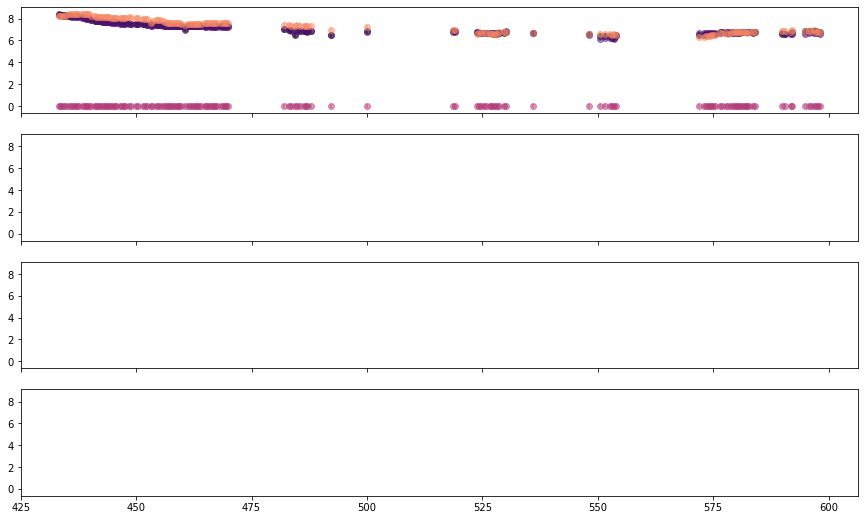

In [56]:
## Plot FWHMS for Coadded beam maps ####

coadded = np.load('/hirax/GBO_Analysis_Outputs/Coadded_2dGauss_and_Airy_Param_w_errs.npz')
print(coadded['G_popt'][1,900,2,0],coadded['G_popt'][1,900,2,1])

## Plot just the gaussian fit values and errors, each pol and direction gets a panel ##
colorz=pu.cm_to_discrete(ccm, 4)
fig,axes = plt.subplots(4, 1, sharex=True,sharey=True,figsize=(15,9)) #15,12 was original size
for p, i in enumerate(N_pols):
    ys = m_to_FWHM(coadded['G_popt'][i,good_freqs,2,0])
    yerrs = 0.2*np.ones(coadded['G_popt'][i,good_freqs,2,1].shape)#m_to_FWHM(coadded['G_popt'][i,good_freqs,2,1])
    #axes[0].plot(freqs[good_freqs],ys,color=colorz[i],
    #            linestyle='None',marker='o',alpha = 0.3,label='Input '+str(i))
    axes[0].errorbar(freqs[good_freqs],ys,yerr=yerrs,color=colorz[p],
                linestyle='None',marker='o',alpha = 0.5,label=dlab[i])
for p,i in enumerate(E_pols):
    ys = m_to_FWHM(coadded['G_popt'][i,good_freqs,2,0])
    yerrs = 0.2*np.ones(coadded['G_popt'][i,good_freqs,2,1].shape)#m_to_FWHM(coadded['G_popt'][i,good_freqs,2,1])
    #axes[2].plot(freqs[good_freqs],ys,color=colorz[i],
    #            linestyle='None',marker='o',alpha = 0.3,label='Input '+str(i))
    axes[2].errorbar(freqs[good_freqs],ys,yerr=yerrs,color=colorz[p],
                linestyle='None',marker='o',alpha = 0.5,label=dlab[i])

    
for p,i in enumerate(N_pols):
    ys = m_to_FWHM(coadded['G_popt'][i,good_freqs,4,0])
    yerrs = 0.2*np.ones(coadded['G_popt'][i,good_freqs,2,1].shape)#m_to_FWHM(coadded['G_popt'][i,good_freqs,4,1])
    #axes[1].plot(freqs[good_freqs],ys,color=colorz[i],
    #                linestyle='None',marker='o',alpha = 0.3,label='Input '+str(i))
    axes[1].errorbar(freqs[good_freqs],ys,yerr=yerrs,color=colorz[p],
                    linestyle='None',marker='o',alpha = 0.5,label=dlab[i])
for p,i in enumerate(E_pols):
    ys = m_to_FWHM(coadded['G_popt'][i,good_freqs,4,0])
    yerrs = 0.2*np.ones(coadded['G_popt'][i,good_freqs,2,1].shape)#m_to_FWHM(coadded['G_popt'][i,good_freqs,4,1])
    #axes[3].plot(freqs[good_freqs],ys,color=colorz[i],
    #                linestyle='None',marker='o',alpha = 0.3,label='Input '+str(i))
    axes[3].errorbar(freqs[good_freqs],ys,yerr=yerrs,color=colorz[p],
                    linestyle='None',marker='o',alpha = 0.5,label=dlab[i])
    


ff = np.arange(400,600)
dl = get_diffrac(ff)
axes[0].plot(ff,dl,linestyle='-.',color='black',label='Diffraction limit')
axes[1].plot(ff,dl,linestyle='-.',color='black',label='Diffraction limit')
axes[2].plot(ff,dl,linestyle='-.',color='black',label='Diffraction limit')
axes[3].plot(ff,dl,linestyle='-.',color='black',label='Diffraction limit')

xloct = 432
yloct = 5.9
axes[0].set_ylabel('FWHM [deg]', fontsize=fsz)
axes[0].text(xloct,yloct,'E/W (N pols)', fontsize=fsz)
axes[0].set_ylim(4.5,8.5)
axes[0].set_xlim(430,600)
axes[0].legend(fontsize = 12, ncol=8, markerscale=1,loc='lower left')
axes[2].set_ylabel('FWHM [deg]', fontsize=fsz)
axes[2].text(xloct,yloct,'E/W (E pols)',fontsize=fsz)
axes[2].legend(fontsize = 12, ncol=8, markerscale=1,loc='lower left')
axes[1].set_ylabel('FWHM [deg]', fontsize=fsz)
axes[1].text(xloct,yloct,'N/S (N pols)', fontsize=fsz)
axes[3].set_ylabel('FWHM [deg]', fontsize=fsz)
axes[3].set_xlabel('Frequency [MHz]', fontsize=fsz)
axes[3].text(xloct,yloct,'N/S (E pols)',fontsize=fsz)
axes[1].legend(fontsize = 12, ncol=8, markerscale=1,loc='lower left')
axes[3].legend(fontsize = 12, ncol=8, markerscale=1,loc='lower left')



plt.show()


## Plot with Pranav data as well (not sure how old)

# pranav
fwhm_pra = np.load('/hirax/GBO_Analysis_Outputs/fwhm_pranav.npz') # fwhm, freq
print(fwhm_pra['fwhm'].shape)
print(fwhm_pra['freq'].shape)

colorz=pu.cm_to_discrete(ccm, 7)

fig,axes = plt.subplots(4, 1, sharex=True,sharey=True,figsize=(15,12))
for p, i in enumerate(N_pols):
    ys = m_to_FWHM(coadded['G_popt'][i,good_freqs,2,0])
    yerrs = 0.2*np.ones(coadded['G_popt'][i,good_freqs,2,1].shape)#m_to_FWHM(coadded['G_popt'][i,good_freqs,2,1])
    #axes[0].plot(freqs[good_freqs],ys,color=colorz[i],
    #            linestyle='None',marker='o',alpha = 0.3,label='Input '+str(i))
    axes[0].errorbar(freqs[good_freqs],ys,yerr=yerrs,color=colorz[p],
                linestyle='None',marker='o',alpha = 0.5,label='Input '+str(i))
for p,i in enumerate(E_pols):
    ys = m_to_FWHM(coadded['G_popt'][i,good_freqs,2,0])
    yerrs = 0.2*np.ones(coadded['G_popt'][i,good_freqs,2,1].shape)#m_to_FWHM(coadded['G_popt'][i,good_freqs,2,1])
    #axes[2].plot(freqs[good_freqs],ys,color=colorz[i],
    #            linestyle='None',marker='o',alpha = 0.3,label='Input '+str(i))
    axes[2].errorbar(freqs[good_freqs],ys,yerr=yerrs,color=colorz[p],
                linestyle='None',marker='o',alpha = 0.5,label='Input '+str(i))

    
for p,i in enumerate(N_pols):
    ys = m_to_FWHM(coadded['G_popt'][i,good_freqs,4,0])
    yerrs = 0.2*np.ones(coadded['G_popt'][i,good_freqs,2,1].shape)#m_to_FWHM(coadded['G_popt'][i,good_freqs,4,1])
    #axes[1].plot(freqs[good_freqs],ys,color=colorz[i],
    #                linestyle='None',marker='o',alpha = 0.3,label='Input '+str(i))
    axes[1].errorbar(freqs[good_freqs],ys,yerr=yerrs,color=colorz[p],
                    linestyle='None',marker='o',alpha = 0.5,label='Input '+str(i))
for p,i in enumerate(E_pols):
    ys = m_to_FWHM(coadded['G_popt'][i,good_freqs,4,0])
    yerrs = 0.2*np.ones(coadded['G_popt'][i,good_freqs,2,1].shape)#m_to_FWHM(coadded['G_popt'][i,good_freqs,4,1])
    #axes[3].plot(freqs[good_freqs],ys,color=colorz[i],
    #                linestyle='None',marker='o',alpha = 0.3,label='Input '+str(i))
    axes[3].errorbar(freqs[good_freqs],ys,yerr=yerrs,color=colorz[p],
                    linestyle='None',marker='o',alpha = 0.5,label='Input '+str(i))
    

axes[0].plot(fwhm_pra['freq'],np.sqrt(2)*fwhm_pra['fwhm'][0,:],marker='+',linestyle='None',color=colorz[5],label='Pranav pol?')
axes[0].plot(fwhm_pra['freq'],np.sqrt(2)*fwhm_pra['fwhm'][1,:],marker='x',linestyle='None',color=colorz[6],label='Pranav pol?')
axes[1].plot(fwhm_pra['freq'],np.sqrt(2)*fwhm_pra['fwhm'][0,:],marker='+',linestyle='None',color=colorz[5],label='Pranav pol?')
axes[1].plot(fwhm_pra['freq'],np.sqrt(2)*fwhm_pra['fwhm'][1,:],marker='x',linestyle='None',color=colorz[6],label='Pranav pol?')
axes[2].plot(fwhm_pra['freq'],np.sqrt(2)*fwhm_pra['fwhm'][0,:],marker='+',linestyle='None',color=colorz[5],label='Pranav pol?')
axes[2].plot(fwhm_pra['freq'],np.sqrt(2)*fwhm_pra['fwhm'][1,:],marker='x',linestyle='None',color=colorz[6],label='Pranav pol?')
axes[3].plot(fwhm_pra['freq'],np.sqrt(2)*fwhm_pra['fwhm'][0,:],marker='+',linestyle='None',color=colorz[5],label='Pranav pol?')
axes[3].plot(fwhm_pra['freq'],np.sqrt(2)*fwhm_pra['fwhm'][1,:],marker='x',linestyle='None',color=colorz[6],label='Pranav pol?')

ff = np.arange(400,600)
dl = get_diffrac(ff)
axes[0].plot(ff,dl,linestyle='-.',color='black',label='Diffraction limit')
axes[1].plot(ff,dl,linestyle='-.',color='black',label='Diffraction limit')
axes[2].plot(ff,dl,linestyle='-.',color='black',label='Diffraction limit')
axes[3].plot(ff,dl,linestyle='-.',color='black',label='Diffraction limit')


axes[0].set_ylabel('FWHM [deg]', fontsize=fsz)
axes[0].text(402,8,'E/W (N pols)', fontsize=fsz)
axes[0].set_ylim(4.5,8.5)
axes[0].set_xlim(400,600)
axes[0].legend(fontsize = 12, ncol=8, markerscale=1,loc='lower left')
axes[2].set_ylabel('FWHM [deg]', fontsize=fsz)
axes[2].text(402,8,'E/W (E pols)',fontsize=fsz)
axes[2].legend(fontsize = 12, ncol=8, markerscale=1,loc='lower left')
axes[1].set_ylabel('FWHM [deg]', fontsize=fsz)
axes[1].text(402,8,'N/S (N pols)', fontsize=fsz)
axes[3].set_ylabel('FWHM [deg]', fontsize=fsz)
axes[3].set_xlabel('Frequency [MHz]', fontsize=fsz)
axes[3].text(402,8,'N/S (E pols)',fontsize=fsz)
axes[1].legend(fontsize = 12, ncol=8, markerscale=1,loc='lower left')
axes[3].legend(fontsize = 12, ncol=8, markerscale=1,loc='lower left')



plt.show()


<ipython-input-11-a0baffaaf4e4>:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("magma"))
  ccm.set_bad('white')
<ipython-input-11-a0baffaaf4e4>:36: RuntimeWarning: invalid value encountered in log10
  10*np.log10(ptest.V_LC_operation[:,:,0,chind]),cmap=ccm,vmin=-40,vmax=0)
<ipython-input-11-a0baffaaf4e4>:53: RuntimeWarning: invalid value encountered in log10
  10*np.log10(ptest.V_LC_operation[:,:,0,chind]),cmap=ccm,vmin=-40,vmax=0)
<ipython-input-11-a0baffaaf4e4>:53: RuntimeWarning: divide by zero encountered in log10
  10*np.log10(ptest.V_LC_operation[:,:,0,chind]),cmap=ccm,vmin=-40,vmax=0)


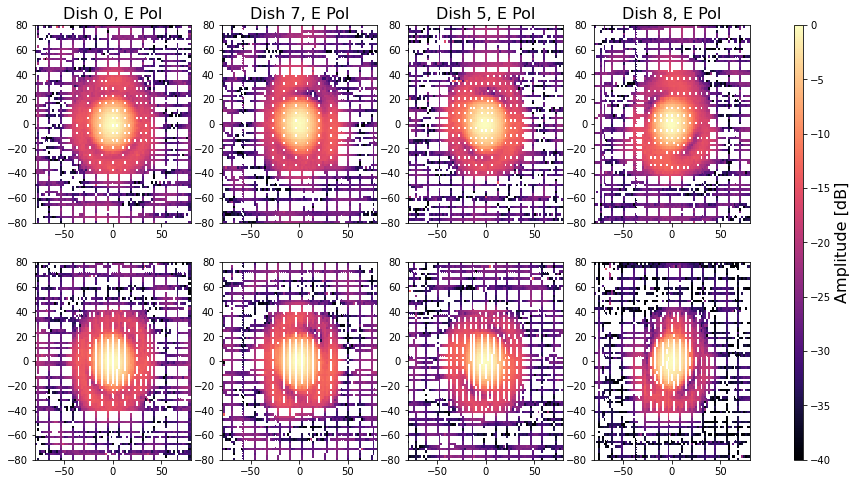

Angle:  19.500000000000004 Avg std/sig:  0.9741067738955231
Angle:  20.5 Avg std/sig:  -1.929377089494091
Angle:  21.5 Avg std/sig:  2.6907283371589212
Angle:  22.5 Avg std/sig:  0.47442940604250017
Angle:  23.5 Avg std/sig:  0.7455940416018567
Angle:  24.500000000000004 Avg std/sig:  0.5255367692320807
Angle:  25.5 Avg std/sig:  0.7092860939497376
Angle:  26.500000000000004 Avg std/sig:  -4.629650938292898
Angle:  27.5 Avg std/sig:  2.012355529502994


In [11]:
## Some cartesian plotting, look at angles of 'dips'

ccm.set_bad('white')

### Cartesian beam maps at freqind 900 ###

dd = 55
r = np.arange(-50,50)
thetas = np.ones(len(r))*np.radians(dd)

xes1 = r*np.cos(thetas)
yes1 = r*np.sin(thetas)

dd = -45
r = np.arange(-50,50)
thetas = np.ones(len(r))*np.radians(dd)

xes2 = r*np.cos(thetas)
yes2 = r*np.sin(thetas)


fig, axs = plt.subplots(2, 4,figsize=(16,8))

# N pols first
copoldir = 'N'
pols = N_pols
find = 900

picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)


for i,chind in enumerate(N_pols):
    axs[0,i].pcolormesh(ptest.d0_edges_grid[:,:,chind],ptest.d1_edges_grid[:,:,chind],
                10*np.log10(ptest.V_LC_operation[:,:,0,chind]),cmap=ccm,vmin=-40,vmax=0)
    axs[0,i].set_title(dlab[chind],fontsize=fsz)
    #axs[0,i].plot(xes1,yes1,color='white')
    #axs[0,i].plot(xes2,yes2,color='yellow')
    #axs[0,i].plot(thetas,phis1,color='white',alpha=0.6,linestyle='-.')
    #axs[0,i].plot(thetas,phis2,color='white',alpha=0.6,linestyle='-.')

copoldir = 'E'
pols = E_pols

picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)


for i,chind in enumerate(E_pols):
    im = axs[1, i].pcolormesh(ptest.d0_edges_grid[:,:,chind],ptest.d1_edges_grid[:,:,chind],
                10*np.log10(ptest.V_LC_operation[:,:,0,chind]),cmap=ccm,vmin=-40,vmax=0)
    axs[0,i].set_title(dlab[chind],fontsize=fsz)
    #axs[1,i].plot(xes1,yes1,color='white')
    #axs[1,i].plot(xes2,yes2,color='yellow')
    #axs[1,i].plot(thetas,phis1,color='white',alpha=0.6,linestyle='-.')
    #axs[1,i].plot(thetas,phis2,color='white',alpha=0.6,linestyle='-.')



cbar=fig.colorbar(im,ax=axs,aspect=50)
cbar.set_label('Amplitude [dB]',fontsize=fsz)
plt.show()


# print values at some particular theta value

tt = ptest.d0_centers_grid[:,:,0]
pp = ptest.d1_centers_grid[:,:,0]

#sl = get_polar_slice(tt,pp,val=np.radians(12),direction='t')
#print(sl, np.degrees(tt[sl[0],:]),np.degrees(pp[sl[0],:]))

sl = get_polar_slice(tt,pp,val=np.radians(12),direction='p')
#print(sl, np.degrees(tt[:,sl[0]]),np.degrees(pp[:,sl[0]]))


# Get estimates for the sigma/value for different annulus regions
# For first sidelobe, printed phis between 8 - 17
# for second sidelobe, printed phis 20-29

rat = np.NAN*np.ones([17,9])

# N pols first
copoldir = 'N'
find = 900

picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)

tt = ptest.d0_centers_grid[:,:,0]
pp = ptest.d1_centers_grid[:,:,0]

for iv,vv in enumerate(np.arange(20,29)):
    sl = get_polar_slice(tt,pp,val=np.radians(vv),direction='p')
    rat[16,iv] = np.degrees(pp[0,sl[0]])

    for i,chind in enumerate(N_pols):

        rat[chind,iv] = np.nanmean(ptest.V_LC_operation_err[:,sl[0],0,chind]/
                                   ptest.V_LC_operation[:,sl[0],0,chind])
        #print('channel: ', chind, 'AngleL ',rat[16,iv], 'avg: ',rat[chind,iv])

copoldir = 'E'
picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)

for iv,vv in enumerate(np.arange(20,29)):
    sl = get_polar_slice(tt,pp,val=np.radians(vv),direction='p')
    rat[16,iv] = np.degrees(pp[0,sl[0]])

    for i,chind in enumerate(E_pols):

        rat[chind,iv] = np.nanmean(ptest.V_LC_operation_err[:,sl[0],0,chind]/
                                   ptest.V_LC_operation[:,sl[0],0,chind])
        #print('channel: ', chind, 'AngleL ',rat[16,iv], 'avg: ',rat[chind,iv])

        
for iv,vv in enumerate(np.arange(8,17)):
    print('Angle: ',rat[16,iv],'Avg std/sig: ',np.nanmean(rat[0:16,iv]))


In [8]:
####################################################################################
############################# SECTION 4.2 ##########################################
############################# SECTION 4.2 ##########################################
####################################################################################

# Comparison to sims

def find_indx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return(idx)

def cstreader(file):
    data = open(file).readlines()[2::]
    theta = []
    phi = []
    gainTheta = []
    gainPhi = []
    for row in data:
        theta.append(float(row.rsplit()[0]))
        phi.append(float(row.rsplit()[1]))
        gainTheta.append(float(row.rsplit()[3]))
        gainPhi.append(float(row.rsplit()[5]))
    df = pd.DataFrame({'theta':theta, 'phi':phi, 'gain(theta)':gainTheta, 'gain(phi)':gainPhi})
    return(df)

def Theta_0(df):
    df1 = df.truncate(before=find_indx(df['phi'], 0), after=find_indx(df['phi'], 1)-1)
    return(df1)
def Theta_90(df):
    df1 = df.truncate(before=find_indx(df['phi'], -90), after=find_indx(df['phi'], -89)-1)
    return(df1)

def Theta_angle(df, angle):
    df1 = df.truncate(before=find_indx(df['phi'], angle), after=find_indx(df['phi'], angle+1)-1)
    return(df1)

class cst_beam_sims:
    def __init__(self, file):
        df = cstreader(file)
        self.vars = variables(df)
    def plot_CoPol(self):
        plot(self.vars.e_co[0], lintodb(self.vars.e_co[1]), label = 'E co')
        plot(self.vars.h_co[0], lintodb(self.vars.h_co[1]), label = 'H co')
    def plot_Crp(self):
        plot(self.vars.e_crp[0], lintodb(self.vars.e_crp[1]), label = 'E crp')
        plot(self.vars.h_crp[0], lintodb(self.vars.h_crp[1]), label = 'H crp')
    def plot_Hco(self):
        plot(self.vars.h_co[0], lintodb(self.vars.h_co[1]), label = 'H co')
    def plot_Eco(self):
        plot(self.vars.e_co[0], lintodb(self.vars.e_co[1]), label = 'E co')
        
class variables:
    def __init__(self, df):
        #seems mised up but also seems to work?
        
        self.e_co = [Theta_90(df)['theta'], Theta_90(df)['gain(phi)']]
        self.e_crp = [Theta_90(df)['theta'], Theta_90(df)['gain(theta)']]
        self.h_co = [Theta_0(df)['theta'], Theta_0(df)['gain(phi)']]
        self.h_crp = [Theta_0(df)['theta'], Theta_0(df)['gain(theta)']]

        self.e_co_angle, self.e_co_gain = self.e_co[0], self.e_co[1]
        self.e_crp_angle, self.e_crp_gain = self.e_crp[0], self.e_crp[1]
        self.h_co_angle, self.h_co_gain = self.h_co[0], self.h_co[1]
        self.h_crp_angle, self.h_crp_gain = self.h_crp[0], self.h_crp[1]
        

def get_ffs(find):
    if find==896: fset = [895,896,892]
    elif find == 768: fset = [768,788]
    elif find == 639: fset = [639,636,645]
    elif find == 517: fset = [517,518,519]
    return fset
        
# read in sims data - make a sims array of that data

dfs_sims = {}
for freq in np.arange(400,850,50):
    dfs_sims[freq] = {}
    simfile = '/hirax/cst/hirax_gbo_v1_legs/Export/Farfield/farfield_(f='\
            +str(freq/1e3)+')_[1].txt'
    
    df = cstreader(simfile)
    indicesofinterest = [i for i in range(len(df['theta'])) if -90<df['theta'][i]<90]
    r = np.sqrt(df['gain(theta)'][indicesofinterest]**2+df['gain(phi)'][indicesofinterest]**2)
    r1 = df['gain(theta)'][indicesofinterest]
    r2 = df['gain(phi)'][indicesofinterest]
    x = np.cos(np.deg2rad(df['phi'][indicesofinterest]))*np.sin(np.deg2rad(df['theta'][indicesofinterest]))
    y = np.sin(np.deg2rad(df['phi'][indicesofinterest]))*np.sin(np.deg2rad(df['theta'][indicesofinterest]))

    dfs_sims[freq]['oneD'] = cst_beam_sims(simfile)
    dfs_sims[freq]['df'] = df
    dfs_sims[freq]['mag'] = [r,r2,r1]
    dfs_sims[freq]['position'] = [np.rad2deg(x),np.rad2deg(y)] #says x and y but is still in degrees


Freqs:  450 450.0
SIM, X width:  6.7388329569482845 Y width:  7.719266259816694
Calculated:  1 X width:  7.37361134190633 Y width:  7.125583839741585
From Cartesian  1 X width:  7.491343742766687 Y width:  7.10243022105204
Calculated:  3 X width:  7.57864184341499 Y width:  7.144942853562009
From Cartesian  3 X width:  7.51513233912081 Y width:  7.129789640407691


<ipython-input-9-3b482552dd33>:66: RuntimeWarning: invalid value encountered in log10
  axs.plot(xd_flat[cc],10*np.log10(dzpos_flat[cc]),color=colorz[chind],marker='.',linestyle='None')
<ipython-input-9-3b482552dd33>:66: RuntimeWarning: invalid value encountered in log10
  axs.plot(xd_flat[cc],10*np.log10(dzpos_flat[cc]),color=colorz[chind],marker='.',linestyle='None')
<ipython-input-9-3b482552dd33>:66: RuntimeWarning: invalid value encountered in log10
  axs.plot(xd_flat[cc],10*np.log10(dzpos_flat[cc]),color=colorz[chind],marker='.',linestyle='None')
<ipython-input-9-3b482552dd33>:66: RuntimeWarning: invalid value encountered in log10
  axs.plot(xd_flat[cc],10*np.log10(dzpos_flat[cc]),color=colorz[chind],marker='.',linestyle='None')


Calculated:  11 X width:  7.808323357710864 Y width:  7.4838331610122335
From Cartesian  11 X width:  8.034099110641034 Y width:  7.43561221979902
Calculated:  15 X width:  7.15258804711774 Y width:  7.0079797191040365
From Cartesian  15 X width:  7.101108496053756 Y width:  7.02613352884362


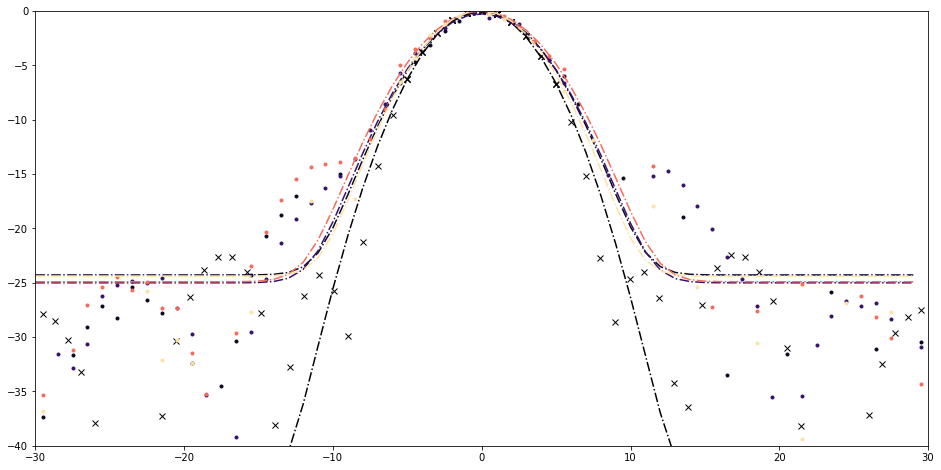

Freqs:  500 500.0
SIM, X width:  6.160759609642246 Y width:  6.574161769583983
Calculated:  1 X width:  6.784026575256233 Y width:  6.8118573851500726
From Cartesian  1 X width:  6.891195369344027 Y width:  6.821358594132389
Calculated:  3 X width:  6.7682976732424045 Y width:  6.678885212495827
From Cartesian  3 X width:  6.773807980766602 Y width:  6.653806390149049
Calculated:  11 X width:  7.125520546875769 Y width:  7.115019711167935
From Cartesian  11 X width:  7.255735121698494 Y width:  7.133092048506019
Calculated:  15 X width:  6.303876990339373 Y width:  6.715672616258636
From Cartesian  15 X width:  6.326666540678155 Y width:  6.708393526670881


<ipython-input-9-3b482552dd33>:66: RuntimeWarning: invalid value encountered in log10
  axs.plot(xd_flat[cc],10*np.log10(dzpos_flat[cc]),color=colorz[chind],marker='.',linestyle='None')
<ipython-input-9-3b482552dd33>:66: RuntimeWarning: invalid value encountered in log10
  axs.plot(xd_flat[cc],10*np.log10(dzpos_flat[cc]),color=colorz[chind],marker='.',linestyle='None')
<ipython-input-9-3b482552dd33>:66: RuntimeWarning: invalid value encountered in log10
  axs.plot(xd_flat[cc],10*np.log10(dzpos_flat[cc]),color=colorz[chind],marker='.',linestyle='None')


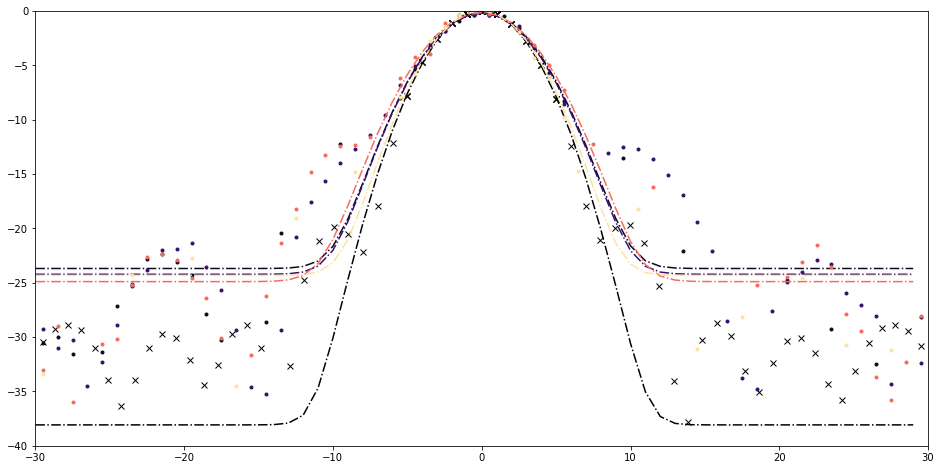

Freqs:  550 550.390625
SIM, X width:  5.676755711746169 Y width:  5.857778657858843
Calculated:  1 X width:  6.266242663224179 Y width:  6.586298019629109
From Cartesian  1 X width:  6.427031747532831 Y width:  6.6080701531303285
Calculated:  3 X width:  6.105378527753005 Y width:  6.144938053596705
From Cartesian  3 X width:  6.144666798323576 Y width:  6.141031199540902
Calculated:  11 X width:  6.470197051039323 Y width:  6.759704790483808
From Cartesian  11 X width:  6.63271499535769 Y width:  6.747674187164752
Calculated:  15 X width:  5.780678582797924 Y width:  6.480836720370915
From Cartesian  15 X width:  5.856977137234703 Y width:  6.527557322677646


<ipython-input-9-3b482552dd33>:66: RuntimeWarning: invalid value encountered in log10
  axs.plot(xd_flat[cc],10*np.log10(dzpos_flat[cc]),color=colorz[chind],marker='.',linestyle='None')
<ipython-input-9-3b482552dd33>:66: RuntimeWarning: invalid value encountered in log10
  axs.plot(xd_flat[cc],10*np.log10(dzpos_flat[cc]),color=colorz[chind],marker='.',linestyle='None')
<ipython-input-9-3b482552dd33>:66: RuntimeWarning: invalid value encountered in log10
  axs.plot(xd_flat[cc],10*np.log10(dzpos_flat[cc]),color=colorz[chind],marker='.',linestyle='None')
<ipython-input-9-3b482552dd33>:66: RuntimeWarning: invalid value encountered in log10
  axs.plot(xd_flat[cc],10*np.log10(dzpos_flat[cc]),color=colorz[chind],marker='.',linestyle='None')


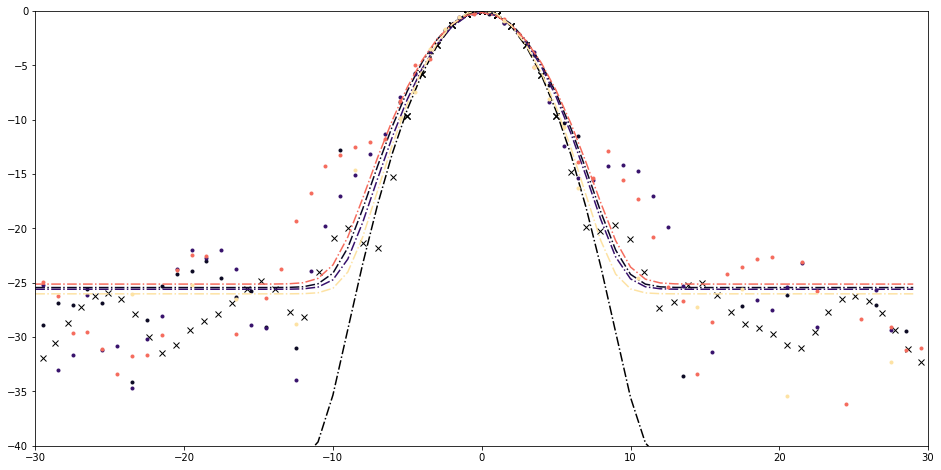

Freqs:  600 598.046875
SIM, X width:  5.252676655559062 Y width:  5.410572425233073
Calculated:  1 X width:  6.819454728747227 Y width:  6.744721206344857
From Cartesian  1 X width:  6.775772833010134 Y width:  6.774738477598767
Calculated:  3 X width:  6.615486406620168 Y width:  6.6782301292897825
From Cartesian  3 X width:  6.62914840322824 Y width:  6.326392462670597
Calculated:  11 X width:  6.957460543105177 Y width:  6.851948018004985
From Cartesian  11 X width:  6.793508167806846 Y width:  6.974852578013352
Calculated:  15 X width:  6.103472397704667 Y width:  6.736982114916508
From Cartesian  15 X width:  6.161057269865688 Y width:  6.863247961504354


<ipython-input-9-3b482552dd33>:66: RuntimeWarning: invalid value encountered in log10
  axs.plot(xd_flat[cc],10*np.log10(dzpos_flat[cc]),color=colorz[chind],marker='.',linestyle='None')
<ipython-input-9-3b482552dd33>:66: RuntimeWarning: invalid value encountered in log10
  axs.plot(xd_flat[cc],10*np.log10(dzpos_flat[cc]),color=colorz[chind],marker='.',linestyle='None')
<ipython-input-9-3b482552dd33>:66: RuntimeWarning: invalid value encountered in log10
  axs.plot(xd_flat[cc],10*np.log10(dzpos_flat[cc]),color=colorz[chind],marker='.',linestyle='None')
<ipython-input-9-3b482552dd33>:66: RuntimeWarning: invalid value encountered in log10
  axs.plot(xd_flat[cc],10*np.log10(dzpos_flat[cc]),color=colorz[chind],marker='.',linestyle='None')


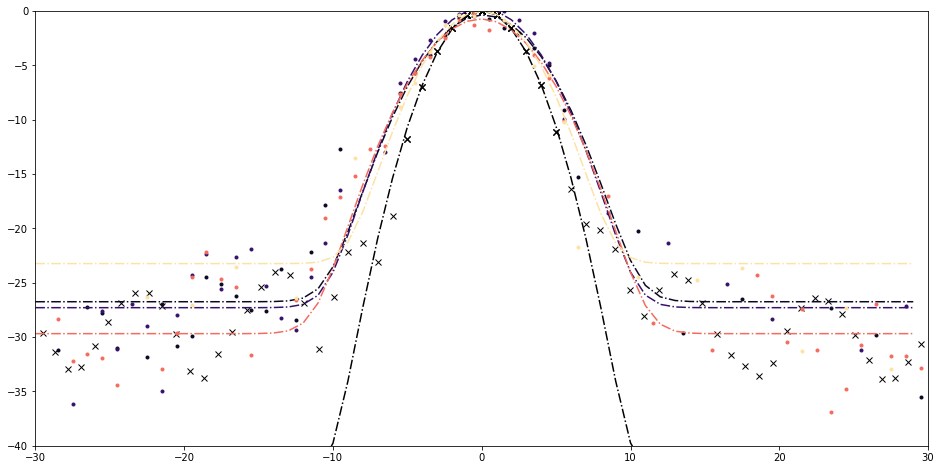

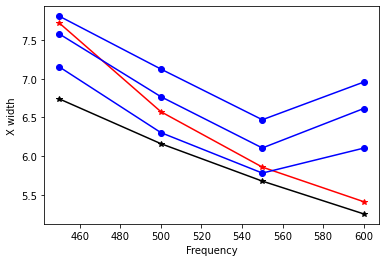

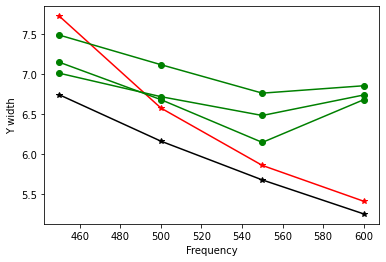

In [9]:
colorz=pu.cm_to_discrete(ccm, 16)

# Check FWHMs

# Now that I theoretically know what I'm doing, let's first fit FWHMs and compare
# per frequency, per input, all inputs


coadded = np.load('/hirax/GBO_Analysis_Outputs/Coadded_2dGauss_and_Airy_Param_w_errs.npz')
    
    
finds = [896,768,639,517]
simfr = [450,500,550,600]

fwhmarr = np.zeros([4,2,5])

for ff,find in enumerate(finds):
    print('Freqs: ', simfr[ff],freqs[find])
    
    # Sim first
    freq = simfr[ff]
    fig, axs = plt.subplots(1,1,figsize=(16,8))
    amp = max(dfs_sims[freq]['mag'][1])
    xpos = dfs_sims[freq]['position'][0].to_numpy()
    ypos = dfs_sims[freq]['position'][1].to_numpy()
    zpos = (dfs_sims[freq]['mag'][1].to_numpy()/amp)**2
 
    cc = get_slice_xy(xpos,ypos,0.0,tol=0.1,ax='y') # this should be a horizontal slice
    axs.plot(xpos[cc],10*np.log10(zpos[cc]),color='black',marker='x',linestyle='None')
    
    pG = [1.0, 0.0, 3.0, 0.0, 3.0, 0.0]
    input_data=np.array([xpos,ypos,zpos])
    G_popt = least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data).x
    print('SIM, X width: ', 2.335*G_popt[2], 'Y width: ', 2.335*G_popt[4])
    fwhmarr[ff,:,0] = [2.335*G_popt[2],2.335*G_popt[4]]
    
    xes = np.arange(-30,30)
    yes = np.zeros(len(xes))
    fitd = fu.Gauss_2d_LC_func(G_popt,xes,yes)

    # plot fit for the sim data
    axs.plot(xes,10*np.log10(fitd),color='black',linestyle='-.')
    
    # N pol next
    copoldir = 'N'
    pols = N_pols

    picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
    with open(picklefile, 'rb') as inp:
        ptest = pickle.load(inp)

    for p,chind in enumerate(N_pols): 
        ppos = np.degrees(ptest.d1_centers_grid[:,:,chind])
        tpos = ptest.d0_centers_grid[:,:,chind]
        dzpos = ptest.V_LC_operation[:,:,0,chind]

        xd = ppos*np.cos(tpos)
        yd = ppos*np.sin(tpos)

        xd_flat = xd.ravel()
        yd_flat = yd.ravel()
        dzpos_flat = dzpos.ravel()
        gi = np.where(np.isfinite(dzpos_flat))[0] 

        cc = get_slice_xy(xd_flat,yd_flat,0.0,tol=0.1,ax='y') # this should be a horizontal slice
        axs.plot(xd_flat[cc],10*np.log10(dzpos_flat[cc]),color=colorz[chind],marker='.',linestyle='None')
        axs.set_xlim(-30,30)
        axs.set_ylim(-40,0)

        # 2D fit
        gi = np.where(np.isfinite(dzpos_flat))[0]
        input_data=np.array([xd_flat[gi],yd_flat[gi],dzpos_flat[gi]])
        G_popt = least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data).x
        fitd = fu.Gauss_2d_LC_func(G_popt,xes,yes)
        axs.plot(xes,10*np.log10(fitd),color=colorz[chind],linestyle='-.')
        #print(G_popt)
        print('Calculated: ', chind, 'X width: ', 2.335*G_popt[2], 'Y width: ', 2.335*G_popt[4])
        print('From Cartesian ', chind, 'X width: ', 
              m_to_FWHM(coadded['G_popt'][chind,find,2,0]), 'Y width: ', 
              m_to_FWHM(coadded['G_popt'][chind,find,4,0]))
        fwhmarr[ff,:,p+1] = [2.335*G_popt[2],2.335*G_popt[4]]

    plt.show()

po = 0
plt.plot(simfr, fwhmarr[:,0,0],marker='*',color='black',label='Sim')
plt.plot(simfr, fwhmarr[:,1,0],marker='*',color='red',label='Sim')
for i in np.arange(2,5):
    plt.plot(simfr, fwhmarr[:,po,i],marker='o',color='blue',label='Input')
plt.ylabel('X width')
plt.xlabel('Frequency')
plt.show()

po = 1
plt.plot(simfr, fwhmarr[:,0,0],marker='*',color='black',label='Sim')
plt.plot(simfr, fwhmarr[:,1,0],marker='*',color='red',label='Sim')
for i in np.arange(2,5):
    plt.plot(simfr, fwhmarr[:,po,i],marker='o',color='green',label='Input')
plt.ylabel('Y width')
plt.xlabel('Frequency')
plt.show()

<ipython-input-10-7991b6bbbd62>:54: RuntimeWarning: invalid value encountered in log10
  ptest.d1_edges_grid[:,:,chind],10*np.log10(ptest.V_LC_operation[:,:,0,chind]),
<ipython-input-10-7991b6bbbd62>:58: RuntimeWarning: invalid value encountered in log10
  ptest.d1_edges_grid[:,:,chind],10*np.log10(ptest.V_LC_operation[:,:,0,chind]),
<ipython-input-10-7991b6bbbd62>:62: RuntimeWarning: invalid value encountered in log10
  ptest.d1_edges_grid[:,:,chind],10*np.log10(ptest.V_LC_operation[:,:,0,chind]),
<ipython-input-10-7991b6bbbd62>:66: RuntimeWarning: invalid value encountered in log10
  ptest.d1_edges_grid[:,:,chind],10*np.log10(ptest.V_LC_operation[:,:,0,chind]),
<ipython-input-10-7991b6bbbd62>:77: RuntimeWarning: invalid value encountered in log10
  ptest.d1_edges_grid[:,:,chind],10*np.log10(ptest.V_LC_operation[:,:,0,chind]),
<ipython-input-10-7991b6bbbd62>:81: RuntimeWarning: invalid value encountered in log10
  ptest.d1_edges_grid[:,:,chind],10*np.log10(ptest.V_LC_operation[:,:,0,c

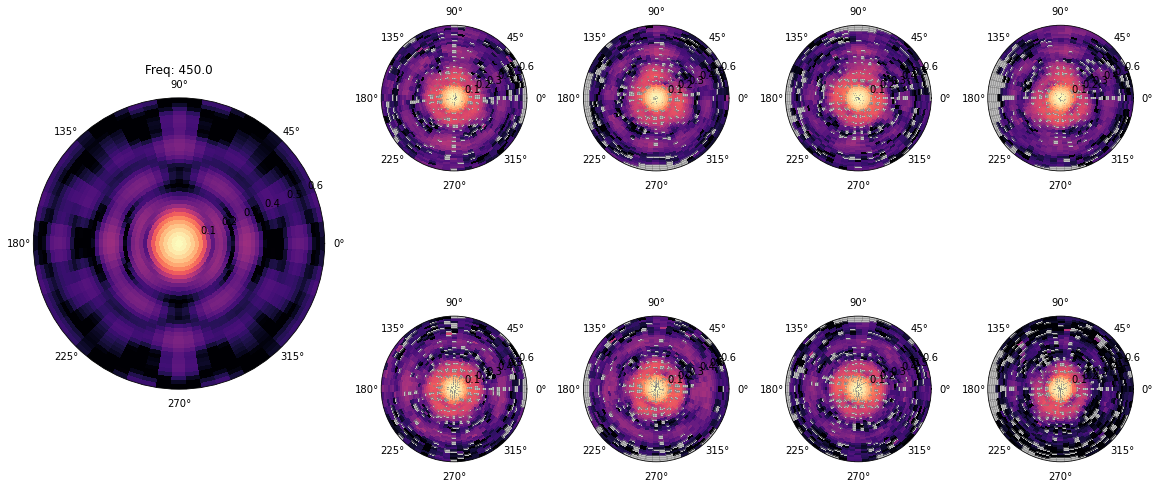

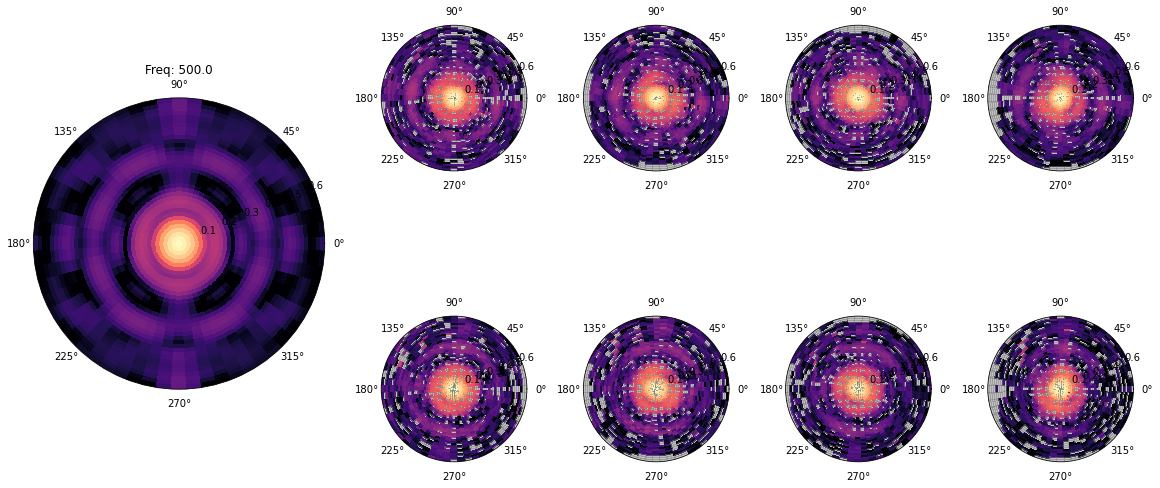

<ipython-input-10-7991b6bbbd62>:66: RuntimeWarning: divide by zero encountered in log10
  ptest.d1_edges_grid[:,:,chind],10*np.log10(ptest.V_LC_operation[:,:,0,chind]),
<ipython-input-10-7991b6bbbd62>:81: RuntimeWarning: divide by zero encountered in log10
  ptest.d1_edges_grid[:,:,chind],10*np.log10(ptest.V_LC_operation[:,:,0,chind]),


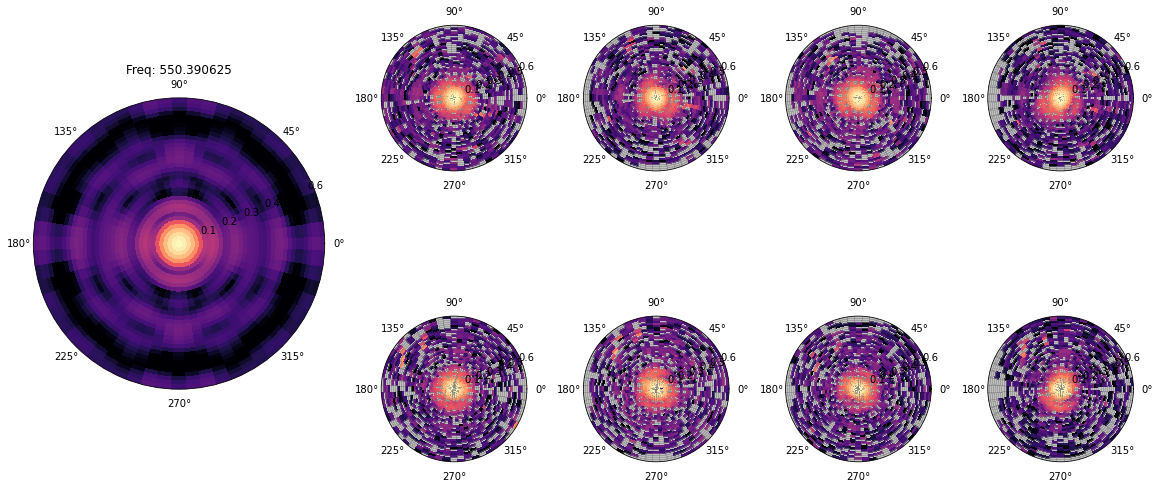

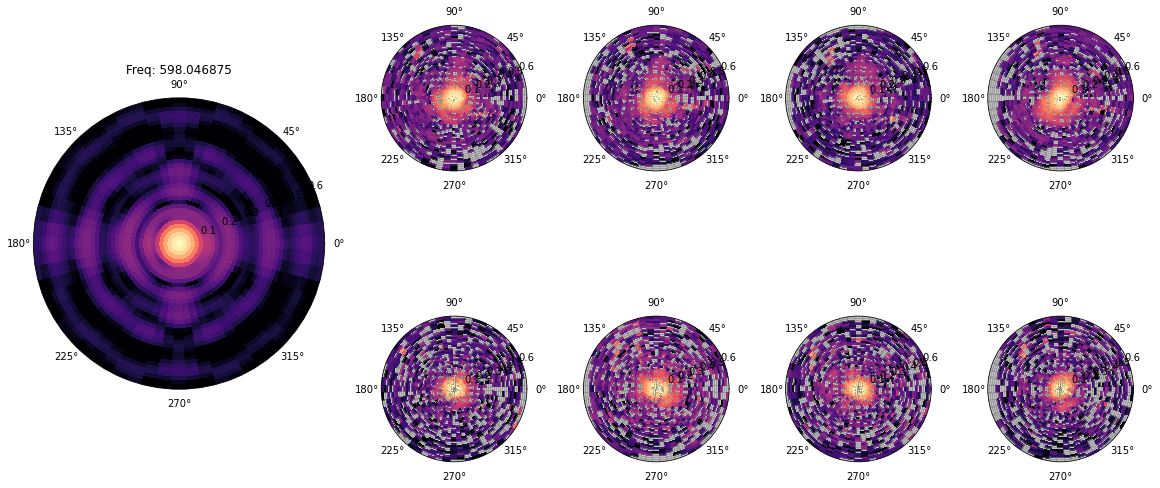

In [10]:
## This plots the sims, and each coadded map, for the nearest data frequency

finds = [896,768,639,517]
simfr = [450,500,550,600]

for ff,find in enumerate(finds):
    # Figure setup stuff
    fig = plt.figure(constrained_layout=True,figsize=(16,8))
    gs = GridSpec(2,5, height_ratios=[0.5,0.5], width_ratios=[1,0.5,0.5,0.5,0.5],figure=fig)
    axs0 = fig.add_subplot(gs[:,0],polar=True)
    axs1 = fig.add_subplot(gs[0, 1],polar=True)
    axs2 = fig.add_subplot(gs[0, 2],polar=True)
    axs3 = fig.add_subplot(gs[0, 3],polar=True)
    axs4 = fig.add_subplot(gs[0, 4],polar=True)
    axs5 = fig.add_subplot(gs[1, 1],polar=True)
    axs6 = fig.add_subplot(gs[1, 2],polar=True)
    axs7 = fig.add_subplot(gs[1, 3],polar=True)
    axs8 = fig.add_subplot(gs[1, 4],polar=True)
    
    # Open N pol coadd - need this for the sim gridding
    copoldir = 'N'
    chind = N_pols[0]
    picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
    with open(picklefile, 'rb') as inp:
        ptest = pickle.load(inp)
     

    # simulation map at this frequency
    # Bin to the same grid as the data 
    freq = simfr[ff]
    amp = max(dfs_sims[freq]['mag'][1])
    xpos = dfs_sims[freq]['position'][0].to_numpy()
    ypos = dfs_sims[freq]['position'][1].to_numpy()
    zpos = (dfs_sims[freq]['mag'][1].to_numpy()/amp)**2

    r = np.radians(np.sqrt(xpos**2 + ypos**2))
    thet = np.arctan2(ypos,xpos)
    thet[thet<0.0] += 2*np.pi
    xedges = ptest.d0_edges_grid[:,0,chind]
    yedges = ptest.d1_edges_grid[0,:,chind]

    binnedmap = binned_statistic_2d(x=thet,y=r,values=zpos,
                                statistic='mean',bins=[xedges,yedges]).statistic


    axs0.pcolormesh(ptest.d0_edges_grid[:,:,chind],
               ptest.d1_edges_grid[:,:,chind],10*np.log10(binnedmap),cmap=ccm,vmin=-40,vmax=0)
    axs0.set_title('Freq: '+str(freqs[find]))

    
    # Now the per-input plots - N pol
    chind=N_pols[0]
    axs1.pcolormesh(ptest.d0_edges_grid[:,:,chind],
               ptest.d1_edges_grid[:,:,chind],10*np.log10(ptest.V_LC_operation[:,:,0,chind]),
                cmap=ccm,vmin=-40,vmax=0)
    chind=N_pols[1]
    axs2.pcolormesh(ptest.d0_edges_grid[:,:,chind],
               ptest.d1_edges_grid[:,:,chind],10*np.log10(ptest.V_LC_operation[:,:,0,chind]),
                cmap=ccm,vmin=-40,vmax=0)
    chind=N_pols[2]
    axs3.pcolormesh(ptest.d0_edges_grid[:,:,chind],
               ptest.d1_edges_grid[:,:,chind],10*np.log10(ptest.V_LC_operation[:,:,0,chind]),
                cmap=ccm,vmin=-40,vmax=0)
    chind=N_pols[3]
    axs4.pcolormesh(ptest.d0_edges_grid[:,:,chind],
               ptest.d1_edges_grid[:,:,chind],10*np.log10(ptest.V_LC_operation[:,:,0,chind]),
                cmap=ccm,vmin=-40,vmax=0)

    # Now the per-input plots - E pol
    copoldir = 'E'
    picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
    with open(picklefile, 'rb') as inp:
        ptest = pickle.load(inp)
    
    chind=E_pols[0]
    axs5.pcolormesh(ptest.d0_edges_grid[:,:,chind],
               ptest.d1_edges_grid[:,:,chind],10*np.log10(ptest.V_LC_operation[:,:,0,chind]),
                cmap=ccm,vmin=-40,vmax=0)
    chind=E_pols[1]
    axs6.pcolormesh(ptest.d0_edges_grid[:,:,chind],
               ptest.d1_edges_grid[:,:,chind],10*np.log10(ptest.V_LC_operation[:,:,0,chind]),
                cmap=ccm,vmin=-40,vmax=0)
    chind=E_pols[2]
    axs7.pcolormesh(ptest.d0_edges_grid[:,:,chind],
               ptest.d1_edges_grid[:,:,chind],10*np.log10(ptest.V_LC_operation[:,:,0,chind]),
                cmap=ccm,vmin=-40,vmax=0)
    chind=E_pols[3]
    axs8.pcolormesh(ptest.d0_edges_grid[:,:,chind],
               ptest.d1_edges_grid[:,:,chind],10*np.log10(ptest.V_LC_operation[:,:,0,chind]),
                cmap=ccm,vmin=-40,vmax=0)
    plt.show()
    



In [37]:
print(np.radians(24))

0.4188790204786391


<ipython-input-62-331110602372>:61: RuntimeWarning: Mean of empty slice
  N_holder[:,:,fi] = np.nanmean(ptest.V_LC_operation[:,:,0,N_pols],axis=-1)
<ipython-input-62-331110602372>:63: RuntimeWarning: Mean of empty slice
  N_map = np.nanmean(N_holder,axis=-1)
<ipython-input-62-331110602372>:65: RuntimeWarning: invalid value encountered in log10
  ptest.d1_edges_grid[:,:,chind],10*np.log10(N_map[:,:]),
<ipython-input-62-331110602372>:88: RuntimeWarning: Mean of empty slice
  E_holder[:,:,fi] = np.nanmean(ptest.V_LC_operation[:,:,0,E_pols],axis=-1)
<ipython-input-62-331110602372>:90: RuntimeWarning: Mean of empty slice
  E_map = np.nanmean(E_holder,axis=-1)
<ipython-input-62-331110602372>:93: RuntimeWarning: invalid value encountered in log10
  ptest.d1_edges_grid[:,:,chind],10*np.log10(E_map[:,:]),
<ipython-input-62-331110602372>:61: RuntimeWarning: Mean of empty slice
  N_holder[:,:,fi] = np.nanmean(ptest.V_LC_operation[:,:,0,N_pols],axis=-1)
<ipython-input-62-331110602372>:63: RuntimeW

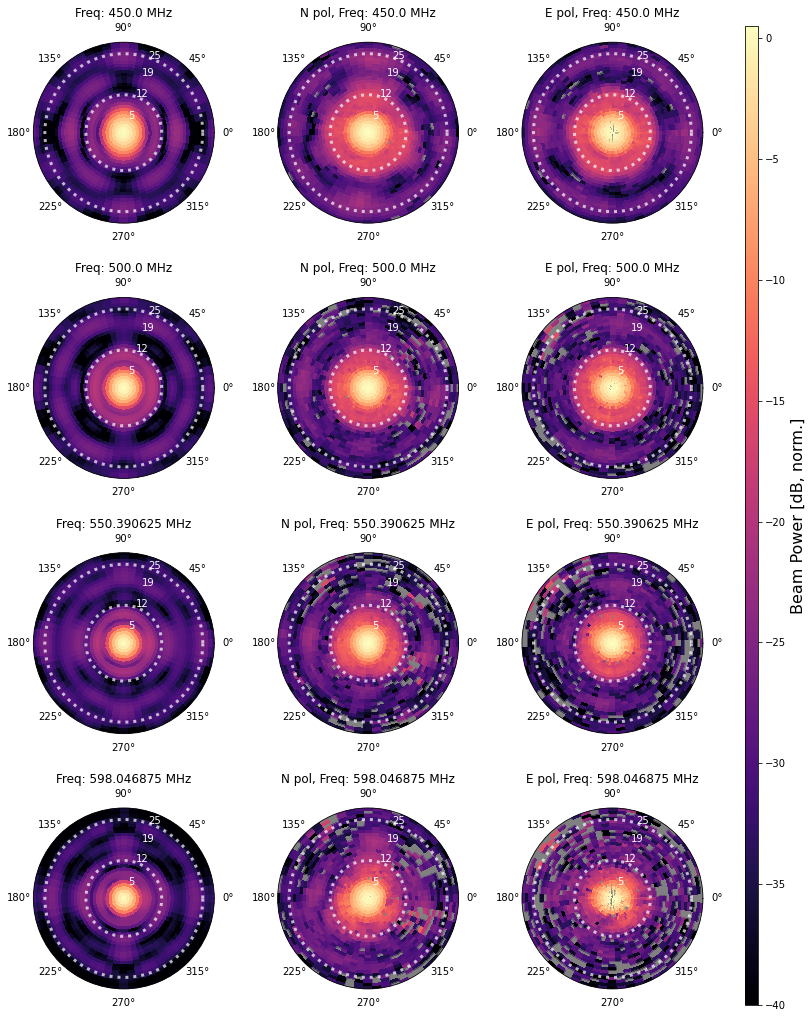

In [62]:
# Average together N pols, and a few frequencies, and see what happens

fig, axs = plt.subplots(4,3, subplot_kw=dict(projection="polar"),figsize=(15,18))

thetas = np.arange(0,2*np.pi,0.01)
phis1 = np.radians(12)*np.ones(len(thetas))
phis2 = np.radians(25)*np.ones(len(thetas))

rl = (0.08,0.21,0.33,0.43)
rt = ('5','12','19','25')

for ff,find in enumerate(finds):
    
    # Open N pol coadd - need this for the sim gridding
    copoldir = 'N'
    chind = N_pols[0]
    picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
    with open(picklefile, 'rb') as inp:
        ptest = pickle.load(inp)
     

    # simulation map at this frequency
    freq = simfr[ff]
    amp = max(dfs_sims[freq]['mag'][1])
    xpos = dfs_sims[freq]['position'][0].to_numpy()
    ypos = dfs_sims[freq]['position'][1].to_numpy()
    zpos = (dfs_sims[freq]['mag'][1].to_numpy()/amp)**2

    r = np.radians(np.sqrt(xpos**2 + ypos**2))
    thet = np.arctan2(ypos,xpos)
    thet[thet<0.0] += 2*np.pi
    xedges = ptest.d0_edges_grid[:,0,chind]
    yedges = ptest.d1_edges_grid[0,:,chind]

    binnedmap = binned_statistic_2d(x=thet,y=r,values=zpos,
                                statistic='mean',bins=[xedges,yedges]).statistic
    
    axs[ff,0].pcolormesh(ptest.d0_edges_grid[:,:,chind],
               ptest.d1_edges_grid[:,:,chind],10*np.log10(binnedmap),cmap=ccm,vmin=-40,vmax=0)
    axs[ff,0].set_title('Freq: '+str(freqs[find])+' MHz')
    axs[ff,0].plot(thetas,phis1,color='white',alpha=0.7,linestyle=':',linewidth=3)
    axs[ff,0].plot(thetas,phis2,color='white',alpha=0.7,linestyle=':',linewidth=3)
    axs[ff,0].set_yticks([])
    axs[ff,0].xaxis.label.set_color('white')   
    axs[ff,0].tick_params(axis='y', colors='white')
    axs[ff,0].set_facecolor('grey')
    for ri in np.arange(len(rl)): 
        axs[ff,0].text(np.pi/2.5,rl[ri],rt[ri],color='white')
    
    # Open N pol coadd
    copoldir = 'N'
    
    ffs = get_ffs(find)
    N_holder = np.NAN*np.ones([60,36,len(ffs)])
    
    for fi,fdat in enumerate(ffs):
        picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(fdat)+'_polar.pkl'
        with open(picklefile, 'rb') as inp:
            ptest = pickle.load(inp)
    
        N_holder[:,:,fi] = np.nanmean(ptest.V_LC_operation[:,:,0,N_pols],axis=-1)

    N_map = np.nanmean(N_holder,axis=-1)
    axs[ff,1].pcolormesh(ptest.d0_edges_grid[:,:,chind],
               ptest.d1_edges_grid[:,:,chind],10*np.log10(N_map[:,:]),
                cmap=ccm,vmin=-40,vmax=0)
    axs[ff,1].set_title('N pol, Freq: '+str(freqs[find])+' MHz')
    axs[ff,1].plot(thetas,phis1,color='white',alpha=0.7,linestyle=':',linewidth=3)
    axs[ff,1].plot(thetas,phis2,color='white',alpha=0.7,linestyle=':',linewidth=3)
    axs[ff,1].set_yticks([])
    axs[ff,1].xaxis.label.set_color('white')   
    axs[ff,1].tick_params(axis='y', colors='white')
    axs[ff,1].set_facecolor('grey')
    for ri in np.arange(len(rl)): 
        axs[ff,1].text(np.pi/2.5,rl[ri],rt[ri],color='white')
    
    # Open E pol coadd
    copoldir = 'E'
    
    ffs = get_ffs(find)
    E_holder = np.NAN*np.ones([60,36,len(ffs)])
    
    for fi,fdat in enumerate(ffs):
        picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(fdat)+'_polar.pkl'
        with open(picklefile, 'rb') as inp:
            ptest = pickle.load(inp)
    
        E_holder[:,:,fi] = np.nanmean(ptest.V_LC_operation[:,:,0,E_pols],axis=-1)
        
    E_map = np.nanmean(E_holder,axis=-1)

    axs[ff,2].pcolormesh(ptest.d0_edges_grid[:,:,chind],
               ptest.d1_edges_grid[:,:,chind],10*np.log10(E_map[:,:]),
                cmap=ccm,vmin=-40,vmax=0)
    axs[ff,2].set_title('E pol, Freq: '+str(freqs[find])+' MHz')
    axs[ff,2].plot(thetas,phis1,color='white',alpha=0.7,linestyle=':',linewidth=3)
    axs[ff,2].plot(thetas,phis2,color='white',alpha=0.7,linestyle=':',linewidth=3)
    axs[ff,2].set_yticks([])
    axs[ff,2].xaxis.label.set_color('white')   
    axs[ff,2].tick_params(axis='y', colors='white')
    axs[ff,2].set_facecolor('grey')
    for ri in np.arange(len(rl)): 
        axs[ff,2].text(np.pi/2.5,rl[ri],rt[ri],color='white')
    
    axs[ff,0].set_ylim(0,0.5)
    axs[ff,1].set_ylim(0,0.5)
    axs[ff,2].set_ylim(0,0.5)

plt.subplots_adjust(wspace=0.35)
cbar=fig.colorbar(im,ax=axs,aspect=73)
cbar.set_label('Beam Power [dB, norm.]',fontsize=fsz)

plt.show()



<ipython-input-18-8d85514dd470>:47: RuntimeWarning: Mean of empty slice
  N_holder[:,:,fi] = np.nanmean(ptest.V_LC_operation[:,:,0,N_pols],axis=-1)
<ipython-input-18-8d85514dd470>:49: RuntimeWarning: Mean of empty slice
  N_map = np.nanmean(N_holder,axis=-1)
<ipython-input-18-8d85514dd470>:51: RuntimeWarning: invalid value encountered in log10
  ptest.d1_edges_grid[:,:,chind],10*np.log10(N_map[:,:]),
<ipython-input-18-8d85514dd470>:67: RuntimeWarning: Mean of empty slice
  E_holder[:,:,fi] = np.nanmean(ptest.V_LC_operation[:,:,0,E_pols],axis=-1)
<ipython-input-18-8d85514dd470>:69: RuntimeWarning: Mean of empty slice
  E_map = np.nanmean(E_holder,axis=-1)
<ipython-input-18-8d85514dd470>:72: RuntimeWarning: invalid value encountered in log10
  ptest.d1_edges_grid[:,:,chind],10*np.log10(E_map[:,:]),


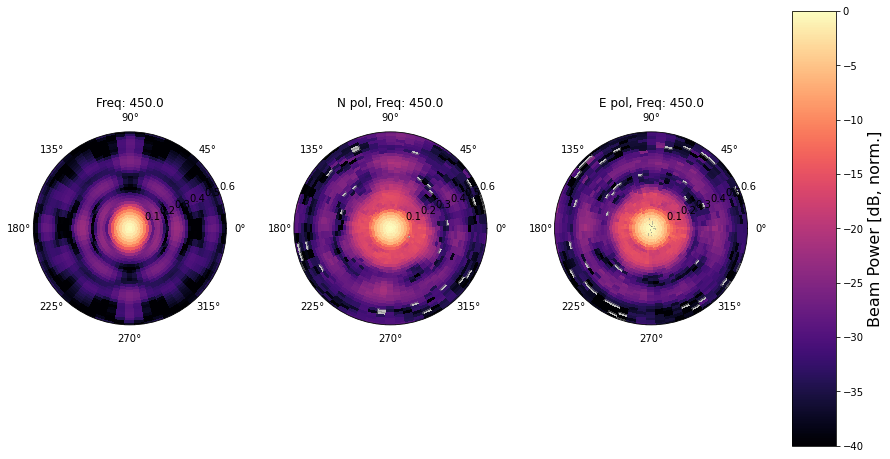

In [18]:
# Average together N pols, and a few frequencies, and see what happens

fig, axs = plt.subplots(1,3, subplot_kw=dict(projection="polar"),figsize=(16,8))

ff = 0
find = 896
    
# Open N pol coadd - need this for the sim gridding
copoldir = 'N'
chind = N_pols[0]
picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)
     

# simulation map at this frequency
freq = simfr[ff]
amp = max(dfs_sims[freq]['mag'][1])
xpos = dfs_sims[freq]['position'][0].to_numpy()
ypos = dfs_sims[freq]['position'][1].to_numpy()
zpos = (dfs_sims[freq]['mag'][1].to_numpy()/amp)**2

r = np.radians(np.sqrt(xpos**2 + ypos**2))
thet = np.arctan2(ypos,xpos)
thet[thet<0.0] += 2*np.pi
xedges = ptest.d0_edges_grid[:,0,chind]
yedges = ptest.d1_edges_grid[0,:,chind]

binnedmap = binned_statistic_2d(x=thet,y=r,values=zpos,
                                statistic='mean',bins=[xedges,yedges]).statistic
    
axs[0].pcolormesh(ptest.d0_edges_grid[:,:,chind],
               ptest.d1_edges_grid[:,:,chind],10*np.log10(binnedmap),cmap=ccm,vmin=-40,vmax=0)
axs[0].set_title('Freq: '+str(freqs[find]))
    
# Open N pol coadd
copoldir = 'N'
    
ffs = get_ffs(find)
N_holder = np.NAN*np.ones([60,36,len(ffs)])
    
for fi,fdat in enumerate(ffs):
    picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(fdat)+'_polar.pkl'
    with open(picklefile, 'rb') as inp:
            ptest = pickle.load(inp)
    
    N_holder[:,:,fi] = np.nanmean(ptest.V_LC_operation[:,:,0,N_pols],axis=-1)

    N_map = np.nanmean(N_holder,axis=-1)
axs[1].pcolormesh(ptest.d0_edges_grid[:,:,chind],
               ptest.d1_edges_grid[:,:,chind],10*np.log10(N_map[:,:]),
                cmap=ccm,vmin=-40,vmax=0)
axs[1].set_title('N pol, Freq: '+str(freqs[find]))

    
# Open E pol coadd
copoldir = 'E'
    
ffs = get_ffs(find)
E_holder = np.NAN*np.ones([60,36,len(ffs)])
    
for fi,fdat in enumerate(ffs):
    picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(fdat)+'_polar.pkl'
    with open(picklefile, 'rb') as inp:
            ptest = pickle.load(inp)
    
    E_holder[:,:,fi] = np.nanmean(ptest.V_LC_operation[:,:,0,E_pols],axis=-1)
        
E_map = np.nanmean(E_holder,axis=-1)

im=axs[2].pcolormesh(ptest.d0_edges_grid[:,:,chind],
               ptest.d1_edges_grid[:,:,chind],10*np.log10(E_map[:,:]),
                cmap=ccm,vmin=-40,vmax=0)
axs[2].set_title('E pol, Freq: '+str(freqs[find]))
    
    
axs[0].set_ylim(0,0.6)
axs[1].set_ylim(0,0.6)
axs[2].set_ylim(0,0.6)

plt.subplots_adjust(wspace=0.35)
cbar=fig.colorbar(im,ax=axs,aspect=10)
cbar.set_label('Beam Power [dB, norm.]',fontsize=fsz)
plt.show()



Freqs:  450 450.0


<ipython-input-38-1a9d9409a576>:35: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-38-1a9d9409a576>:35: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-38-1a9d9409a576>:35: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-38-1a9d9409a576>:35: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-38-1a9d9409a576>:58: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),
<ipython-input-38-1a9d9409a576>:58: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),
<ipython-input-38-1a9d9409a576>:35: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipy

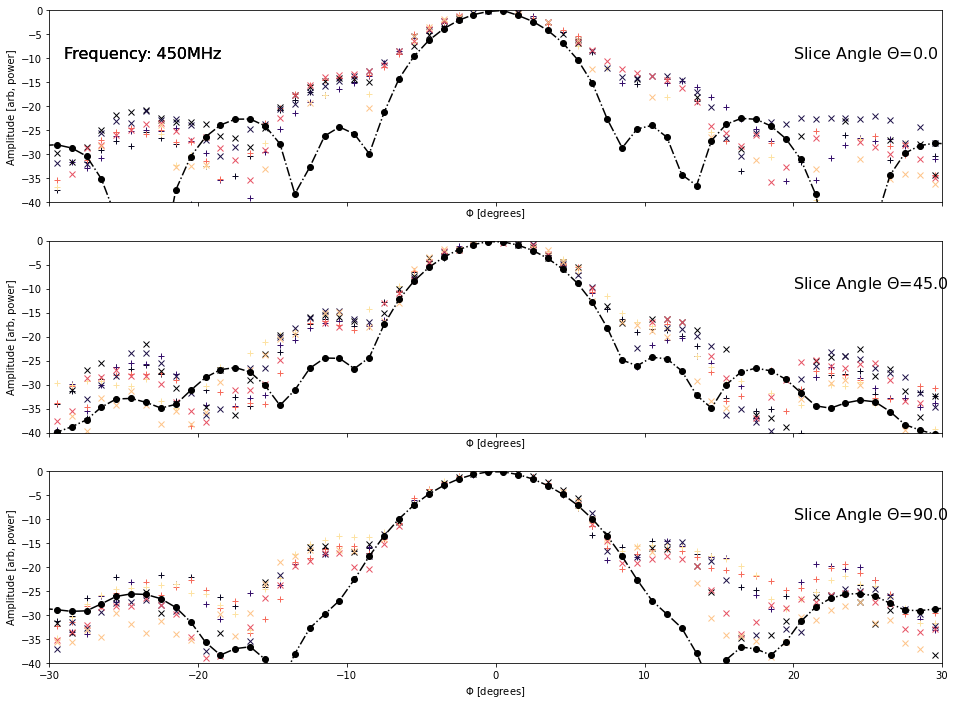

Freqs:  500 500.0


<ipython-input-38-1a9d9409a576>:35: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-38-1a9d9409a576>:35: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-38-1a9d9409a576>:35: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-38-1a9d9409a576>:58: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),
<ipython-input-38-1a9d9409a576>:58: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),
<ipython-input-38-1a9d9409a576>:58: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),
<ipython-input-38-1a9d9409a576>:58: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),
<ipython-input-38-1a9d9409a576>:35: RuntimeW

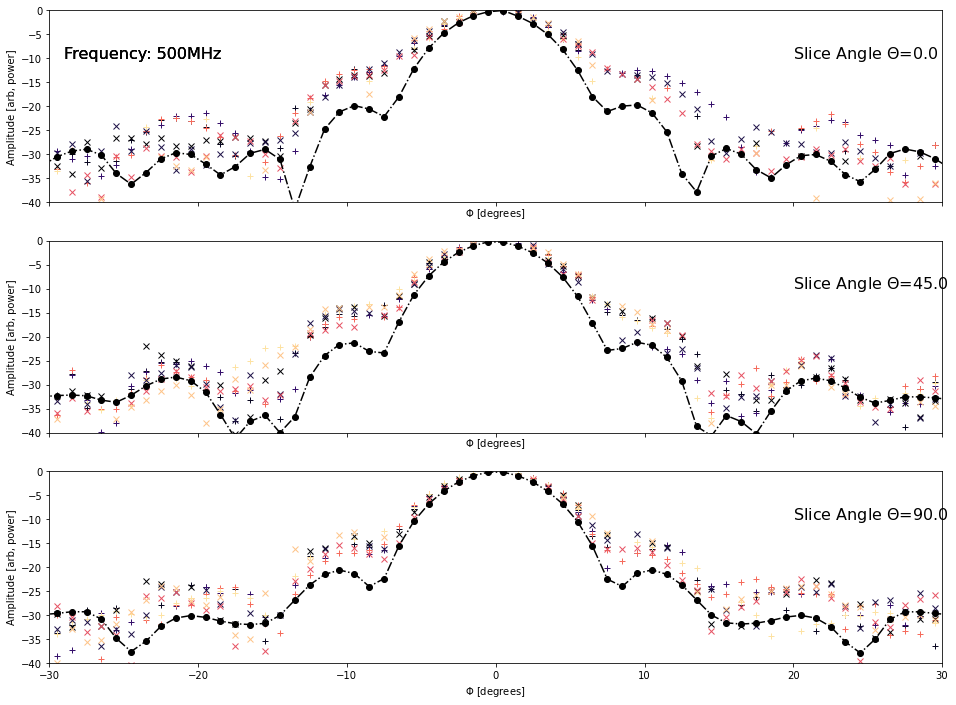

Freqs:  550 550.390625


<ipython-input-38-1a9d9409a576>:35: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-38-1a9d9409a576>:35: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-38-1a9d9409a576>:35: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-38-1a9d9409a576>:35: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-38-1a9d9409a576>:58: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),
<ipython-input-38-1a9d9409a576>:58: RuntimeWarning: divide by zero encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),
<ipython-input-38-1a9d9409a576>:58: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),
<ipython-input-38-1a9d9

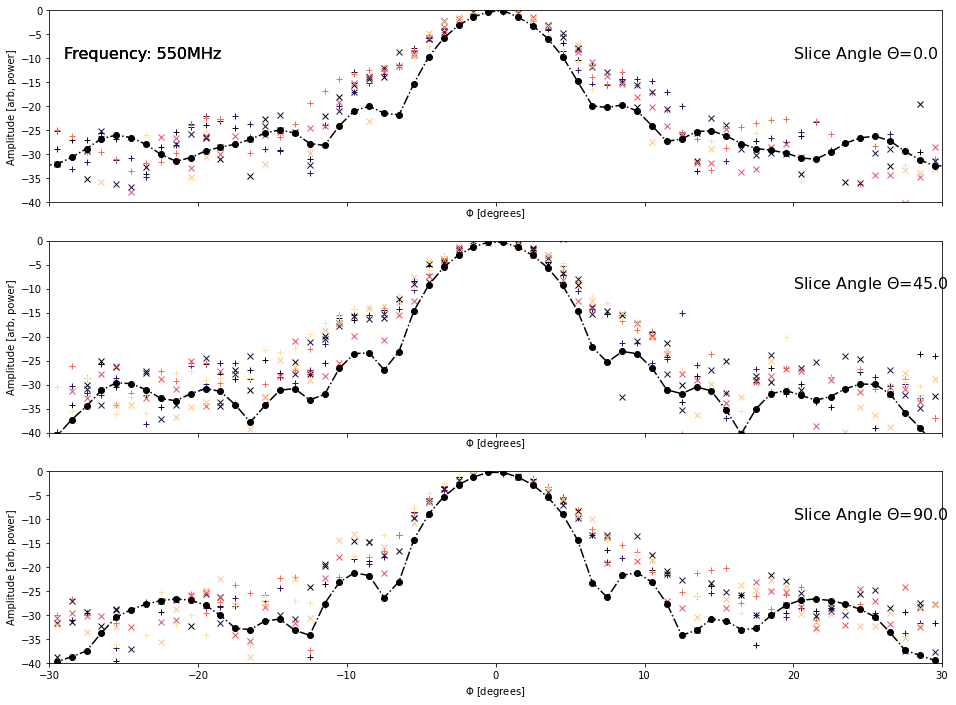

Freqs:  600 598.046875


<ipython-input-38-1a9d9409a576>:35: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-38-1a9d9409a576>:35: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-38-1a9d9409a576>:35: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-38-1a9d9409a576>:35: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-38-1a9d9409a576>:58: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),
<ipython-input-38-1a9d9409a576>:58: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),
<ipython-input-38-1a9d9409a576>:58: RuntimeWarning: invalid value encountered in log10
  axs[a].plot(pposc,10*np.log10(dzposc),
<ipython-input-38-1a9d94

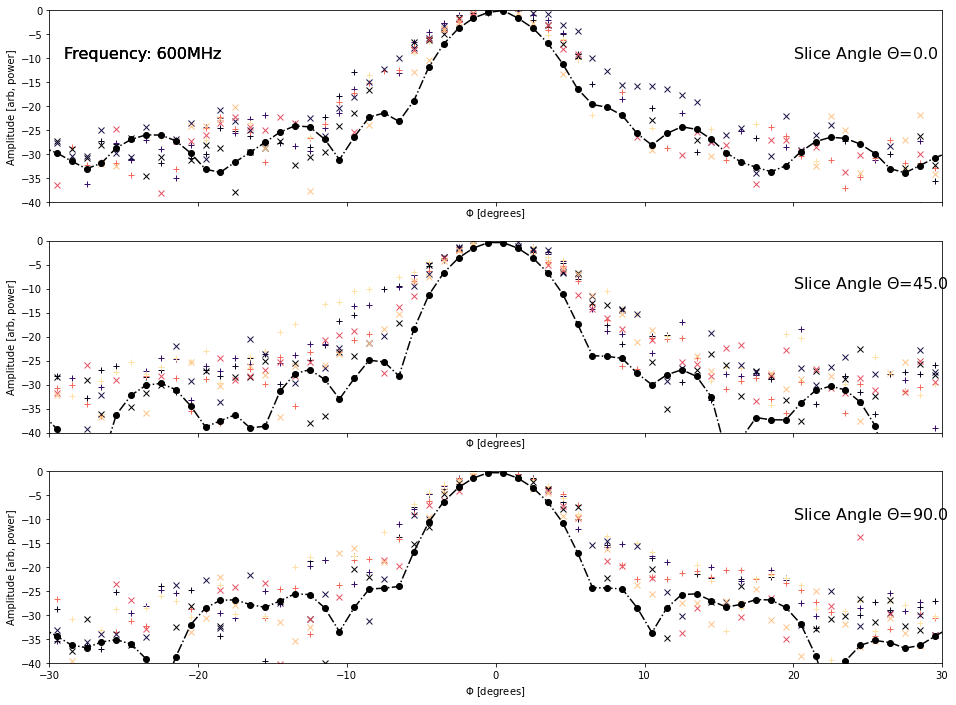

In [38]:
### Plot slices

whichang = [0.0, np.pi/4.0, np.pi/2.]

for ff,find in enumerate(finds):
    
    print('Freqs: ', simfr[ff],freqs[find])
    
    fig,axs = plt.subplots(3, 1,figsize=(16,12),sharex=True,sharey=True)
        
    for a, ang in enumerate(whichang):

        # N pol next
        copoldir = 'N'
        pols = N_pols

        picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
        with open(picklefile, 'rb') as inp:
            ptest = pickle.load(inp)

        for p,chind in enumerate(N_pols): 
            ppos = np.degrees(ptest.d1_centers_grid[:,:,chind])
            tpos = ptest.d0_centers_grid[:,:,chind]
            dzpos = ptest.V_LC_operation[:,:,0,chind]

            # grab a polar slice at a given angle
            ppos = np.degrees(ptest.d1_centers_grid[:,:,chind])
            tpos = ptest.d0_centers_grid[:,:,chind]
            dzpos = ptest.V_LC_operation[:,:,0,chind]
    
            cc1,cc2 = get_polar_slice(tpos,ppos,val=ang,direction='t')
        
            pposc = np.concatenate((ppos[cc1,:],-1.0*ppos[cc2,:]))
            dzposc = np.concatenate((dzpos[cc1,:],dzpos[cc2,:]))
            axs[a].plot(pposc,10*np.log10(dzposc),color=colorz[chind],
                    marker='+',linestyle='None')
        
        # E pol next
        copoldir = 'E'
        pols = E_pols

        picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
        with open(picklefile, 'rb') as inp:
            ptest = pickle.load(inp)
        
        for p,chind in enumerate(E_pols): 
            ppos = np.degrees(ptest.d1_centers_grid[:,:,chind])
            tpos = ptest.d0_centers_grid[:,:,chind]
            dzpos = ptest.V_LC_operation[:,:,0,chind]

            # grab a polar slice at a given angle
            ppos = np.degrees(ptest.d1_centers_grid[:,:,chind])
            tpos = ptest.d0_centers_grid[:,:,chind]
            dzpos = ptest.V_LC_operation[:,:,0,chind]
        
            pposc = np.concatenate((ppos[cc1,:],-1.0*ppos[cc2,:]))
            dzposc = np.concatenate((dzpos[cc1,:],dzpos[cc2,:]))
            axs[a].plot(pposc,10*np.log10(dzposc),
                    color=colorz[chind],marker='x',linestyle='None')
        
        # Sim 
        freq = simfr[ff]
        amp = max(dfs_sims[freq]['mag'][1])
        xpos = dfs_sims[freq]['position'][0].to_numpy()
        ypos = dfs_sims[freq]['position'][1].to_numpy()
        zpos = (dfs_sims[freq]['mag'][1].to_numpy()/amp)**2

        r = np.radians(np.sqrt(xpos**2 + ypos**2))
        thet = np.arctan2(ypos,xpos)
        thet[thet<0.0] += 2*np.pi
        xedges = ptest.d0_edges_grid[:,0,chind]
        yedges = ptest.d1_edges_grid[0,:,chind]

        binnedmap = binned_statistic_2d(x=thet,y=r,values=zpos,
                                statistic='mean',bins=[xedges,yedges]).statistic
    
        #simx = np.concatenate((r[cc1,:],-1.0*r[cc2,:]))
        simz = np.concatenate((binnedmap[cc1,:][::-1],binnedmap[cc2,:]))
        pposc = np.concatenate((ppos[cc1,:][::-1],-1.0*ppos[cc2,:]))
        axs[a].plot(pposc,10*np.log10(simz),color='black',
                    marker='o',linestyle='-.')
        
        axs[a].text(20,-10,r'Slice Angle $\Theta$='+ str(np.degrees(ang)),fontsize=16)
        axs[a].set_xlabel(r'$\Phi$ [degrees]')
        axs[a].set_ylabel('Amplitude [arb, power]')
        axs[0].text(-29,-10,'Frequency: '+str(simfr[ff])+'MHz',fontsize=16)
        axs[a].set_xlim(-30,30)
        axs[a].set_ylim(-40,0)
    
    
    plt.show()



Freqs:  450 450.0


<ipython-input-12-0facde2bf85a>:44: RuntimeWarning: invalid value encountered in log10
  ax0.plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-12-0facde2bf85a>:52: RuntimeWarning: invalid value encountered in log10
  ax1.plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-12-0facde2bf85a>:60: RuntimeWarning: invalid value encountered in log10
  ax2.plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-12-0facde2bf85a>:44: RuntimeWarning: invalid value encountered in log10
  ax0.plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-12-0facde2bf85a>:52: RuntimeWarning: invalid value encountered in log10
  ax1.plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-12-0facde2bf85a>:60: RuntimeWarning: invalid value encountered in log10
  ax2.plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-12-0facde2bf85a>:44: RuntimeWarning: invalid value encountered in log10
  ax0.plot(pposc,10*np.log10(dzposc),color=

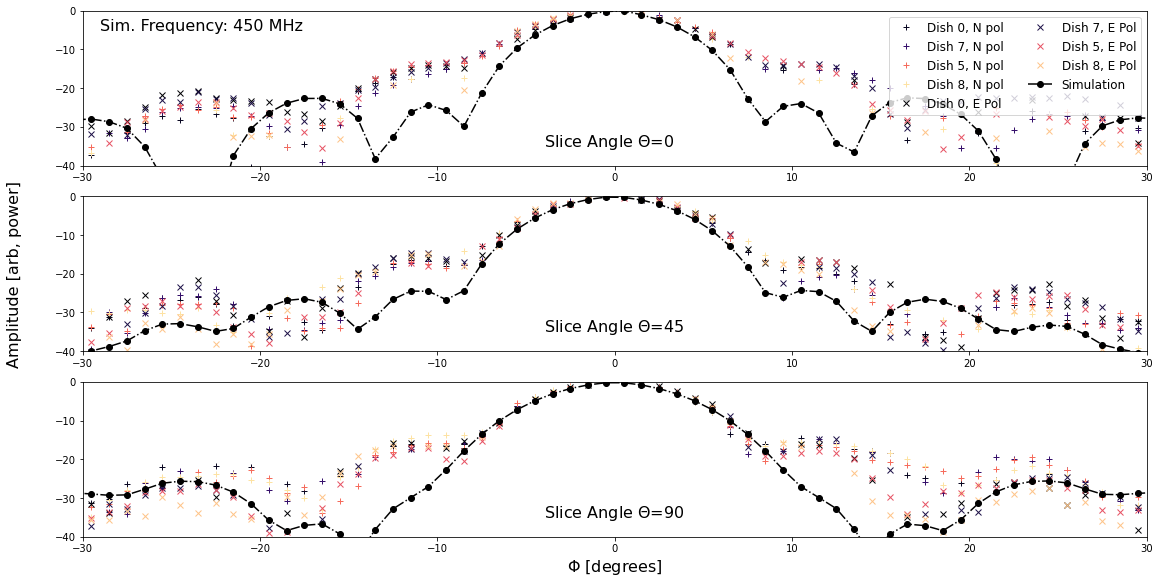

Freqs:  500 500.0


<ipython-input-12-0facde2bf85a>:44: RuntimeWarning: invalid value encountered in log10
  ax0.plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-12-0facde2bf85a>:52: RuntimeWarning: invalid value encountered in log10
  ax1.plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-12-0facde2bf85a>:60: RuntimeWarning: invalid value encountered in log10
  ax2.plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-12-0facde2bf85a>:44: RuntimeWarning: invalid value encountered in log10
  ax0.plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-12-0facde2bf85a>:52: RuntimeWarning: invalid value encountered in log10
  ax1.plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-12-0facde2bf85a>:60: RuntimeWarning: invalid value encountered in log10
  ax2.plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-12-0facde2bf85a>:44: RuntimeWarning: invalid value encountered in log10
  ax0.plot(pposc,10*np.log10(dzposc),color=

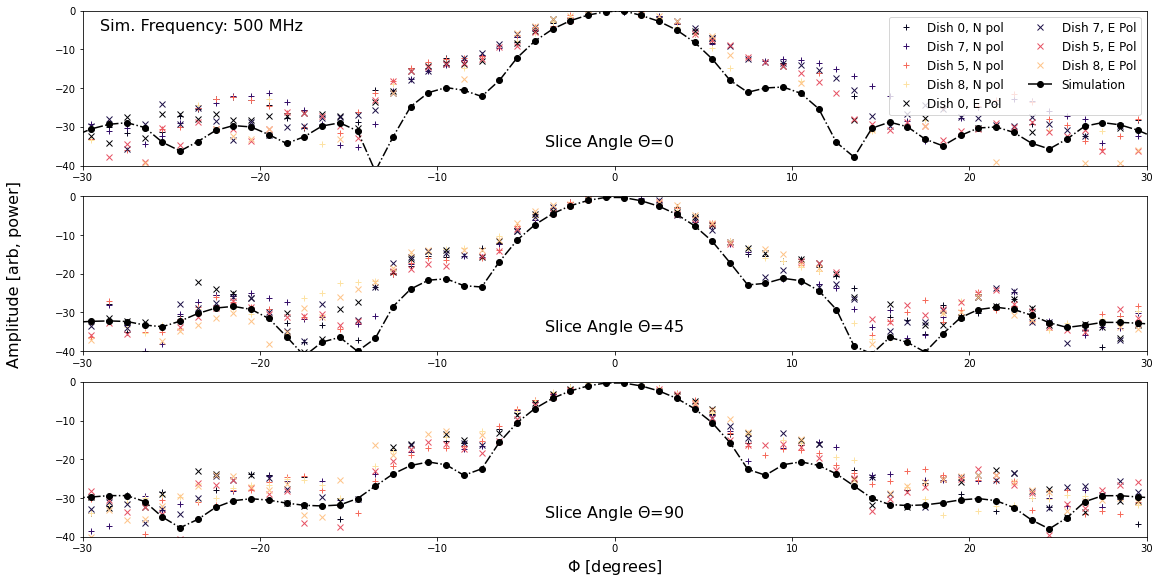

Freqs:  550 550.390625


<ipython-input-12-0facde2bf85a>:44: RuntimeWarning: invalid value encountered in log10
  ax0.plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-12-0facde2bf85a>:52: RuntimeWarning: invalid value encountered in log10
  ax1.plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-12-0facde2bf85a>:60: RuntimeWarning: invalid value encountered in log10
  ax2.plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-12-0facde2bf85a>:44: RuntimeWarning: invalid value encountered in log10
  ax0.plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-12-0facde2bf85a>:52: RuntimeWarning: invalid value encountered in log10
  ax1.plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-12-0facde2bf85a>:60: RuntimeWarning: invalid value encountered in log10
  ax2.plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-12-0facde2bf85a>:44: RuntimeWarning: invalid value encountered in log10
  ax0.plot(pposc,10*np.log10(dzposc),color=

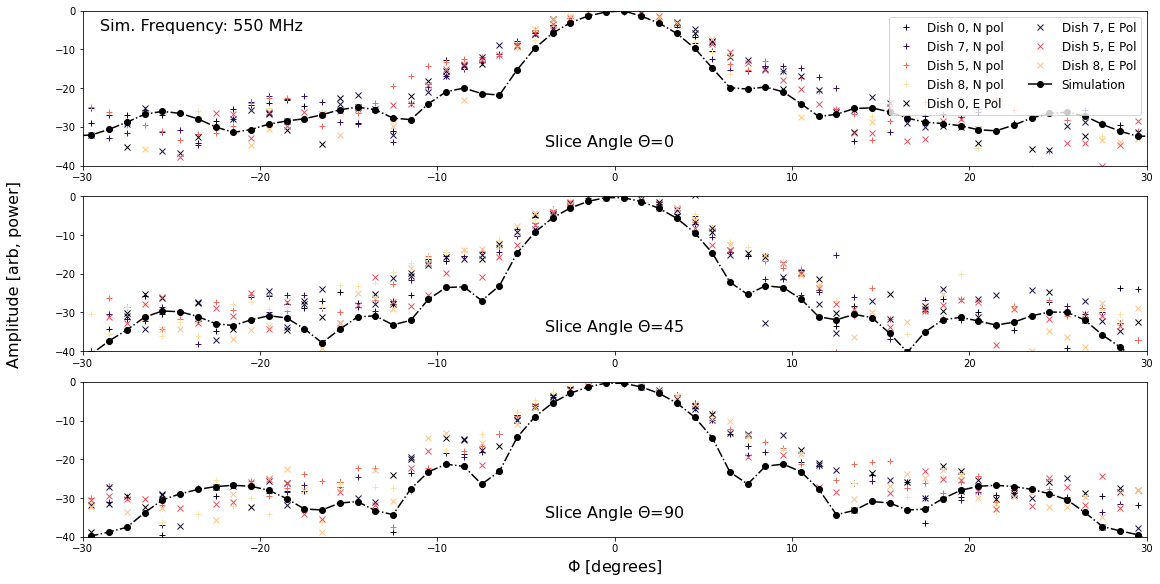

Freqs:  600 598.046875


<ipython-input-12-0facde2bf85a>:44: RuntimeWarning: invalid value encountered in log10
  ax0.plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-12-0facde2bf85a>:52: RuntimeWarning: invalid value encountered in log10
  ax1.plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-12-0facde2bf85a>:60: RuntimeWarning: invalid value encountered in log10
  ax2.plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-12-0facde2bf85a>:44: RuntimeWarning: invalid value encountered in log10
  ax0.plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-12-0facde2bf85a>:52: RuntimeWarning: invalid value encountered in log10
  ax1.plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-12-0facde2bf85a>:60: RuntimeWarning: invalid value encountered in log10
  ax2.plot(pposc,10*np.log10(dzposc),color=colorz[chind],
<ipython-input-12-0facde2bf85a>:44: RuntimeWarning: invalid value encountered in log10
  ax0.plot(pposc,10*np.log10(dzposc),color=

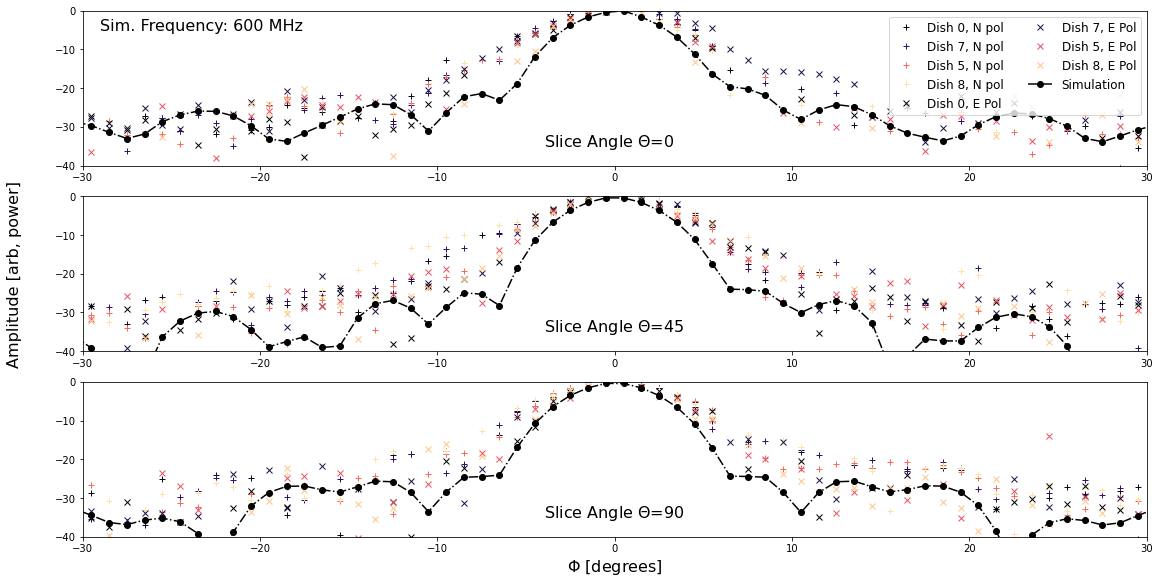

In [12]:
### Plot slices with gridspec

whichang = [0.0, np.pi/4.0, np.pi/2.]

for ff,find in enumerate(finds):
    
    print('Freqs: ', simfr[ff],freqs[find])
    
    # plot, use gridspec 

    fig = plt.figure(constrained_layout=True,figsize=(16,8))

    gs = GridSpec(3, 2, height_ratios=[0.3,0.3,0.3],width_ratios=[0.01,0.99],figure=fig)
    ax0 = fig.add_subplot(gs[0,1]) # upper 
    ax1 = fig.add_subplot(gs[1,1],sharey=ax0,sharex=ax0) # middle 
    ax2 = fig.add_subplot(gs[2,1],sharey=ax0,sharex=ax0) # right
    labax = fig.add_subplot(gs[:,0]) # xlabel
    
    #for a, ang in enumerate(whichang):

    copoldir = 'N'
    pols = N_pols

    picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
    with open(picklefile, 'rb') as inp:
        ptest = pickle.load(inp)

    for p,chind in enumerate(N_pols): 
        ppos = np.degrees(ptest.d1_centers_grid[:,:,chind])
        tpos = ptest.d0_centers_grid[:,:,chind]
        dzpos = ptest.V_LC_operation[:,:,0,chind]

        # grab a polar slice at a given angle
        ppos = np.degrees(ptest.d1_centers_grid[:,:,chind])
        tpos = ptest.d0_centers_grid[:,:,chind]
        dzpos = ptest.V_LC_operation[:,:,0,chind]
    
    
        ang = whichang[0] # 0 deg
        cc1,cc2 = get_polar_slice(tpos,ppos,val=ang,direction='t')
        pposc = np.concatenate((ppos[cc1,:],-1.0*ppos[cc2,:]))
        dzposc = np.concatenate((dzpos[cc1,:],dzpos[cc2,:]))
        
        ax0.plot(pposc,10*np.log10(dzposc),color=colorz[chind],
                    marker='+',linestyle='None',label=dlab[chind])
        
        ang = whichang[1] # 45 deg
        cc1,cc2 = get_polar_slice(tpos,ppos,val=ang,direction='t')
        pposc = np.concatenate((ppos[cc1,:],-1.0*ppos[cc2,:]))
        dzposc = np.concatenate((dzpos[cc1,:],dzpos[cc2,:]))
        
        ax1.plot(pposc,10*np.log10(dzposc),color=colorz[chind],
                    marker='+',linestyle='None')
        
        ang = whichang[2] # 90 deg
        cc1,cc2 = get_polar_slice(tpos,ppos,val=ang,direction='t')
        pposc = np.concatenate((ppos[cc1,:],-1.0*ppos[cc2,:]))
        dzposc = np.concatenate((dzpos[cc1,:],dzpos[cc2,:]))
        
        ax2.plot(pposc,10*np.log10(dzposc),color=colorz[chind],
                    marker='+',linestyle='None')
        
        
    # E pol next
    copoldir = 'E'
    pols = E_pols

    picklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
    with open(picklefile, 'rb') as inp:
        ptest = pickle.load(inp)
        
    for p,chind in enumerate(E_pols): 
        ppos = np.degrees(ptest.d1_centers_grid[:,:,chind])
        tpos = ptest.d0_centers_grid[:,:,chind]
        dzpos = ptest.V_LC_operation[:,:,0,chind]

        # grab a polar slice at a given angle
        ppos = np.degrees(ptest.d1_centers_grid[:,:,chind])
        tpos = ptest.d0_centers_grid[:,:,chind]
        dzpos = ptest.V_LC_operation[:,:,0,chind]
        
        ang = whichang[0] # 0 deg
        cc1,cc2 = get_polar_slice(tpos,ppos,val=ang,direction='t')
        pposc = np.concatenate((ppos[cc1,:],-1.0*ppos[cc2,:]))
        dzposc = np.concatenate((dzpos[cc1,:],dzpos[cc2,:]))
        
        ax0.plot(pposc,10*np.log10(dzposc),color=colorz[chind],
                    marker='x',linestyle='None',label=dlab[chind])
        
        ang = whichang[1] # 45 deg
        cc1,cc2 = get_polar_slice(tpos,ppos,val=ang,direction='t')
        pposc = np.concatenate((ppos[cc1,:],-1.0*ppos[cc2,:]))
        dzposc = np.concatenate((dzpos[cc1,:],dzpos[cc2,:]))
        
        ax1.plot(pposc,10*np.log10(dzposc),color=colorz[chind],
                    marker='x',linestyle='None')
        
        ang = whichang[2] # 90 deg
        cc1,cc2 = get_polar_slice(tpos,ppos,val=ang,direction='t')
        pposc = np.concatenate((ppos[cc1,:],-1.0*ppos[cc2,:]))
        dzposc = np.concatenate((dzpos[cc1,:],dzpos[cc2,:]))
        
        ax2.plot(pposc,10*np.log10(dzposc),color=colorz[chind],
                    marker='x',linestyle='None')
        
        
        
    # Sim 
    freq = simfr[ff]
    amp = max(dfs_sims[freq]['mag'][1])
    xpos = dfs_sims[freq]['position'][0].to_numpy()
    ypos = dfs_sims[freq]['position'][1].to_numpy()
    zpos = (dfs_sims[freq]['mag'][1].to_numpy()/amp)**2

    r = np.radians(np.sqrt(xpos**2 + ypos**2))
    thet = np.arctan2(ypos,xpos)
    thet[thet<0.0] += 2*np.pi
    xedges = ptest.d0_edges_grid[:,0,chind]
    yedges = ptest.d1_edges_grid[0,:,chind]

    binnedmap = binned_statistic_2d(x=thet,y=r,values=zpos,
                                statistic='mean',bins=[xedges,yedges]).statistic
    
    ang = whichang[0] # 0 deg
    cc1,cc2 = get_polar_slice(tpos,ppos,val=ang,direction='t')
    simz = np.concatenate((binnedmap[cc1,:][::-1],binnedmap[cc2,:]))
    pposc = np.concatenate((ppos[cc1,:][::-1],-1.0*ppos[cc2,:]))
    ax0.plot(pposc,10*np.log10(simz),color='black',
                    marker='o',linestyle='-.',label='Simulation')
        
    ang = whichang[1] # 0 deg
    cc1,cc2 = get_polar_slice(tpos,ppos,val=ang,direction='t')
    simz = np.concatenate((binnedmap[cc1,:][::-1],binnedmap[cc2,:]))
    pposc = np.concatenate((ppos[cc1,:][::-1],-1.0*ppos[cc2,:]))
    ax1.plot(pposc,10*np.log10(simz),color='black',
                    marker='o',linestyle='-.')
    
    ang = whichang[2] # 0 deg
    cc1,cc2 = get_polar_slice(tpos,ppos,val=ang,direction='t')
    simz = np.concatenate((binnedmap[cc1,:][::-1],binnedmap[cc2,:]))
    pposc = np.concatenate((ppos[cc1,:][::-1],-1.0*ppos[cc2,:]))
    ax2.plot(pposc,10*np.log10(simz),color='black',
                    marker='o',linestyle='-.')
    
    ax0.set_xlim(-30,30)
    ax0.set_ylim(-40,0)
    ax0.legend(ncol=2,fontsize=12,loc='upper right')
    ax0.text(-29,-5,'Sim. Frequency: '+str(simfr[ff])+' MHz',fontsize=16)
    
    
    ax0.text(-4,-35,r'Slice Angle $\Theta$=0',fontsize=16)
    ax1.text(-4,-35,r'Slice Angle $\Theta$=45',fontsize=16)
    ax2.text(-4,-35,r'Slice Angle $\Theta$=90',fontsize=16)
    
    ax2.set_xlabel(r'$\Phi$ [degrees]',fontsize=fsz)
    #ax0.set_ylabel('Amplitude [arb, power]',fontsize=fsz)
    #ax1.set_ylabel('Amplitude [arb, power]',fontsize=fsz)
    #ax2.set_ylabel('Amplitude [arb, power]',fontsize=fsz)
    labax.set_xticks([])
    labax.set_yticks([])
    labax.set_frame_on(False)
    labax.set_ylabel('Amplitude [arb, power]',fontsize=fsz)
    
    
    plt.show()


    

In [15]:
####################################################################################
############################# SECTION 4.3 ##########################################
############################# SECTION 4.3 ##########################################
####################################################################################

#### Cross-pol Plot. This requires by-hand normalization, and a corresponding hack for the beam class

## Create cartesian maps of the two flights, and normalize by the Gaussian peak value

fly = '618'
ffile = glob.glob(fitdir+'*'+fly+'*')[0]
print(ffile)
fits618 = np.load(ffile)
gp_618 = abs(fits618['G_popt'][:,:,0]) # amplitude


fly = '620'
ffile = glob.glob(fitdir+'*'+fly+'*')[0]
print(ffile)
fits620 = np.load(ffile)
gp_620 = abs(fits620['G_popt'][:,:,0]) # amplitude



## Class for position-space sorting/averaging of beammap flight data, from time domain data:
#defines coordinate vector from xmax to xmin spaced roughly by xres:

def cedges(args):
    cmin,cmax,cres=args
    return np.linspace(cmin,cmax,int((cmax-cmin)/cres)+1)


def get_coord_locs(coordsys,d0args,d1args,n_channels):
    ## Determine Coordinate System: coordsys='cartesian' or 'polar':
    if coordsys=='cartesian':
        Xargs=d0args
        Yargs=d1args
        #create x,y cartesian vectors (edges and centers) and grids for the beammap:
        xedges,yedges=(cedges(Xargs),cedges(Yargs))
        xedgesgrid,yedgesgrid=np.meshgrid(xedges,yedges,indexing='ij')
        xcenters,ycenters=(cedges(Xargs)[:-1]+Xargs[2]/2.0,cedges(Yargs)[:-1]+Yargs[2]/2.0)
        xcentersgrid,ycentersgrid=np.meshgrid(xcenters,ycenters,indexing='ij')        
        #need to extend this to dimensionality of channels in concatclass.V
        d0_edges=np.zeros(xedges.shape+(n_channels,))
        d1_edges=np.zeros(yedges.shape+(n_channels,))
        d0_edges_grid=np.zeros((xedgesgrid.shape+(n_channels,)))
        d1_edges_grid=np.zeros((yedgesgrid.shape+(n_channels,)))
        d0_centers=np.zeros(xcenters.shape+(n_channels,))
        d1_centers=np.zeros(ycenters.shape+(n_channels,))
        d0_centers_grid=np.zeros((xcentersgrid.shape+(n_channels,)))
        d1_centers_grid=np.zeros((ycentersgrid.shape+(n_channels,)))
        for i in range(n_channels):
            d0_edges[:,i]=xedges
            d0_centers[:,i]=xcenters
            d1_edges[:,i]=yedges
            d1_centers[:,i]=ycenters
            d0_centers_grid[:,:,i]=xcentersgrid
            d1_centers_grid[:,:,i]=ycentersgrid
            d0_edges_grid[:,:,i]=xedgesgrid
            d1_edges_grid[:,:,i]=yedgesgrid
    if coordsys=='polar':
        theta_args=d0args
        phi_args=d1args
        #create x,y cartesian vectors (edges and centers) and grids for the beammap:
        thetaedges,phiedges=(cedges(theta_args),cedges(phi_args))
        thetaedgesgrid,phiedgesgrid=np.meshgrid(thetaedges,phiedges,indexing='ij')
        thetacenters,phicenters=(cedges(theta_args)[:-1]+theta_args[2]/2.0,cedges(phi_args)[:-1]+phi_args[2]/2.0)
        thetacentersgrid,phicentersgrid=np.meshgrid(thetacenters,phicenters,indexing='ij')        
        #need to extend this to dimensionality of channels in concatclass.V
        d0_edges=np.zeros(thetaedges.shape+(n_channels,))
        d1_edges=np.zeros(phiedges.shape+(n_channels,))
        d0_edges_grid=np.zeros((thetaedgesgrid.shape+(n_channels,)))
        d1_edges_grid=np.zeros((phiedgesgrid.shape+(n_channels,)))
        d0_centers=np.zeros(thetacenters.shape+(n_channels,))
        d1_centers=np.zeros(phicenters.shape+(n_channels,))
        d0_centers_grid=np.zeros((thetacentersgrid.shape+(n_channels,)))
        d1_centers_grid=np.zeros((phicentersgrid.shape+(n_channels,)))
        for i in range(n_channels):
            d0_edges[:,i]=thetaedges
            d0_centers[:,i]=thetacenters
            d1_edges[:,i]=phiedges
            d1_centers[:,i]=phicenters
            d0_centers_grid[:,:,i]=thetacentersgrid
            d1_centers_grid[:,:,i]=phicentersgrid
            d0_edges_grid[:,:,i]=thetaedgesgrid
            d1_edges_grid[:,:,i]=phiedgesgrid    
    return d0_edges, d0_centers, d1_edges, d1_centers, d0_centers_grid, d1_centers_grid, d0_edges_grid, d1_edges_grid                 
    
def get_maskvals(coordsys):
    if coordsys=='cartesian':
        maskin = 18
        maskout = 40
    if coordsys=='polar':
        maskin = 6*np.pi/180.
        maskout = 12*np.pi/180
    return maskin, maskout

        
class Beammap_nonorm:
    
    def __init__(self,concatlist=[],#coordsys='cartesian',d0args=[-100,100,5],d1args=[-100,100,5],\
                 coordsys='polar',d0args=[0,360*(np.pi/180.0),6*(np.pi/180.0)],d1args=[0,25*(np.pi/180.0),0.5*(np.pi/180.0)],\
                 Fargs=[0,1024,1],f_index=900,\
                 operation='coadd',inputstyle='pickle',vplot=False,\
                 pickle_directory='/hirax/GBO_Analysis_Outputs/flight_pickles/',\
                 gfit_directory='/hirax/GBO_Analysis_Outputs/main_beam_fits/',\
                 flightmasterpath='/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml',\
                 ampcorr_directory='/hirax/GBO_Analysis_Outputs/amplitude_corrections/',\
                 include_cross_data=False,mask=False):
        ## enable format of input to be load from 'pickle' filestring or bin/map using concat 'class':        
        self.gfit_directory = gfit_directory
        self.ampcorr_directory = ampcorr_directory  
        self.pickle_directory = pickle_directory
        nchanslist=np.zeros(len(concatlist))


        for h,cstring in enumerate(concatlist):
            print(cstring)
            ## using the with loop structure, the pickle file is closed after ccc is loaded:
            with open(cstring, "rb") as f:
                CONCATCLASS=pickle.load(f)
            nchanslist[h]=CONCATCLASS.n_channels
            self.FLYNUM=cstring.split('FLY')[1].split('_')[0]
        ## determine which channel is co-pol, for frequency dependent centroid corrections:
        with open(flightmasterpath, 'r') as flightmaster:
            doccs = yaml.safe_load(flightmaster)
            for j,fstr in enumerate(doccs['flight_info']['flights']):
                if self.FLYNUM in fstr:
                    self.copoldir=doccs['flight_info']['pols'][j]
        #get variables that should be kept along from the first concat class:         
        self.name=CONCATCLASS.name
        self.Data_Directory=CONCATCLASS.Data_Directory
        self.Gain_Directory=CONCATCLASS.Gain_Directory
        self.filenames=CONCATCLASS.filenames
        self.gainfile=CONCATCLASS.gainfile
        self.Drone_Directory=CONCATCLASS.Drone_Directory
        self.FLYTAG=CONCATCLASS.FLYTAG
        self.n_dishes=CONCATCLASS.n_dishes
        self.n_channels=int(np.nanmin(nchanslist))
        self.n_concats=len(concatlist)
        self.chmap=CONCATCLASS.chmap
        self.automap=CONCATCLASS.automap
        self.crossmap=CONCATCLASS.crossmap
        self.origin=CONCATCLASS.origin
        #self.prime_origin=CONCATCLASS.prime_origin ## omit, it breaks the pickle
        self.dish_keystrings=CONCATCLASS.dish_keystrings
        self.dish_coords=CONCATCLASS.dish_coords
        self.dish_pointings=CONCATCLASS.dish_pointings
        self.dish_polarizations=CONCATCLASS.dish_polarizations
        self.fmin,self.fmax,self.fstep=Fargs
        self.faxis=np.arange(self.fmin,self.fmax,self.fstep)
        self.n_freqs=len(self.faxis)
        self.freq=CONCATCLASS.freq[self.faxis]
        find=np.where(self.faxis==f_index)[0][0]
        self.operation=operation
        self.coordsys=coordsys
        
        (self.d0_edges, self.d0_centers, self.d1_edges, self.d1_centers, 
             self.d0_centers_grid, self.d1_centers_grid, self.d0_edges_grid, 
             self.d1_edges_grid) = get_coord_locs(coordsys,d0args,d1args,self.n_channels)

        ## now need frequency dependent offset terms in shape (freq, channel, concat) to mimic V
        self.x_offsets=np.NAN*np.ones((len(self.freq),self.n_channels,self.n_concats))
        self.y_offsets=np.NAN*np.ones((len(self.freq),self.n_channels,self.n_concats))        
        ## create arrays for V mean, V std, and histo: shape is (gridx, gridy, freq, chans, concatlist)
        self.V_LC_mean=np.NAN*np.ones((len(self.d0_centers[:,0]),len(self.d1_centers[:,0]),len(self.freq),self.n_channels,self.n_concats))
        self.V_LC_std=np.NAN*np.ones((len(self.d0_centers[:,0]),len(self.d1_centers[:,0]),len(self.freq),self.n_channels,self.n_concats))
        self.histogram_LC=np.NAN*np.ones((len(self.d0_centers[:,0]),len(self.d1_centers[:,0]),len(self.freq),self.n_channels,self.n_concats))
        ## create arrays for V mean, V std, and histo: shape is (gridx, gridy, freq, chans, concatlist)
        self.V_LC_sum=np.NAN*np.ones((len(self.d0_centers[:,0]),len(self.d1_centers[:,0]),
                                      self.n_freqs,self.n_channels,self.n_concats))
        self.V_LC_count=np.NAN*np.ones((len(self.d0_centers[:,0]),len(self.d1_centers[:,0]),
                                        self.n_freqs,self.n_channels,self.n_concats))
            
        print("start of big ass loop is: {}".format(datetime.datetime.now()))
        
        for h,cstring in enumerate(concatlist):
            self.FLYNUM=cstring.split('FLY')[1].split('_')[0]
            
            Vvals, fccoords = self.get_VVals_tempcoords(cstring,h,doccs)                       

            ## loop through channels (i,chan) to find indices of nonzero cells in histogram
            for i,chan in enumerate(range(self.n_channels)):
                for j,fr in enumerate(self.faxis):
                    print('autos: Concat:{}/{}, Channel:{}/{}, Frequency:{}/{},           '.format(h+1,self.n_concats,i+1,self.n_channels,j+1,len(self.freq)),end='\r')
                    if coordsys=='cartesian':
                        xf,yf=fccoords[i,:,0,j],fccoords[i,:,1,j]
                    elif coordsys=='polar':
                        polcoords=np.array([gu.xyz_to_rpt(fccoords[i,k,:,j]) for k in range(len(fccoords[i,:,:,j]))])
                        xf,yf=polcoords[:,1],polcoords[:,2]                      
                    valsf=Vvals[:,j,i]    
                    
                    #histo2d,xbins,ybins=np.histogram2d(x,y,bins=[self.x_edges[:,i],self.y_edges[:,i]])
                    self.histogram_LC[:,:,j,i,h]=binned_statistic_2d(x=xf,y=yf,values=valsf,statistic='count',bins=[self.d0_edges[:,i],self.d1_edges[:,i]]).statistic
                    self.V_LC_sum[:,:,j,i,h]=binned_statistic_2d(x=xf,y=yf,values=valsf,statistic='sum',bins=[self.d0_edges[:,i],self.d1_edges[:,i]]).statistic
                    self.V_LC_count[:,:,j,i,h]=binned_statistic_2d(x=xf,y=yf,values=valsf,statistic='count',bins=[self.d0_edges[:,i],self.d1_edges[:,i]]).statistic
                        
        print("end of bigass loop is: {}".format(datetime.datetime.now()))

        # set 0 values to nans for all
        self.V_LC_count[self.V_LC_count == 0] = 'nan'
        self.V_LC_sum[self.V_LC_sum == 0] = 'nan'
        
        if operation=='coadd' or operation=='std': 
            self.V_LC_operation=np.NAN*np.ones(self.V_LC_sum[:,:,:,:,0].shape)
            self.V_LC_operation_err=np.NAN*np.ones(self.V_LC_sum[:,:,:,:,0].shape)
            self.V_LC_operation_count=np.NAN*np.ones(self.V_LC_sum[:,:,:,:,0].shape)
            
            # average all bins together
            self.V_LC_operation_count = np.nansum(self.V_LC_count,axis=4)
            self.V_LC_operation = np.nansum(self.V_LC_sum,axis=4)/self.V_LC_operation_count
            #self.V_LC_operation=np.nanmean(self.V_LC_mean,axis=4)            
        
        
        print("end of concat loop is: {}".format(datetime.datetime.now()))
                                
    
    
    def get_VVals_tempcoords(self,cstring,h,doccs):
                
        for j,fstr in enumerate(doccs['flight_info']['flights']):
            if self.FLYNUM in fstr:
                self.copoldir=doccs['flight_info']['pols'][j]
                    
        ## using the with loop structure, the pickle file is closed after ccc is loaded:
        with open(cstring, "rb") as f:
            ccc=pickle.load(f)   
        t_cut=ccc.inds_on
        
        # get the normalization:
        gfit=glob.glob(self.gfit_directory+'*'+self.FLYNUM+'*.npz')[0]
        print(self.FLYNUM,gfit)
        gff = np.load(gfit)
        g_norm=gff['G_popt'][:,:,0]
        Vvals=ccc.V_bgsub[ccc.inds_on,self.fmin:self.fmax:self.fstep,:]       
                
        for i in range(self.n_channels):
            if self.copoldir in 'E':
                COPOLIND=np.arange(self.n_channels).reshape(int(self.n_channels/2),2)[int(i/2)][0]
                self.x_offsets[:,i,h]=gff['G_popt'][COPOLIND,self.faxis,1]-ccc.dish_coords[i][0] # seems like gauss params were found with original xyz, so remove dish offset
                self.y_offsets[:,i,h]=gff['G_popt'][COPOLIND,self.faxis,3]-ccc.dish_coords[i][1] # seems like gauss params were found with original xyz, so remove dish offset
            elif self.copoldir in 'N':
                COPOLIND=np.arange(self.n_channels).reshape(int(self.n_channels/2),2)[int(i/2)][1]
                self.x_offsets[:,i,h]=gff['G_popt'][COPOLIND,self.faxis,1]-ccc.dish_coords[i][0] # seems like gauss params were found with original xyz, so remove dish offset
                self.y_offsets[:,i,h]=gff['G_popt'][COPOLIND,self.faxis,3]-ccc.dish_coords[i][1] # seems like gauss params were found with original xyz, so remove dish offset

                            
        ## create centroid-corrected per channel and frequency drone coordinate maps on a per-concat basis:
        tmpcoords=np.repeat(ccc.drone_xyz_per_dish_interp[:,:,:,np.newaxis],self.n_freqs,axis=3)
        shiftvec=np.array((self.x_offsets[:,:,h],self.y_offsets[:,:,h],np.zeros(self.x_offsets[:,:,h].shape)))
        tmpshifts=np.repeat(np.swapaxes(np.swapaxes(shiftvec,0,2),1,2)[:,np.newaxis,:,:],len(ccc.t),axis=1)
        fccoords=(tmpcoords-tmpshifts)[:,ccc.inds_on]
                
        return Vvals,fccoords 
                

        
pflights = ['618','620']


fly = '618'
pol, pols, cpols, attn, fi = get_flightinfo(fly)
print(fly,pol,pols,cpols, attn)
concytest=glob.glob(pckldir+'*FLY'+fly+'*')
print(concytest)

beam618=Beammap_nonorm(concatlist=concytest,coordsys='cartesian',
                 operation='coadd',d0args=[-41.5,40,3],d1args=[-41.5,40,3],
                 Fargs=[find,find+1,1],f_index=find,vplot=False)

fly = '620'
pol, pols, cpols, attn, fi = get_flightinfo(fly)
print(fly,pol,pols,cpols, attn)
concytest=glob.glob(pckldir+'*FLY'+fly+'*')
print(concytest)

beam620=Beammap_nonorm(concatlist=concytest,coordsys='cartesian',
                 operation='coadd',d0args=[-41.5,40,3],d1args=[-41.5,40,3],
                 Fargs=[find,find+1,1],f_index=find,vplot=False)









/hirax/GBO_Analysis_Outputs/main_beam_fits/FLY618_20211021T183430Z_2dGauss_and_Airy_Params.npz
/hirax/GBO_Analysis_Outputs/main_beam_fits/FLY620_20211021T192212Z_2dGauss_and_Airy_Params.npz
618 N [1, 3, 11, 15] [0, 2, 10, 14] 46
['/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl']
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20231012T003521_concat.pkl
start of big ass loop is: 2024-11-04 16:45:47.646510
618 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY618_20211021T183430Z_2dGauss_and_Airy_Params.npz
end of bigass loop is: 2024-11-04 16:45:50.184558          
end of concat loop is: 2024-11-04 16:45:50.185287


<ipython-input-15-b838931c8c70>:211: RuntimeWarning: invalid value encountered in true_divide
  self.V_LC_operation = np.nansum(self.V_LC_sum,axis=4)/self.V_LC_operation_count


620 E [0, 2, 10, 14] [1, 3, 11, 15] 46
['/hirax/GBO_Analysis_Outputs/flight_pickles/FLY620_20211021T192212Z_ver_20231012T012215_concat.pkl']
/hirax/GBO_Analysis_Outputs/flight_pickles/FLY620_20211021T192212Z_ver_20231012T012215_concat.pkl
start of big ass loop is: 2024-11-04 16:45:53.508482
620 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY620_20211021T192212Z_2dGauss_and_Airy_Params.npz
end of bigass loop is: 2024-11-04 16:45:56.060824          
end of concat loop is: 2024-11-04 16:45:56.061473


Ncross correction:  1.0435999159137213 Ecross correction:  0.9582216180273
1 -12.57024820699592
3 -12.288144167445441
11 -16.43590310349319
15 -13.460529639246172
0 -21.49440620149455
2 -20.249500856131775
10 -23.58142403625404
14 -18.365923894419268
[ 2.92208476  6.01605685  8.99543738 12.0321137 ]


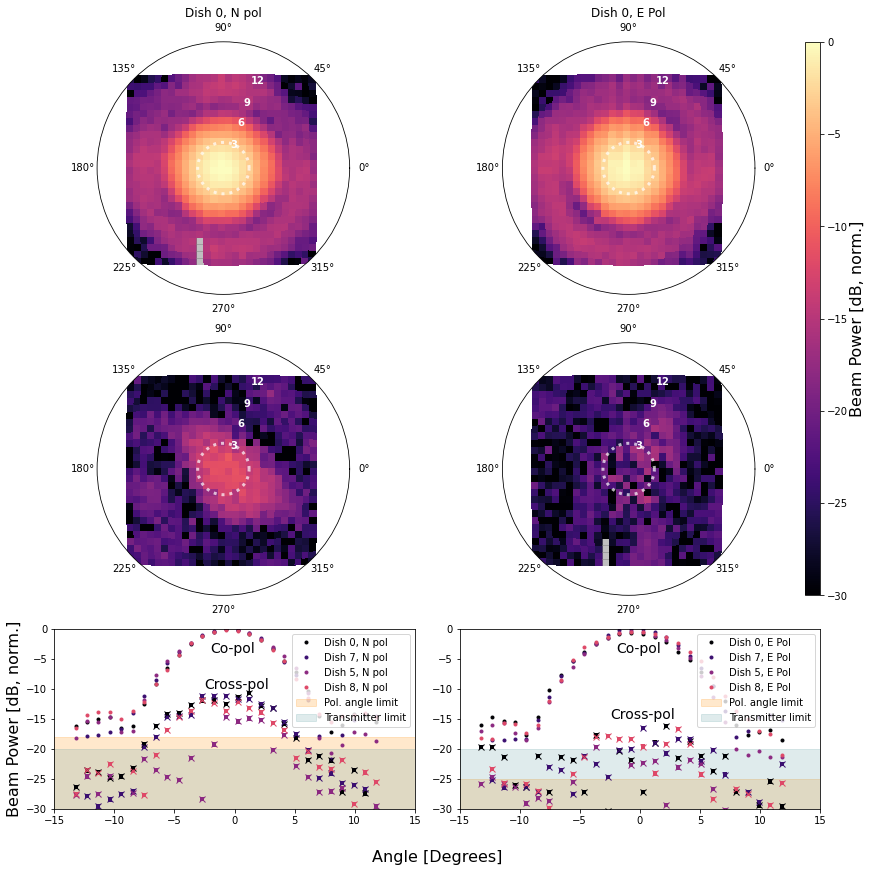

In [23]:
# correct for height difference between 618 and 620
# only implicated in the cross pol, since the co-pol would be normalized to the height appropriately

h618 = 174.75
h620 = 178.5189  

# if h618 is normalized to 1.0, then the correction for the crosspol for the Npol during flight 620 is
# h620 is higher, so measured cross pol signal is dimmer than if measured at the same height. 
# Correction should be greater than 1 to compensate
# Opposite for Ecross

Ncross_hcorr = (h620/h618)**2 
Ecross_hcorr = (h618/h620)**2
print('Ncross correction: ', Ncross_hcorr, 'Ecross correction: ', Ecross_hcorr)


# Systematics floor, take 4\%
syserr = 0.08

# compute errorbars
def get_dberrs(syserr,d2data):
    #deltadB_up = 10*np.log10(delta_up) - 10*np.log10(d2data) # this should be the same as 10*log10(ratio)
    deltadB_up = 10*np.log10(1+syserr) 
    deltadB_down = 10*np.log10(1-syserr)
    return deltadB_down*np.ones(d2data.shape), deltadB_up*np.ones(d2data.shape)

# what is the average cross-pol value within the main beam, for our favorite frequency, for each input
colorz=pu.cm_to_discrete(ccm, 5)
vmi = -30
vma = 0 
find = 900

z = 177.0 # converting xyz to theta,phi, need to assume a height

for i,chind in enumerate(N_pols):   
    
    xcrs = beam620.d0_edges_grid[:,:,chind]
    ycrs = beam620.d1_edges_grid[:,:,chind]
    rcrs = np.sqrt(xcrs**2 + ycrs**2 + z**2)
    thetacrs = np.arccos(z/rcrs)
    phicrs = np.sign(ycrs)*np.arccos(xcrs / np.sqrt(xcrs**2 + ycrs**2))
    zcrs = 10*np.log10(Ncross_hcorr*np.abs(beam620.V_LC_operation[:,:,0,chind] / gp_618[chind,find]))
    
    thingy = []
    for i in np.arange(0,len(beam620.d0_edges_grid[:,0,chind])):
        for j in np.arange(0,len(beam620.d0_edges_grid[0,:,chind])):
            if thetacrs[i,j] < np.radians(3.5): 
                #thingy.append(zcrs[i,j])
                thingy.append(10**(zcrs[i,j]/10.))
    print(chind,10*np.log10(np.nanmedian(thingy)))
    
for i,chind in enumerate(E_pols): 
    
    xcrs = beam618.d0_edges_grid[:,:,chind]
    ycrs = beam618.d1_edges_grid[:,:,chind]
    rcrs = np.sqrt(xcrs**2 + ycrs**2 + z**2)
    thetacrs = np.arccos(z/rcrs)
    phicrs = np.sign(ycrs)*np.arccos(xcrs / np.sqrt(xcrs**2 + ycrs**2))
    zcrs = 10*np.log10(np.abs(Ecross_hcorr*beam618.V_LC_operation[:,:,0,chind] / gp_620[chind,find]))
    
    thingy = []
    for i in np.arange(0,len(beam620.d0_edges_grid[:,0,chind])):
        for j in np.arange(0,len(beam620.d0_edges_grid[0,:,chind])):
            if thetacrs[i,j] < np.radians(3.5): 
                #thingy.append(zcrs[i,j])
                thingy.append(10**(zcrs[i,j]/10.))
    print(chind,10*np.log10(np.nanmedian(thingy)))
    
    
     
    
# plot, use gridspec 

fig = plt.figure(constrained_layout=True,figsize=(12,12))

gs = GridSpec(4, 4, height_ratios=[0.35,0.35,0.25,0.02], width_ratios=[0.45,0.02,0.45,0.02],figure=fig)
ax0 = fig.add_subplot(gs[0, 0],polar=True) # upper left
ax1 = fig.add_subplot(gs[0, 2],polar=True) # upper right 
ax2 = fig.add_subplot(gs[1, 0],polar=True) # middle left
ax3 = fig.add_subplot(gs[1, 2],polar=True) # middle right
ax4 = fig.add_subplot(gs[2, 0:2]) # lower left
ax5 = fig.add_subplot(gs[2, 2:4],sharey=ax4,sharex=ax4) # lower right
labax = fig.add_subplot(gs[3,:]) # xlabel
cbax = fig.add_subplot(gs[0:2,3]) # colorbar
eax = fig.add_subplot(gs[0:2,1]) # empty axis to center things


# plot things in the right places
for i,chind in enumerate(N_pols): 
    xco = beam618.d0_edges_grid[:,:,chind]
    yco = beam618.d1_edges_grid[:,:,chind]
    zco = 10*np.log10(np.abs(beam618.V_LC_operation[:,:,0,chind] / gp_618[chind,find]))   
    rco = np.sqrt(xco**2 + yco**2 + z**2)
    thetaco = np.arccos(z/rco)
    phico = np.sign(yco)*np.arccos(xco / np.sqrt(xco**2 + yco**2))
    
    
    
    xcrs = beam620.d0_edges_grid[:,:,chind]
    ycrs = beam620.d1_edges_grid[:,:,chind]
    rcrs = np.sqrt(xcrs**2 + ycrs**2 + z**2)
    thetacrs = np.arccos(z/rcrs)
    phicrs = np.sign(ycrs)*np.arccos(xcrs / np.sqrt(xcrs**2 + ycrs**2))
    
    zcrs = 10*np.log10(Ncross_hcorr*np.abs(beam620.V_LC_operation[:,:,0,chind] / gp_618[chind,find]))
    zcrs_l, zcrs_u = get_dberrs(syserr,Ncross_hcorr*np.abs(beam620.V_LC_operation[:,:,0,chind] / gp_618[chind,find]))
    
    if chind==N_pols[0]: # plot only the first channel
        ax0.pcolormesh(phico,thetaco,zco,
            cmap=cm.magma,vmin=vmi,vmax=vma) 
        ax0.set_ylim(0,0.3)
        ax0.set_title(dlab[chind])

        # plot scatter plot and beam map
        ax2.pcolormesh(phicrs,thetacrs,zcrs,
            cmap=cm.magma,vmin=vmi,vmax=vma)   
        ax2.set_ylim(0,0.3)
        
    ixd = pu.get_slice(xco,yco,zco,0.0, sliceOrientation='v')
    ax4.plot(convert_to_angle(yco[ixd,0:-1]),zco[ixd,:],color=colorz[i],marker='.',linestyle='None',
             label=dlab[chind])
    ixd = pu.get_slice(xcrs,ycrs,zcrs,0.0, sliceOrientation='v')
    ax4.errorbar(convert_to_angle(ycrs[ixd,0:-1]),zcrs[ixd,:],
                 yerr = (-1*zcrs_l[ixd,:], zcrs_u[ixd,:]),
                 color=colorz[i],ecolor=colorz[i],marker='x',elinewidth=4,linestyle='None')
    ax4.set_ylim(-30,0)
    ax4.set_xlim(-15,15)

    
for i,chind in enumerate(E_pols): 
    xco = beam620.d0_edges_grid[:,:,chind]
    yco = beam620.d1_edges_grid[:,:,chind]
    zco = 10*np.log10(Ecross_hcorr*np.abs(beam620.V_LC_operation[:,:,0,chind] / gp_620[chind,find]))
    
    xcrs = beam618.d0_edges_grid[:,:,chind]
    ycrs = beam618.d1_edges_grid[:,:,chind]
    zcrs = 10*np.log10(Ecross_hcorr*np.abs(beam618.V_LC_operation[:,:,0,chind] / gp_620[chind,find]))
    zcrs_l, zcrs_u = get_dberrs(syserr,Ecross_hcorr*np.abs(beam618.V_LC_operation[:,:,0,chind] / gp_620[chind,find]))

    if chind==E_pols[0]: # plot only the first channel
        plt0 = ax1.pcolormesh(phico,thetaco,zco,
            cmap=cm.magma,vmin=vmi,vmax=vma) 
        ax1.set_ylim(0,0.3)
        ax1.set_title(dlab[chind])

        # plot scatter plot and beam map
        ax3.pcolormesh(phicrs,thetacrs,zcrs,
            cmap=cm.magma,vmin=vmi,vmax=vma)   
        ax3.set_ylim(0,0.3)

    ixd = pu.get_slice(xco,yco,zco,0.0, sliceOrientation='v')
    ax5.plot(convert_to_angle(yco[ixd,0:-1]),zco[ixd,:],
             color=colorz[i],marker='.',linestyle='None',label=dlab[chind])

    ixd = pu.get_slice(xcrs,ycrs,zcrs,0.0, sliceOrientation='v')
    ax5.errorbar(convert_to_angle(ycrs[ixd,0:-1]),zcrs[ixd,:],
                yerr = (-1*zcrs_l[ixd,:], zcrs_u[ixd,:]),
                 color=colorz[i],ecolor=colorz[i],marker='x',elinewidth=4,linestyle='None')
    
# x axis label
labax.set_xticks([])
labax.set_yticks([])
labax.set_frame_on(False)
labax.set_xlabel("Angle [Degrees]",fontsize=fsz,labelpad=-1)

# Special empty axis
eax.set_xticks([])
eax.set_yticks([])
eax.set_frame_on(False)

# add colorbar
cb = Colorbar(ax = cbax, mappable = plt0, orientation = 'vertical', ticklocation = 'right')
cb.set_label('Beam Power [dB, norm.]', labelpad=2,fontsize=fsz)

# other labels and tick specialties
ax4.set_ylabel('Beam Power [dB, norm.]',fontsize=fsz)
ax4.text(-2.5,-10,'Cross-pol',color=colorz[0],fontsize=14)
ax4.text(-2,-4,'Co-pol',color=colorz[0],fontsize=14)
ax5.text(-2.5,-15,'Cross-pol',color=colorz[0],fontsize=14)
ax5.text(-2,-4,'Co-pol',color=colorz[0],fontsize=14)



# add white ticks and lines

thetas = np.arange(0,2*np.pi,0.01)
phis1 = np.radians(3.5)*np.ones(len(thetas))

r = (0.051,0.105,0.157,0.21)
rt = ('3','6','9','12')
print(np.degrees(r))

ax0.set_yticks([])
for ri in np.arange(len(r)): 
    ax0.text(np.pi/2.5,r[ri],rt[ri],color='white',fontweight='heavy')
ax0.plot(thetas,phis1,color='white',alpha=0.7,linestyle=':',linewidth=3)

ax2.set_yticks([])
for ri in np.arange(len(r)): 
    ax2.text(np.pi/2.5,r[ri],rt[ri],color='white',fontweight='heavy')
ax2.plot(thetas,phis1,color='white',alpha=0.7,linestyle=':',linewidth=3)

ax1.set_yticks([])
for ri in np.arange(len(r)): 
    ax1.text(np.pi/2.5,r[ri],rt[ri],color='white',fontweight='heavy')
ax1.plot(thetas,phis1,color='white',alpha=0.7,linestyle=':',linewidth=3)

ax3.set_yticks([])
for ri in np.arange(len(r)): 
    ax3.text(np.pi/2.5,r[ri],rt[ri],color='white',fontweight='heavy')
ax3.plot(thetas,phis1,color='white',alpha=0.7,linestyle=':',linewidth=3)

ax4.axhspan(-30,-18,color='darkorange',alpha=0.2,label='Pol. angle limit')
#ax4.text(-4,-21,'Pol. angle limit',color='black',fontsize=14)

ax5.axhspan(-30,-25,color='darkorange',alpha=0.2,label='Pol. angle limit')
#ax5.text(-4,-28,'Pol. angle limit',color='black',fontsize=14)

ax4.axhspan(-30,-20,color='cadetblue',alpha=0.2,label='Transmitter limit')
#ax4.text(-4,-21,'Transmitter limit',color='black',fontsize=14)

ax5.axhspan(-30,-20,color='cadetblue',alpha=0.2,label='Transmitter limit')
#ax5.text(-4,-28,'Transmitter limit',color='black',fontsize=14)

ax4.legend(fontsize=10)
ax5.legend(fontsize=10)

plt.show()






In [ ]:
#### Check for systenatmics that would give difference between E and N

### HOW MUCH COULD GAIN HAVE VARIED?
## Look at amplitudes from flight 618, 619 620, 623, 625:

pflights = ['618','619','623','625']
normarr = np.zeros([1024,16,len(pflights)])

for i, fly in enumerate(pflights):
    if fly == '618':
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        Gamp = np.swapaxes(fits['G_popt'][:,:,0],0,1)
        normarr[:,:,i] = Gamp
    else:
        ffile = glob.glob(fitdir+'*'+fly+'*')[0]
        fits = np.load(ffile)
        Gamp = np.swapaxes(fits['G_popt'][:,:,0],0,1)
        pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
        with open(pklfile, 'rb') as inp:
            amps = pickle.load(inp)
        normarr[:,:,i] = Gamp*amps[0,:,:]

fl1 = 0
fl2 = 2
for p in N_pols:
    tt = np.mean(2*(normarr[good_freqs,p,fl2]-normarr[good_freqs,p,fl1])/(normarr[good_freqs,p,fl2]+normarr[good_freqs,p,fl1]),axis=0)
    print('Input: ',p, 'Average difference between normalizations across all good frequencies: ', tt)
    
find = 900
tt = np.nanmean(2*(normarr[find,N_pols,fl2]-normarr[find,N_pols,fl1])/(normarr[find,N_pols,fl2]+normarr[find,N_pols,fl1]),axis=0)
print('Average difference across inputs between normalizations at input : ', find, tt)

for p in N_pols:
    tt = 100*(2*(normarr[find,p,fl2]-normarr[find,p,fl1]))/(normarr[find,p,fl2]+normarr[find,p,fl1])
    print('Difference (%)  across only input 1 between normalizations : ', p, tt) 

for p in N_pols:
    tt = 100*np.mean(2*(normarr[good_freqs,p,fl2]-normarr[good_freqs,p,fl1])/(normarr[good_freqs,p,fl2]+normarr[good_freqs,p,fl1]),axis=0)
    print('Input: ',p, 'Average difference (%) between normalizations across all good frequencies: ', tt)



# set up which direction the gains would matter.....

N618 = 1.0
N620 = 0.1

N618_gain = 100

E618 = 0.2
E620 = 1.0

E620_gain = 104 

Ncross = (N620/N618_gain) / (E620/E620_gain)
print(Ncross, 'Ncrossgain by', E620_gain/N618_gain)

Ecross = (E618/E620_gain) / (N618/N618_gain)
print(Ecross, 'Ecrossgain by', N618_gain/E620_gain)

# Could height changes shift this?
h618 = 174.75
h620 = 178.5189

print((h618/h620)**2)

N618 = 1.0
N620 = 0.1

N618_gain = 100

E618 = 0.1
E620 = 1.0

E620_gain = 95 

Ncross = (N620/N618_gain) / (E620/E620_gain)
print(Ncross, 'Ncrossgain by', E620_gain/N618_gain)

Ecross = (E618/E620_gain) / (N618/N618_gain)
print(Ecross, 'Ecrossgain by', N618_gain/E620_gain)

20211020T215911Z /hirax/GBO_Oct_2021/TONE_ACQ/20211020T215858Z_yale_drone/corr/20211020T215911Z/ /hirax/GBO_Oct_2021/TONE_ACQ/digital_gains/20211020T215858Z_yale_drone_yale_digitalgain/
Initializing drone data via datcon_csv routine: FLY608.csv
  --> Skipping rows 1 to 499 to eliminate NAN values
  --> Attempting to load position data from RTK
    --> RTK Data not found for this data file...
  --> Loading position data from GPS(0) instead:
Timestamp interpolation succeeded
  --> generating llh, geocentric cartesian, local cartesian, and local spherical coordinates.
  --> generating dish and receiver line of sight coordinates.
DONE reading in drone data
2021-10-20 22:01:03.800000+00:00 2021-10-20 22:12:56.996000+00:00
plotting drone coordinates for all time samples:
overplotting drone coordinates for t_cut samples: [0:-1]
start time:  2024-10-29 09:57:17.853939
Initializing Correlator Class using:
  --> /hirax/GBO_Oct_2021/TONE_ACQ/20211020T215858Z_yale_drone/corr/20211020T215911Z/
  --

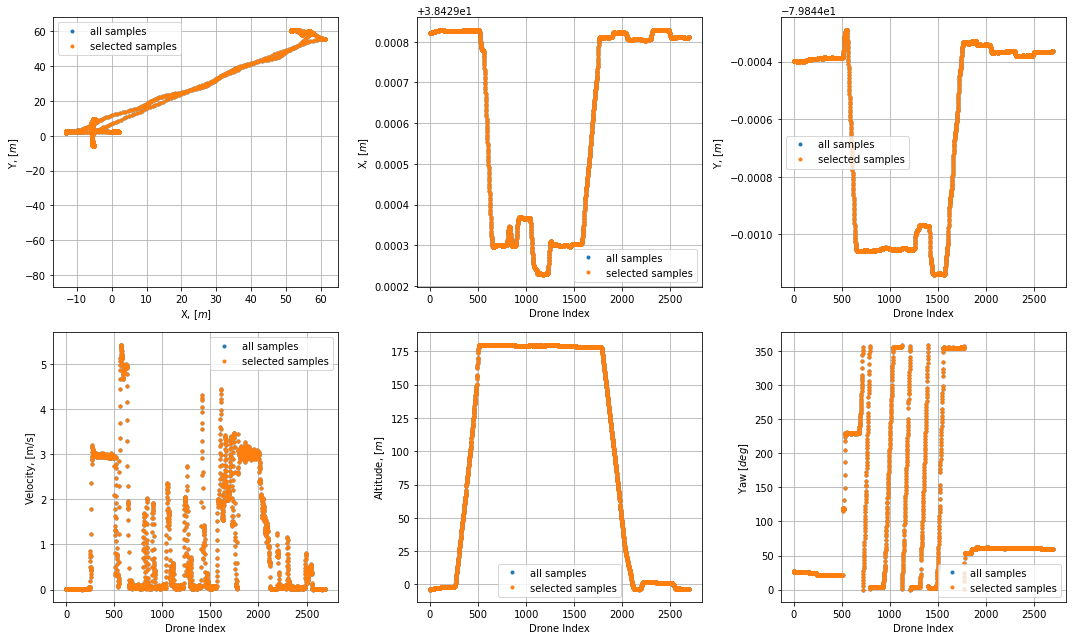

In [8]:
####################################################################################
############################# SECTION 4.4 ##########################################
############################# SECTION 4.4 ##########################################
####################################################################################


# This is the 360 degree rotation analysis. Here we:
# 1. read in the raw drone and correlator files
# 2. concatenate
# 3. Use the time periods Emily identified as the rotations
# 4. Time shift by hand to account for timing offset
# 5. Pick the highest SNR location 
# 6. Fit cos^2 function
# 7. Plot
# I've separated the analysis from the plotting because reading in and fitting takes a while

#1.  Read the yaml for the flight you're interested in:
fly = '608'
cdat = '20211020T215858Z'

if int(fly) < 537:
    mdir='/hirax/GBO_Aug_2021/TONE_ACQ/'+cdat+'_yale_drone/corr/' # August 2021
    gaindir='/hirax/GBO_Aug_2021/TONE_ACQ/digital_gains/'+cdat+'_yale_drone_yale_digitalgain/' # August 2021
else:
    mdir='/hirax/GBO_Oct_2021/TONE_ACQ/'+cdat+'_yale_drone/corr/' # Oct 2021
    gaindir='/hirax/GBO_Oct_2021/TONE_ACQ/digital_gains/'+cdat+'_yale_drone_yale_digitalgain/' # Oct 2021

sdir = os.listdir(mdir)[0]
datadir=mdir+sdir+'/'
print(sdir, datadir,gaindir)
    
dronedir='/hirax/all_drone_data/datcon_csv/'
dronetest0825=drone.Drone_Data(Drone_Directory=dronedir,FLYTAG='FLY'+fly+'.csv',site_class=gbosite,tlb=0,tub=-1)

print('DONE reading in drone data')
print(dronetest0825.t_arr_datetime[0], dronetest0825.t_arr_datetime[-1])
pu.Plot_Drone_Coordinates(dronetest0825,coo='xy')#,t_bounds=[tlb,tub])

## Combine drone and correlator data
print('start time: ', datetime.datetime.now())
corrtest0825=corr.Corr_Data(Data_Directory=datadir,
                            Gain_Directory=gaindir,site_class=gbosite,
                            crossmap=[])

    
print('end time: ', datetime.datetime.now())


config_directory="/hirax/GBO_Analysis_Outputs/concat_config_files/"

concattest=concat.CONCAT(CORRDATCLASS=corrtest0825,DRONEDATCLASS=dronetest0825,\
                             load_yaml=False,traceback=False,save_traceback=False)




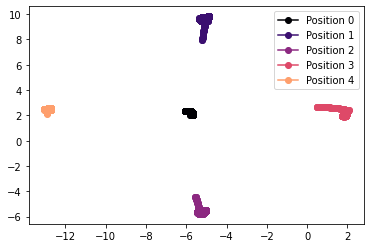

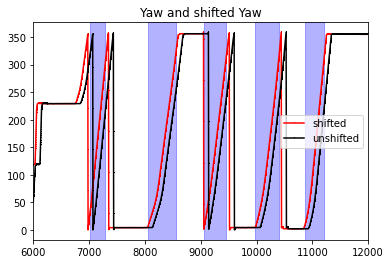

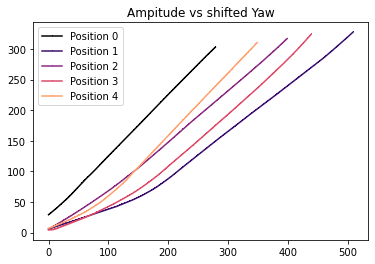

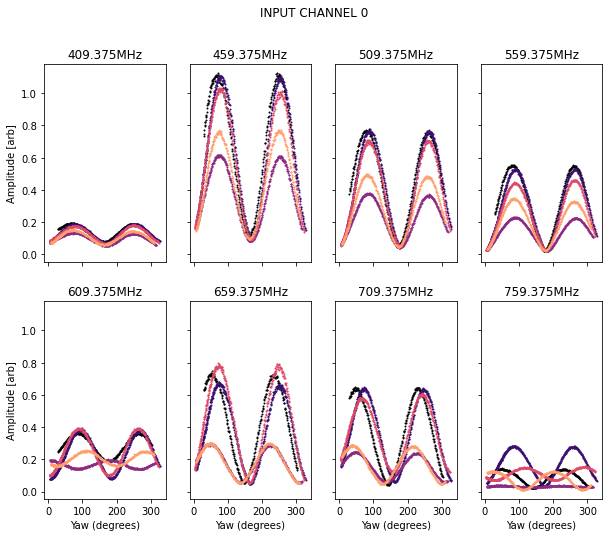

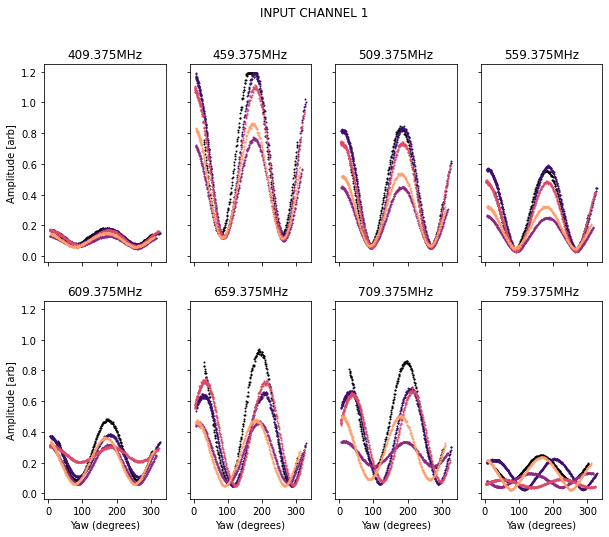

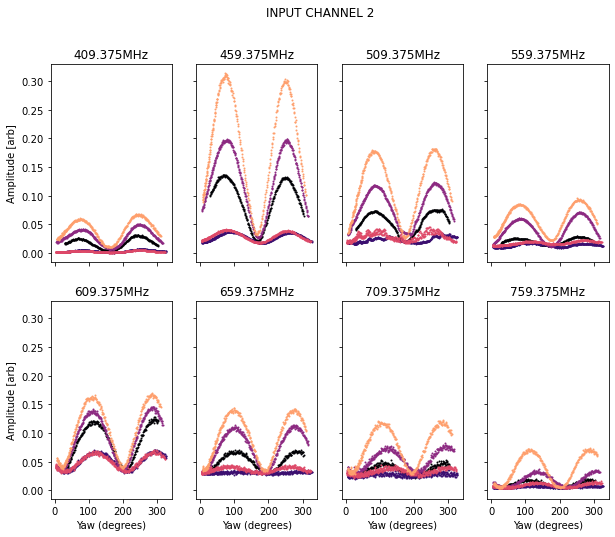

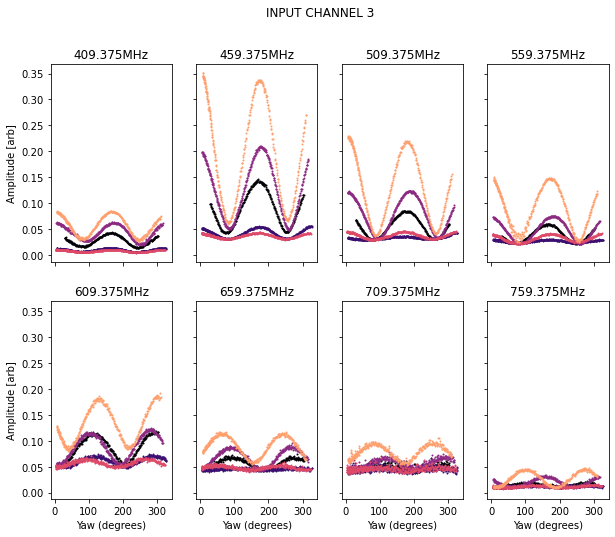

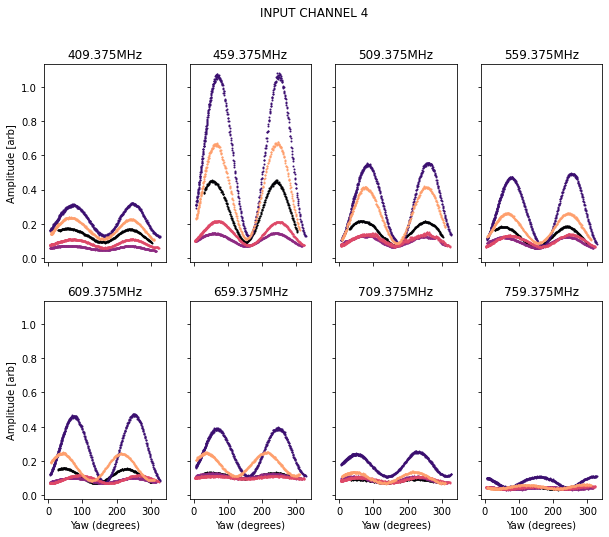

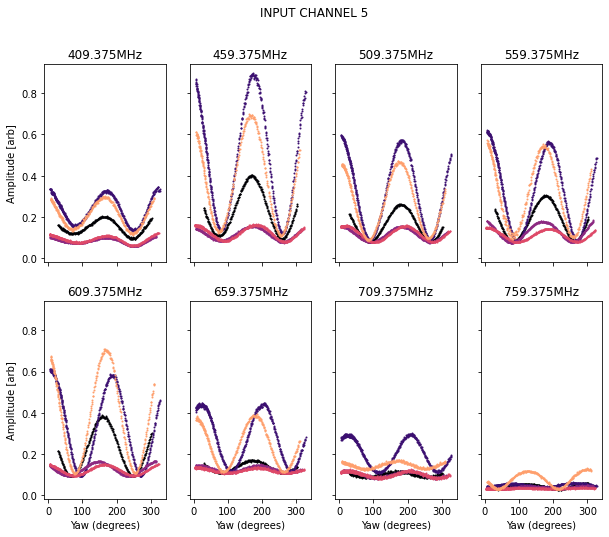

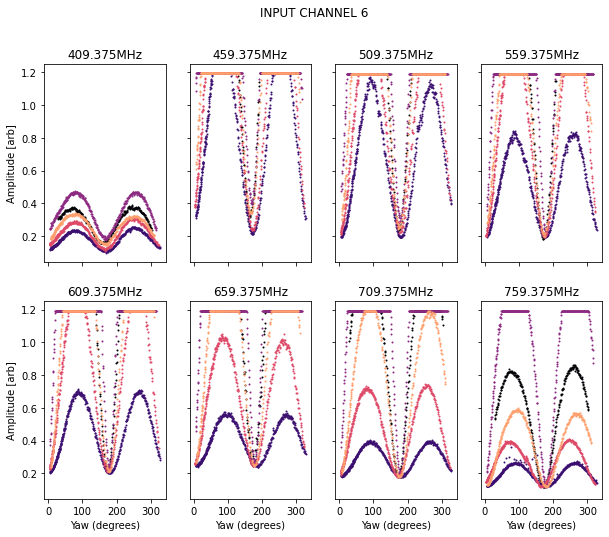

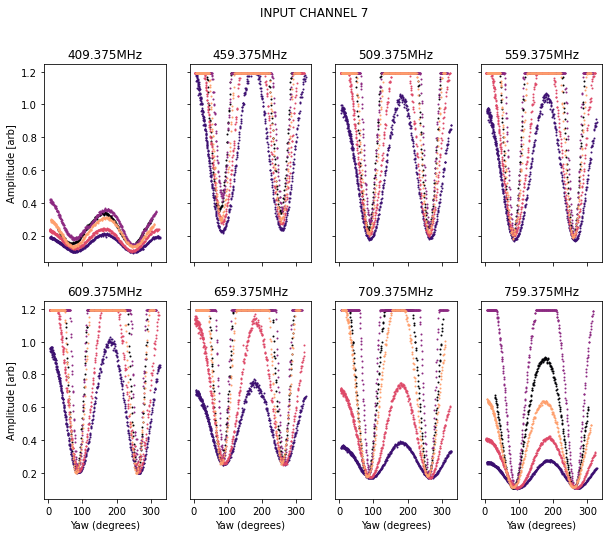

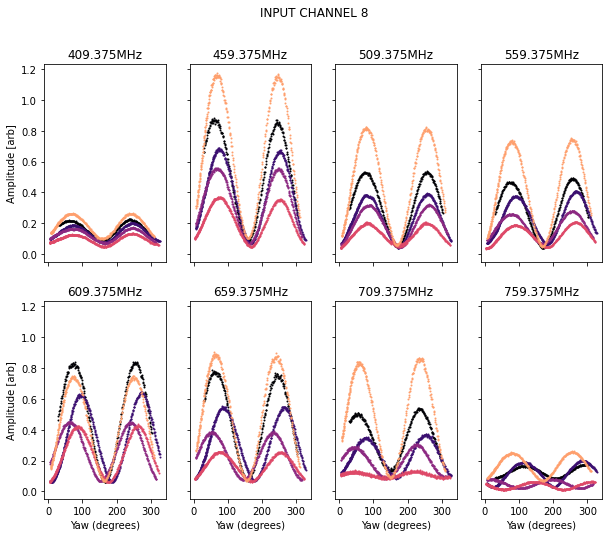

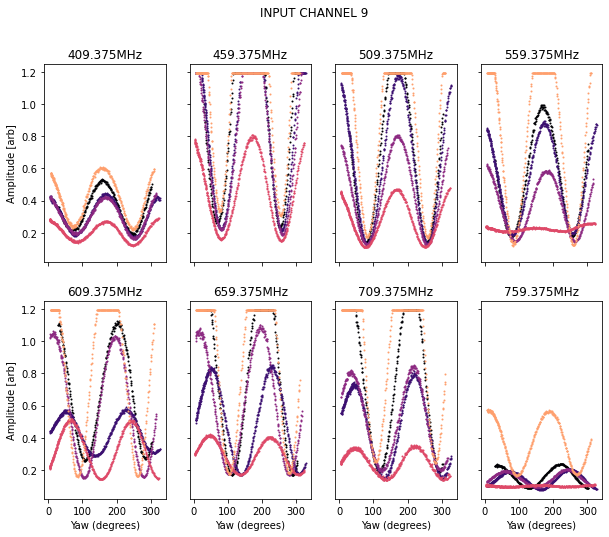

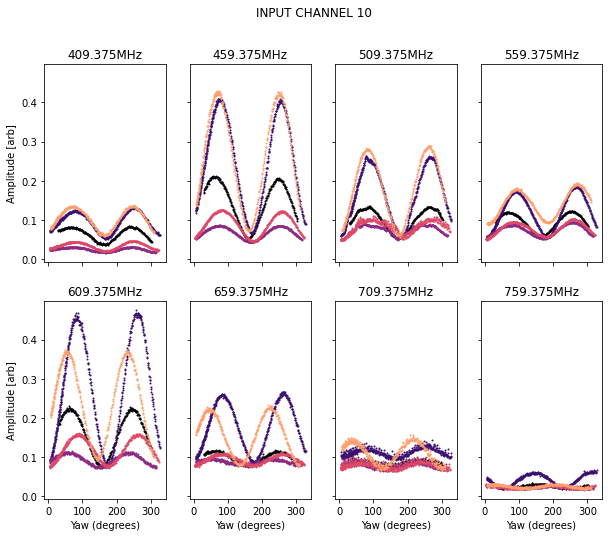

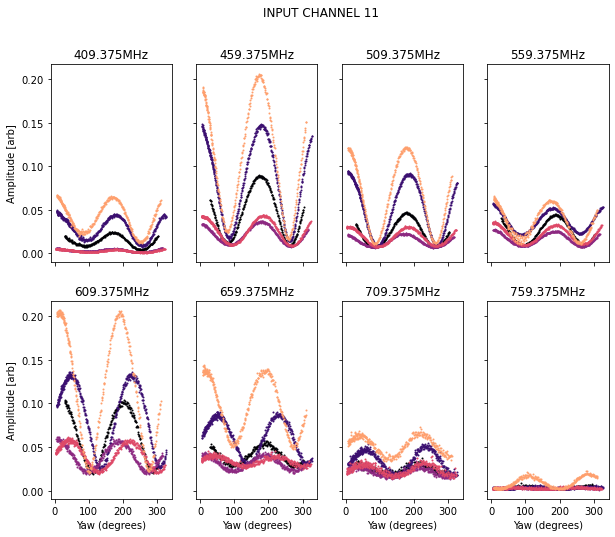

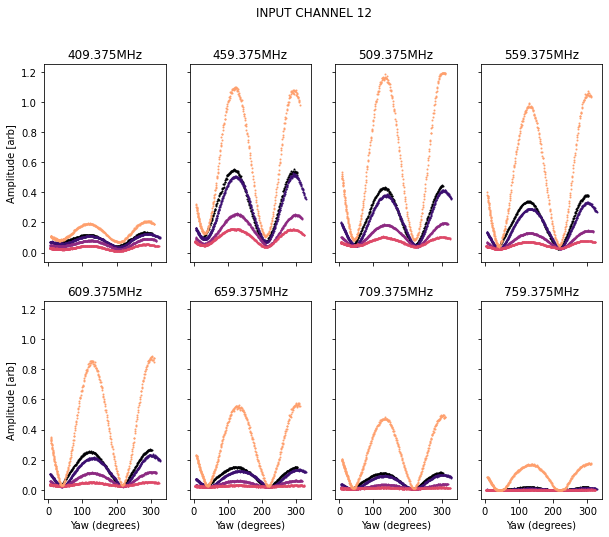

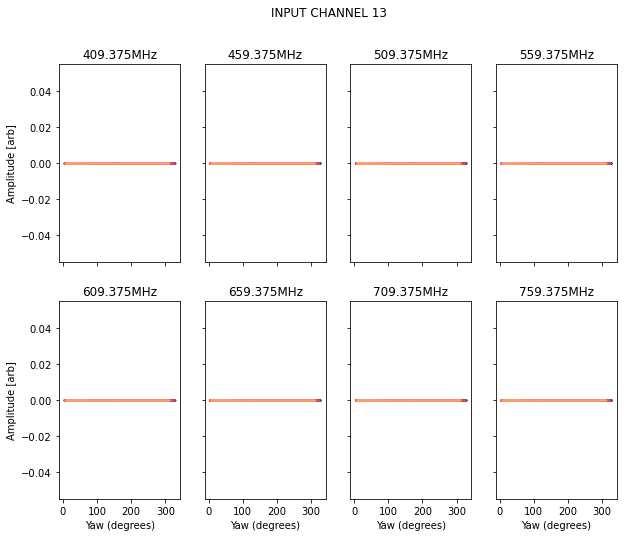

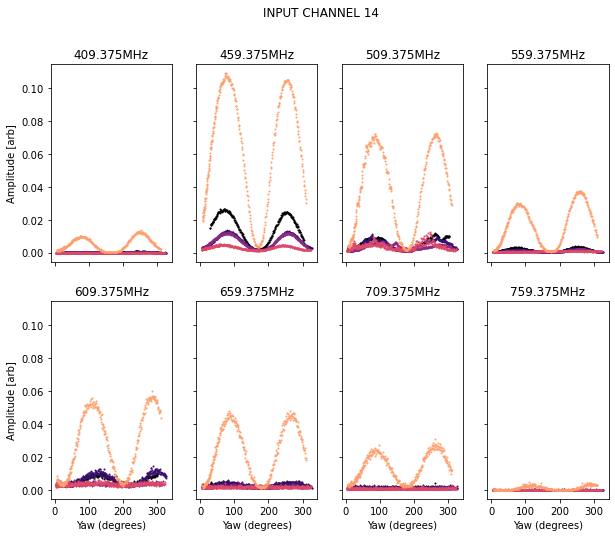

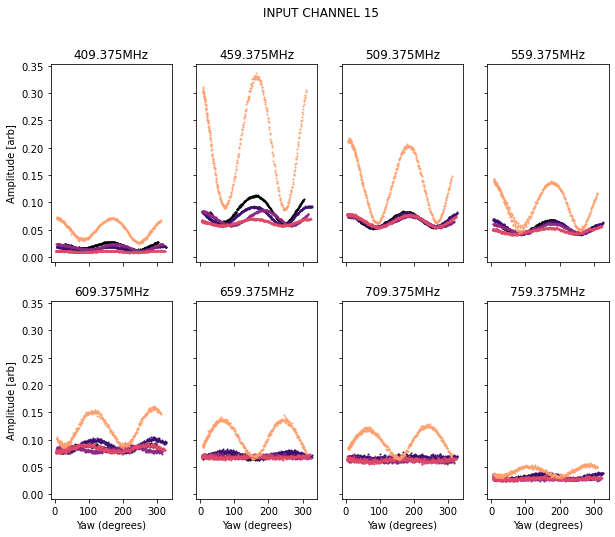

In [9]:
#3 & 4. 

# First, note that the drone and telescope time stamps are not aligned. We change by eye, by
# moving the drone stime stamps back by 100 samples:

nn = -88
shiftedyaw = np.roll(concattest.drone_yaw_interp,nn)

#pos0 = np.arange(6900+nn, 7370+nn)
# change pos0 to only use a 0-360 part
pos0 = np.arange(7100+nn, 7380+nn)
pos1 = np.arange(8140+nn,8650+nn)
pos2 = np.arange(9150+nn,9550+nn)
pos3 = np.arange(10060+nn,10500+nn)
pos4 = np.arange(10950+nn,11300+nn)


poss = [pos0,pos1,pos2,pos3,pos4]
lp = 5

colorz=pu.cm_to_discrete(ccm,5)
# Plot positions in X,Y 
for k in np.arange(5):
    plot(concattest.drone_xyz_LC_interp[poss[k],0], concattest.drone_xyz_LC_interp[poss[k],1], 
         marker='o',color=colorz[k],label='Position '+str(k))
plt.legend()
plt.show()

# Plot yaw and shifted yaw
plot(np.arange(len(concattest.drone_yaw_interp)),shiftedyaw,marker=',',color='red',label='shifted')
plot(np.arange(len(concattest.drone_yaw_interp)),concattest.drone_yaw_interp,marker=',',color='black',label='unshifted')
for k in np.arange(5):
    plt.axvspan(poss[k][0],poss[k][-1],color='blue',alpha=0.3)
plt.legend()
plt.xlim(6000,12000)
plt.title('Yaw and shifted Yaw')
plt.show()

# Plot yaw for each segment
for k in np.arange(5):
    plot(shiftedyaw[poss[k]],marker=',',color=colorz[k],label='Position '+str(k))
plt.legend()
plt.title('Ampitude vs shifted Yaw')
plt.show()

# Plot telescope signal as a funciton of yaw
for pol in np.arange(0,16):

    fig,axs = plt.subplots(2, 4, sharex=True,sharey=True,figsize=(10,8))
    for i, freq in enumerate(np.arange(1000,0,-128)):      
        for k in np.arange(5):
            if i<4: 
                r = 0
                c = i
            else:
                r = 1
                c = i-4
            axs[r,c].plot(shiftedyaw[poss[k]], 
                1e7*(concattest.V[poss[k],freq,pol]), '.', markersize = 2,color=colorz[k])
            axs[r,c].set_title(str(freqs[freq])+'MHz')
    axs[0,0].set_ylabel('Amplitude [arb]')
    axs[1,0].set_ylabel('Amplitude [arb]')
    axs[1,0].set_xlabel('Yaw (degrees)')
    axs[1,1].set_xlabel('Yaw (degrees)')
    axs[1,2].set_xlabel('Yaw (degrees)')
    axs[1,3].set_xlabel('Yaw (degrees)')
    fig.suptitle('INPUT CHANNEL '+str(pol))

    fig.show()


    
# Notes about channels:
#0/1 : normal keep; here ok 
#2/3 : normal keep; here ok
#4/5 : usually mixed co/cross so removed in regular analysis; here ok but skip anyway
#6/7 : no good amplitude fits, but these are CHIME channels ; have to keep but not all locations are good
#8/9 : input 9 saturated for all flights, removed companion 8 as well ; saturated here too
#10/11 : normal keep ; here ok
#12/13 : usually mixed co/cross so removed in regular analysis; 13 is clock
#14/15 : normal keep ; here ok



goodpols = [0,1,2,3,10,11,14,15]
chimepols = [6,7]
allgoodpols = [0,1,2,3,6,7,10,11,14,15]
N_pols = [1,3,7,11,15]
E_pols = [0,2,6,10,14]

# 5 & 6.
def cos2_fun(x,*params):
    
    [a,b,c,d] = params   
    return a*(np.cos(b*(np.radians(x)-c)))**2 + d 

def get_chi2(x,y,*params):
    yfunc = cos2_fun(x,*params)
    return np.sum((y - yfunc)**2)/len(y)

def get_shiftedphase(astr):
    n = len(astr)
    ll = 110
    print(n)
    corrstream = astr
    for i in np.arange(0,n-1):
        #print(abs(corrstream[i+1] - corrstream[i]))
        if (corrstream[i+1] - corrstream[i] > ll) or (corrstream[i+1] - corrstream[i]) < -1*ll:
            #print(i, 'got one! OLD: ', corrstream[i+1], corrstream[i])
            corrfac = -1.0*np.sign(corrstream[i+1] - corrstream[i])*180.0
            corrstream[i+1]= corrstream[i+1]+corrfac
            #print('NEW: ',corrstream[i+1])
    return corrstream





In [10]:
## Fit all positions and get chi2


bnds = ((0, 0.5,-np.pi/2, 0),(2.0, 1.5,np.pi, 1.0))
pG = [0.5,1.0,0.5,0.1]
poss = [pos0,pos1,pos2,pos3,pos4]
lp = len(poss)
fits = np.zeros((5,lp,16,1024))

for fi,find in enumerate(np.arange(0,1024)):
    for p,chind in enumerate(allgoodpols):
        for k in np.arange(lp):
            try:
                gi = np.where(1e7*(concattest.V[poss[k],find,chind]) < 1.19)[0]
                popt, pcov = opt.curve_fit(cos2_fun, shiftedyaw[poss[k][gi]], \
                        1e7*(concattest.V[poss[k][gi],find,chind]), p0=pG,bounds=bnds)
                fits[0:4,k,chind,find] = popt
                ch2 = get_chi2(shiftedyaw[poss[k][gi]],1e7*(concattest.V[poss[k][gi],find,chind]),*popt)
                fits[4,k,chind,find] = ch2
            except:''

/home/ln267/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


median phase, lower band:  0 78.73871337945437
median phase, upper band:  0 55.69425473230988
median phase, lower band:  1 2.9115001288716487
median phase, upper band:  1 11.002336199246923
median phase, lower band:  2 80.3191557767986
median phase, upper band:  2 78.15962481680027
median phase, lower band:  3 6.2106102821543
median phase, upper band:  3 83.48275123542842
median phase, lower band:  6 86.84399958068245
median phase, upper band:  6 81.09304918242853
median phase, lower band:  7 7.641170404741537
median phase, upper band:  7 6.792955238416672
median phase, lower band:  10 75.62871365152705
median phase, upper band:  10 51.24610722222731
median phase, lower band:  11 4.022960133608548
median phase, upper band:  11 43.17584569706509
median phase, lower band:  14 78.58206615522599
median phase, upper band:  14 43.19222575785405
median phase, lower band:  15 8.221645769779586
median phase, upper band:  15 30.3878593898574


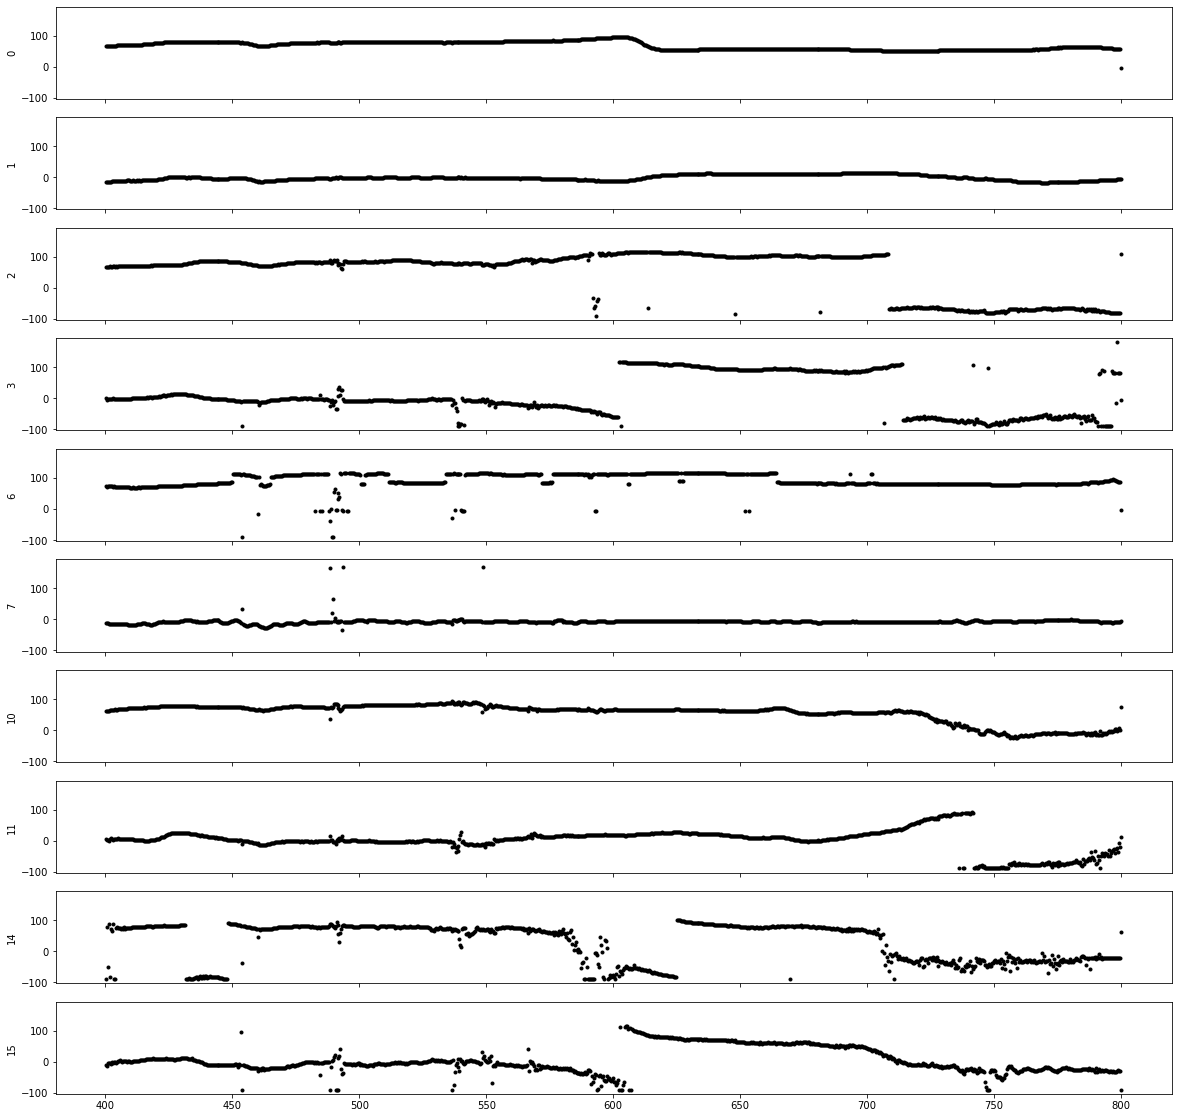

median amp ratio, lower band:  0 0 0.9513691417694812
median amp ratio, lower band:  0 1 0.9498534142711778
median amp ratio, lower band:  0 2 0.8384086193949221
median amp ratio, lower band:  0 3 0.9678468625264185
median amp ratio, lower band:  0 4 0.9564382959469213
median amp ratio, lower band:  2 0 1.096871968179369
median amp ratio, lower band:  2 1 0.7743866264410744
median amp ratio, lower band:  2 2 1.1363245060709244
median amp ratio, lower band:  2 3 0.8341019370808443
median amp ratio, lower band:  2 4 0.8672106462595177
median amp ratio, lower band:  6 0 1.0
median amp ratio, lower band:  6 1 1.0660082534854651
median amp ratio, lower band:  6 2 1.0
median amp ratio, lower band:  6 3 1.1546570544466195
median amp ratio, lower band:  6 4 1.0
median amp ratio, lower band:  10 0 1.9582984671439128
median amp ratio, lower band:  10 1 2.4737612898146493
median amp ratio, lower band:  10 2 1.9883971581426239
median amp ratio, lower band:  10 3 2.1105821404152714
median amp ratio

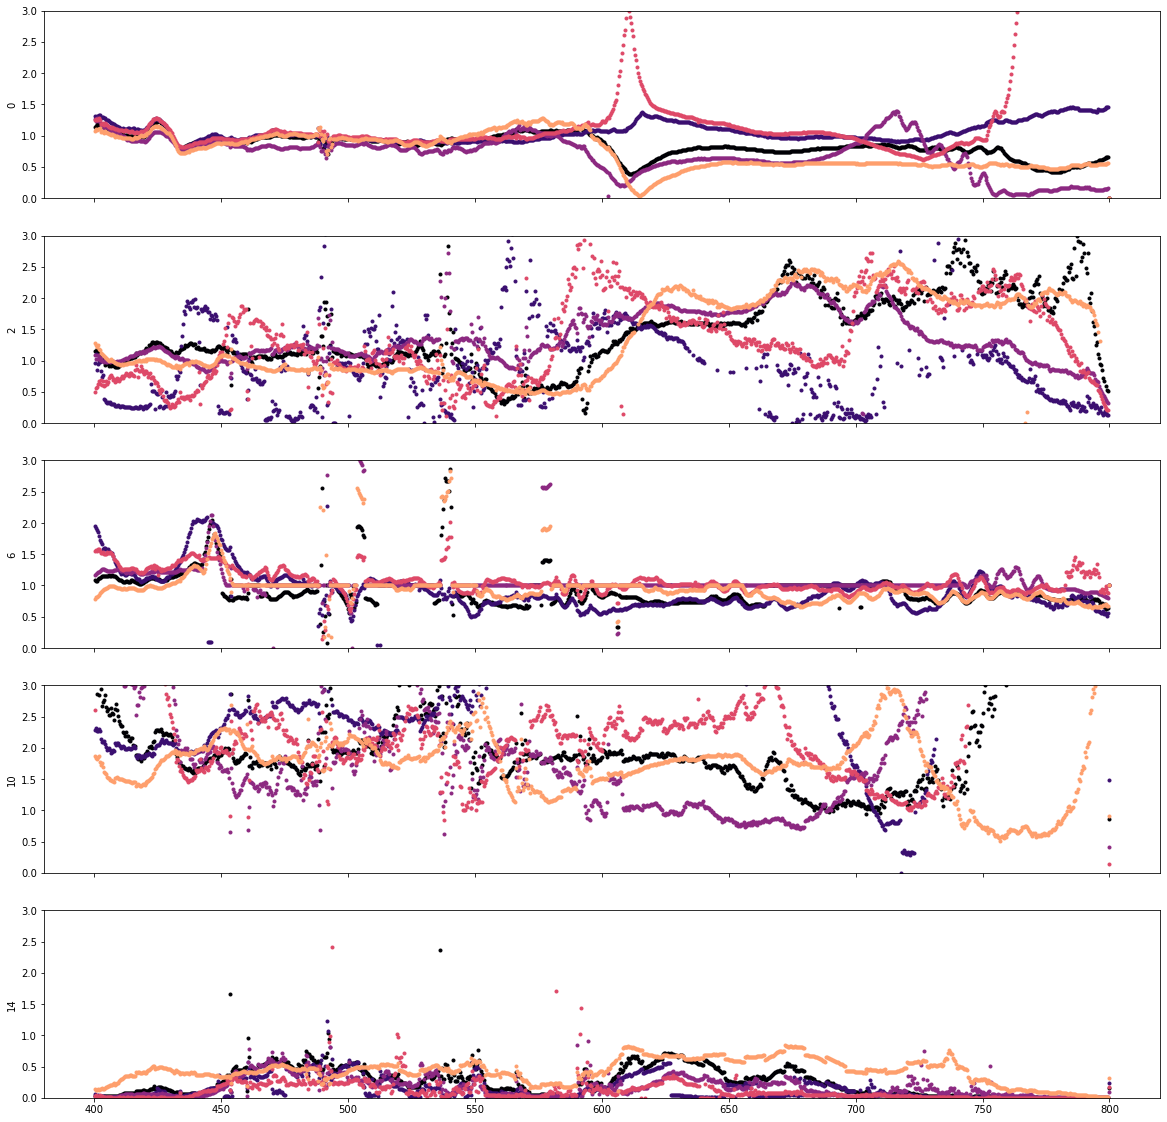

median amp lower band:  0.6092067582155576 0.6607425492614181
median amp lower band:  0.5989647983189157 0.6562646764285274
median amp lower band:  0.24903248888848822 0.3186070974129136
median amp lower band:  0.5293578870968514 0.5712472498221198
median amp lower band:  0.35790393479965876 0.3852838675550684


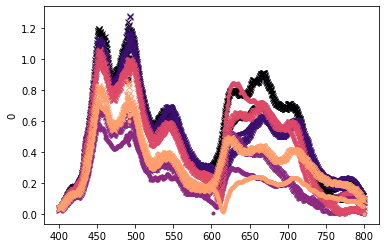

at 448 MHz:  1.0035286867083204 1.0414924422440706
at 448 MHz:  0.9917308158744699 0.9787867238084619
at 448 MHz:  0.534715505295515 0.5817133177652175
at 448 MHz:  0.8917276221646732 0.9279174738263166
at 448 MHz:  0.630803616558614 0.7220640247197957


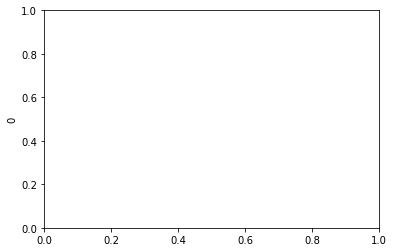

In [11]:
# Get some statistics for phase angle and amplitude at two halves of the frequency range

# Plot phase
fig,axs = plt.subplots(10, sharex=True,sharey=True,figsize=(20,20))
#for fi in np.arange(len(fits[:,0,0,0])): # fit param
fi = 2
k = 0#3#4
lp = 1
badfreqs=[]

for p,chind in enumerate(allgoodpols):
    axs[p].plot(freqs,np.degrees(fits[fi,k,chind,:]),
                  color='black',marker='.',linestyle='None')
    axs[p].set_ylabel(str(chind))
    print('median phase, lower band: ', chind, np.median(np.abs(np.degrees(fits[fi,k,chind,600:1024]))))
    print('median phase, upper band: ', chind, np.median(np.abs(np.degrees(fits[fi,k,chind,0:400]))))
plt.show()
   
fig,axs = plt.subplots(5, sharex=True,sharey=True,figsize=(20,20))
colorz=pu.cm_to_discrete(ccm,5)
for p,chind in enumerate(E_pols):
    for k in np.arange(len(poss)):
        axs[p].plot(freqs,fits[0,k,chind,:]/fits[0,k,chind+1,:],
                  color=colorz[k],marker='.',linestyle='None')
        axs[p].set_ylabel(str(chind))
        print('median amp ratio, lower band: ', chind, k, 
              np.median(fits[0,k,chind,600:1024]/fits[0,k,chind+1,600:1024]))
axs[0].set_ylim(0,3)
plt.show()


chind = 0
for k in np.arange(len(poss)):
    plt.plot(freqs,fits[0,k,chind,:],
                  color=colorz[k],marker='.',linestyle='None',label=str(k))
    plt.plot(freqs,fits[0,k,chind+1,:],
                  color=colorz[k],marker='x',linestyle='None')

    print('median amp lower band: ',np.median(fits[0,k,chind,600:1024]),np.median(fits[0,k,chind+1,600:1024]))
plt.ylabel(str(chind))
#plt.ylim(0,3)
plt.show()

chind = 0
find = 900
for k in np.arange(len(poss)):
    print('at 448 MHz: ',np.median(fits[0,k,chind,find]),np.median(fits[0,k,chind+1,find]))
plt.ylabel(str(chind))
#plt.ylim(0,3)
plt.show()

In [12]:
# angles at the frequency presented in the cross-pol analysis
chind = 0
find = 900
fi = 2
k = 0

for k in np.arange(0,5):
    angle = np.degrees(fits[fi,k,chind,find])
    
    print('E pol degree offset: ',k, np.degrees(fits[fi,k,chind,find]), 90 - np.degrees(fits[fi,k,chind,find]))
    print('E pol % of sin^2: ',k, 100*(np.cos(fits[fi,k,chind,find]))**2)
    print('E pol dB of sin^2: ',k, 10*np.log10(np.cos(fits[fi,k,chind,find])**2))

    print('N pol degree offset: ',k, np.degrees(fits[fi,k,chind+1,find]))
    print('N pol % of sin^2: ',k, 100*(np.sin(fits[fi,k,chind+1,find]))**2)
    print('N pol dB of sin^2: ',k, 10*np.log10(np.sin(fits[fi,k,chind+1,find])**2))



E pol degree offset:  0 79.87338024788299 10.126619752117008
E pol % of sin^2:  0 3.0914117520351194
E pol dB of sin^2:  0 -15.098431464321951
N pol degree offset:  0 -4.469341773097562
N pol % of sin^2:  0 0.607240646248067
N pol dB of sin^2:  0 -22.166391662126408
E pol degree offset:  1 88.97108730692555 1.0289126930744459
E pol % of sin^2:  1 0.03224520183670281
E pol dB of sin^2:  1 -34.91534900280619
N pol degree offset:  1 7.023938908058143
N pol % of sin^2:  1 1.4953384288435834
N pol dB of sin^2:  1 -18.252605055697618
E pol degree offset:  2 85.40779579988465 4.592204200115347
E pol % of sin^2:  2 0.6410131924353298
E pol dB of sin^2:  2 -21.93133032348719
N pol degree offset:  2 3.164806136787579
N pol % of sin^2:  2 0.3047945730398146
N pol dB of sin^2:  2 -25.159927700090925
E pol degree offset:  3 86.8714026786138 3.128597321386195
E pol % of sin^2:  3 0.2978670025251651
E pol dB of sin^2:  3 -25.259776049251904
N pol degree offset:  3 6.895628533918521
N pol % of sin^2: 

In [ ]:
print(10**(-13/10), 10**(-17/10.), 10**(-19/10),10**(-23/10))

1016
1023
1019
847


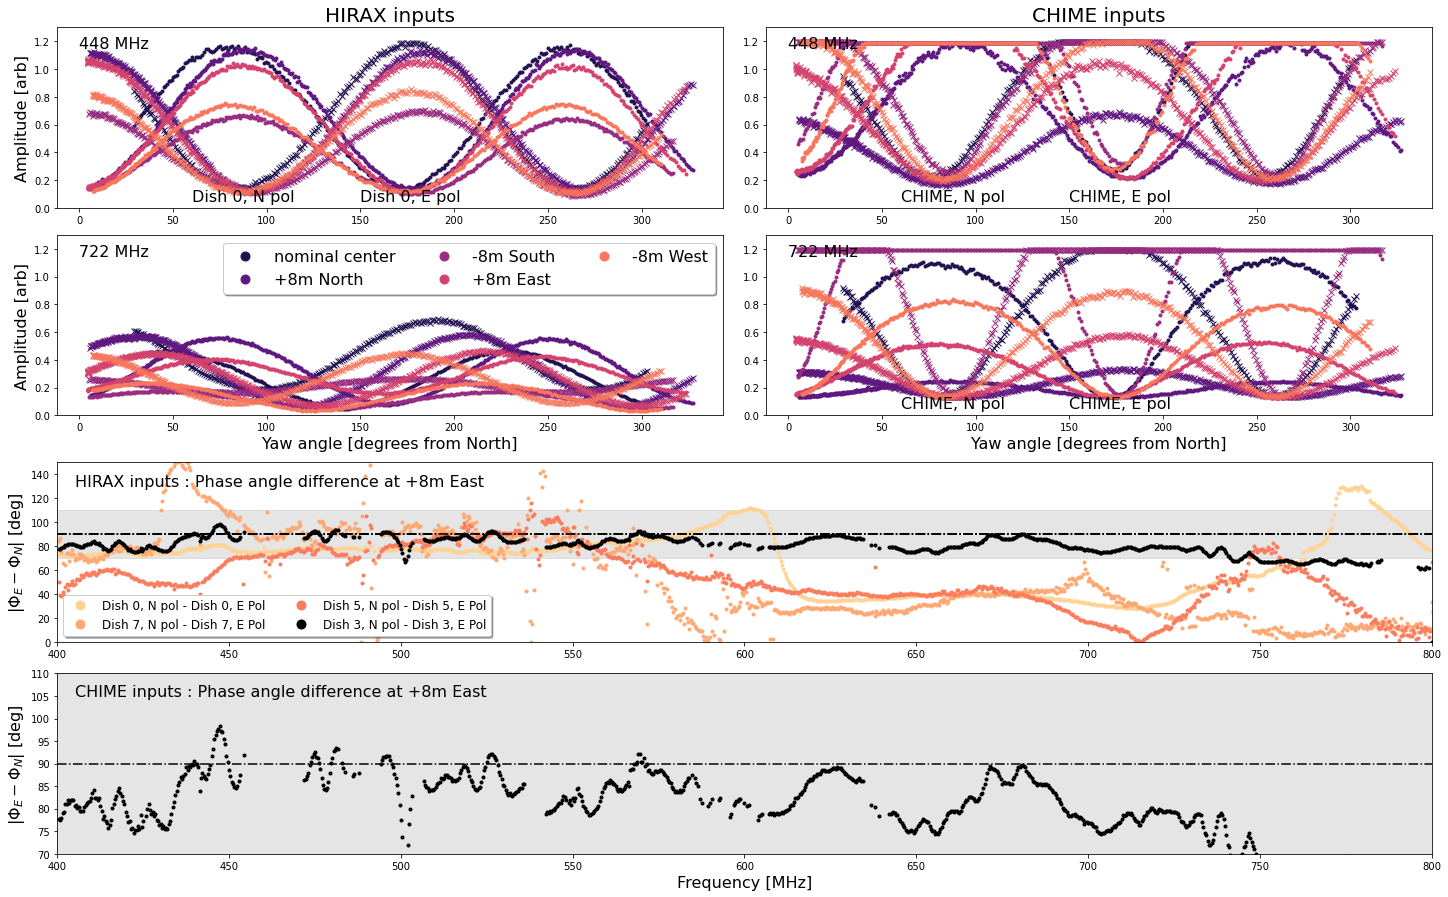

In [34]:
# 7. Plot

colorp=pu.cm_to_discrete(ccm,7)
poss = [pos0,pos1,pos2,pos3,pos4]
lp = [0,1,2,3,4]

fi = 2 # phase
pp = 3 # which position of [pos0,1,2,3,4]
bv = 0.003 # limit for good chi2


msiz = 6
locz = ['nominal center','+8m North','-8m South','+8m East','-8m West']
colorz=pu.cm_to_discrete(ccm,11)


fig = plt.figure(constrained_layout=True,figsize=(20,15))

gs = GridSpec(5, 2, figure=fig)
axs0 = fig.add_subplot(gs[0, 0])
axs1 = fig.add_subplot(gs[1, 0])
axs2 = fig.add_subplot(gs[0, 1])
axs3 = fig.add_subplot(gs[1, 1])
axs5 = fig.add_subplot(gs[2, :])
axs6 = fig.add_subplot(gs[3, :])


for k in lp:
    find = 900
    chind1 = 0
    chind2 = 1
    axs0.plot(shiftedyaw[poss[k]], 
            1e7*(concattest.V[poss[k],find,chind1]), '.', 
                    markersize = msiz,color=colorp[k+1])
    axs0.plot(shiftedyaw[poss[k]], 
                1e7*(concattest.V[poss[k],find,chind2]), 'x', 
                      markersize = msiz,color=colorp[k+1])
    find=200
    axs1.plot(shiftedyaw[poss[k]], 
            1e7*(concattest.V[poss[k],find,chind1]), '.', 
                    markersize = msiz,color=colorp[k+1],label=locz[k])
    axs1.plot(shiftedyaw[poss[k]], 
                1e7*(concattest.V[poss[k],find,chind2]), 'x', 
                      markersize = msiz,color=colorp[k+1])

    find = 900
    chind1 = 6
    chind2 = 7
    axs2.plot(shiftedyaw[poss[k]], 
            1e7*(concattest.V[poss[k],find,chind1]), '.', 
                    markersize = msiz,color=colorp[k+1])
    axs2.plot(shiftedyaw[poss[k]], 
                1e7*(concattest.V[poss[k],find,chind2]), 'x', 
                      markersize = msiz,color=colorp[k+1])
    find=200
    axs3.plot(shiftedyaw[poss[k]], 
            1e7*(concattest.V[poss[k],find,chind1]), '.', 
                    markersize = msiz,color=colorp[k+1])
    axs3.plot(shiftedyaw[poss[k]], 
                1e7*(concattest.V[poss[k],find,chind2]), 'x', 
                      markersize = msiz,color=colorp[k+1])
    


for p,chind in enumerate([0,2,10]):
    gfrs = np.where((fits[4,pp,chind,:] < bv) & (fits[4,pp,chind+1,:] < bv) )[0]
    
    esigo = fits[fi,pp,chind,gfrs]
    nsigo = fits[fi,pp,chind+1,gfrs]
    diffo = (180/np.pi)*(nsigo-esigo)    
    diff = get_shiftedphase(diffo)
    
    if diff[-1] < 0.0: diff = diff*-1.0  

    axs5.plot(freqs[gfrs],abs(diff),
                 color=colorz[10-p],marker='.',
                markersize=msiz,linestyle='None',label=dlab[chind+1]+' - '+dlab[chind])
    axs5.axhline(90,color='black',ls='-.')
    
chind = 6
gfrs = np.where((fits[4,pp,chind,:] < bv) & (fits[4,pp,chind+1,:] < bv) )[0]
esigo = fits[fi,pp,chind,gfrs]
nsigo = fits[fi,pp,chind+1,gfrs]
diffo = (180/np.pi)*(nsigo-esigo)    
diff = get_shiftedphase(diffo)
if diff[-1] < 0.0: diff = diff*-1.0  

axs6.plot(freqs[gfrs],abs(diff),
                 color='black',marker='.',
          linestyle='None',label=dlab[chind+1]+' - '+dlab[chind])
axs6.axhline(90,color='black',ls='-.')


axs5.plot(freqs[gfrs],diff,
                 color='black',marker='.',
          linestyle='None',label=dlab[chind+1]+' - '+dlab[chind])
    
    
    
axs0.text(0,1.15,'448 MHz',fontsize=16)
axs0.text(150,0.05,'Dish 0, E pol',color='black',fontsize=16)
axs0.text(60,0.05,'Dish 0, N pol',color='black',fontsize=16)
axs0.set_ylabel('Amplitude [arb]',fontsize=16)
axs0.set_ylim(0,1.3)
axs0.set_title('HIRAX inputs',fontsize=20)

axs1.legend(loc='upper right',fontsize=16,markerscale=3,ncol=3,frameon=True,shadow=True)

axs1.text(0,1.15,'722 MHz',fontsize=16)
axs1.set_ylabel('Amplitude [arb]',fontsize=16)
axs1.set_ylim(0,1.3)
axs1.set_xlabel('Yaw angle [degrees from North]',fontsize=16)

axs2.text(0,1.15,'448 MHz',fontsize=16)
axs2.text(150,0.05,'CHIME, E pol',color='black',fontsize=16)
axs2.text(60,0.05,'CHIME, N pol',color='black',fontsize=16)
axs2.set_ylim(0,1.3)
axs2.set_title('CHIME inputs',fontsize=20)

axs3.text(0,1.15,'722 MHz',fontsize=16)
axs3.text(150,0.05,'CHIME, E pol',color='black',fontsize=16)
axs3.text(60,0.05,'CHIME, N pol',color='black',fontsize=16)
axs3.set_xlabel('Yaw angle [degrees from North]',fontsize=16)
axs3.set_ylim(0,1.3)



#axs5.set_xlabel('Frequency [MHz]',fontsize=16)
axs5.text(405,130,'HIRAX inputs : Phase angle difference at +8m East',fontsize=16)
axs5.legend(ncol=2,fontsize=12,markerscale=3,frameon=True,shadow=True)
axs5.set_ylabel(r'|$\Phi_{E} - \Phi_{N}| $ [deg]',fontsize=16)
axs5.axhspan(70,110,color='grey',alpha=0.2)
axs5.set_ylim(0,150)
axs5.set_xlim(400,800)

axs6.set_xlabel('Frequency [MHz]',fontsize=16)
axs6.text(405,105,'CHIME inputs : Phase angle difference at +8m East',fontsize=16)
axs6.set_ylim(70,110)
axs6.set_xlim(400,800)
axs6.set_ylabel(r'|$\Phi_{E} - \Phi_{N}|$ [deg]',fontsize=16)
axs6.axhspan(70,110,color='grey',alpha=0.2)

plt.show()
fig.clf()

In [ ]:
####################################################################################
############################# SECTION 4.5 ##########################################
############################# SECTION 4.5 ##########################################
####################################################################################

## In this section we compute the differences between N and S pol flights to check for systematics

# 1. coadd N pol flights 618, 619 (N); grid flight 623 (S). Ensure Flight 623 is normalized with correction
# 2. Create a mask to remove nans and 0's, apply masks to data. Mask is per pixel, input
# 3. Form differenced maps and variance maps (sum in quad two errs) after applying mask
# 4. Form weights, and perform weighted average of feeds and compute error on weighted average
# 5. Make beautiful plots
#

start of big ass loop is: 2024-09-04 13:10:27.653131
618 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY618_20211021T183430Z_2dGauss_and_Airy_Params.npz
619 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz
end of bigass loop is: 2024-09-04 13:10:30.358853   


/home/ln267/anaconda3/lib/python3.8/site-packages/beamcals/beam_autoprocessing.py:214: RuntimeWarning: invalid value encountered in true_divide
  self.V_LC_operation = np.nansum(self.V_LC_sum,axis=4)/self.V_LC_operation_count


618 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY618_20211021T183430Z_2dGauss_and_Airy_Params.npz
619 /hirax/GBO_Analysis_Outputs/main_beam_fits/FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz


/home/ln267/anaconda3/lib/python3.8/site-packages/beamcals/beam_autoprocessing.py:257: RuntimeWarning: invalid value encountered in true_divide
  self.V_LC_operation_err = (np.nansum(self.V_LC_err,axis=4)/self.V_LC_operation_count)**0.5 # stddev
<ipython-input-118-0edffc7cb413>:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axs[0,i].pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
<ipython-input-118-0edffc7cb413>:30: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an

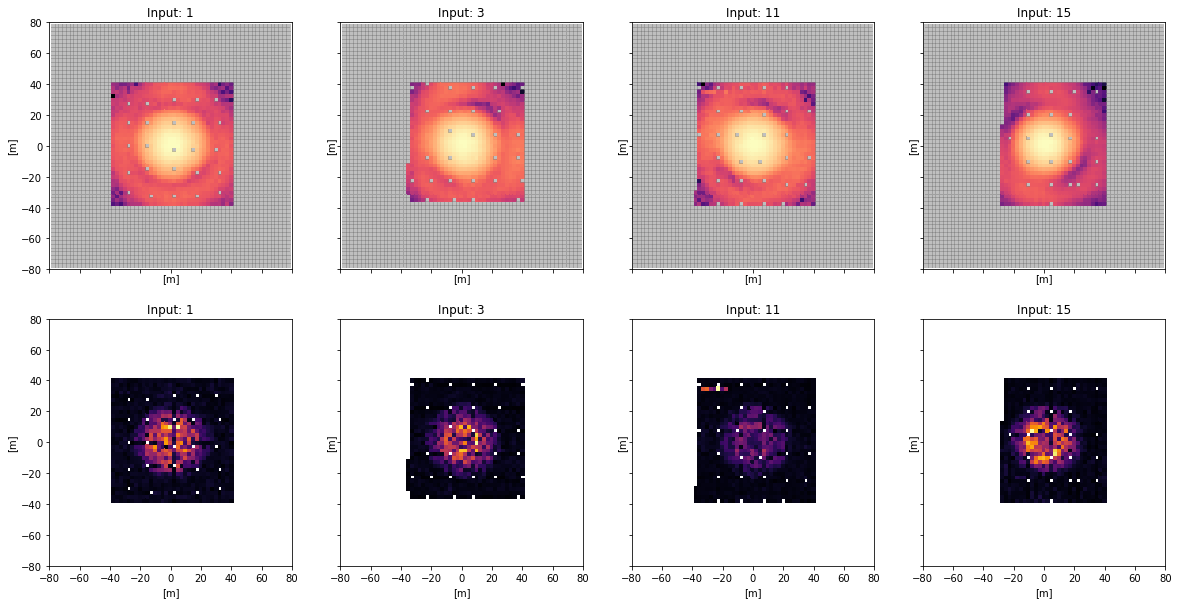

623 N [1, 3, 11, 15] [0, 2, 10, 14] 46
start of concat loop is: 2024-09-04 13:10:35.418870
end of concat loop is: 2024-09-04 13:10:37.629555          


/home/ln267/anaconda3/lib/python3.8/site-packages/beamcals/beammap.py:368: RuntimeWarning: Mean of empty slice
  self.V_LC_operation=np.nanmean(self.V_LC_mean,axis=4)
<ipython-input-118-0edffc7cb413>:91: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axs[0].pcolormesh(fl623_grided.d0_centers_grid[:,:,chind],fl623_grided.d1_centers_grid[:,:,chind],
<ipython-input-118-0edffc7cb413>:101: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axs[1].pcolormesh(beam.d0_cen

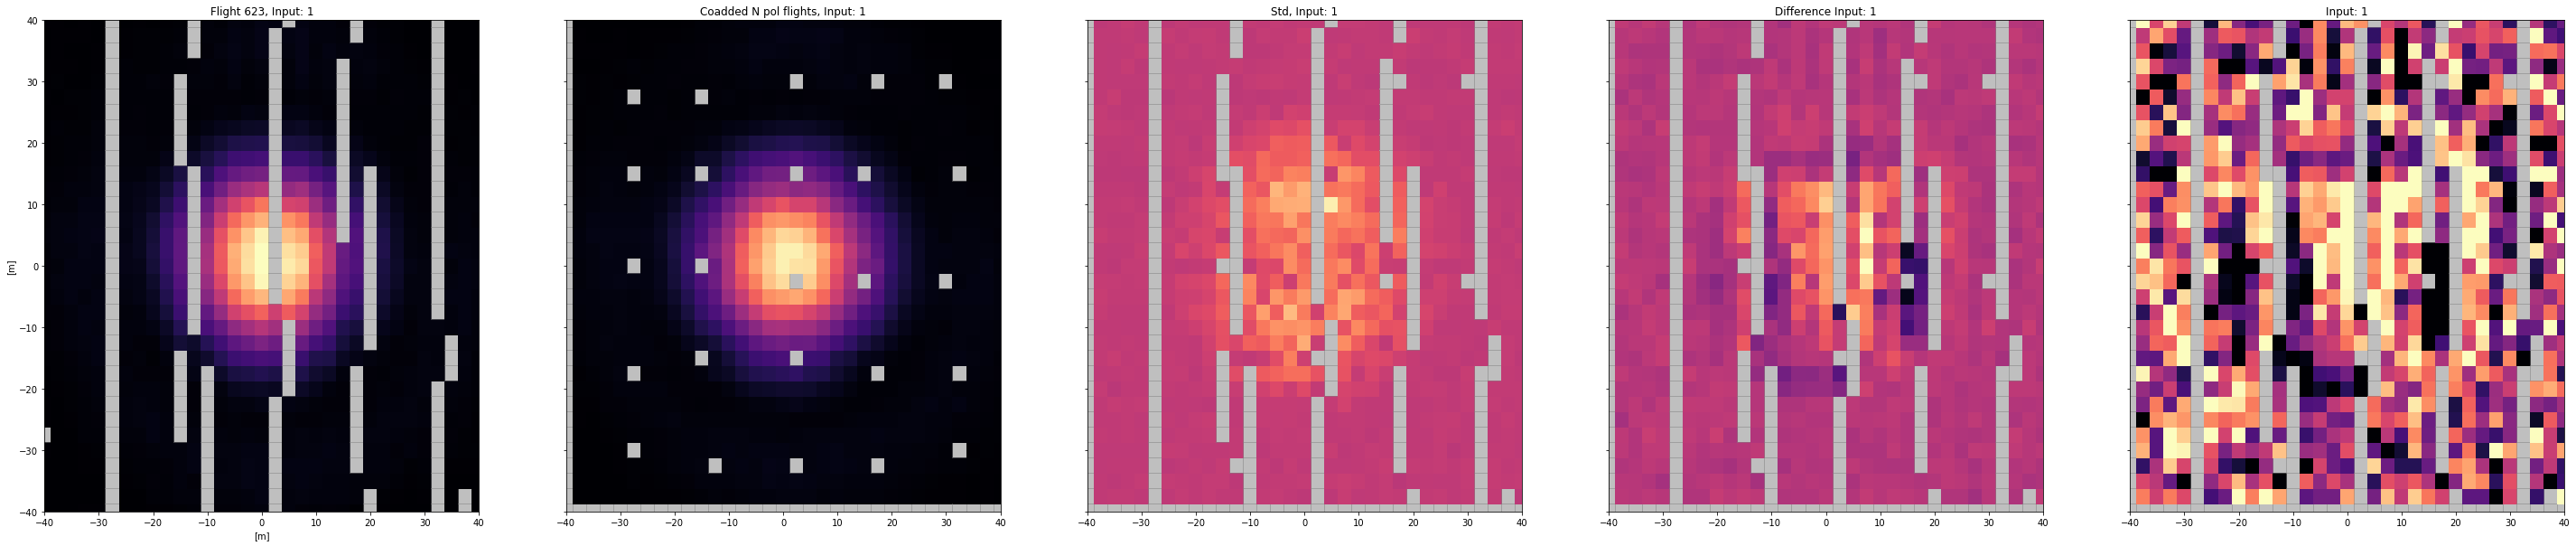

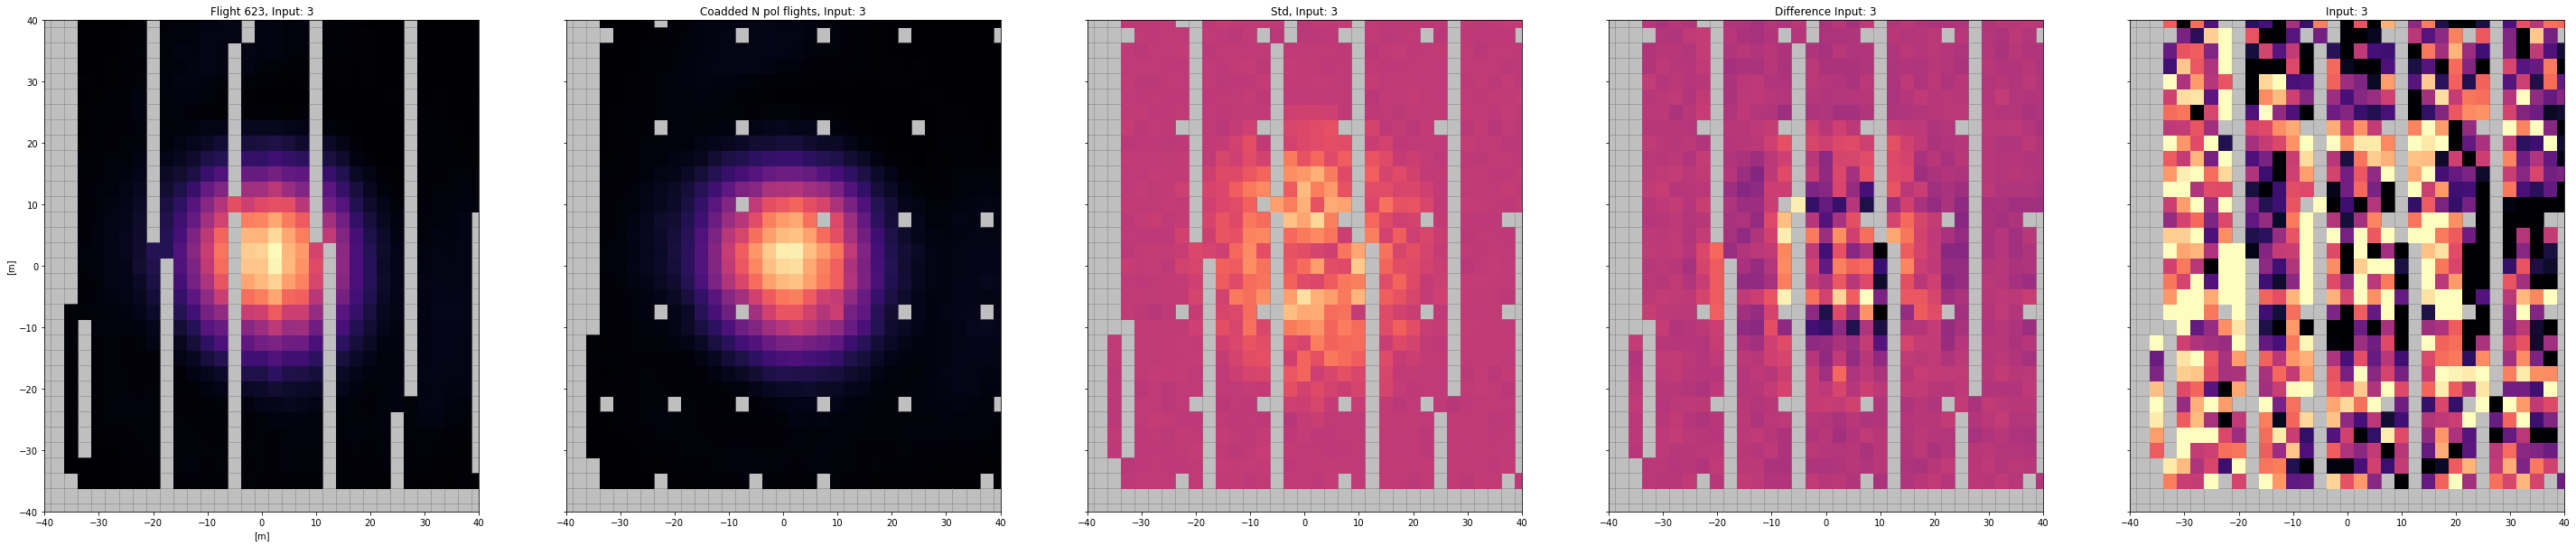

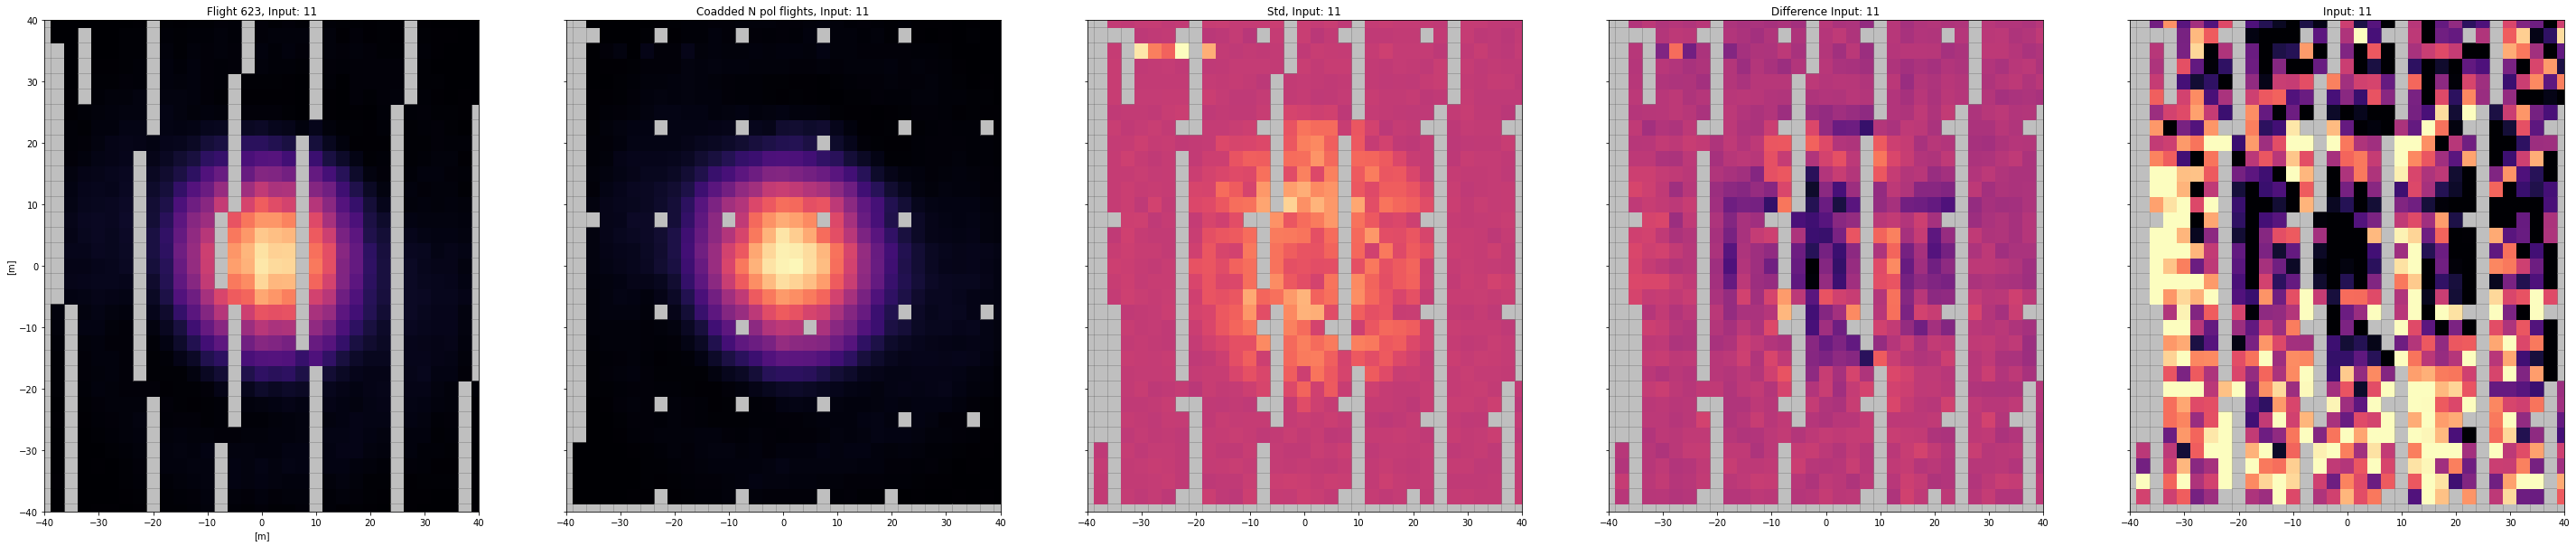

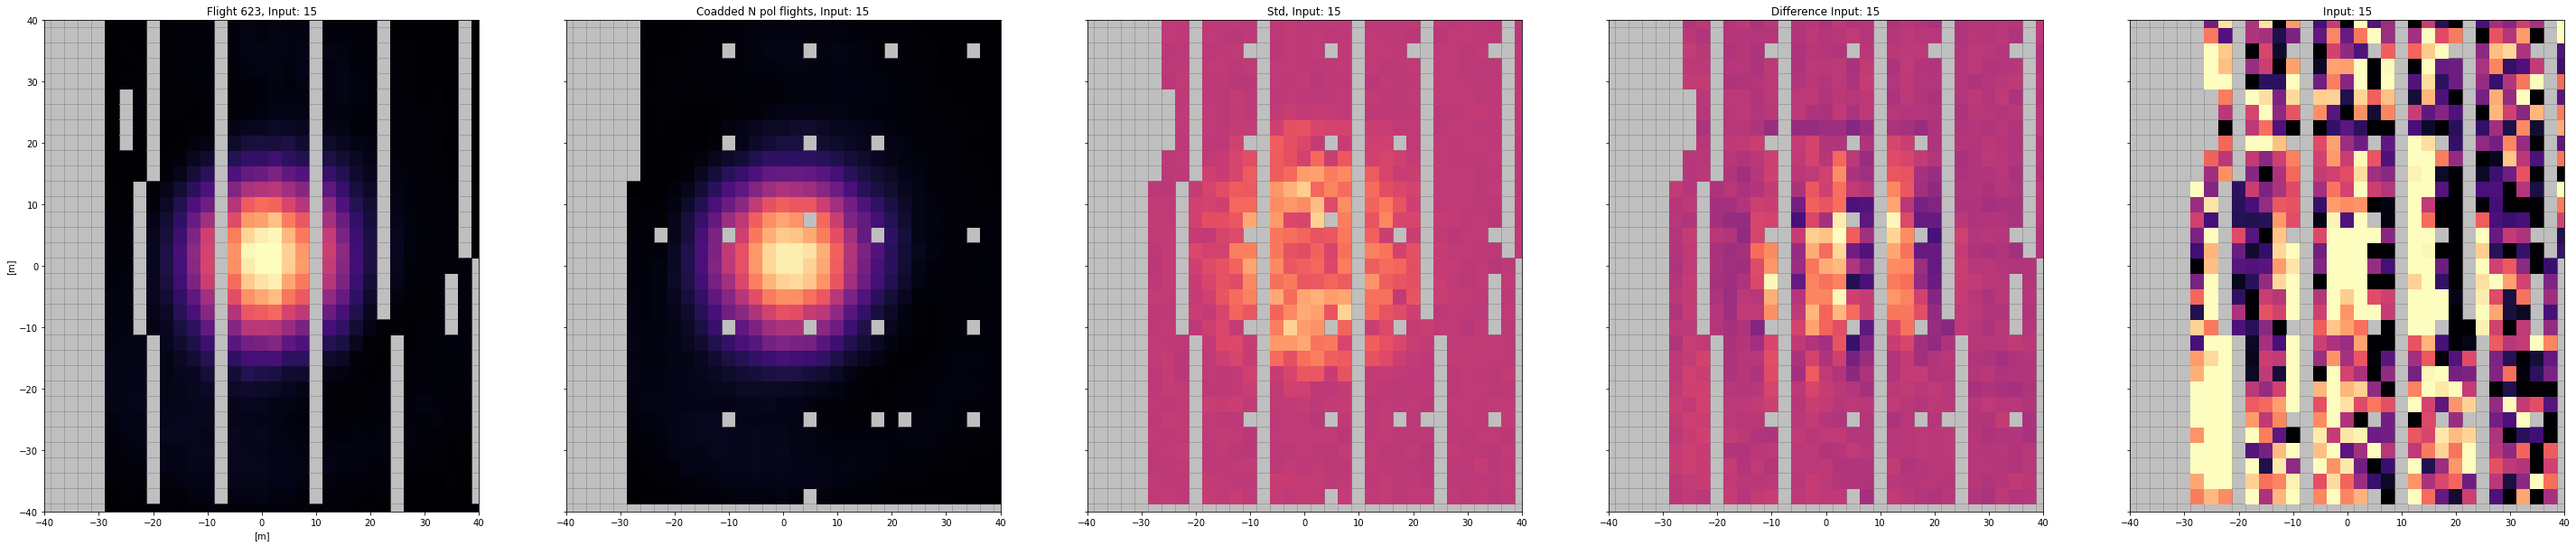

<ipython-input-118-0edffc7cb413>:131: RuntimeWarning: invalid value encountered in true_divide
  diff_weighted = np.nansum(diffarr*weights,axis=-1)/np.nansum(weights,axis=-1)
<ipython-input-118-0edffc7cb413>:132: RuntimeWarning: divide by zero encountered in true_divide
  err_weighted = np.sqrt(1./np.nansum(weights,axis=-1))


In [118]:
find=900#good_freqs[100]
pols = N_pols

## 1. Coadd and grid flights, and normalize
Npolflights = ['618','619']

pflights=Npolflights


concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for fly in pflights]


beam=ba.Beammap_forautoprocessing(concatlist=concytest,
                 normalization='Gauss_wcorr',operation='std',mask=True,
                                  coordsys='cartesian',d0args=[-1*sz,sz,2.5],
                 d1args=[-1*sz,sz,2.5],Fargs=[find,find+1,1])

fig,axs = plt.subplots(2, 4, sharex=True,sharey=True,figsize=(20,10))
for i,chind in enumerate(pols):
    axs[0,i].pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
               np.abs(beam.V_LC_operation[:,:,0,chind]),cmap=cm.magma,norm=LogNorm())#,edgecolors='k')
    axs[0,i].set_xlim(-1*sz,sz)
    axs[0,i].set_ylim(-1*sz,sz)
    axs[0,i].set_xlabel('[m]')
    axs[0,i].set_ylabel('[m]')
    axs[0,i].set_title('Input: '+str(chind))
    #axs[0,i].colorbar()

for i,chind in enumerate(pols):
    axs[1,i].pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
               beam.V_LC_operation_err[:,:,0,chind],cmap=cm.inferno)#,edgecolors='k')
    axs[1,i].set_xlim(-1*sz,sz)
    axs[1,i].set_ylim(-1*sz,sz)
    axs[1,i].set_xlabel('[m]')
    axs[1,i].set_ylabel('[m]')
    axs[1,i].set_title('Input: '+str(chind))
    #plt.colorbar()
plt.show()


fly='623'

pol, pols, cpols, attn, fi = get_flightinfo(fly)
print(fly,pol,pols,cpols, attn)


fl623_grided=bp.Beammap(concatlist=pcklarr[[fi]],gfitlist=gfitarr[[fi]],
                 normalization='Gauss',operation='coadd',coordsys='cartesian',
                        d0args=[-1*sz,sz,2.5],
                 d1args=[-1*sz,sz,2.5],Fargs=[find,find+1,1],f_index_cc=find,vplot=False)


pklfile = ampdir+'FLY'+str(fly)+'_Corrected_amplitudes.pkl'
with open(pklfile, 'rb') as inp:
    amps = pickle.load(inp)
    
fl623 = fl623_grided.V_LC_mean[:,:,0,:,0]*amps[0,find,:] # must use this
fl623_err = fl623_grided.V_LC_std[:,:,0,:,0]*amps[0,find,:]

#fl623 = fl623_grided.V_LC_mean[:,:,0,:,0]*1.0 # must use this
#fl623_err = fl623_grided.V_LC_std[:,:,0,:,0]*1.0

### 2. Create mask - mask anything that's NaN or 0.0 (cross pols are 0.0)
mx = np.ma.masked_invalid(fl623[:,:,:])
my = np.ma.masked_invalid(beam.V_LC_operation[:,:,0,:])

mx0 = np.ma.masked_equal(fl623[:,:,:],0.0)
my0 = np.ma.masked_equal(beam.V_LC_operation[:,:,0,:],0.0)
mxtot = np.logical_and(mx,my)
m0tot = np.logical_and(mx0,my0)
mtot = np.logical_and(m0tot,mxtot)

# Make masked data sets, and masked errors - put in nans wherever theres a mask
fl623d_mask = np.ma.masked_where(np.ma.getmask(mtot),fl623[:,:,:]).filled(np.nan)
cod_mask = np.ma.masked_where(np.ma.getmask(mtot),beam.V_LC_operation[:,:,0,:]).filled(np.nan)
fl623e_mask = np.ma.masked_where(np.ma.getmask(mtot),fl623_err[:,:,:]).filled(np.nan)
coe_mask = np.ma.masked_where(np.ma.getmask(mtot),beam.V_LC_operation_err[:,:,0,:]).filled(np.nan)

### 3. Make masked difference array, shape (N, N, inputs)
diffarr = fl623d_mask - cod_mask

# Make masked std array, combine both variances, shape (N, N, inputs)
vararr = fl623e_mask**2 + coe_mask**2

# same as above, in linear space
for i, chind in enumerate(pols):

    # plot flight 623
    fig,axs = plt.subplots(1, 5, sharex=True,sharey=True,figsize=(50,10))

    axs[0].pcolormesh(fl623_grided.d0_centers_grid[:,:,chind],fl623_grided.d1_centers_grid[:,:,chind],
               fl623[:,:,chind],cmap=cm.magma,vmin=1E-4,vmax=1.0)#,edgecolors='k')
    axs[0].set_xlim(-40,40)
    axs[0].set_ylim(-40,40)
    axs[0].set_xlabel('[m]')
    axs[0].set_ylabel('[m]')
    axs[0].set_title('Flight 623, Input: '+str(chind))
    #plt.colorbar()

    # plot the co-added flight
    axs[1].pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
               beam.V_LC_operation[:,:,0,chind],cmap=cm.magma,vmin=1E-4,vmax=1.0)#,edgecolors='k')
    axs[1].set_title('Coadded N pol flights, Input: '+str(chind))
    #axs[1].colorbar()

    # plot the std
    axs[2].pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
               np.sqrt(vararr[:,:,chind]),cmap=cm.magma,vmin=-0.1,vmax=0.1)#,edgecolors='k')
    axs[2].set_title('Std, Input: '+str(chind))
    #plt.colorbar()

    
    # plot the difference

    axs[3].pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
               diffarr[:,:,chind],cmap=cm.magma,vmin=-0.1,vmax=0.1)#,edgecolors='k')
    axs[3].set_title('Difference Input: '+str(chind))
    #plt.colorbar()

    # plot the difference over the std
    axs[4].pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
               diffarr[:,:,chind]/np.sqrt(vararr[:,:,chind]),
               cmap=cm.magma,vmax=1,vmin=-1)#,edgecolors='k')
    axs[4].set_title('Input: '+str(chind))
    #plt.colorbar()
    plt.show()


### 4. Form weights, and perform weighted average of feeds and compute error on weighted average
weights = 1./vararr
diff_weighted = np.nansum(diffarr*weights,axis=-1)/np.nansum(weights,axis=-1)
err_weighted = np.sqrt(1./np.nansum(weights,axis=-1))



(64, 64, 1, 16, 1)


<function matplotlib.pyplot.show(close=None, block=None)>

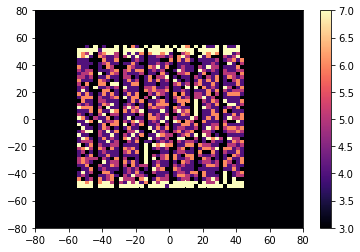

In [93]:
chind = 1
vmi=3
vma = 7
print(fl623_grided.histogram_LC.shape)

plt.pcolormesh(fl623_grided.d0_edges_grid[:,:,chind],fl623_grided.d1_edges_grid[:,:,chind],
            fl623_grided.histogram_LC[:,:,0,chind,0],cmap=ccm,vmin=vmi, vmax = vma)
plt.colorbar()
plt.show



(64, 64, 1, 16)


<function matplotlib.pyplot.show(close=None, block=None)>

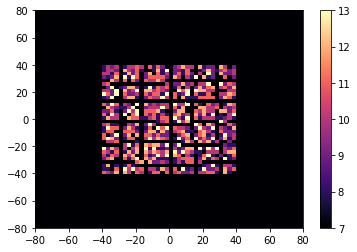

In [100]:
print(beam.V_LC_operation_count.shape)
vmi=7
vma = 13
plt.pcolormesh(beam.d0_edges_grid[:,:,chind],beam.d1_edges_grid[:,:,chind],
            beam.V_LC_operation_count[:,:,0,chind],cmap=ccm,vmin=vmi, vmax = vma)
plt.colorbar()
plt.show



<ipython-input-43-b48633bcb666>:33: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt0 = axs0.pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
<ipython-input-43-b48633bcb666>:46: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt0 = axs1.pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],


Text(0.5, 0, 'Distance [m]')

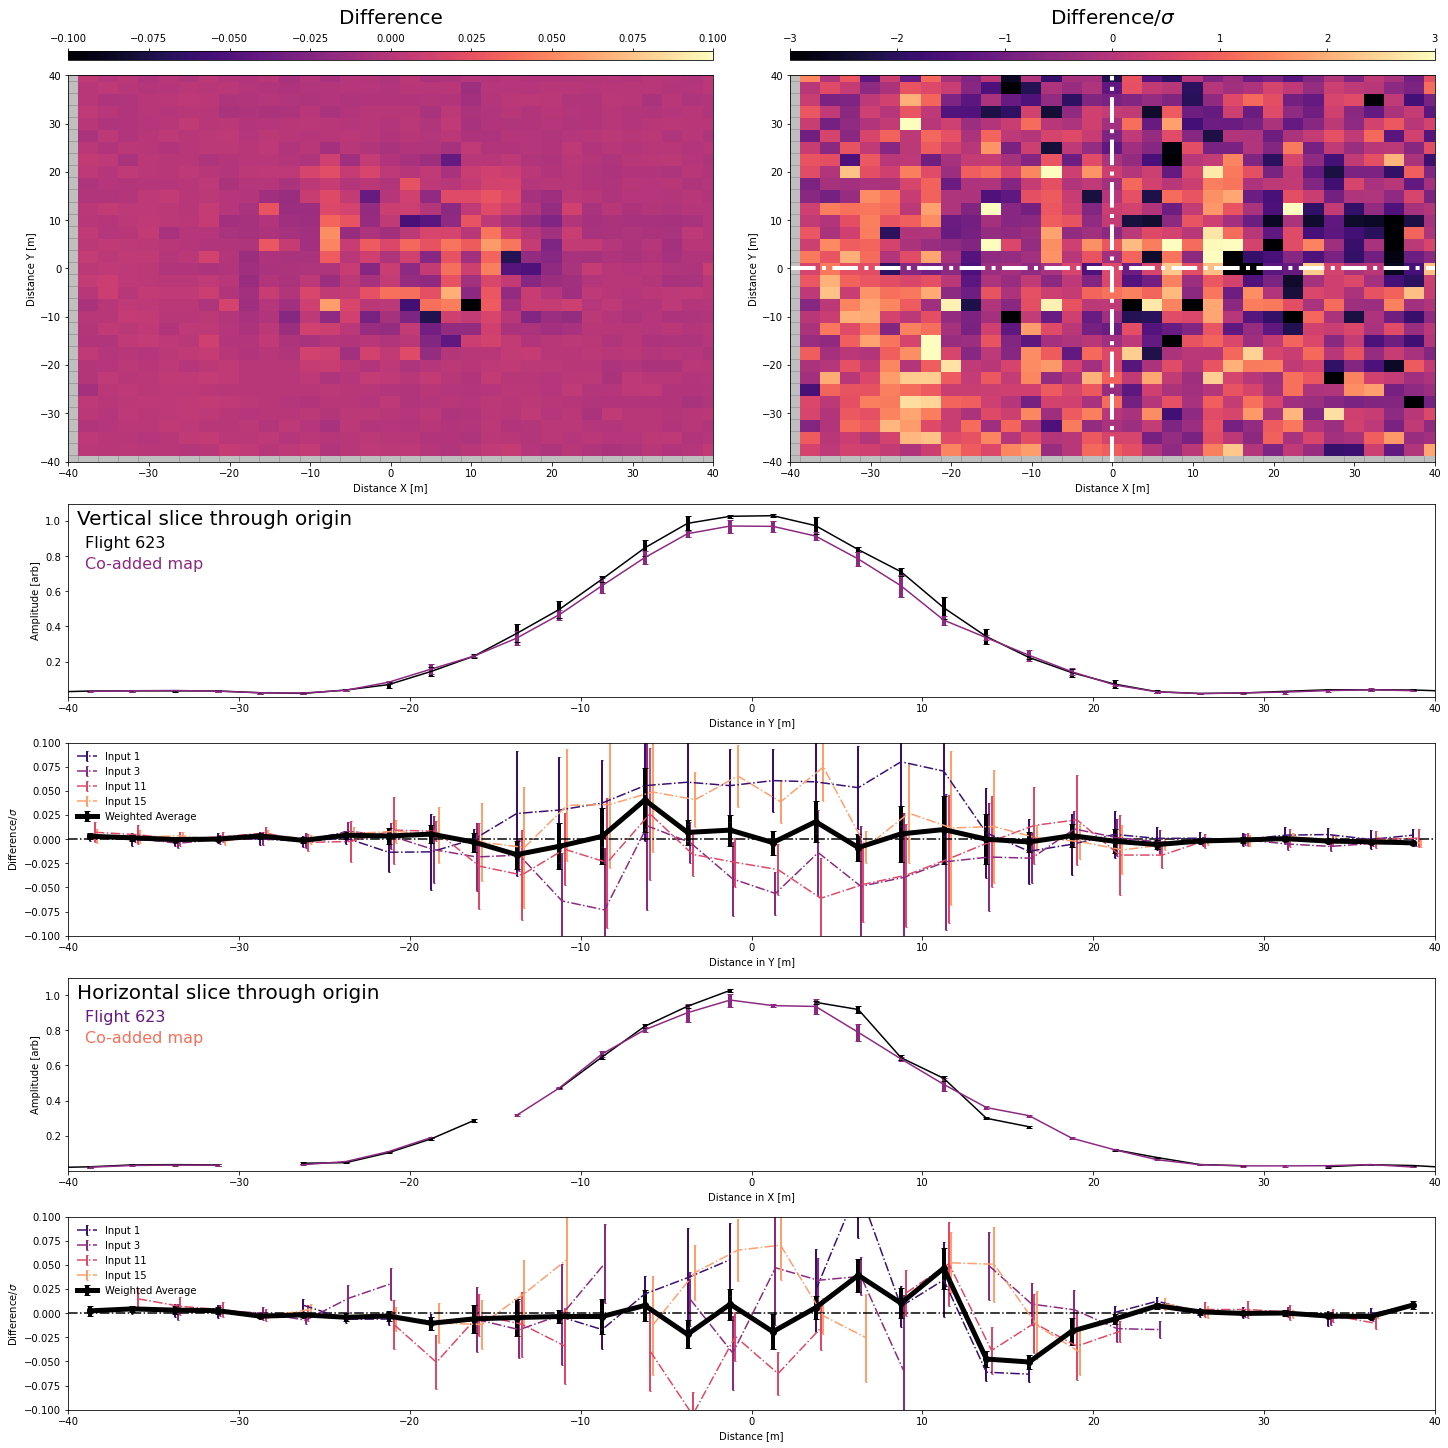

In [43]:
### 5. Make beautiful plot (put here to make iterating on plotting easier)

colors=pu.cm_to_discrete(cm.magma, 10)
xx = 0
c = 0

# This is the channel that gets plotted
ci=3
chi = pols[ci]

colx = pu.get_slice(fl623_grided.d0_centers_grid[:,:,0],
                    fl623_grided.d1_centers_grid[:,:,0],
                    fl623[:,:,chind],xx, sliceOrientation='v')
coly = pu.get_slice(fl623_grided.d0_centers_grid[:,:,0],
                    fl623_grided.d1_centers_grid[:,:,0],
                    fl623[:,:,chind],xx, sliceOrientation='h')


from matplotlib.gridspec import GridSpec

fig = plt.figure(constrained_layout=True,figsize=(20,20))

gs = GridSpec(6, 2, height_ratios=[0.05,2,1,1,1,1], width_ratios=[0.5,0.5],figure=fig)

axs0 = fig.add_subplot(gs[1, 0])
axs1 = fig.add_subplot(gs[1, 1])
axs2 = fig.add_subplot(gs[2, :])
axs3 = fig.add_subplot(gs[3, :])
axs4 = fig.add_subplot(gs[4, :])
axs5 = fig.add_subplot(gs[5, :])

# Diff plot and colorbar
plt0 = axs0.pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
               diff_weighted,cmap=cm.magma,vmin=-0.1,vmax=0.1)#,edgecolors='k')
axs0.set_xlim(-40,40)
axs0.set_ylim(-40,40)
axs0.set_xlabel('Distance X [m]')
axs0.set_ylabel('Distance Y [m]')
#axs0.text(-35,35,'Difference, averaged over inputs',color='white',fontsize=20,weight='bold')
cbax = plt.subplot(gs[0, 0])
cb = Colorbar(ax = cbax, mappable = plt0, orientation = 'horizontal', ticklocation = 'top')
cb.set_label('Difference', labelpad=10,fontsize=20)


# Diff/sigma plot and colorbar
plt0 = axs1.pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
               diff_weighted/err_weighted, cmap=cm.magma,vmax=3,vmin=-3)#,edgecolors='k')
axs1.axhline(0,color='white',linestyle='-.',linewidth=4)
axs1.axvline(0,color='white',linestyle='-.',linewidth=4)
axs1.set_xlim(-40,40)
axs1.set_ylim(-40,40)
axs1.set_xlabel('Distance X [m]')
axs1.set_ylabel('Distance Y [m]')
#axs1.text(-30,30,'Difference/Std, averaged over inputs',color='white',weight='bold',fontsize=20)
cbax = plt.subplot(gs[0, 1])
cb = Colorbar(ax = cbax, mappable = plt0, orientation = 'horizontal', ticklocation = 'top')
cb.set_label(r'Difference/$\sigma$', labelpad=10,fontsize=20)


# Vertical Slice for two flights, one channel
axs2.errorbar(beam.d1_centers_grid[colx,:,0],fl623[colx,:,chi],
                yerr=fl623_err[colx,:,chi],elinewidth=4,capsize=3,
             color=colors[c],label='Flight 623')

axs2.errorbar(fl623_grided.d1_centers_grid[colx,:,0],beam.V_LC_operation[colx,:,0,chi],
                yerr=beam.V_LC_operation_err[colx,:,0,chi],elinewidth=4,capsize=3,
             color=colors[c+4],label='Co-added flights')
axs2.text(-39.5,0.98,'Vertical slice through origin',color='black',fontsize=20)
axs2.text(-39,0.85,'Flight 623',color=colors[c],fontsize=16)
axs2.text(-39,0.73,'Co-added map',color=colors[c+4],fontsize=16)
axs2.set_ylim(1E-4,1.1)
axs2.set_xlim(-40,40)
axs2.set_ylabel('Amplitude [arb]')
axs2.set_xlabel('Distance in Y [m]')

# Vertical Slice for all channels, and average
for c,chind in enumerate(pols):
    axs3.errorbar(fl623_grided.d1_centers_grid[colx,:,0]+(c*0.15),diffarr[colx,:,chind],
             yerr=np.sqrt(vararr[colx,:,chind]),elinewidth=2,capsize=1,linestyle='-.',
                  color=colors[2*c + 2],label='Input '+str(chind))
    
axs3.errorbar(fl623_grided.d1_centers_grid[colx,:,0],diff_weighted[colx,:],
             yerr=err_weighted[colx,:],
              marker='o',color='black',linewidth=5,elinewidth=4,capsize=3,
              label='Weighted Average')
axs3.axhline(0,linestyle='-.',color='black')
axs3.set_ylim(-0.1,0.1)
axs3.set_xlim(-40,40)
axs3.legend(loc='upper left',frameon=False)
axs3.set_ylabel(r'Difference/$\sigma$')
axs3.set_xlabel('Distance in Y [m]')

# Horizontal slice for two flights, one channel
axs4.errorbar(fl623_grided.d0_centers_grid[:,coly,0],fl623[:,coly,chi],
                yerr=fl623_err[:,coly,chi],elinewidth=4,capsize=3,
            color=colors[0],label='Flight 623')
axs4.errorbar(fl623_grided.d0_centers_grid[:,coly,0],beam.V_LC_operation[:,coly,0,chi],
                yerr=beam.V_LC_operation_err[:,coly,0,chi],elinewidth=4,capsize=3,
             color=colors[4],label='Co-added flights')
axs4.set_ylim(1E-4,1.1)
axs4.set_xlim(-40,40)
axs4.text(-39.5,0.98,'Horizontal slice through origin',color='black',fontsize=20)
axs4.text(-39,0.85,'Flight 623',color=colors[c],fontsize=16)
axs4.text(-39,0.73,'Co-added map',color=colors[c+4],fontsize=16)
axs4.set_xlabel('Distance in X [m]')
axs4.set_ylabel('Amplitude [arb]')

for c,chind in enumerate(pols):
    axs5.errorbar(fl623_grided.d0_centers_grid[:,coly,0]+(c*0.15),diffarr[:,coly,chind],
                  yerr=np.sqrt(vararr[:,coly,chind]),elinewidth=2,capsize=1,linestyle='-.',
                  color=colors[2*c + 2],label='Input '+str(chind))
axs5.errorbar(fl623_grided.d0_centers_grid[:,coly,0],diff_weighted[:,coly],
             yerr=err_weighted[:,coly],marker='o',color='black',linewidth=5,elinewidth=4,capsize=3,
              label='Weighted Average')
axs5.axhline(0,linestyle='-.',color='black')
axs5.set_ylim(-0.1,0.1)
axs5.set_xlim(-40,40)
axs5.legend(loc='upper left',frameon=False,fontsize=fsz)
axs5.set_ylabel(r'Difference')
axs5.set_xlabel('Distance [m]')


<ipython-input-119-76669330cfe6>:31: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt0 = axs0.pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
<ipython-input-119-76669330cfe6>:36: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt0 = axs1.pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],


Text(30, 0.07, 'Horizontal Slice')

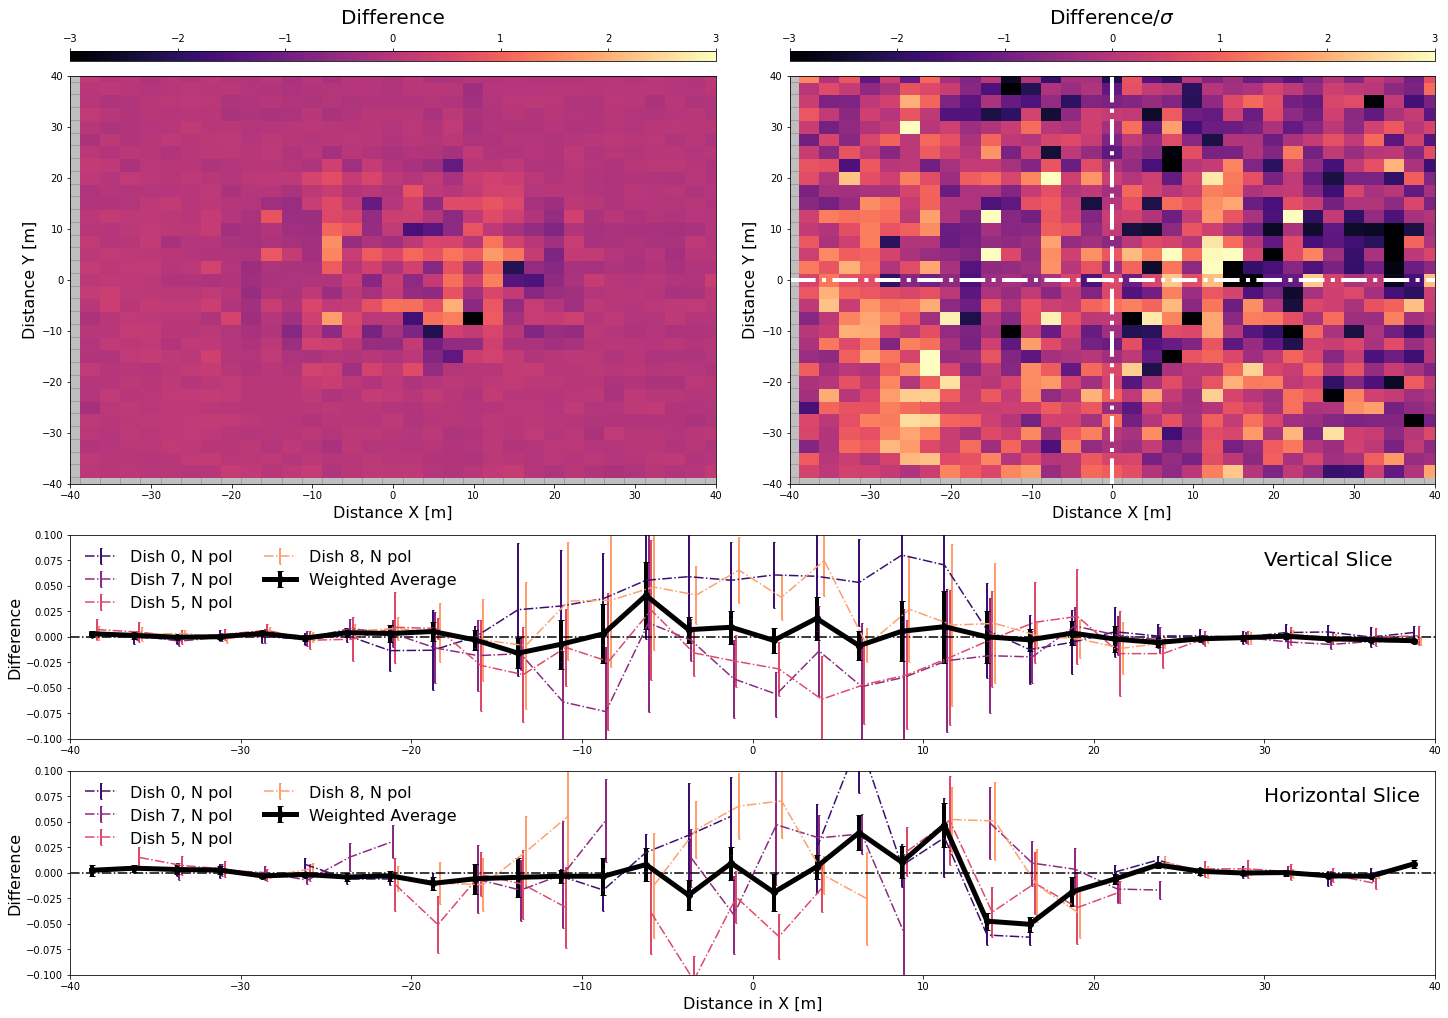

In [119]:
### 5. Make beautiful plot (put here to make iterating on plotting easier)

colors=pu.cm_to_discrete(cm.magma, 10)
xx = 0
c = 0

# This is the channel that gets plotted
ci=0
chi = pols[ci]

colx = pu.get_slice(fl623_grided.d0_centers_grid[:,:,0],
                    fl623_grided.d1_centers_grid[:,:,0],
                    fl623[:,:,chind],xx, sliceOrientation='v')
coly = pu.get_slice(fl623_grided.d0_centers_grid[:,:,0],
                    fl623_grided.d1_centers_grid[:,:,0],
                    fl623[:,:,chind],xx, sliceOrientation='h')


from matplotlib.gridspec import GridSpec

fig = plt.figure(constrained_layout=True,figsize=(20,20))

gs = GridSpec(6, 2, height_ratios=[0.05,2,1,1,1,1], width_ratios=[0.5,0.5],figure=fig)

axs0 = fig.add_subplot(gs[1, 0])
axs1 = fig.add_subplot(gs[1, 1])
axs3 = fig.add_subplot(gs[2, :])
axs5 = fig.add_subplot(gs[3, :])

# Diff plot and colorbar
plt0 = axs0.pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
               diff_weighted,cmap=cm.magma,vmin=-0.1,vmax=0.1)#,edgecolors='k')


# Diff/sigma plot and colorbar
plt0 = axs1.pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
               diff_weighted/err_weighted, cmap=cm.magma,vmax=3,vmin=-3)#,edgecolors='k')


# Vertical Slice for all channels, and average
for c,chind in enumerate(pols):
    axs3.errorbar(fl623_grided.d1_centers_grid[colx,:,0]+(c*0.15),diffarr[colx,:,chind],
             yerr=np.sqrt(vararr[colx,:,chind]),elinewidth=2,capsize=1,linestyle='-.',
                  color=colors[2*c + 2],label=dlab[chind])
    
axs3.errorbar(fl623_grided.d1_centers_grid[colx,:,0],diff_weighted[colx,:],
             yerr=err_weighted[colx,:],
              marker='o',color='black',linewidth=5,elinewidth=4,capsize=3,
              label='Weighted Average')

# Horizontal slice for all channels, and average
for c,chind in enumerate(pols):
    axs5.errorbar(fl623_grided.d0_centers_grid[:,coly,0]+(c*0.15),diffarr[:,coly,chind],
                  yerr=np.sqrt(vararr[:,coly,chind]),elinewidth=2,capsize=1,linestyle='-.',
                  color=colors[2*c + 2],label=dlab[chind])
axs5.errorbar(fl623_grided.d0_centers_grid[:,coly,0],diff_weighted[:,coly],
             yerr=err_weighted[:,coly],marker='o',color='black',linewidth=5,elinewidth=4,capsize=3,
              label='Weighted Average')

axs0.set_xlim(-40,40)
axs0.set_ylim(-40,40)
axs0.set_xlabel('Distance X [m]',fontsize=fsz)
axs0.set_ylabel('Distance Y [m]',fontsize=fsz)
#axs0.text(-35,35,'Difference, averaged over inputs',color='white',fontsize=20,weight='bold')
cbax = plt.subplot(gs[0, 0])
cb = Colorbar(ax = cbax, mappable = plt0, orientation = 'horizontal', ticklocation = 'top')
cb.set_label('Difference', labelpad=10,fontsize=20)


axs1.axhline(0,color='white',linestyle='-.',linewidth=4)
axs1.axvline(0,color='white',linestyle='-.',linewidth=4)
axs1.set_xlim(-40,40)
axs1.set_ylim(-40,40)
axs1.set_xlabel('Distance X [m]',fontsize=fsz)
axs1.set_ylabel('Distance Y [m]',fontsize=fsz)
#axs1.text(-30,30,'Difference/Std, averaged over inputs',color='white',weight='bold',fontsize=20)
cbax = plt.subplot(gs[0, 1])
cb = Colorbar(ax = cbax, mappable = plt0, orientation = 'horizontal', ticklocation = 'top')
cb.set_label(r'Difference/$\sigma$', labelpad=10,fontsize=20)


axs3.axhline(0,linestyle='-.',color='black')
axs3.set_ylim(-0.1,0.1)
axs3.set_xlim(-40,40)
axs3.legend(loc='upper left',frameon=False,fontsize=fsz,ncol=2)
axs3.set_ylabel(r'Difference',fontsize=fsz)
axs3.text(30,0.07,'Vertical Slice',fontsize=20)


axs5.axhline(0,linestyle='-.',color='black')
axs5.set_ylim(-0.1,0.1)
axs5.set_xlim(-40,40)
axs5.legend(loc='upper left',frameon=False,ncol=2,fontsize=fsz)
axs5.set_ylabel(r'Difference',fontsize=fsz)
axs5.set_xlabel('Distance in X [m]',fontsize=fsz)
axs5.text(30,0.07,'Horizontal Slice',fontsize=20)


<ipython-input-108-627645e1a9cf>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt0 = axs0.pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],


(-40.0, 40.0)

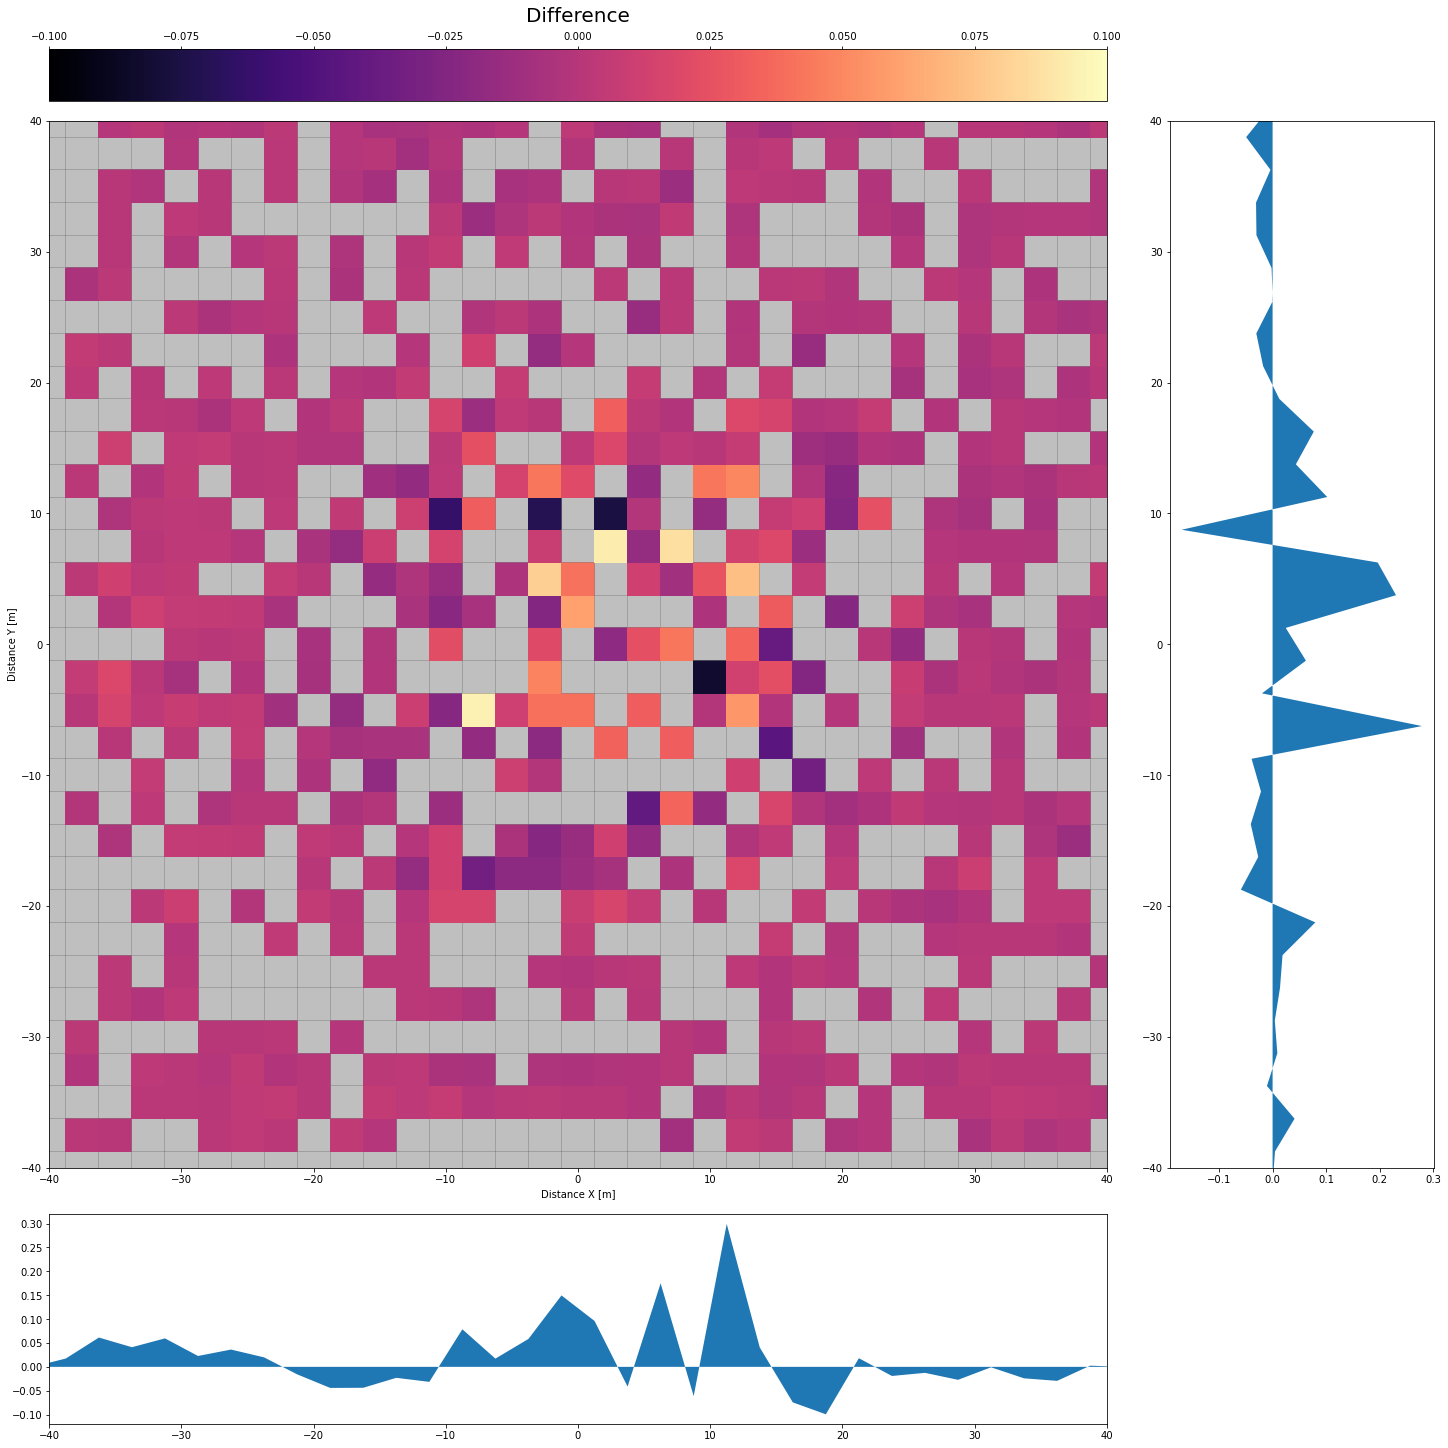

In [108]:
### 5. Histogram down the two axes to check for bimodality


fig = plt.figure(constrained_layout=True,figsize=(20,20))

gs = GridSpec(3, 2, height_ratios=[0.05,1,0.2], width_ratios=[2,0.5],figure=fig)

axs0 = fig.add_subplot(gs[1,0])
axs1 = fig.add_subplot(gs[2,0])
axs2 = fig.add_subplot(gs[1,1])


# Diff plot and colorbar
plt0 = axs0.pcolormesh(beam.d0_centers_grid[:,:,chind],beam.d1_centers_grid[:,:,chind],
               diff_weighted,cmap=cm.magma,vmin=-0.1,vmax=0.1)#,edgecolors='k')
axs0.set_xlim(-40,40)
axs0.set_ylim(-40,40)
axs0.set_xlabel('Distance X [m]')
axs0.set_ylabel('Distance Y [m]')
#axs0.text(-35,35,'Difference, averaged over inputs',color='white',fontsize=20,weight='bold')
cbax = plt.subplot(gs[0, 0])
cb = Colorbar(ax = cbax, mappable = plt0, orientation = 'horizontal', ticklocation = 'top')
cb.set_label('Difference', labelpad=10,fontsize=20)

axs1.fill_between(np.nanmean(beam.d0_centers_grid[:,:,chind],axis=1),0,np.nansum(diff_weighted,axis=1))
axs1.set_xlim(-40,40)

axs2.fill_betweenx(np.nanmean(beam.d1_centers_grid[:,:,chind],axis=0),0,
         np.nansum(diff_weighted,axis=0))
axs2.set_ylim(-40,40)







In [ ]:
#print(np.nansum(diff_weighted,axis=0))

#print(np.nansum(diff_weighted,axis=1))

print(beam.d1_centers_grid[0,:,chind])

plt.bar(np.nanmean(beam.d1_centers_grid[:,:,chind],axis=0),np.nansum(diff_weighted,axis=0),width=2)
plt.xlim(-40,40)

In [ ]:
####################################################################################
############################# SECTION 5 ############################################
############################# SECTION 5 ############################################
############################# SECTION 5 ############################################
############################# SECTION 5 ############################################
####################################################################################


# Note, Annie's plots are in her notebook AP_drone_paper_rfi, that won't be reproduced here
# That contains everything ever to get from measurements to EIRP for those calibrated
# measurements.

In [ ]:
######################################################################
########## Get Annie's Chamber Measurements ##########
######################################################################


def VNAtranslator(allscans, rows_to_cut=51):
    freqs = []
    mags = []
    for i in range(len(allscans)):
        data = []
        with open(allscans[i], 'rt') as f:
            reader = csv.reader(f)
            for row in reader:
                data.append(row)
        data_np = np.array(data)
        datafinal = data_np[rows_to_cut:-1]
        df=[]
        freq1 = []
        mag1 = []
        for i in datafinal:
            freq1.append(float(i[0]))
            mag1.append(float(i[1]))   
        freqs.append(freq1)
        mags.append(mag1)
    return(freqs,mags)

def avg_spectra(spec_list):
    avg = np.zeros(len(spec_list[0]))
    for i in range(len(spec_list[0])):
        for j in range(len(spec_list)):
            avg[i] += (10.**(spec_list[j][i]/10.))
        avg[i] = avg[i]/len(spec_list)
        avg[i] = 10.*np.log10(avg[i])        
    return np.array(avg)

# Annie's data loading and manipulating into correct units

# Load in all the RFI chamber data and put it in a nice dictionary

fileset='/hirax/GBO_Oct_2021/RFIChamber/*.csv'

allscans=np.sort(glob.glob(fileset))
vnafreqs,mags=VNAtranslator(allscans = allscans, rows_to_cut=1)

for i in range(len(vnafreqs)):
    vnafreqs[i] = np.array(vnafreqs[i])#/1000000000.
    mags[i] = np.array(mags[i])
    #print(str(i)+": "+allscans[i])

# build the EMI chamber dictionary
chamber = {
    "low":{
        "bgnd":None,
        "horiz":{},
        "vert":{},
        "yaw":{},
        "shield":None,
        "laptop":{},
        "motor":{},
        "nsonly":{},
        "nsdrone":{},
        "long":[],
        "freqs":None
    },
    "high":{
        "bgnd":None,
        "horiz":{},
        "vert":{},
        "yaw":{},
        "shield":None,
        "laptop":None,
        "motor":None,
        "freqs":None
    }
}

used = []
# start by making the low-band version
for i, fname in enumerate(allscans):
    if "20M1G.csv" in fname:
#         print(fname)
        if "QR" in fname:
            chamber["low"]["freqs"] = vnafreqs[i]; used.append(i)
            chamber["low"]["bgnd"] = mags[i]
        if "DroneOnHoriz" in fname:
            angle = int(fname.split('/')[-1][12])
            if angle == 0: chamber["low"]["horiz"]["0"] = mags[i]; used.append(i)
            if angle == 1: chamber["low"]["horiz"]["180"] = mags[i]; used.append(i)
            if angle == 2: chamber["low"]["horiz"]["270"] = mags[i]; used.append(i)
            if angle == 9: chamber["low"]["horiz"]["90"] = mags[i]; used.append(i)
        if "Yaw" in fname and not ("ShieldedPS" in fname):
            angle = int(fname.split('/')[-1][10])
            if angle == 0: chamber["low"]["yaw"]["0"] = mags[i]; used.append(i)
            if angle == 6: chamber["low"]["yaw"]["60"] = mags[i]; used.append(i)
            if angle == 1: chamber["low"]["yaw"]["120"] = mags[i]; used.append(i)
        if "DroneOffNoiseOn" in fname:
            if "Horiz" in fname and "CoPol" in fname: chamber["low"]["nsonly"]["coh"] = mags[i]; used.append(i)
            if "Horiz" in fname and "XPol" in fname: chamber["low"]["nsonly"]["xh"] = mags[i]; used.append(i)
            if "Vert" in fname and "CoPol" in fname: chamber["low"]["nsonly"]["cov"] = mags[i]; used.append(i)
            if "Vert" in fname and "XPol" in fname: chamber["low"]["nsonly"]["xv"] = mags[i]; used.append(i)
        if "DroneOnNoiseOn" in fname:
            if "Horiz" in fname and "CoPol" in fname: chamber["low"]["nsdrone"]["coh"] = mags[i]; used.append(i)
            if "Horiz" in fname and "XPol" in fname: chamber["low"]["nsdrone"]["xh"] = mags[i]; used.append(i)
            if "Vert" in fname and "CoPol" in fname: chamber["low"]["nsdrone"]["cov"] = mags[i]; used.append(i)
            if "Vert" in fname and "XPol" in fname: chamber["low"]["nsdrone"]["xv"] = mags[i]; used.append(i)
        if "LaptopOn" in fname:
            if "RotorsOn" in fname and "HPol" in fname: chamber["low"]["motor"]["hpol"] = mags[i]; used.append(i)
            if "RotorsOn" in fname and "EPol" in fname: chamber["low"]["motor"]["epol"] = mags[i]; used.append(i)
            if not ("RotorsOn" in fname) and "HPol" in fname: chamber["low"]["laptop"]["hpol"] = mags[i]; used.append(i)
            if not ("RotorsOn" in fname) and "EPol" in fname: chamber["low"]["laptop"]["epol"] = mags[i]; used.append(i)
        if "DroneOnVert" in fname and not ("ShieldedPS" in fname):
            angle = fname.split('/')[-1][11]
            if angle != '-':
                if angle == '0': chamber["low"]["vert"]["0"] = mags[i]; used.append(i)
                if angle == '1': chamber["low"]["vert"]["15"] = mags[i]; used.append(i)
                if angle == '3': chamber["low"]["vert"]["30"] = mags[i]; used.append(i)
                if angle == '4': chamber["low"]["vert"]["45"] = mags[i]; used.append(i)
                if angle == '6': chamber["low"]["vert"]["60"] = mags[i]; used.append(i)
                if angle == '9': chamber["low"]["vert"]["90"] = mags[i]; used.append(i)
            else:
                angle = fname.split('/')[-1][12]
                if angle == '3': chamber["low"]["vert"]["-30"] = mags[i]; used.append(i)
                if angle == '4': chamber["low"]["vert"]["-45"] = mags[i]; used.append(i)
                if angle == '6': chamber["low"]["vert"]["-60"] = mags[i]; used.append(i)
                if angle == '9': chamber["low"]["vert"]["-90"] = mags[i]; used.append(i)
                if angle == '1' and fname.split('/')[-1][13] == '5': chamber["low"]["vert"]["-15"] = mags[i]; used.append(i)
                if angle == '1' and fname.split('/')[-1][13] == '8': chamber["low"]["vert"]["180"] = mags[i]; used.append(i)
        if "ShieldedPS" in fname:
            chamber["low"]["shield"] = mags[i]; used.append(i)

low_bgnds = []
            
for i, fname in enumerate(allscans):
    if "EPol20M1G_" in fname:
        chamber["low"]["long"].append(mags[i])
        print(fname)
    if "QR20M1G" in fname:
        low_bgnds.append(mags[i])
        print(fname)

# then join up the high-band spectra
# find all the unique spectra
hi_unique = []
for i, fname in enumerate(allscans):
    if "1G2G.csv" in fname:
        hi_unique.append(fname)

# join each spectrum into one big spectrum
joined_freqs = []
joined_mags = []
joined_basenames = []
for fname in hi_unique:
    basename = fname.split('/')[-1].split('G')[0][:-1]
    joined_basenames.append(basename)
    
    freqs12=[]; freqs24=[]; freqs46=[]; freqs68=[]; freqs810=[]; freqs1012=[]
    mags12=[]; mags24=[]; mags46=[]; mags68=[]; mags810=[]; mags1012=[]
    for i, fname in enumerate(allscans):
        if basename in fname:
            if "1G2G" in fname: mags12 = mags[i]; freqs12 = vnafreqs[i]
            if "2G4G" in fname: mags24 = mags[i]; freqs24 = vnafreqs[i]
            if "4G6G" in fname: mags46 = mags[i]; freqs46 = vnafreqs[i]
            if "6G8G" in fname: mags68 = mags[i]; freqs68 = vnafreqs[i]
            if "8G10G" in fname: mags810 = mags[i]; freqs810 = vnafreqs[i]
            if "10G12G" in fname: mags1012 = mags[i]; freqs1012 = vnafreqs[i]
                
    joined_freqs.append(np.concatenate((freqs12, freqs24, freqs46, freqs68, freqs810, freqs1012)))
    joined_mags.append(np.concatenate((mags12, mags24, mags46, mags68, mags810, mags1012)))

# then assign each spectrum into the dictionary
for i, basename in enumerate(joined_basenames):
    if "QR" in basename: chamber["high"]["bgnd"] = joined_mags[i]
    if "Horiz0" in basename: chamber["high"]["horiz"]["0"] = joined_mags[i]
    if "Horiz90" in basename: chamber["high"]["horiz"]["90"] = joined_mags[i]
    if "LaptopOnHoriz" in basename: chamber["high"]["laptop"] = joined_mags[i]
    if "LaptopOnRotors" in basename: chamber["high"]["motor"] = joined_mags[i]
    if "Vert-0deg" in basename: chamber["high"]["vert"]["0"] = joined_mags[i]
    if "Vert-180deg" in basename: chamber["high"]["vert"]["180"] = joined_mags[i]
    if "Vert-90deg" in basename: chamber["high"]["vert"]["-90"] = joined_mags[i]
    if "Vert90deg" in basename: chamber["high"]["vert"]["90"] = joined_mags[i]
    if "Yaw0deg" in basename and not ("Shielded" in basename): chamber["high"]["yaw"]["0"] = joined_mags[i]
    if "Yaw60deg" in basename: chamber["high"]["yaw"]["60"] = joined_mags[i]
    if "Yaw120deg" in basename: chamber["high"]["yaw"]["120"] = joined_mags[i]
    if "ShieldedPS" in basename: chamber["high"]["shield"] = joined_mags[i]

    
chamber["high"]["freqs"] = joined_freqs[0] # only need one freqs array

# define all the correction curves 

##################################
# carla's emi chamber equipment: #
##################################

# log periodic dipole array (low-band antenna)
lpda_freqs = [20,200,225,250,275,300,325,350,375,400,425,450,475,500,525,550,575,600,625,650,675,700,725,750,775,800,825,850,875,900,925,950,975,1000]
lpda_mags = [-11,3.73,5.79,5.2,5.31,4.09,5.34,5.41,5.86,6.29,6.25,5.85,5.74,5.76,5.62,5.97,6.17,6.2,6.03,6.2,5.71,5.87,6.22,6.42,6.51,6.2,5.83,6.16,5.84,6.06,6.03,5.9,5.51,5.27]

# low-band amp
amp1306e_freqs = [20,130,134.8,139.6,144.4,149.2,154,158.8,163.6,168.4,173.2,178,182.8,187.6,192.4,197.2,202,206.8,211.6,216.4,221.2,226,230.8,235.6,240.4,245.2,250,254.8,259.6,264.4,269.2,274,278.8,283.6,288.4,293.2,298,302.8,307.6,312.4,317.2,322,326.8,331.6,336.4,341.2,346,350.8,355.6,360.4,365.2,370,374.8,379.6,384.4,389.2,394,398.8,403.6,408.4,413.2,418,422.8,427.6,432.4,437.2,442,446.8,451.6,456.4,461.2,466,470.8,475.6,480.4,485.2,490,494.8,499.6,504.4,509.2,514,518.8,523.6,528.4,533.2,538,542.8,547.6,552.4,557.2,562,566.8,571.6,576.4,581.2,586,590.8,595.6,600.4,605.2,610,614.8,619.6,624.4,629.2,634,638.8,643.6,648.4,653.2,658,662.8,667.6,672.4,677.2,682,686.8,691.6,696.4,701.2,706,710.8,715.6,720.4,725.2,730,734.8,739.6,744.4,749.2,754,758.8,763.6,768.4,773.2,778,782.8,787.6,792.4,797.2,802,806.8,811.6,816.4,821.2,826,830.8,835.6,840.4,845.2,850,854.8,859.6,864.4,869.2,874,878.8,883.6,888.4,893.2,898,902.8,907.6,912.4,917.2,922,926.8,931.6,936.4,941.2,946,950.8,955.6,960.4,965.2,970,974.8,979.6,984.4,989.2,994,998.8,1003.6,1008.4,1013.2,1018,1022.8,1027.6,1032.4,1037.2,1042,1046.8,1051.6,1056.4,1061.2,1066,1070.8,1075.6,1080.4,1085.2,1090]
amp1306e_mags = [50.77299,51.5022358002,51.5340572965,51.8168429743,51.5411649186,52.1288497492,52.2331556513,51.9210841202,52.6978485457,52.5066985243,52.3330134085,52.4767813651,52.236362315,52.4667654603,51.7364989038,52.1970763591,51.9618637052,52.3121426383,52.2140104293,51.9567961691,52.7923902668,52.1215574021,52.3924574285,52.6488394845,52.3575815266,52.7850996947,51.7058498701,51.8021452423,52.2515216919,51.5767581212,52.1412423383,52.0633205533,52.0847754917,51.9913646037,52.2682158469,52.1853574007,52.1096260378,52.0225949201,51.9805963851,52.3129039943,52.0124973282,52.5510224111,52.7389164134,52.5358228955,52.1895230602,52.256804462,52.3060012635,52.1119855319,52.208330587,52.455131406,52.1899852624,51.5245325729,51.6456222144,51.7910646106,51.5483851712,51.6174495349,51.5560711701,51.5481432884,51.8686813912,51.6957402271,51.7592209264,51.7867107471,51.4029940195,51.7061277771,51.8080073623,51.9627052784,51.6411282821,51.7282972828,51.8727081752,51.7214349445,51.5751585813,51.84076455,52.0227922504,51.8211688168,51.9583772005,51.7345044121,52.0244277412,51.685077462,51.7261644875,51.6850876244,51.4763034769,51.4494924586,51.4696853247,51.438244663,51.1860506426,51.4433172208,51.4534407907,51.1677466045,51.3316951327,51.0598074924,51.2471965373,51.1376320835,51.2006849395,51.1388057409,51.0842374459,50.9247757784,50.8499695942,50.6627996713,50.528011304,50.482259272,50.4615880455,50.6570666309,50.6975833433,50.5715062129,50.660823626,50.5293576468,50.4444206444,50.5371167789,50.3036436438,50.4406106123,50.5072263847,50.1011505697,50.1628682927,50.2118681652,50.2944151119,50.0381615469,50.1760201525,50.1242166586,50.2095511988,50.1849988886,50.0172019305,50.1505326872,50.2097677205,50.2275466519,50.3095054239,50.4529536245,49.6562079898,49.6870793873,49.9307031115,49.9469055479,50.0773097785,49.8258281863,50.0398213294,49.8756091474,50.0765463733,50.0018541906,49.960330342,50.0440662527,50.0077009624,50.1334818044,50.0277006711,50.1619995218,49.9021834022,49.8484908758,49.9576936266,50.122070728,49.8699308329,49.9950544561,49.9716047428,49.9994713299,49.8619840673,50.0596138993,50.1090530763,49.7740136065,49.9880589813,50.0650304256,50.0327341818,50.070176332,49.9245103197,50.0184203481,49.9550227182,49.9781756895,49.9325854023,49.988188586,50.0883969706,49.9605712262,50.0240080566,49.9663123101,49.9680722882,49.7667914013,49.6831180251,49.5922303679,49.6314711703,49.4572746604,49.3377725314,49.4001453185,49.302544801,49.196111499,49.2202315845,49.080594269,49.1074212725,48.9189748535,48.8772353599,48.8042136073,48.8162557794,48.8466387371,48.8831005917,48.7490654104,48.6283379876,48.5667267299,48.4263009209,48.4226180517,48.2901498186,48.1014925088,48.1421858317,47.9370750006,47.9024891362,47.6489315241,47.6653692958,47.4032027924,47.4701643407,47.2577990117]

# high-band amp
ampamf6d_freqs = [924.4,1023.7,1123,1222.3,1321.6,1420.9,1520.2,1619.5,1718.8,1818.1,1917.4,2016.7,2116,2215.3,2314.6,2413.9,2513.2,2612.5,2711.8,2811.1,2910.4,3009.7,3109,3208.3,3307.6,3406.9,3506.2,3605.5,3704.8,3804.1,3903.4,4002.7,4102,4201.3,4300.6,4399.9,4499.2,4598.5,4697.8,4797.1,4896.4,4995.7,5095,5194.3,5293.6,5392.9,5492.2,5591.5,5690.8,5790.1,5889.4,5988.7,6088,6187.3,6286.6,6385.9,6485.2,6584.5,6683.8,6783.1,6882.4,6981.7,7081,7180.3,7279.6,7378.9,7478.2,7577.5,7676.8,7776.1,7875.4,7974.7,8074,8173.3,8272.6,8371.9,8471.2,8570.5,8669.8,8769.1,8868.4,8967.7,9067,9166.3,9265.6,9364.9,9464.2,9563.5,9662.8,9762.1,9861.4,9960.7,10060,10159.3,10258.6,10357.9,10457.2,10556.5,10655.8,10755.1,10854.4,10953.7,11053,11152.3,11251.6,11350.9,11450.2,11549.5,11648.8,11748.1,11847.4,11946.7,12046,12145.3,12244.6,12343.9,12443.2,12542.5,12641.8,12741.1,12840.4,12939.7,13039,13138.3,13237.6,13336.9,13436.2,13535.5,13634.8,13734.1,13833.4,13932.7,14032,14131.3,14230.6,14329.9,14429.2,14528.5,14627.8,14727.1,14826.4,14925.7,15025,15124.3,15223.6,15322.9,15422.2,15521.5,15620.8,15720.1,15819.4,15918.7,16018,16117.3,16216.6,16315.9,16415.2,16514.5,16613.8,16713.1,16812.4,16911.7,17011,17110.3,17209.6,17308.9,17408.2,17507.5,17606.8,17706.1,17805.4,17904.7,18004,18103.3,18202.6,18301.9,18401.2,18500.5,18599.8,18699.1,18798.4,18897.7,18997,19096.3,19195.6,19294.9,19394.2,19493.5,19592.8,19692.1,19791.4,19890.7,19990]
ampamf6d_mags = [45.95778714,47.22194971,47.84961611,47.81222727,47.92151225,47.41683198,47.37733531,47.31254399,47.24192243,47.45712901,47.12128631,47.42098376,47.29376481,47.26045483,47.29753494,47.36204678,47.36439865,47.47405179,47.61609732,47.69734996,47.4333864,47.44013024,47.46615753,47.45952267,47.42564484,47.35353804,47.27491855,47.2922184,47.22692062,47.1907485,47.44704892,47.15173393,47.24867686,47.22744958,47.27775317,47.16403461,47.01011398,47.20914701,46.84812525,46.87619541,46.59166818,46.7171574,46.40908046,46.10322534,46.03834163,45.5517617,45.16025821,45.19422566,44.98866923,44.79249792,44.68534081,44.66887308,44.76126524,44.7182803,44.86046759,44.89899926,45.26529031,45.27526553,45.51633191,45.95311173,45.92180424,46.10037392,46.2936488,46.08204093,46.3068397,46.41106436,46.30079967,46.24011502,46.0636797,45.85960227,45.68706226,45.46345938,45.38615594,45.22259483,45.00291109,44.84042047,44.6443673,44.59344018,44.2096427,44.21967281,43.76412028,43.86343967,43.69385373,43.28286175,43.67135681,43.21200456,43.33161405,42.85114753,43.59516783,43.16890062,43.23112868,43.33212866,43.60498673,43.82511709,43.88740362,44.1422186,44.15700652,44.09558292,44.44608767,44.28736322,44.47334811,44.34158823,44.18443737,44.26418633,44.23378646,44.15973258,44.13633002,44.29019817,44.32399041,44.25363211,44.39988022,44.64888832,44.72439439,44.71788797,44.92647408,44.95963255,44.84996672,44.96947481,44.6602547,44.87758607,44.42620204,44.63412212,44.51962228,44.45943473,44.54216566,44.35512612,44.30818217,44.39636429,44.6332696,44.84807873,44.85478566,44.93441168,45.00847916,45.0701666,45.08025539,44.8715493,44.8123555,44.47932552,44.54995376,44.26452815,44.65795936,44.6019418,44.56246757,44.79949488,44.85031261,44.69826739,45.05329801,45.13932057,45.31219607,45.26635081,45.45104125,45.51331423,45.76876006,45.82640692,45.61921954,45.45845315,45.32235599,45.37616308,45.17001928,45.05595048,44.87284855,44.77902735,44.66473177,44.74645936,44.65066294,44.6295042,44.7953945,44.31612763,44.78467826,44.71416037,44.76809719,44.8925023,44.89118117,44.89650393,44.63519906,44.83006836,44.37748305,44.19768938,44.44412256,44.09226919,44.11228102,43.88299162,43.7902218,44.17253079,44.36139631,44.0591114,44.30379373,44.37238908,44.18971542,44.10020769,44.23571717,44.18594662,44.24993839]

# cable losses
cablech6_freqs = [20,164.8,189.6,214.4,239.2,264,288.8,313.6,338.4,363.2,388,412.8,437.6,462.4,487.2,512,536.8,561.6,586.4,611.2,636,660.8,685.6,710.4,735.2,760,784.8,809.6,834.4,859.2,884,908.8,933.6,958.4,983.2,1008,1032.8,1057.6,1082.4,1107.2,1132,1156.8,1181.6,1206.4,1231.2,1256,1280.8,1305.6,1330.4,1355.2,1380,1404.8,1429.6,1454.4,1479.2,1504,1528.8,1553.6,1578.4,1603.2,1628,1652.8,1677.6,1702.4,1727.2,1752,1776.8,1801.6,1826.4,1851.2,1876,1900.8,1925.6,1950.4,1975.2,2000,2024.8,2049.6,2074.4,2099.2,2124,2148.8,2173.6,2198.4,2223.2,2248,2272.8,2297.6,2322.4,2347.2,2372,2396.8,2421.6,2446.4,2471.2,2496,2520.8,2545.6,2570.4,2595.2,2620,2644.8,2669.6,2694.4,2719.2,2744,2768.8,2793.6,2818.4,2843.2,2868,2892.8,2917.6,2942.4,2967.2,2992,3016.8,3041.6,3066.4,3091.2,3116,3140.8,3165.6,3190.4,3215.2,3240,3264.8,3289.6,3314.4,3339.2,3364,3388.8,3413.6,3438.4,3463.2,3488,3512.8,3537.6,3562.4,3587.2,3612,3636.8,3661.6,3686.4,3711.2,3736,3760.8,3785.6,3810.4,3835.2,3860,3884.8,3909.6,3934.4,3959.2,3984,4008.8,4033.6,4058.4,4083.2,4108,4132.8,4157.6,4182.4,4207.2,4232,4256.8,4281.6,4306.4,4331.2,4356,4380.8,4405.6,4430.4,4455.2,4480,4504.8,4529.6,4554.4,4579.2,4604,4628.8,4653.6,4678.4,4703.2,4728,4752.8,4777.6,4802.4,4827.2,4852,4876.8,4901.6,4926.4,4951.2,4976,5000.8,5025.6,5050.4,5075.2,5100,5124.8,5149.6,5174.4,5199.2,5224,5248.8,5273.6,5298.4,5323.2,5348,5372.8,5397.6,5422.4,5447.2,5472,5496.8,5521.6,5546.4,5571.2,5596,5620.8,5645.6,5670.4,5695.2,5720,5744.8,5769.6,5794.4,5819.2,5844,5868.8,5893.6,5918.4,5943.2,5968,5992.8,6017.6,6042.4,6067.2,6092,6116.8,6141.6,6166.4,6191.2,6216,6240.8,6265.6,6290.4,6315.2,6340,6364.8,6389.6,6414.4,6439.2,6464,6488.8,6513.6,6538.4,6563.2,6588,6612.8,6637.6,6662.4,6687.2,6712,6736.8,6761.6,6786.4,6811.2,6836,6860.8,6885.6,6910.4,6935.2,6960,6984.8,7009.6,7034.4,7059.2,7084,7108.8,7133.6,7158.4,7183.2,7208,7232.8,7257.6,7282.4,7307.2,7332,7356.8,7381.6,7406.4,7431.2,7456,7480.8,7505.6,7530.4,7555.2,7580,7604.8,7629.6,7654.4,7679.2,7704,7728.8,7753.6,7778.4,7803.2,7828,7852.8,7877.6,7902.4,7927.2,7952,7976.8,8001.6,8026.4,8051.2,8076,8100.8,8125.6,8150.4,8175.2,8200,8224.8,8249.6,8274.4,8299.2,8324,8348.8,8373.6,8398.4,8423.2,8448,8472.8,8497.6,8522.4,8547.2,8572,8596.8,8621.6,8646.4,8671.2,8696,8720.8,8745.6,8770.4,8795.2,8820,8844.8,8869.6,8894.4,8919.2,8944,8968.8,8993.6,9018.4,9043.2,9068,9092.8,9117.6,9142.4,9167.2,9192,9216.8,9241.6,9266.4,9291.2,9316,9340.8,9365.6,9390.4,9415.2,9440,9464.8,9489.6,9514.4,9539.2,9564,9588.8,9613.6,9638.4,9663.2,9688,9712.8,9737.6,9762.4,9787.2,9812,9836.8,9861.6,9886.4,9911.2,9936,9960.8,9985.6,10010.4,10035.2,10060,10084.8,10109.6,10134.4,10159.2,10184,10208.8,10233.6,10258.4,10283.2,10308,10332.8,10357.6,10382.4,10407.2,10432,10456.8,10481.6,10506.4,10531.2,10556,10580.8,10605.6,10630.4,10655.2,10680,10704.8,10729.6,10754.4,10779.2,10804,10828.8,10853.6,10878.4,10903.2,10928,10952.8,10977.6,11002.4,11027.2,11052,11076.8,11101.6,11126.4,11151.2,11176,11200.8,11225.6,11250.4,11275.2,11300,11324.8,11349.6,11374.4,11399.2,11424,11448.8,11473.6,11498.4,11523.2,11548,11572.8,11597.6,11622.4,11647.2,11672,11696.8,11721.6,11746.4,11771.2,11796,11820.8,11845.6,11870.4,11895.2,11920,11944.8,11969.6,11994.4,12019.2,12044,12068.8,12093.6,12118.4,12143.2,12168,12192.8,12217.6,12242.4,12267.2,12292,12316.8,12341.6,12366.4,12391.2,12416,12440.8,12465.6,12490.4,12515.2,12540,12564.8,12589.6,12614.4,12639.2,12664,12688.8,12713.6,12738.4,12763.2,12788,12812.8,12837.6,12862.4,12887.2,12912,12936.8,12961.6,12986.4,13011.2,13036,13060.8,13085.6,13110.4,13135.2,13160,13184.8,13209.6,13234.4,13259.2,13284,13308.8,13333.6,13358.4,13383.2,13408,13432.8,13457.6,13482.4,13507.2,13532,13556.8,13581.6,13606.4,13631.2,13656,13680.8,13705.6,13730.4,13755.2,13780,13804.8,13829.6,13854.4,13879.2,13904,13928.8,13953.6,13978.4,14003.2,14028,14052.8,14077.6,14102.4,14127.2,14152,14176.8,14201.6,14226.4,14251.2,14276,14300.8,14325.6,14350.4,14375.2,14400,14424.8,14449.6,14474.4,14499.2,14524,14548.8,14573.6,14598.4,14623.2,14648,14672.8,14697.6,14722.4,14747.2,14772,14796.8,14821.6,14846.4,14871.2,14896,14920.8,14945.6,14970.4,14995.2,15020,15044.8,15069.6,15094.4,15119.2,15144,15168.8,15193.6,15218.4,15243.2,15268,15292.8,15317.6,15342.4,15367.2,15392,15416.8,15441.6,15466.4,15491.2,15516,15540.8,15565.6,15590.4,15615.2,15640,15664.8,15689.6,15714.4,15739.2,15764,15788.8,15813.6,15838.4,15863.2,15888,15912.8,15937.6,15962.4,15987.2,16012,16036.8,16061.6,16086.4,16111.2,16136,16160.8,16185.6,16210.4,16235.2,16260,16284.8,16309.6,16334.4,16359.2,16384,16408.8,16433.6,16458.4,16483.2,16508,16532.8,16557.6,16582.4,16607.2,16632,16656.8,16681.6,16706.4,16731.2,16756,16780.8,16805.6,16830.4,16855.2,16880,16904.8,16929.6,16954.4,16979.2,17004,17028.8,17053.6,17078.4,17103.2,17128,17152.8,17177.6,17202.4,17227.2,17252,17276.8,17301.6,17326.4,17351.2,17376,17400.8,17425.6,17450.4,17475.2,17500,17524.8,17549.6,17574.4,17599.2,17624,17648.8,17673.6,17698.4,17723.2,17748,17772.8,17797.6,17822.4,17847.2,17872,17896.8,17921.6,17946.4,17971.2,17996,18020.8,18045.6,18070.4,18095.2,18120,18144.8,18169.6,18194.4,18219.2,18244,18268.8,18293.6,18318.4,18343.2,18368,18392.8,18417.6,18442.4,18467.2,18492,18516.8,18541.6,18566.4,18591.2,18616,18640.8,18665.6,18690.4,18715.2,18740,18764.8,18789.6,18814.4,18839.2,18864,18888.8,18913.6,18938.4,18963.2,18988,19012.8,19037.6,19062.4,19087.2,19112,19136.8,19161.6,19186.4,19211.2,19236,19260.8,19285.6,19310.4,19335.2,19360,19384.8,19409.6,19434.4,19459.2,19484,19508.8,19533.6,19558.4,19583.2,19608,19632.8,19657.6,19682.4,19707.2,19732,19756.8,19781.6,19806.4,19831.2,19856,19880.8,19905.6,19930.4,19955.2,19980]
cablech6_mags = [0,-0.020415,-0.116372,-0.104923,-0.118715,-0.04337,-0.119868,-0.094994,-0.089767,-0.146837,-0.059809,-0.122356,-0.226849,-0.176591,-0.206335,-0.174592,-0.132276,-0.203308,-0.25658,-0.198695,-0.18013,-0.187925,-0.2586,-0.164849,-0.262963,-0.262222,-0.416763,-0.269963,-0.268014,-0.272342,-0.252612,-0.286905,-0.273519,-0.249407,-0.278059,-0.304683,-0.325073,-0.362833,-0.342147,-0.283697,-0.278026,-0.342403,-0.25999,-0.294714,-0.311474,-0.269784,-0.381589,-0.266805,-0.307006,-0.375622,-0.289624,-0.284262,-0.333004,-0.409639,-0.318613,-0.317457,-0.328351,-0.384389,-0.284151,-0.401202,-0.366552,-0.294518,-0.360034,-0.374648,-0.31597,-0.327578,-0.435576,-0.379535,-0.359344,-0.407602,-0.392862,-0.40935,-0.410917,-0.355468,-0.358773,-0.402523,-0.370778,-0.396463,-0.419693,-0.37013,-0.361664,-0.443377,-0.386099,-0.38946,-0.387569,-0.453982,-0.364419,-0.424306,-0.450086,-0.380501,-0.394945,-0.365852,-0.43197,-0.408407,-0.477305,-0.471112,-0.454955,-0.426139,-0.476122,-0.446477,-0.44392,-0.42703,-0.439244,-0.47535,-0.431599,-0.419851,-0.431556,-0.482468,-0.506807,-0.446511,-0.432444,-0.52501,-0.548263,-0.463121,-0.47595,-0.565813,-0.484675,-0.519454,-0.520506,-0.534091,-0.486698,-0.490898,-0.573605,-0.492631,-0.469022,-0.500446,-0.480992,-0.522034,-0.519515,-0.493653,-0.595318,-0.576497,-0.455724,-0.558905,-0.52107,-0.600039,-0.577964,-0.594174,-0.526053,-0.441731,-0.642067,-0.443939,-0.566202,-0.543638,-0.560142,-0.553903,-0.54399,-0.587672,-0.541393,-0.546179,-0.58275,-0.539696,-0.598114,-0.530428,-0.61983,-0.58027,-0.46804,-0.575062,-0.609613,-0.519802,-0.565336,-0.525571,-0.543622,-0.594907,-0.586313,-0.552006,-0.591029,-0.626294,-0.607905,-0.539448,-0.619231,-0.455184,-0.534685,-0.527118,-0.601068,-0.564523,-0.655992,-0.547517,-0.56026,-0.581198,-0.607209,-0.568433,-0.614264,-0.645509,-0.586329,-0.606149,-0.608466,-0.544464,-0.6866,-0.562113,-0.644492,-0.531288,-0.653436,-0.563956,-0.619145,-0.629709,-0.613526,-0.570785,-0.67888,-0.646205,-0.612094,-0.676094,-0.546271,-0.636365,-0.587686,-0.749892,-0.67174,-0.66622,-0.641263,-0.628136,-0.62697,-0.643512,-0.726239,-0.690969,-0.653663,-0.633196,-0.709147,-0.668661,-0.616804,-0.759677,-0.636785,-0.662904,-0.642974,-0.689194,-0.662556,-0.67475,-0.689646,-0.673493,-0.659893,-0.65555,-0.660841,-0.675919,-0.640155,-0.679721,-0.603202,-0.811365,-0.693811,-0.685776,-0.701056,-0.774035,-0.7048,-0.712433,-0.712513,-0.583901,-0.79803,-0.603578,-0.726293,-0.705523,-0.693209,-0.753238,-0.687282,-0.730183,-0.63633,-0.69152,-0.735011,-0.708925,-0.698884,-0.725897,-0.691059,-0.705912,-0.636692,-0.713291,-0.721281,-0.792462,-0.734116,-0.631705,-0.67266,-0.730466,-0.683198,-0.663434,-0.794086,-0.694743,-0.694355,-0.792881,-0.641949,-0.77662,-0.751445,-0.748439,-0.783365,-0.736871,-0.766553,-0.693096,-0.73981,-0.800142,-0.644389,-0.712977,-0.745846,-0.762887,-0.740219,-0.721056,-0.736454,-0.741341,-0.802369,-0.69564,-0.776219,-0.747513,-0.783835,-0.901215,-0.698176,-0.7258,-0.796439,-0.754949,-0.85467,-0.663963,-0.830065,-0.75396,-0.736693,-0.816452,-0.72841,-0.759993,-0.789143,-0.733034,-0.80848,-0.813913,-0.769228,-0.771506,-0.780755,-0.787983,-0.711063,-0.757456,-0.780661,-0.739773,-0.806333,-0.814676,-0.743421,-0.778925,-0.796655,-0.773187,-0.78123,-0.787607,-0.839366,-0.762989,-0.777116,-0.827016,-0.767952,-0.911171,-0.725542,-0.872135,-0.849805,-0.798298,-0.735154,-0.782939,-0.90554,-0.83463,-0.854681,-0.830188,-0.772379,-0.781445,-0.82293,-0.889109,-0.850488,-0.801331,-0.803562,-0.785244,-0.803489,-0.757385,-0.63493,-1.152685,-0.700412,-0.846606,-0.789713,-0.8132,-0.730777,-0.925905,-0.957835,-0.847617,-0.852585,-0.781831,-0.734527,-0.894975,-0.827797,-0.835426,-0.835054,-0.948094,-0.782675,-0.7542,-0.892699,-0.854749,-0.904954,-0.937588,-0.893647,-0.859134,-0.780312,-0.810692,-0.820607,-0.857632,-0.923095,-0.875385,-0.826393,-0.847218,-0.840271,-0.811153,-0.848269,-1.003161,-0.881234,-0.867763,-0.879973,-0.893519,-0.907135,-0.870399,-0.870273,-0.980718,-0.888251,-0.908469,-0.950156,-0.842498,-0.882226,-0.953788,-0.903341,-0.994218,-0.951056,-0.927317,-0.906211,-0.878424,-0.987914,-0.868548,-1.10756,-0.829632,-0.86717,-1.004785,-1.007646,-0.90024,-1.011331,-0.767029,-0.943994,-1.058264,-1.033182,-0.916456,-1.010658,-0.773141,-1.109767,-0.905872,-1.048698,-0.719283,-1.025863,-0.889549,-1.132278,-0.991456,-0.91068,-0.900804,-0.866971,-1.053401,-1.078111,-0.894187,-0.851085,-0.919481,-0.923647,-0.937906,-0.855988,-0.982525,-0.901472,-0.919871,-1.108786,-0.967665,-0.950919,-0.986662,-0.717984,-1.27931,-1.076822,-0.961935,-0.895323,-1.058756,-1.003367,-1.049846,-0.922016,-1.006136,-1.009646,-1.103488,-0.967767,-0.924341,-0.982892,-0.973351,-1.17365,-1.113414,-1.109433,-1.006288,-0.945202,-0.881734,-1.045618,-1.21842,-0.98634,-1.097997,-1.222054,-0.916085,-0.858727,-0.999645,-0.949456,-1.365836,-1.049996,-0.89901,-1.005241,-0.97141,-0.82779,-0.93247,-1.185523,-1.307621,-0.739826,-0.935046,-0.864913,-1.028759,-1.020947,-1.031388,-0.983967,-1.262844,-0.701195,-0.851096,-0.933417,-0.973403,-1.034946,-0.994423,-1.069197,-0.938912,-0.674399,-0.977214,-1.048341,-1.220237,-0.815311,-0.944834,-1.013799,-0.968113,-0.869515,-0.92553,-0.946823,-1.10176,-1.056044,-0.787986,-1.027096,-1.017945,-0.975484,-1.036316,-0.965188,-0.993932,-1.012021,-0.894983,-0.96367,-0.993825,-0.94766,-0.996527,-1.043553,-1.033077,-1.00679,-0.954775,-1.072416,-1.086477,-1.105614,-1.011589,-1.01144,-0.998157,-1.02613,-0.97864,-1.076885,-1.085651,-1.023255,-0.986321,-1.108482,-0.960883,-1.014567,-1.094488,-1.111887,-1.028884,-1.096578,-0.987821,-1.048429,-1.050723,-1.023808,-1.047724,-1.05434,-0.936694,-1.083662,-1.029301,-1.033294,-0.893607,-1.015375,-1.122951,-1.109728,-0.948023,-1.08003,-1.098183,-1.002226,-1.07689,-1.138612,-1.082193,-1.032135,-1.074362,-1.114265,-1.144305,-1.005581,-1.100826,-1.127288,-1.121301,-1.069359,-1.018199,-1.040812,-1.045329,-1.049671,-1.229826,-1.169745,-1.066442,-1.083212,-1.094698,-1.039781,-1.098754,-1.214502,-1.20404,-1.004619,-1.032207,-1.14531,-1.184387,-1.009371,-1.097988,-1.172097,-1.161891,-1.147896,-0.927085,-1.148413,-1.053007,-1.034368,-1.288364,-1.208228,-1.168139,-0.913536,-1.209854,-1.188709,-1.269148,-1.199938,-1.032178,-1.126486,-1.109044,-1.125597,-1.245329,-1.242252,-1.087329,-1.146717,-1.186238,-1.151041,-1.020825,-1.176294,-1.116011,-1.178937,-1.27202,-1.232979,-1.021955,-1.187848,-1.065496,-1.232939,-1.20632,-1.067785,-1.077517,-1.165736,-1.155983,-1.082762,-1.143231,-1.195869,-0.987037,-1.203324,-1.142155,-1.122002,-1.037954,-1.163854,-1.107683,-1.188191,-1.117561,-1.027987,-1.267075,-1.097764,-1.102054,-1.224031,-1.181807,-1.20764,-1.106037,-1.319787,-1.089974,-1.107508,-1.033333,-1.233751,-1.107584,-1.147986,-1.225514,-1.040754,-1.269198,-1.149096,-1.027249,-1.149253,-1.108913,-1.119157,-1.205432,-1.192542,-1.149194,-1.143716,-1.110802,-1.047597,-1.168629,-1.168197,-1.088382,-1.099469,-1.234897,-1.047954,-1.0006,-1.072314,-1.208558,-1.150716,-1.248578,-1.035766,-0.978594,-1.082756,-1.181818,-1.192373,-1.143615,-1.013383,-0.914815,-1.083617,-1.061227,-1.105646,-1.016384,-1.157594,-1.128523,-1.179205,-1.052266,-0.825379,-1.312292,-1.132685,-1.124103,-1.05446,-1.124416,-1.01579,-1.175453,-1.164673,-1.055293,-1.148347,-1.181176,-1.105106,-1.108582,-1.098601,-0.891879,-1.352514,-1.091146,-1.301805,-1.13683,-1.058713,-1.121684,-1.162267,-1.220394,-1.152263,-1.043806,-1.177432,-1.322354,-1.141759,-1.090397,-1.014632,-1.312252,-1.217742,-1.121646,-1.16469,-1.124111,-1.154408,-1.120631,-1.276607,-1.331616,-0.964096,-1.072643,-1.482297,-1.15151,-1.247609,-1.196013,-1.168075,-1.186388,-1.292605,-1.52701,-1.07329,-1.279569,-1.067119,-1.10843,-1.771709,-1.001574,-1.216918,-1.162825,-1.475201,-1.257085,-1.298681,-1.263584,-1.203539,-1.404467,-1.298597,-1.292691,-1.258498,-1.169976,-1.318019,-1.303333,-1.571074,-1.014513,-1.314864,-1.120775,-1.408083,-1.571175,-1.230176,-1.253138,-1.241572,-1.435188,-1.366575,-1.367084,-1.29235]

cableab_freqs = [20,130,229.3,328.6,427.9,527.2,626.5,725.8,825.1,924.4,1023.7,1123,1222.3,1321.6,1420.9,1520.2,1619.5,1718.8,1818.1,1917.4,2016.7,2116,2215.3,2314.6,2413.9,2513.2,2612.5,2711.8,2811.1,2910.4,3009.7,3109,3208.3,3307.6,3406.9,3506.2,3605.5,3704.8,3804.1,3903.4,4002.7,4102,4201.3,4300.6,4399.9,4499.2,4598.5,4697.8,4797.1,4896.4,4995.7,5095,5194.3,5293.6,5392.9,5492.2,5591.5,5690.8,5790.1,5889.4,5988.7,6088,6187.3,6286.6,6385.9,6485.2,6584.5,6683.8,6783.1,6882.4,6981.7,7081,7180.3,7279.6,7378.9,7478.2,7577.5,7676.8,7776.1,7875.4,7974.7,8074,8173.3,8272.6,8371.9,8471.2,8570.5,8669.8,8769.1,8868.4,8967.7,9067,9166.3,9265.6,9364.9,9464.2,9563.5,9662.8,9762.1,9861.4,9960.7,10060,10159.3,10258.6,10357.9,10457.2,10556.5,10655.8,10755.1,10854.4,10953.7,11053,11152.3,11251.6,11350.9,11450.2,11549.5,11648.8,11748.1,11847.4,11946.7,12046,12145.3,12244.6,12343.9,12443.2,12542.5,12641.8,12741.1,12840.4,12939.7,13039,13138.3,13237.6,13336.9,13436.2,13535.5,13634.8,13734.1,13833.4,13932.7,14032,14131.3,14230.6,14329.9,14429.2,14528.5,14627.8,14727.1,14826.4,14925.7,15025,15124.3,15223.6,15322.9,15422.2,15521.5,15620.8,15720.1,15819.4,15918.7,16018,16117.3,16216.6,16315.9,16415.2,16514.5,16613.8,16713.1,16812.4,16911.7,17011,17110.3,17209.6,17308.9,17408.2,17507.5,17606.8,17706.1,17805.4,17904.7,18004,18103.3,18202.6,18301.9,18401.2,18500.5,18599.8,18699.1,18798.4,18897.7,18997,19096.3,19195.6,19294.9,19394.2,19493.5,19592.8,19692.1,19791.4,19890.7,19990]
cableab_mags = [0,-0.394453298613,-0.455248495029,-0.794609628205,-1.18154055241,-1.25467668724,-1.29560493651,-1.31902170074,-2.20806560631,-2.27816581087,-2.27570051882,-2.33857369215,-2.37506950718,-2.43432479679,-2.47947443304,-2.54383941605,-2.5789964841,-2.60127165819,-2.60626293201,-2.76426918055,-2.68898899773,-2.77945983377,-2.82533419924,-2.7949306087,-2.79764861835,-2.84003640884,-2.96997914993,-2.98048234199,-3.06062581439,-3.02351028293,-3.22114581389,-3.16630021565,-3.18480463727,-3.30279089186,-3.28421463906,-3.41777999826,-3.50472130749,-3.51303858949,-3.50216211708,-3.51570341091,-3.50593404564,-3.68984996687,-3.64382674206,-3.81098409191,-3.85167807129,-3.75354494026,-3.86342072665,-3.88325738652,-3.87973134068,-4.02833747196,-4.02175053127,-4.14816566405,-4.20143591585,-4.21787985198,-4.31725477583,-4.40633488919,-4.42881098196,-4.40245020855,-4.43152877405,-4.49283142256,-4.52356174407,-4.46342935289,-4.55288590522,-4.48659954193,-4.75084839039,-4.73297156301,-4.80606383215,-4.90263465458,-4.87066040283,-4.90439545733,-4.89138460241,-5.08058007046,-4.98859755014,-5.04998549001,-4.95963659864,-5.15164407123,-5.18702733492,-5.25163490661,-5.34332469612,-5.36216994411,-5.63287717123,-5.52049528802,-6.07614129438,-5.70002021125,-5.99239236054,-6.05092975909,-6.24972828106,-6.10850892948,-5.98413272923,-6.36988350249,-6.32673259527,-6.52098035983,-6.34775691901,-6.72517507689,-6.37600199057,-6.60579210825,-6.54963890105,-6.64064939141,-6.63662430007,-6.66005819932,-6.55665972624,-6.96420277643,-6.58961325751,-6.59237954876,-6.74164848936,-6.82192410223,-6.55234555399,-6.2743351349,-6.67476943318,-6.58611959099,-6.05059530884,-6.33555796518,-6.66286128164,-6.01971155317,-6.16954735075,-6.72509099405,-6.66309582246,-6.37841525008,-6.73937839648,-6.65341302688,-7.19244052016,-7.03375192815,-7.49592104488,-7.66578354664,-8.34683254304,-8.81208217464,-9.2079264145,-12.2974959313,-16.3569473583,-22.8229857133,-14.1544992361,-10.8336657074,-9.71240997778,-7.96632278763,-7.80899790608,-7.4911969782,-7.78921137796,-7.35132832974,-7.42519609207,-7.41734737569,-7.51227075173,-7.31802641784,-7.62435059742,-8.46316325662,-8.12233035419,-7.69158095179,-7.86839172444,-7.9099697875,-7.71904369971,-8.03055662019,-7.88384318331,-8.08854539565,-8.03163132674,-8.00577000191,-8.15974982562,-8.26205565778,-8.63852903796,-8.3190358326,-8.62406428666,-8.69661297295,-8.62709952842,-8.70789567475,-8.4693594441,-8.79616851939,-8.22652623121,-8.88894387086,-8.35666893959,-8.74574192246,-8.96215243442,-8.82908955529,-8.91757303731,-8.84088427436,-9.47973268353,-9.23105687532,-9.64821732059,-9.04366585805,-9.73245292241,-9.71852317862,-9.18578154519,-9.37979244203,-9.40611041765,-9.96782551976,-9.52326949158,-10.0150474012,-9.70428876557,-11.1944768081,-10.0003090971,-11.3006538563,-11.1203360329,-10.6628417417,-11.1443065908,-10.9024430852,-11.2689611274,-11.5220316193,-10.9641118355,-11.5684578085,-11.9717628219,-12.6433716265,-12.9551235815,-13.1364569334,-13.3314017448,-14.7821996084]

cableac_freqs = [20,130,229.3,328.6,427.9,527.2,626.5,725.8,825.1,924.4,1023.7,1123,1222.3,1321.6,1420.9,1520.2,1619.5,1718.8,1818.1,1917.4,2016.7,2116,2215.3,2314.6,2413.9,2513.2,2612.5,2711.8,2811.1,2910.4,3009.7,3109,3208.3,3307.6,3406.9,3506.2,3605.5,3704.8,3804.1,3903.4,4002.7,4102,4201.3,4300.6,4399.9,4499.2,4598.5,4697.8,4797.1,4896.4,4995.7,5095,5194.3,5293.6,5392.9,5492.2,5591.5,5690.8,5790.1,5889.4,5988.7,6088,6187.3,6286.6,6385.9,6485.2,6584.5,6683.8,6783.1,6882.4,6981.7,7081,7180.3,7279.6,7378.9,7478.2,7577.5,7676.8,7776.1,7875.4,7974.7,8074,8173.3,8272.6,8371.9,8471.2,8570.5,8669.8,8769.1,8868.4,8967.7,9067,9166.3,9265.6,9364.9,9464.2,9563.5,9662.8,9762.1,9861.4,9960.7,10060,10159.3,10258.6,10357.9,10457.2,10556.5,10655.8,10755.1,10854.4,10953.7,11053,11152.3,11251.6,11350.9,11450.2,11549.5,11648.8,11748.1,11847.4,11946.7,12046,12145.3,12244.6,12343.9,12443.2,12542.5,12641.8,12741.1,12840.4,12939.7,13039,13138.3,13237.6,13336.9,13436.2,13535.5,13634.8,13734.1,13833.4,13932.7,14032,14131.3,14230.6,14329.9,14429.2,14528.5,14627.8,14727.1,14826.4,14925.7,15025,15124.3,15223.6,15322.9,15422.2,15521.5,15620.8,15720.1,15819.4,15918.7,16018,16117.3,16216.6,16315.9,16415.2,16514.5,16613.8,16713.1,16812.4,16911.7,17011,17110.3,17209.6,17308.9,17408.2,17507.5,17606.8,17706.1,17805.4,17904.7,18004,18103.3,18202.6,18301.9,18401.2,18500.5,18599.8,18699.1,18798.4,18897.7,18997,19096.3,19195.6,19294.9,19394.2,19493.5,19592.8,19692.1,19791.4,19890.7,19990]
cableac_mags = [0,-0.153880282028,-0.214729135422,-0.332139948251,-0.472257914269,-0.464866105519,-0.417830560276,-0.496738903262,-0.815266451701,-0.848097010672,-0.891511571161,-0.926279643947,-0.96516518152,-0.960014338498,-0.943600570272,-1.07602533131,-1.05797473884,-1.06977181344,-1.06436152731,-1.08831034044,-1.12420237343,-1.11676256669,-1.23164573019,-1.2261942754,-1.225427687,-1.2559597304,-1.29252366757,-1.39118320394,-1.4051903252,-1.33954046873,-1.34289855029,-1.37960469165,-1.47807823278,-1.5452780753,-1.53986095893,-1.51765827069,-1.62519000671,-1.63414609285,-1.73157629877,-1.67978903934,-1.65371521163,-1.76082108165,-1.7659042693,-1.8119174645,-1.95949579604,-1.83238634844,-2.00940330413,-1.98783188636,-2.02901161268,-2.02008781294,-2.00045533113,-2.14480475694,-2.19866313019,-2.24668840807,-2.23558403705,-2.23963514492,-2.36794921477,-2.40490834625,-2.30893075416,-2.47573903974,-2.39777579984,-2.5379332284,-2.50272465749,-2.56062700683,-2.70861849124,-2.63040210432,-2.56468885009,-2.73046487284,-2.5836596167,-2.72662708789,-2.58878787251,-2.88164376385,-2.6099809069,-2.76812647849,-2.65385838675,-2.87146045576,-2.84570405108,-2.98050291188,-3.19646027503,-2.95343497781,-3.33478547062,-2.97318439988,-3.62452585449,-2.9827384674,-3.55763851132,-3.23475140761,-3.71611895089,-3.24498027698,-3.65442859267,-3.54950509643,-3.90601816665,-3.67757741506,-3.72322687375,-3.81293719801,-3.75793328118,-3.62330277332,-3.75295879328,-3.49127379176,-3.65783105033,-3.45109427782,-3.6312682536,-3.61231160086,-3.47533915553,-3.30140045641,-3.62263029651,-3.41130369093,-3.42523866487,-3.12599420425,-3.43932512938,-3.31660024075,-2.94449009247,-3.12044155694,-3.37298656099,-2.83684156682,-3.05158950099,-3.36311183081,-3.47371038993,-3.30008863157,-3.46560610148,-3.29311864381,-3.76743363377,-3.45793509043,-3.65834316501,-3.84418498017,-3.86830403559,-4.15722362328,-3.70533239391,-4.47442480768,-4.04860248913,-4.59214006331,-4.24136782829,-4.72052712467,-4.48286889281,-4.59339782543,-4.39340108329,-4.95282753076,-5.27458924135,-5.34324307116,-5.43611574978,-6.81664640804,-7.18653384078,-10.1234695062,-12.8937158148,-23.8777772953,-19.6527615151,-13.2517821705,-9.59121604621,-8.41435065016,-6.74756602557,-6.49876896031,-5.86278489348,-6.05787438981,-5.51200486849,-5.31295139514,-5.22326053205,-5.2549657419,-5.54176532385,-5.11708773518,-5.28008961911,-5.12578283451,-5.50577169618,-5.05154686486,-5.05874681377,-4.96832014275,-4.94231405447,-4.95786762454,-4.85511009223,-4.81318098845,-5.04111276305,-4.8388738114,-4.84998061922,-4.77795182721,-5.42272670366,-4.77944121604,-5.48529984595,-4.52651503948,-5.76810065305,-4.82350784427,-5.0062344053,-4.62211142858,-5.29975864804,-4.68034074745,-4.56307895244,-4.70844226315,-4.73439242078,-5.12887691807,-4.41148411265,-4.57092213703,-5.12694700226,-4.62852062361,-4.53196228673,-4.48900585182,-4.83235563276,-4.68474134404,-4.78146377547,-4.65417467138,-4.94487823346,-4.87433656331,-5.1889438993,-5.1249887204,-5.35959691328,-6.07711434577]

# total cable loss (assuming all cables are used in all cases)
cableab_interp = np.interp(cablech6_freqs, cableab_freqs, cableab_mags)
cableac_interp = np.interp(cablech6_freqs, cableac_freqs, cableac_mags)
allcable_freqs = cablech6_freqs
allcable_mags = cablech6_mags + cableab_interp + cableac_interp


f = chamber["low"]["freqs"]

####
# get ready to convert the EMI chamber data to dBuV/m at 10m
####

# total cable loss (assuming all cables are used in all cases)
cableab_interp = np.interp(cablech6_freqs, cableab_freqs, cableab_mags)
cableac_interp = np.interp(cablech6_freqs, cableac_freqs, cableac_mags)
allcable_freqs = cablech6_freqs
allcable_mags = cablech6_mags + cableab_interp + cableac_interp

# convert the antenna gain to an antenna factor
lpda_af = 20.*np.log10(lpda_freqs) - lpda_mags - 29.7707
lpda_af = np.interp(f, lpda_freqs, lpda_af)

# build a cable and amplifier gain correction
lo_cable_amp = -1.*np.interp(f, allcable_freqs, allcable_mags) - np.interp(f, amp1306e_freqs, amp1306e_mags)

# make a big combined correction factor
chamber_corr = lo_cable_amp + lpda_af

# correction to convert measured dBm to EIRP
dbm_to_eirp = chamber_corr + 19.13


worst_yaw = np.maximum(chamber['low']['yaw']['0'], np.maximum(chamber['low']['yaw']['60'], chamber['low']['yaw']['120'])) # the worst-case yaw
worst_horiz = np.maximum(np.maximum(chamber['low']['horiz']['0'], chamber['low']['horiz']['90']), np.maximum(chamber['low']['horiz']['180'], chamber['low']['horiz']['270'])) # the worst-case horizontal
worst_vert = np.maximum(np.maximum(np.maximum(chamber['low']['vert']['0'], chamber['low']['vert']['15']), np.maximum(chamber['low']['vert']['30'], chamber['low']['vert']['45'])), 
                        np.maximum(np.maximum(np.maximum(chamber['low']['vert']['60'], chamber['low']['vert']['180']), np.maximum(chamber['low']['vert']['90'], chamber['low']['vert']['-15'])), 
                                   np.maximum(np.maximum(chamber['low']['vert']['-30'], chamber['low']['vert']['-45']), np.maximum(chamber['low']['vert']['-60'], chamber['low']['vert']['-90'])))) # the worst-case vertical (oof)
all_worst = np.maximum(np.maximum(worst_yaw, worst_horiz), worst_vert)

best_yaw  = np.minimum(chamber['low']['yaw']['0'], np.minimum(chamber['low']['yaw']['60'], chamber['low']['yaw']['120'])) # the worst-case yaw
best_horiz  = np.minimum(np.minimum(chamber['low']['horiz']['0'], chamber['low']['horiz']['90']), np.minimum(chamber['low']['horiz']['180'], chamber['low']['horiz']['270'])) # the worst-case horizontal
best_vert  = np.minimum(np.minimum(np.minimum(chamber['low']['vert']['0'], chamber['low']['vert']['15']), np.minimum(chamber['low']['vert']['30'], chamber['low']['vert']['45'])), 
                        np.minimum(np.minimum(np.minimum(chamber['low']['vert']['60'], chamber['low']['vert']['180']), np.minimum(chamber['low']['vert']['90'], chamber['low']['vert']['-15'])), 
                                   np.minimum(np.minimum(chamber['low']['vert']['-30'], chamber['low']['vert']['-45']), np.minimum(chamber['low']['vert']['-60'], chamber['low']['vert']['-90'])))) # the worst-case vertical (oof)
all_best = np.minimum(np.minimum(best_yaw, best_horiz), best_vert)


averaged_spectra = avg_spectra([chamber['low']['yaw']['0'], chamber['low']['yaw']['60'], chamber['low']['yaw']['120'], chamber['low']['horiz']['0'], 
                                chamber['low']['horiz']['90'], chamber['low']['horiz']['180'], chamber['low']['horiz']['270'], chamber['low']['vert']['0'], 
                                chamber['low']['vert']['15'], chamber['low']['vert']['30'], chamber['low']['vert']['45'], chamber['low']['vert']['60'], 
                                chamber['low']['vert']['180'], chamber['low']['vert']['90'], chamber['low']['vert']['-15'], chamber['low']['vert']['-30'], 
                                chamber['low']['vert']['-45'], chamber['low']['vert']['-60'], chamber['low']['vert']['-90']])

# Plot Annie's data to check it worked:
maincolor='blue'
fillcolor='green'


fig = plt.figure(figsize=(15,8))
fig.patch.set_facecolor("white")
plt.plot(chamber['low']['freqs'], (averaged_spectra+dbm_to_eirp+83.1)/24,color=maincolor, label="drone test chamber RFI average", linewidth=2.5)
plt.plot(chamber['low']['freqs'], (all_worst+dbm_to_eirp+83.1)/24, color=fillcolor, alpha=.6, label="drone test chamber RFI bounds")
plt.plot(chamber['low']['freqs'], (all_best+dbm_to_eirp+83.1)/24, color=fillcolor, alpha=.6)

plt.fill_between(chamber['low']['freqs'], (all_worst+dbm_to_eirp+83.1)/24, (all_best+dbm_to_eirp+83.1)/24, color=fillcolor, alpha=.2)
plt.xlim(400,600)
plt.ylim(0, .8)
plt.xlabel("Frequency [MHz]")
plt.ylabel("EIRP [dBm]")
plt.title("M600 Pro RFI Tests: Low-band EMI chamber measurements")
plt.legend()
plt.grid()
plt.tight_layout()


plt.show()

In [ ]:
######################################################################
########## Ambient RFI from TONE ##########
######################################################################


ambdata = np.load('/hirax/GBO_Analysis_Outputs/TONE_ambient_RFI.npz')
ambspec = ambdata['spec']
ambfreq = ambdata['freq']
plot(ambfreq,(ambspec/1E7)-.1,color='black',linewidth='2.5',label='ambient GBO RFI 2021 (2020?)')
plt.show()



######################################################################
########## Flight 625 - drone off data ##########
######################################################################


def get_ranges(centerx,centery,throw):
    xmin = centerx-throw
    xmax = centerx+throw
    ymin = centery-throw
    ymax = centery+throw
    return xmin,xmax,ymin,ymax

def get_indices(x,y,centerx,centery,throw):
    xmin,xmax,ymin,ymax = get_ranges(centerx,centery,throw)
    indi = np.where( (x > xmin) & (x < xmax) & (y > ymin) & (y < ymax))[0]
    return indi

fly = '625'

ffile = glob.glob(fitdir+'*'+fly+'*')[0]
pklfile = glob.glob(pckldir+'*'+fly+'*')[0]

pol, pols, cpols, attn, fi = get_flightinfo(fly)

print(fi, pol, pols)

#  Importing pkl file - specially created to be only background (source off)
with open('/hirax/GBO_Analysis_Outputs/Flight_625_Background_20231114.pkl', 'rb') as inp:
    pconcat = pickle.load(inp)

inds_on_cut=np.intersect1d(np.arange(len(pconcat.t_arr_datetime)),pconcat.inds_on).tolist()
indsuse0 = [j for j in inds_on_cut if str(pconcat.drone_xyz_LC_interp[j,0]) != 'nan']

inds_off_cut=np.intersect1d(np.arange(len(pconcat.t_arr_datetime)),pconcat.inds_off).tolist()
indsoff0 = [j for j in inds_off_cut if str(pconcat.drone_xyz_LC_interp[j,0]) != 'nan']

x = pconcat.drone_xyz_LC_interp[indsuse0,0]
y = pconcat.drone_xyz_LC_interp[indsuse0,1]

xoff = pconcat.drone_xyz_LC_interp[indsoff0,0]
yoff = pconcat.drone_xyz_LC_interp[indsoff0,1]

bgRFI = np.zeros([1024,3,9,16]) # freq, min/max/avg, center/40/80, dish
dish_comb_RFI = np.zeros([1024,3,9]) # freq,min/max/avg, center/40,80

# Inds OFF
# Taking a central core of the flight 

#Taking max, min, and avg for central core over all dishes and plotting 

for di,d in enumerate(pols):  
    for freq_i in range (0,1024):
        #try:
            xc = pconcat.G_popt[d,freq_i,1] # x centroid
            yc = pconcat.G_popt[d,freq_i,3] # y centroid
            amp_corr =pconcat.V_bg[indsoff0,freq_i,d]/pconcat.G_popt[d,freq_i,0]

            xp,yp = get_newpointing(xoff,yoff,xc,yc,0.0) 
            # centered at 0,0
            gind = get_indices(xp,yp,0.0,0.0,10)
            bgRFI[freq_i,:,0,d] = [np.nanmin(amp_corr[gind]),np.nanmax(amp_corr[gind]),np.nanmean(amp_corr[gind])] 
            # centered at -80,-80
            gind = get_indices(xp,yp,-80,-80,10)
            bgRFI[freq_i,:,1,d] = [np.nanmin(amp_corr[gind]),np.nanmax(amp_corr[gind]),np.nanmean(amp_corr[gind])] 
            # centered at 80,-80
            gind = get_indices(xp,yp,80,-80,10)
            bgRFI[freq_i,:,2,d] = [np.nanmin(amp_corr[gind]),np.nanmax(amp_corr[gind]),np.nanmean(amp_corr[gind])]
            # centered at -80,80
            gind = get_indices(xp,yp,-80,80,10)
            bgRFI[freq_i,:,3,d] = [np.nanmin(amp_corr[gind]),np.nanmax(amp_corr[gind]),np.nanmean(amp_corr[gind])]
            # centered at 80,80
            gind = get_indices(xp,yp,80,80,10)
            bgRFI[freq_i,:,4,d] = [np.nanmin(amp_corr[gind]),np.nanmax(amp_corr[gind]),np.nanmean(amp_corr[gind])]
            
            # centered at -40,-40
            gind = get_indices(xp,yp,-40,-40,10)
            bgRFI[freq_i,:,5,d] = [np.nanmin(amp_corr[gind]),np.nanmax(amp_corr[gind]),np.nanmean(amp_corr[gind])] 
            # centered at 40,-40
            gind = get_indices(xp,yp,40,-40,10)
            bgRFI[freq_i,:,6,d] = [np.nanmin(amp_corr[gind]),np.nanmax(amp_corr[gind]),np.nanmean(amp_corr[gind])]
            # centered at -40,40
            gind = get_indices(xp,yp,-40,40,10)
            bgRFI[freq_i,:,7,d] = [np.nanmin(amp_corr[gind]),np.nanmax(amp_corr[gind]),np.nanmean(amp_corr[gind])]
            # centered at 40,40
            gind = get_indices(xp,yp,40,40,10)
            bgRFI[freq_i,:,8,d] = [np.nanmin(amp_corr[gind]),np.nanmax(amp_corr[gind]),np.nanmean(amp_corr[gind])]
        #except:''

# Averaging all the dishes together

dish_comb_RFI = np.nanmean(bgRFI,axis=-1)

cc = ['black','red','red','red','red','blue','blue','blue','blue']
ll = ['0,0','-80,-80','80,-80','-80,80','80,80','-40,-40','-40,40','40,-40','40,40']
for delt in np.arange(0,9):
    plt.plot(freqs,dish_comb_RFI[:,2,delt],color=cc[delt],label=ll[delt])
plt.ylim(0,0.15)
plt.legend(ncol=3)
plt.ylabel('RFI mean')
plt.xlabel('Frequency [MHz]')
plt.xlim(400,600)
plt.show()
# 0th indenx (directly overhead) clearly has the most RFI; no difference between 40/80







In [ ]:
print(dish_comb_RFI[:,2,0])

In [ ]:
######################################################################
######################################################################
########## Flight 493 - No drone (RTK could be on) ##########
######################################################################
######################################################################

# Importing code from background plot notebook to make plot for drone off data

cdat = '20210824T151215Z'

flys = ['493']

for fly in flys:
    if int(fly) < 537:
        mdir='/hirax/GBO_Aug_2021/TONE_ACQ/'+cdat+'_yale_drone/corr/' # August 2021
        gaindir='/hirax/GBO_Aug_2021/TONE_ACQ/digital_gains/'+cdat+'_yale_drone_yale_digitalgain/' # August 2021
    else:
        mdir='/hirax/GBO_Oct_2021/TONE_ACQ/'+cdat+'_yale_drone/corr/' # Oct 2021
        gaindir='/hirax/GBO_Oct_2021/TONE_ACQ/digital_gains/'+cdat+'_yale_drone_yale_digitalgain/' # Oct 2021

    sdir = os.listdir(mdir)[0]
    datadir=mdir+sdir+'/'
    print(sdir, datadir,gaindir)
    
    dronedir='/hirax/all_drone_data/datcon_csv/'
    dronetest0825=drone.Drone_Data(Drone_Directory=dronedir,FLYTAG='FLY'+fly+'.csv',site_class=gbosite)

    print('DONE reading in drone data')
    print(dronetest0825.t_arr_datetime[0], dronetest0825.t_arr_datetime[-1])

    #pu.Plot_Drone_Coordinates(dronetest0825,coo='xy')#,t_bounds=[tlb,tub])
    #plt.show()
    #pu.Plot_Drone_Coordinates(dronetest0825,coo='xy',t_bounds=[2400,10200])
    print(cdat)
    
    corrtest0825=corr.Corr_Data(Data_Directory=datadir,
                    Gain_Directory=gaindir,site_class=gbosite,
                    crossmap=[])
    


concattest0825=concat.CONCAT(CORRDATCLASS=corrtest0825,DRONEDATCLASS=dronetest0825,\
                             load_yaml=False,traceback=False,save_traceback=False)

#pu.Plot_Time_Series(concattest0825,freqlist=[200,400,832,900]) # previously set to just 700


print(concattest0825.V.shape) # time, frequency, dish

## Calculation below :: 
# Taking max, min, avg for drone off data as a function of frequency over several time indices
# And averaging together 

mins2=[]
maxes2=[]
avg2=[]

tstart = 3990
tend = 4010


mins_fl493 = np.mean(np.min(concattest0825.V[tstart:tend,:,:],axis=0),axis=-1) # find min in time samples
maxes_fl493 = np.mean(np.max(concattest0825.V[tstart:tend,:,:],axis=0),axis=-1) # find max in time samples
avges_fl493 = np.mean(np.mean(concattest0825.V[tstart:tend,:,:],axis=0),axis=-1) # find mean in time samples

plt.plot(freqs,mins_fl493,color=maincolor,linewidth=3,label='drone RFI-telescope average')
plt.fill_between(freqs, mins_fl493, maxes_fl493, color=fillcolor, alpha=0.3)
plt.show()  




In [ ]:
F = 10
colorz=pu.cm_to_discrete(ccm,F)

# set a location to match for scaling: This number at 500 MHz [CHIME freq index of 768]
ff = 294
chfr = 768
refpt = (averaged_spectra[ff]+dbm_to_eirp[ff]+83.1)/24

plt.figure(figsize=(12, 8))

# Annie's plot
maincolor=colorz[9] # 'royalblue'
fillcolor=colorz[9] # '#648FFF'
fig.patch.set_facecolor("white")
plt.plot(chamber['low']['freqs'], (averaged_spectra+dbm_to_eirp+83.1)/24,color=maincolor,linestyle=':', label="Test chamber RFI from drone", linewidth=2.5)
#plt.plot(chamber['low']['freqs'], (all_worst+dbm_to_eirp+83.1)/24, color=fillcolor, alpha=.6)
#plt.plot(chamber['low']['freqs'], (all_best+dbm_to_eirp+83.1)/24, color=fillcolor, alpha=.6)

plt.fill_between(chamber['low']['freqs'], (all_worst+dbm_to_eirp+83.1)/24, (all_best+dbm_to_eirp+83.1)/24, color=fillcolor, alpha=.2)
plt.xlim(400,600)
plt.ylim(0, .8)




#maincolor=colorz[5]
#fillcolor=colorz[5]
#fact=refpt/avges_fl493[chfr]#5E7
#plt.plot(freqs,fact*avges_fl493,color=maincolor,linewidth=3,linestyle=':',label='RTK only average')
#plt.fill_between(freqs, fact*mins_fl493, fact*maxes_fl493, color=fillcolor, alpha=0.3)

#plt.plot(freqs[good_freqs],0.15*np.ones(len(good_freqs)),'k.')

# non-overhead
pp = 5
maincolor=colorz[7] # 'black' '#FE8100'
fillcolor=colorz[7] # '#FFC456'
#fact = 5.0
fact = refpt/dish_comb_RFI[chfr,2,pp]
plt.plot(freqs,fact*dish_comb_RFI[:,0,pp],color=fillcolor, alpha=0.5,linewidth='1')
plt.plot(freqs,fact*dish_comb_RFI[:,2,pp],color=maincolor,linewidth=3,linestyle=':',label='RFI Background during flight (40m away)')
plt.plot(freqs,fact*dish_comb_RFI[:,1,pp],color=fillcolor, alpha=0.5,linewidth='1')
plt.fill_between(freqs, fact*dish_comb_RFI[:,0,pp], fact*dish_comb_RFI[:,1,0], color=fillcolor, alpha=0.3)


maincolor=colorz[5] # 'black' '#FE8100'
fillcolor=colorz[5] # '#FFC456'
#fact = 5.0
fact = refpt/dish_comb_RFI[chfr,2,0]
plt.plot(freqs,fact*dish_comb_RFI[:,0,0],color=fillcolor, alpha=0.5,linewidth='1')
plt.plot(freqs,fact*dish_comb_RFI[:,2,0],color=maincolor,linewidth=3,linestyle=':',label='RFI Background during flight (center)')
plt.plot(freqs,fact*dish_comb_RFI[:,1,0],color=fillcolor, alpha=0.5,linewidth='1')
plt.fill_between(freqs, fact*dish_comb_RFI[:,0,0], fact*dish_comb_RFI[:,1,0], color=fillcolor, alpha=0.3)



maincolor=colorz[2] # '#E50399'
fact = refpt/ambspec[chfr]
plt.plot(ambfreq,fact*ambspec,color=maincolor,linewidth='2.5',label='Ambient GBO RFI spectrum 2020')

plt.legend(fontsize=18)
plt.grid()
plt.tight_layout()
plt.xlabel("Frequency [MHz]",fontsize=18)
plt.ylabel("Arbitrary [Norm. to Test chamber at 500 MHz]",fontsize=18)

plt.show()

In [ ]:
##### KEEP BELOW, MAY HAVE BEEN USED TO GENERATE A SUMMARY FI######

In [ ]:
''''# Generate the average and stddev of the gauss fits per freq, per file -- 

# looks like she wants the format
# [pol, freq, fitpar, 0=value,1=stddev]

Npolflights_fa = ['618','619','625']
Epolflights_fa = ['620']

holderarr = np.zeros([16,1024,6,3])
averaged = np.zeros([16,1024,6,2])

for f,fly in enumerate(Npolflights_fa):
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    holderarr[N_pols,:,:,f] = fits['G_popt'][N_pols,:,0:6]
averaged[N_pols,:,:,0] = np.nanmean(holderarr[N_pols,:,:,:],axis=-1)
averaged[N_pols,:,:,1] = np.nanstd(holderarr[N_pols,:,:,:],axis=-1)

holderarr = np.zeros([16,1024,6,1])

for f,fly in enumerate(Epolflights_fa):
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    print(fits['G_popt'].shape)
    holderarr[E_pols,:,:,f] = fits['G_popt'][E_pols,:,0:6]

averaged[E_pols,:,:,0] = np.nanmean(holderarr[E_pols,:,:,:],axis=-1)
averaged[E_pols,:,:,1] = np.nanstd(holderarr[E_pols,:,:,:],axis=-1)
tmpfitpath='/hirax/GBO_Analysis_Outputs/Averaged_2dGauss_and_Airy_Param.npz'
np.savez(tmpfitpath,averaged=averaged)

### ONLY NEED TO RUN THIS ONCE #########
################ ONLY RUN THIS IF THE FILE DOESN"T EXIST ALREADY ###################
########## Generating the Guassian Fit Parameters and Errors for the Coadded Beams and Saving Them to Files:####

# Generate the average and stddev of the gauss fits per freq, per file -- 

# format
# [pol, freq, fitpar, 0=value,1=stddev]

Npolflights_fa = ['618','619','625']
Epolflights_fa = ['620']

holderarr = np.zeros([16,1024,6,3])
averaged = np.zeros([16,1024,6,2])

for f,fly in enumerate(Npolflights_fa):
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    holderarr[N_pols,:,:,f] = fits['G_popt'][N_pols,:,0:6]
averaged[N_pols,:,:,0] = np.nanmean(holderarr[N_pols,:,:,:],axis=-1)
averaged[N_pols,:,:,1] = np.nanstd(holderarr[N_pols,:,:,:],axis=-1)

holderarr = np.zeros([16,1024,6,1])

for f,fly in enumerate(Epolflights_fa):
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    holderarr[E_pols,:,:,f] = fits['G_popt'][E_pols,:,0:6]

averaged[E_pols,:,:,0] = np.nanmean(holderarr[E_pols,:,:,:],axis=-1)
averaged[E_pols,:,:,1] = np.nanstd(holderarr[E_pols,:,:,:],axis=-1)
tmpfitpath='/hirax/GBO_Analysis_Outputs/Averaged_2dGauss_and_Airy_Param.npz'
np.savez(tmpfitpath,averaged=averaged)


## This performs a least-sq Gaussian fit to the coadded maps and writes to a file

G_popt = np.zeros([16,1024,6,2])
pG=np.array([1.0,0.0,8.0,0.0,8.0,1E-8])

for f,find in enumerate(good_freqs):

    copoldir = 'N'
    pols = N_pols
    picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
    with open(picklefile, 'rb') as inp:
        ptest = pickle.load(inp)

    for j, chind in enumerate(pols): 
        mbx = ptest.x_centers_grid[:,:,chind].flatten()
        mby = ptest.y_centers_grid[:,:,chind].flatten()
        mbV = ptest.V_LC_operation[:,:,0,chind].flatten()
        mbVerr = ptest.V_LC_operation_err[:,:,0,chind].flatten()

        gi = np.where((np.isfinite(mbV) & (np.abs(mbx) < 25) & (np.abs(mby) < 25) & (np.isfinite(mbV)) & (np.isfinite(mbVerr))))[0]
        input_data=np.array([mbx[gi],mby[gi],mbV[gi]])
        gg = least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data)
        G_popt[chind,find,:,0] = gg.x
        J = gg.jac
        cov = np.linalg.inv(J.T.dot(J))
        var = np.diagonal(cov)
        G_popt[chind,find,:,1] = np.sqrt(var)     
        
    copoldir = 'E'
    pols = E_pols
    picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
    with open(picklefile, 'rb') as inp:
        ptest = pickle.load(inp)

    for j, chind in enumerate(pols): 
        mbx = ptest.x_centers_grid[:,:,chind].flatten()
        mby = ptest.y_centers_grid[:,:,chind].flatten()
        mbV = ptest.V_LC_operation[:,:,0,chind].flatten()

        gi = np.where((np.isfinite(mbV) & (np.abs(mbx) < 25) & (np.abs(mby) < 25) & (np.isfinite(mbV)) & (np.isfinite(mbVerr))))[0]
        input_data=np.array([mbx[gi],mby[gi],mbV[gi]])
        gg = least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data)
        G_popt[chind,find,:,0] = gg.x
        J = gg.jac
        cov = np.linalg.inv(J.T.dot(J))
        var = np.diagonal(cov)
        G_popt[chind,find,:,1] = np.sqrt(var)

tmpfitpath='/hirax/GBO_Analysis_Outputs/Coadded_2dGauss_With_Errors.npz'
np.savez(tmpfitpath,G_popt=G_popt)


''''